# Crime prediction in St Louis City

In [2]:
import pandas as pd
import seaborn as sns
import datetime
import numpy as np
from datetime import datetime
from datetime import timedelta 
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler

# Preprocessing data

Run time may be long, you can directly load pre-processed data attached

In [3]:
#importing dataset
crime=pd.read_csv('stl-crime-data_2008-2015.tsv',delimiter='\t',encoding='utf-8')
#keeping wanted columns
crime = crime.drop(columns=["Unnamed: 0","FileName","CADAddress","CADStreet","CodedMonth","Complaint","Count","Crime","ShortCrimeCode","UCRType","Description","District","FlagAdministrative","FlagCleanup","FlagCrime","FlagUnfounded","ILEADSAddress","ILEADSStreet","LocationComment","LocationName","Neighborhood","NeighborhoodPrimaryDistrict","NeighborhoodAddlDistrict","Year"])
#For simplification, focusing on one crime type

crime['Buckets']=['b' for i in range(len(crime.index))]
crime['DateOccured'] = [datetime.strptime(crime.iloc[i]['DateOccured'], '%m/%d/%Y %H:%M') for i in range(len(crime.index))]
print(crime)

                          UCRCrime         DateOccured  \
0                     Sex Offenses 2000-01-01 20:58:00   
1                    Larceny-theft 2003-01-01 00:01:00   
2                            Fraud 2004-01-01 00:01:00   
3                            Fraud 2006-01-01 10:00:00   
4                   Other assaults 2007-01-01 16:36:00   
5                    Forcible Rape 2008-01-01 00:30:00   
6                    Larceny-theft 2008-01-01 08:00:00   
7               Aggravated Assault 2008-01-01 13:45:00   
8                            Other 2008-01-03 09:00:00   
9                            Fraud 2008-01-05 21:37:00   
10             Motor vehicle theft 2008-01-08 06:30:00   
11                    Sex Offenses 2008-01-10 05:00:00   
12                   Larceny-theft 2008-01-10 08:00:00   
13      Forgery and Counterfeiting 2008-01-10 16:55:00   
14                   Larceny-theft 2008-01-11 12:00:00   
15                           Fraud 2007-01-14 15:45:00   
16            

In [4]:
#keeping coordinates within city borders
filter1 = crime['Latitude'] > 38.5 
filter2 = crime['Latitude'] < 38.9
filter3 = crime['Longitude'] > -90.4 
filter4 = crime['Longitude'] < -90.1
filter5 = crime['UCRCrime'] == 'Larceny-theft' #For simplification, focusing on one crime type
crime = crime.where(filter1 & filter2 & filter3 & filter4 & filter5)
lat_max = crime['Latitude'].max()
lat_min = crime['Latitude'].min()
long_max = crime['Longitude'].max()
long_min = crime['Longitude'].min()
crime = crime.dropna()
print(crime)

             UCRCrime         DateOccured      NeighborhoodName   Latitude  \
1       Larceny-theft 2003-01-01 00:01:00        Mount Pleasant  38.576172   
6       Larceny-theft 2008-01-01 08:00:00        Forest Park SE  38.626677   
12      Larceny-theft 2008-01-10 08:00:00     Boulevard Heights  38.562175   
14      Larceny-theft 2008-01-11 12:00:00   Skinker-DeBaliviere  38.653059   
20      Larceny-theft 2008-01-18 10:00:00          Gravois Park  38.592580   
28      Larceny-theft 2008-01-20 12:00:00   Peabody-Darst-Webbe  38.616880   
29      Larceny-theft 2008-01-20 17:00:00         South Hampton  38.590222   
30      Larceny-theft 2008-01-21 10:00:00             Bevo Mill  38.589655   
34      Larceny-theft 2004-02-01 00:01:00  Mark Twain I-70 Ind.  38.683710   
36      Larceny-theft 2008-02-01 12:00:00       Lindenwood Park  38.605431   
40      Larceny-theft 2008-02-03 18:00:00       Clifton Heights  38.609625   
43      Larceny-theft 2008-02-11 14:00:00             Dutchtown 

In [5]:
pas = 0.01
n_lat = int((lat_max-lat_min)/pas) + 1
n_long = int((long_max-long_min)/pas) + 1

#grouping coordinates in buckets (1bucket ~ 100 m²)
for i in range(0, n_lat): 
      for k in range(0, n_long):


            lat_inf = lat_min + pas*i
            lat_sup = lat_min + pas*(i+1)
            long_inf = long_min + pas*k
            long_sup = long_min + pas*(k+1)

            mask = (crime['Latitude'] > lat_inf) & (crime['Latitude'] < lat_sup) & (crime['Longitude'] > long_inf) & (crime['Longitude'] < long_sup)
            crime.loc[mask,'Buckets'] = 'bucket_'+str(i)+'_'+ str(k)


In [108]:
allmonths = [] #list for each month
bucketsname = []
#contains matrices of count for each half day for each bucket
for month in range(12*8):
    data = pd.DataFrame({'buckets' : list(set(crime['Buckets']))})
    t = datetime.strptime('Jan 1 2008 00:00','%b %d %Y %H:%M')+ relativedelta(months=month)
    for k in range(60) :
        t = t +timedelta(hours= k*12)
        cond1 = (crime.DateOccured > t) & (crime.DateOccured< t+ timedelta(hours=12))
        d1 = crime.where(cond1)
        c = d1.groupby('Buckets')['Buckets'].count().to_dict()
        A = pd.DataFrame(list(c.items()),columns = ['buckets',k]) 
        D =data.merge(A ,how = 'outer' , on = 'buckets')
        data = D
    
    bucketsname.append(D.fillna(0))
    allmonths.append(D.fillna(0).drop(columns=['buckets']))


 

In [7]:
import pickle
with open("allmonths.txt", "wb") as fp:   #Pickling
    pickle.dump(allmonths, fp)

In [109]:
X = allmonths.copy()


In [110]:
for i in range(len(X)):
    X[i] = np.array(X[i]).T
X= np.array(X)

In [10]:
np.save( 'Dataset_crime_pred', X, allow_pickle = True)


# Nombre de crime pour chaque mois en fonction des buckets

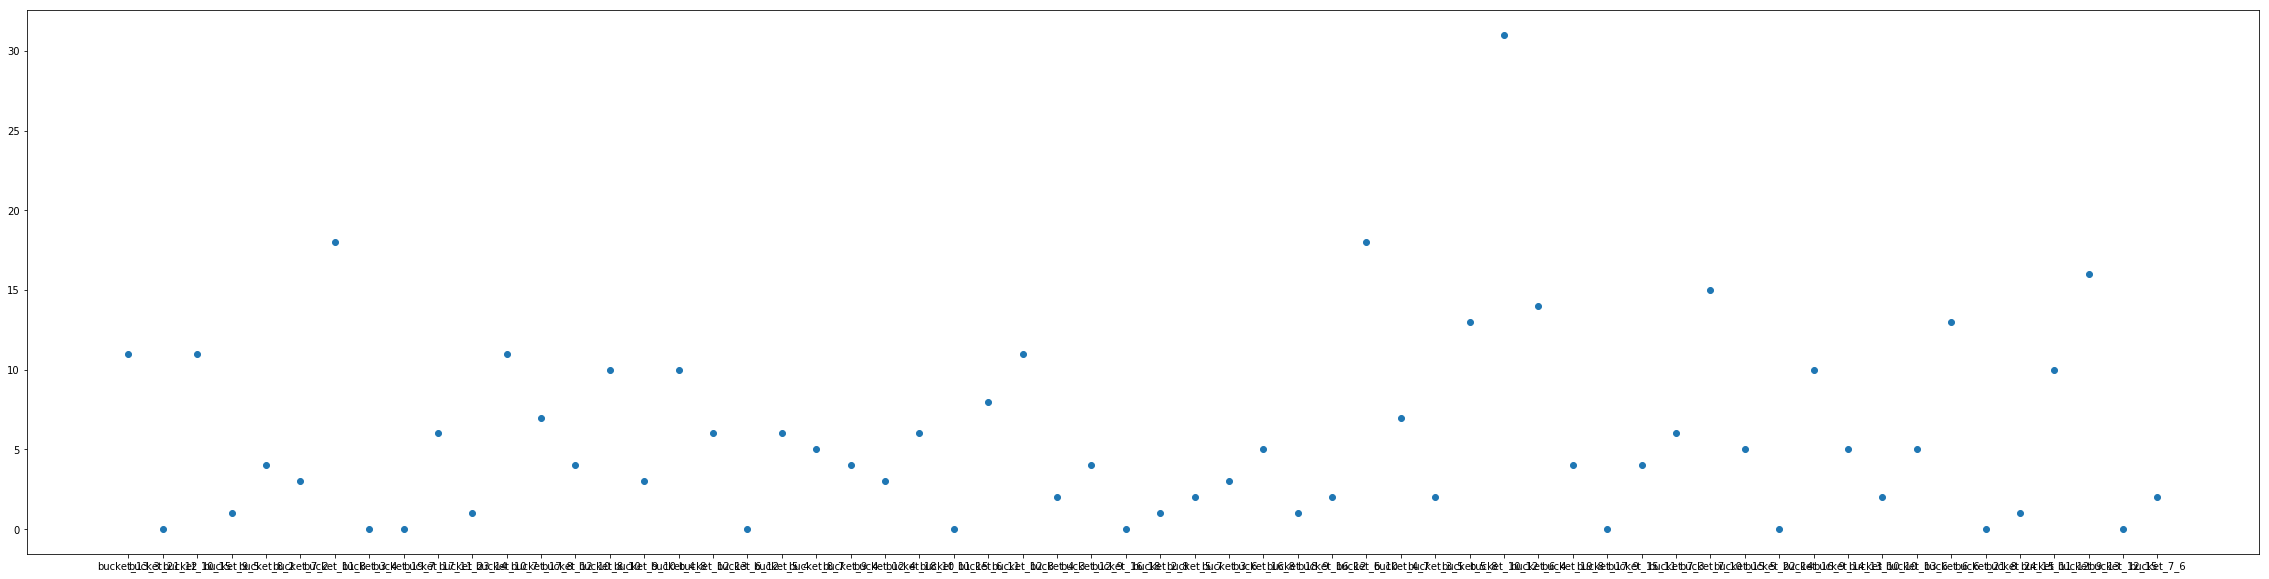

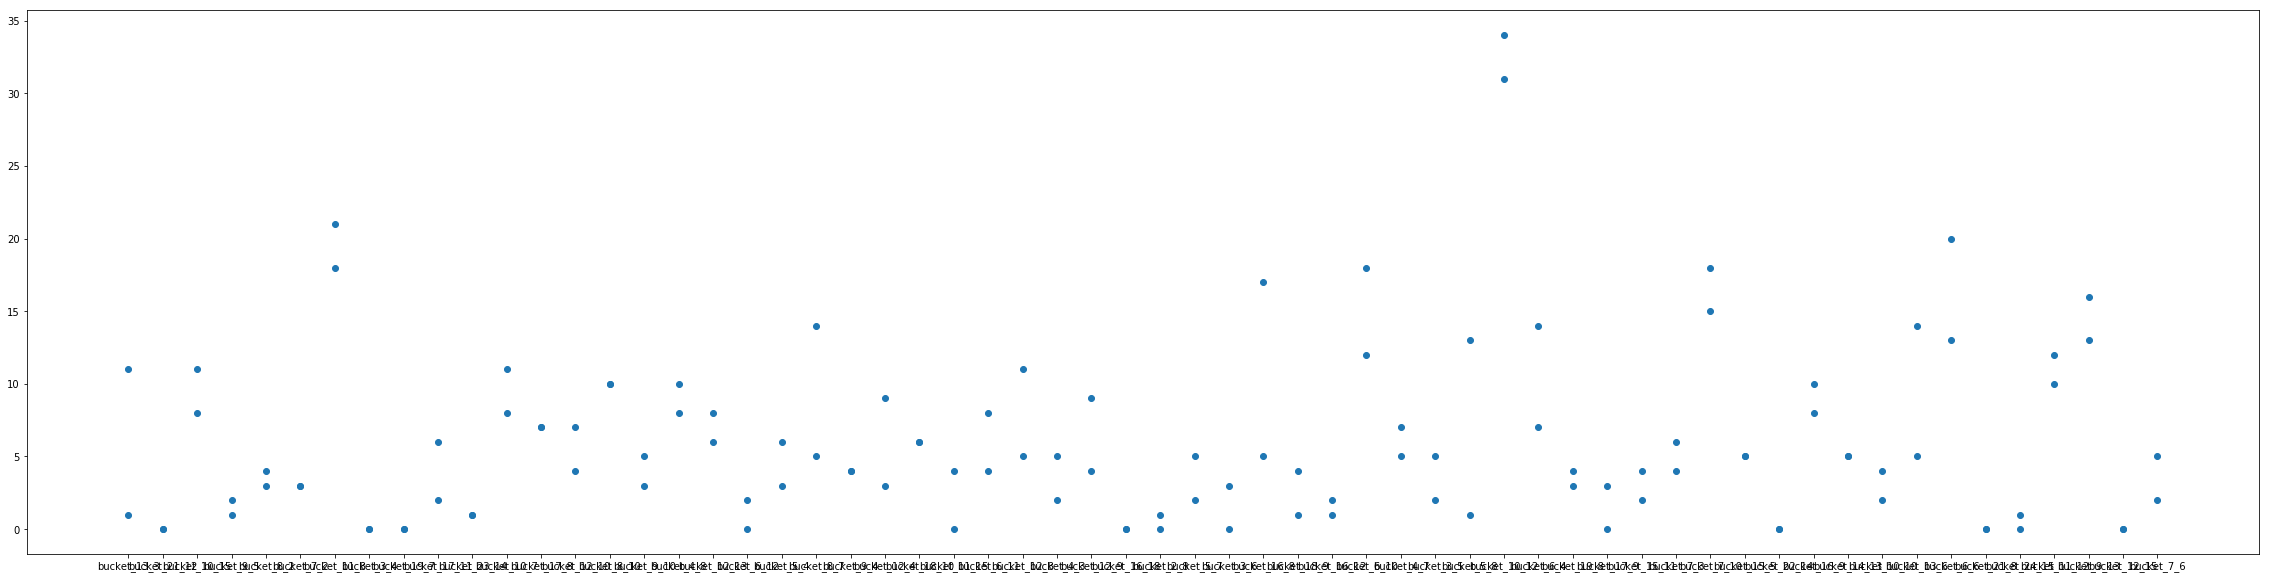

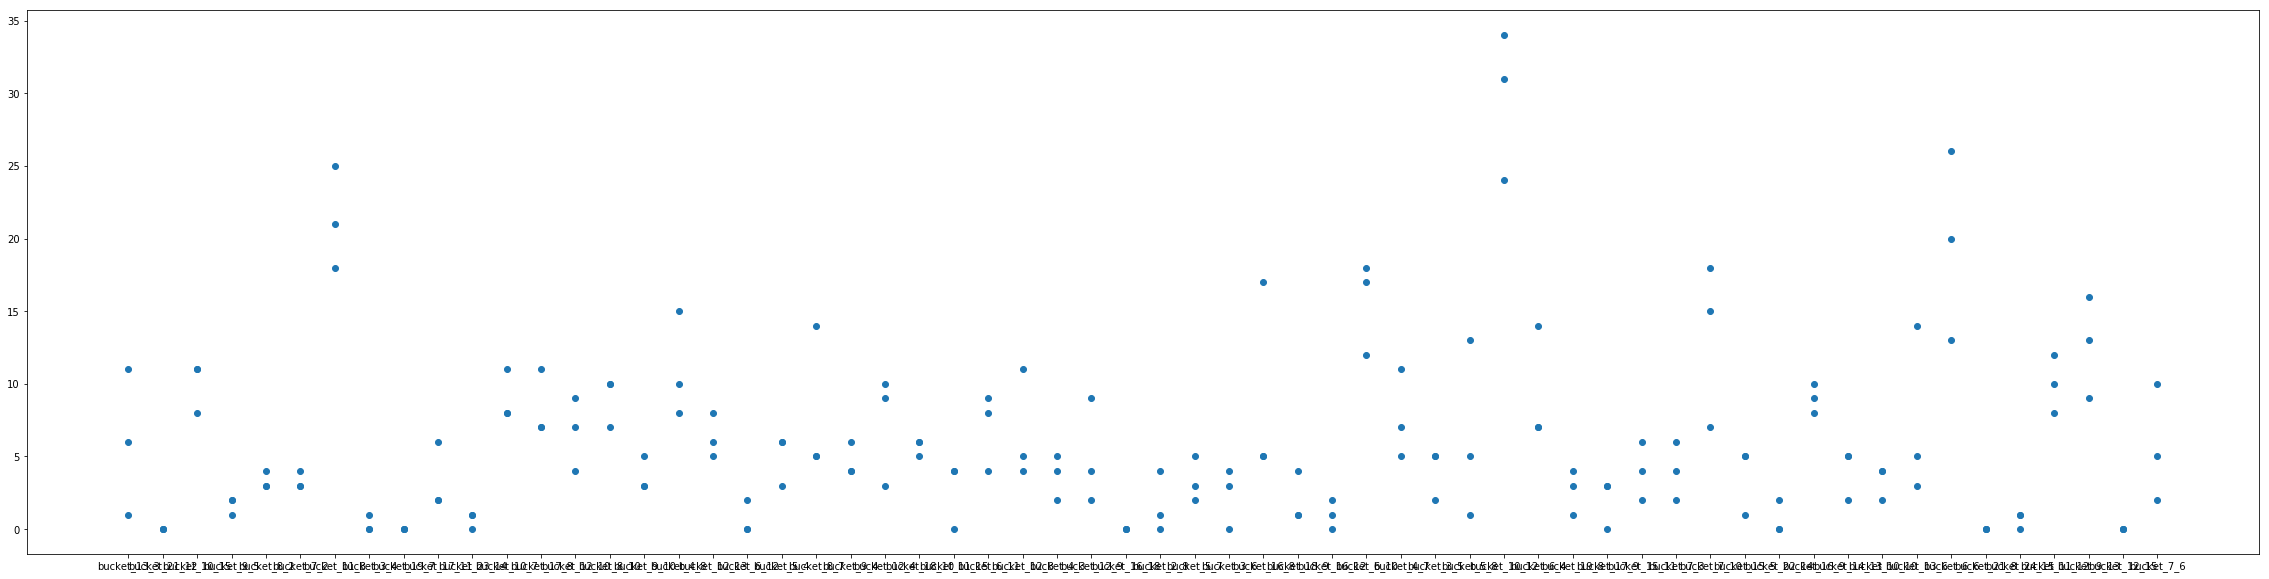

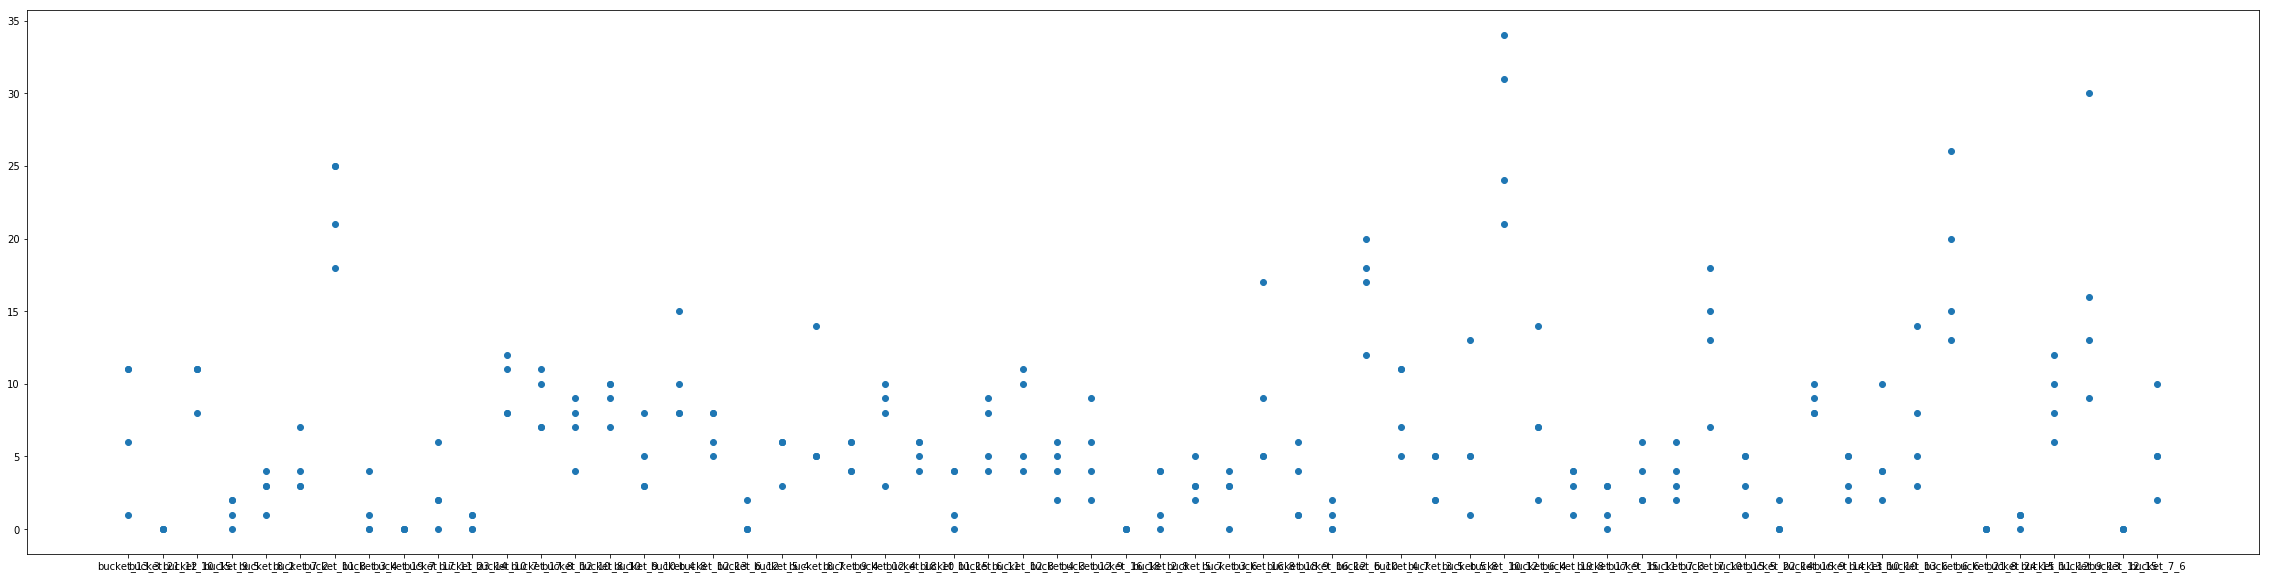

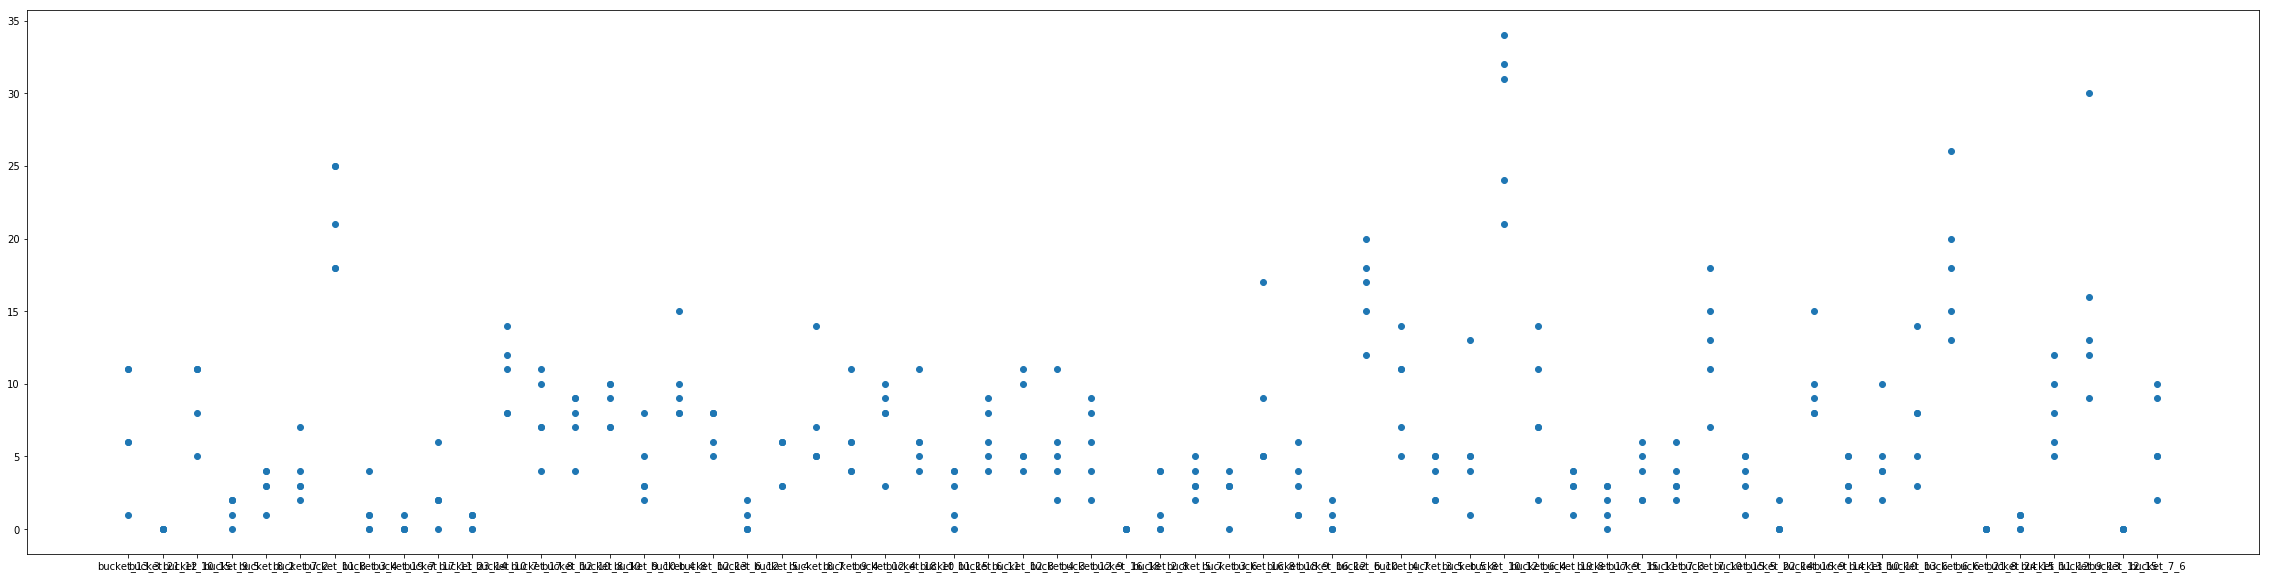

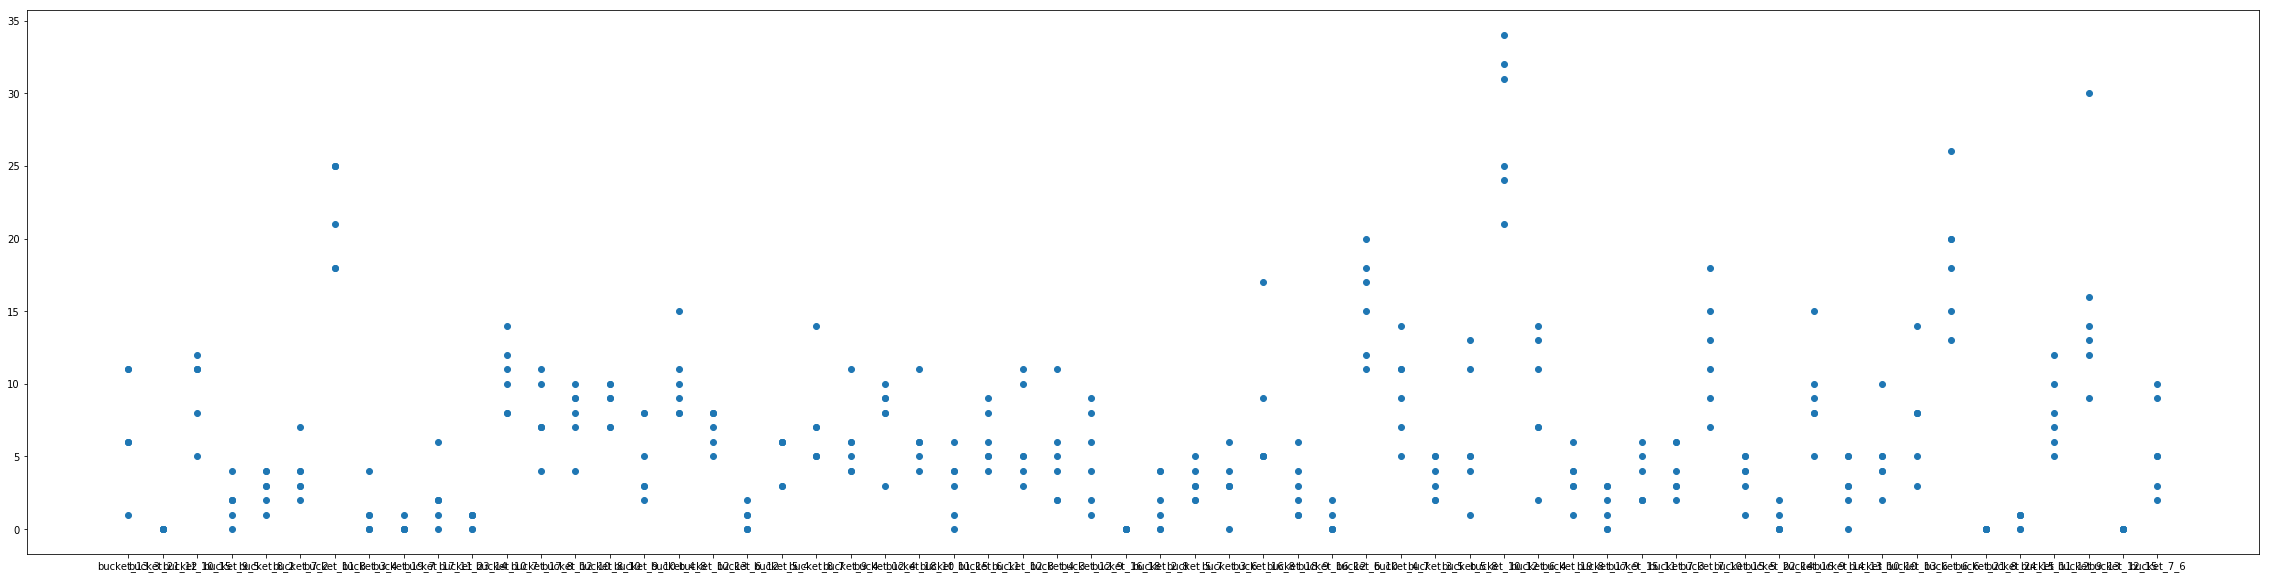

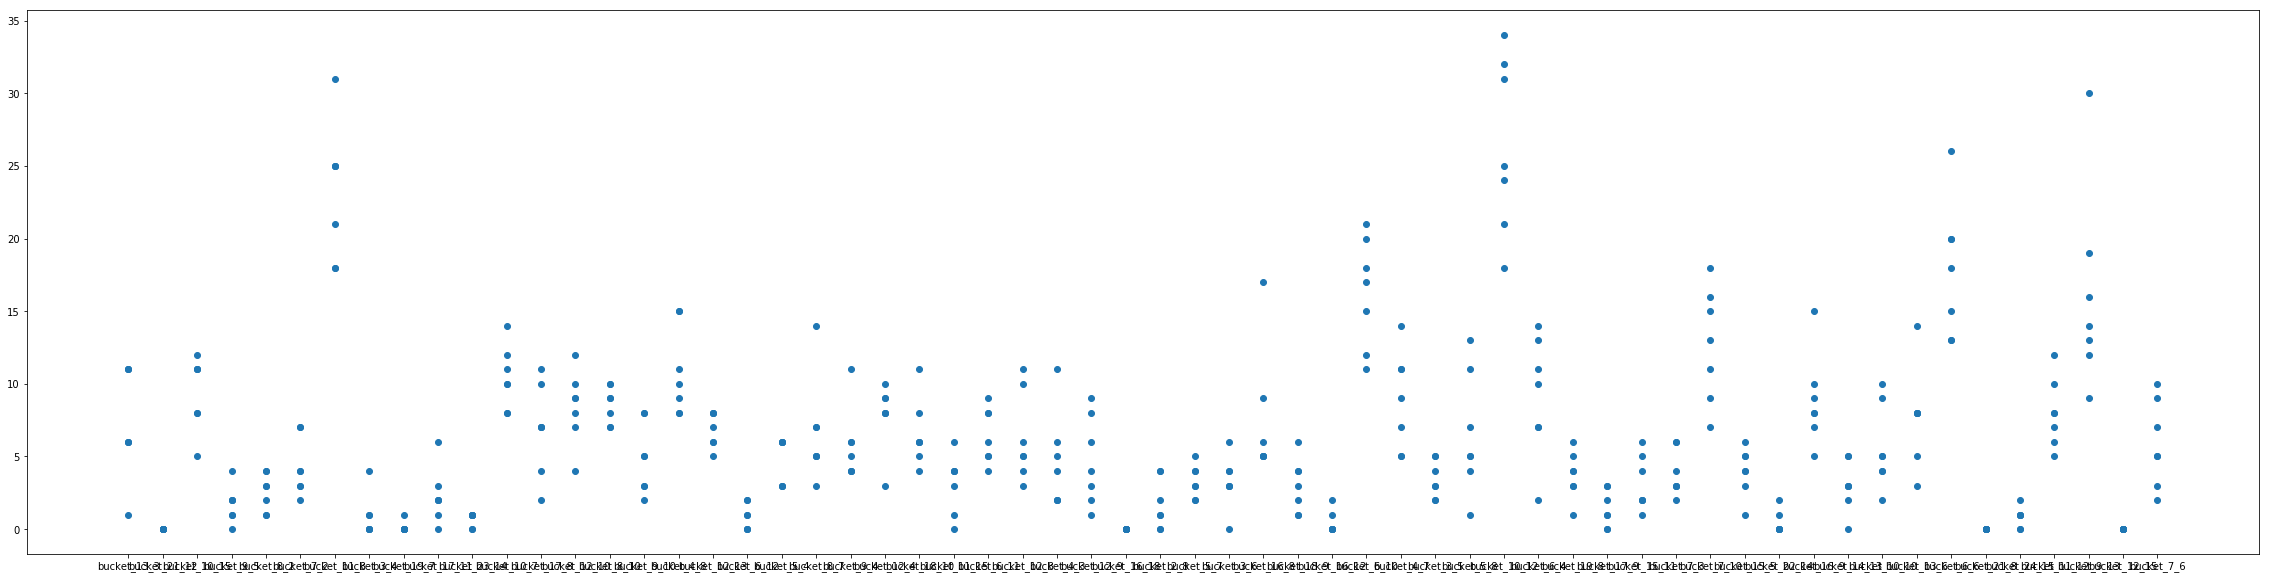

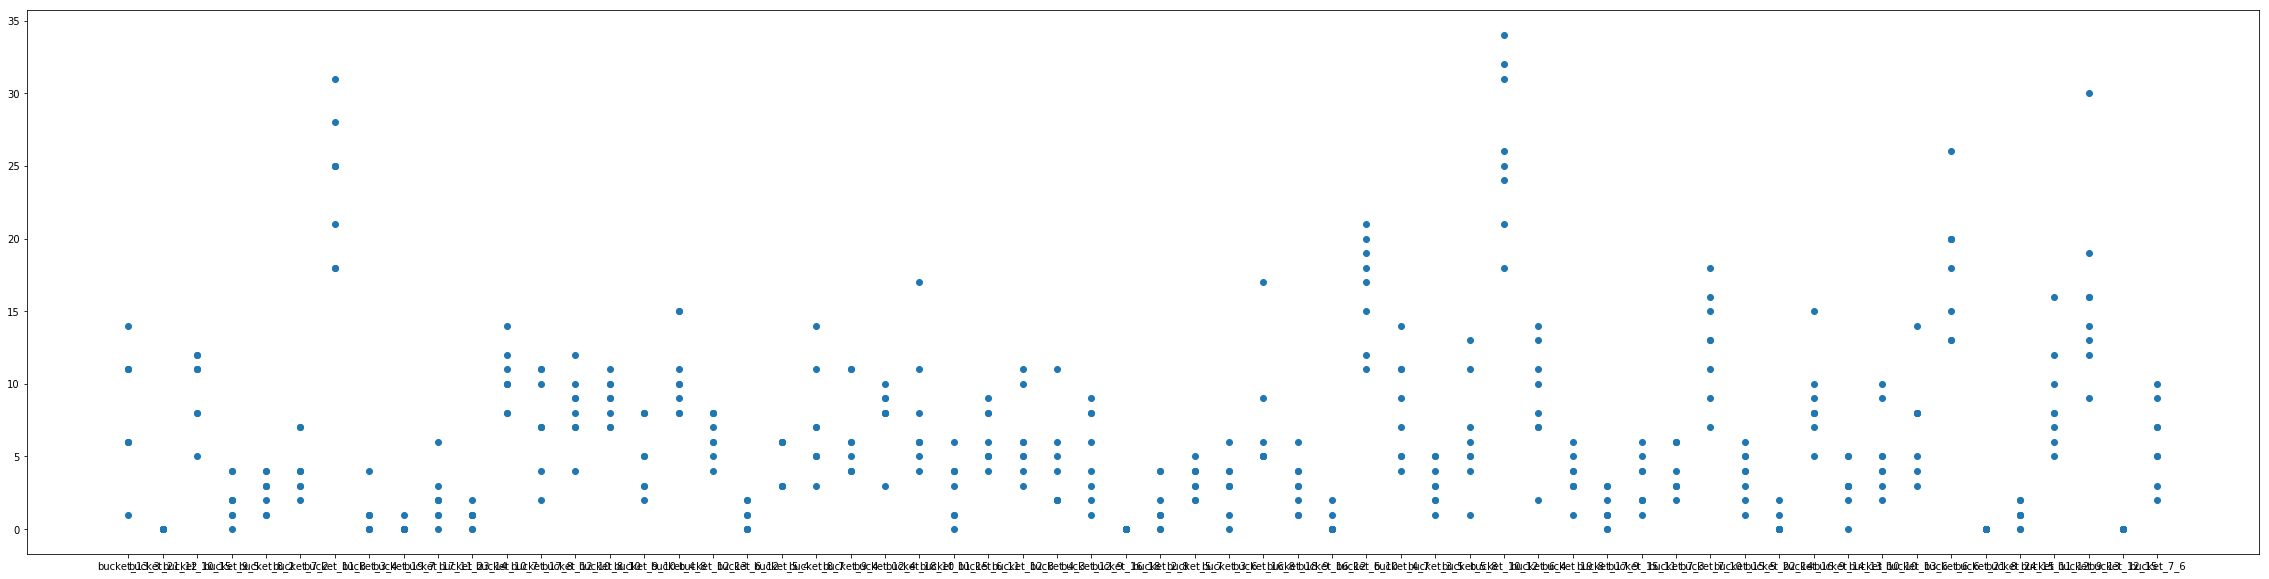

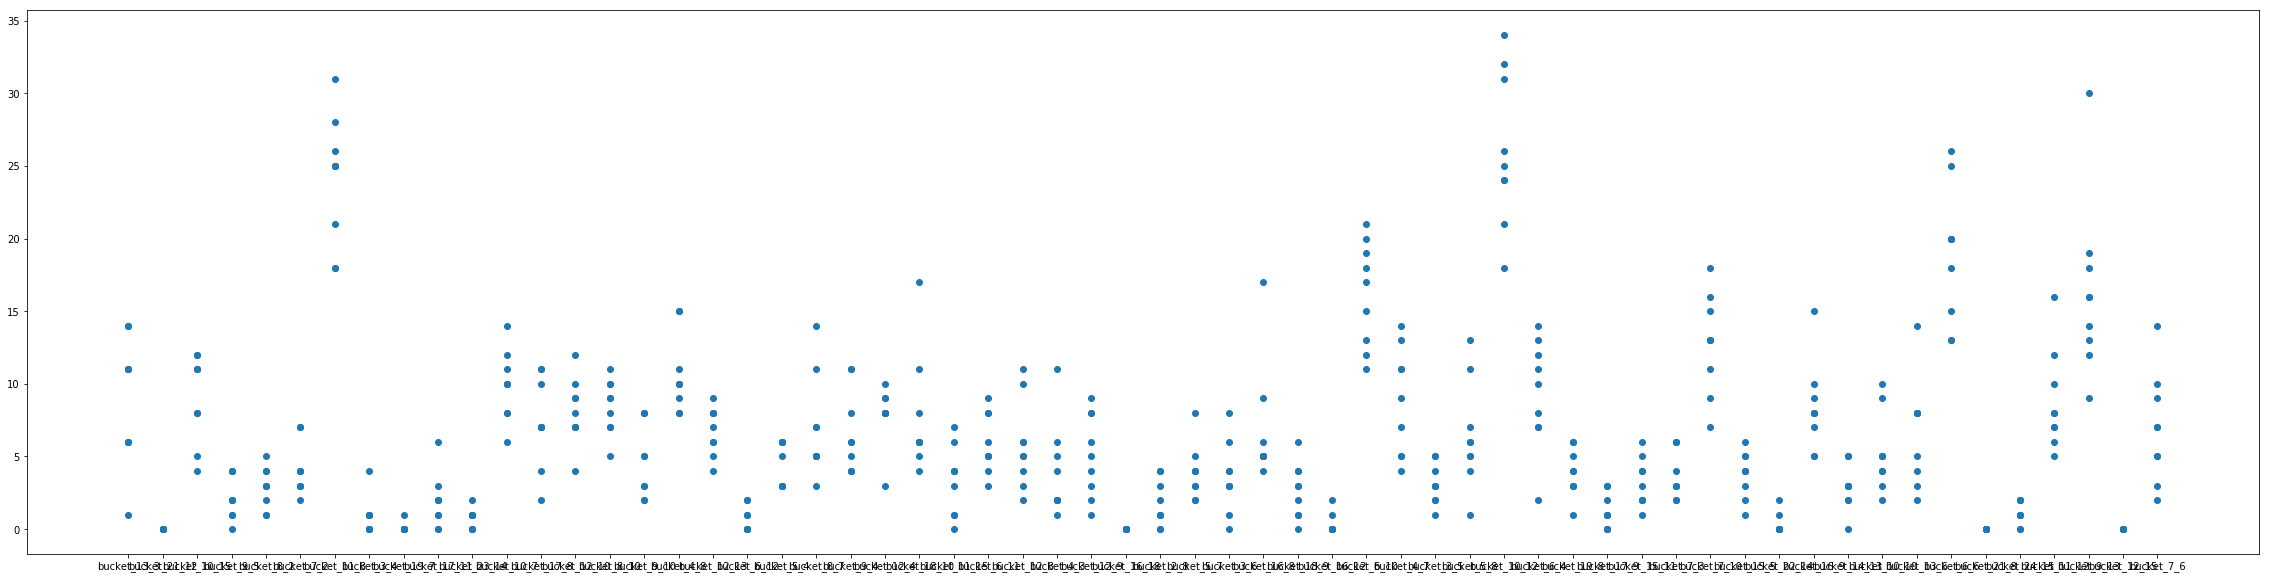

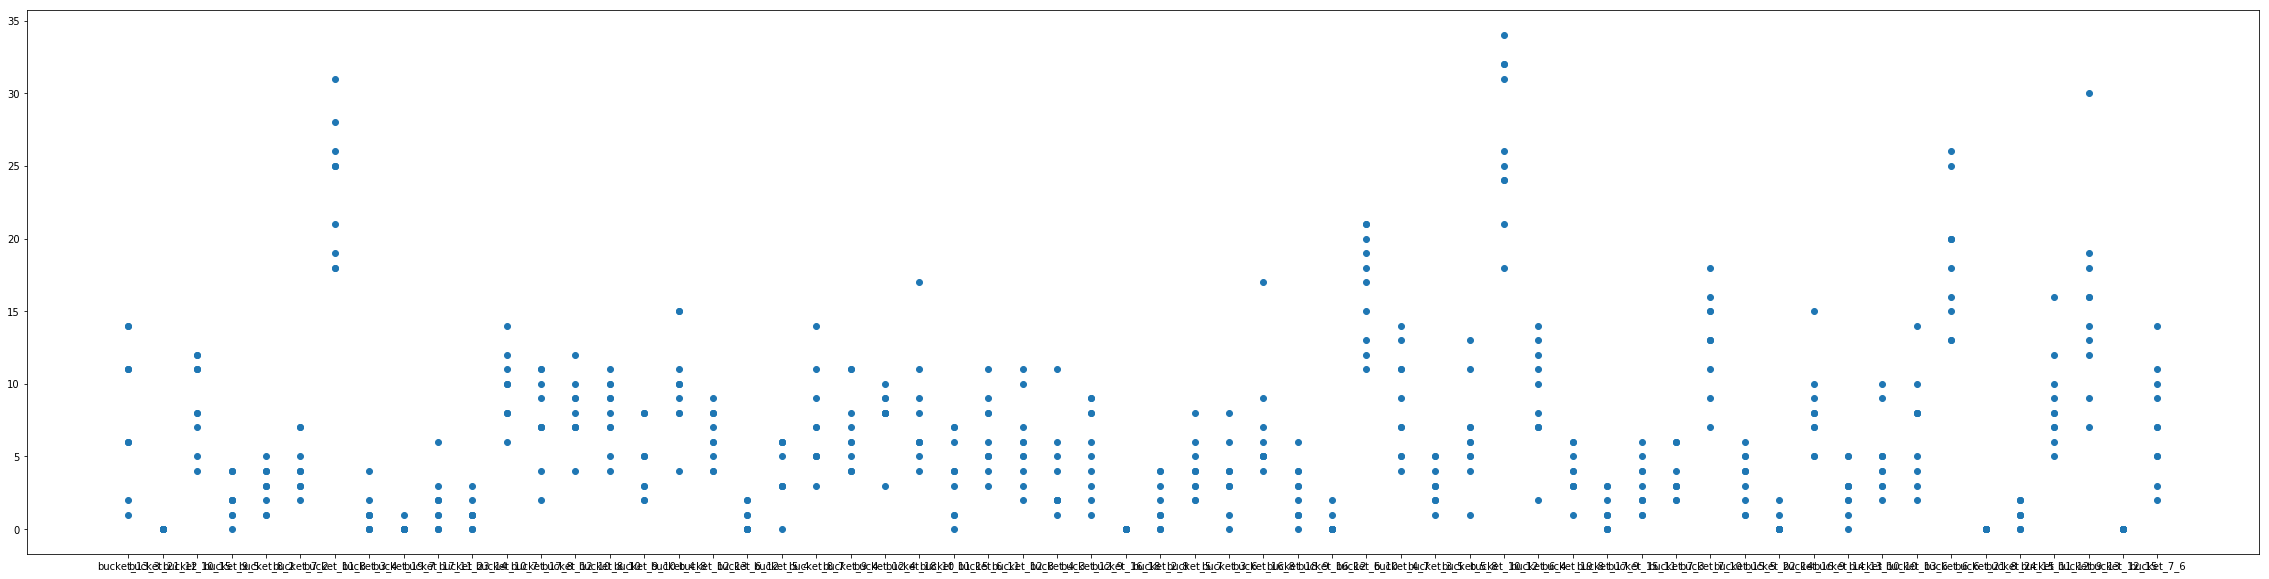

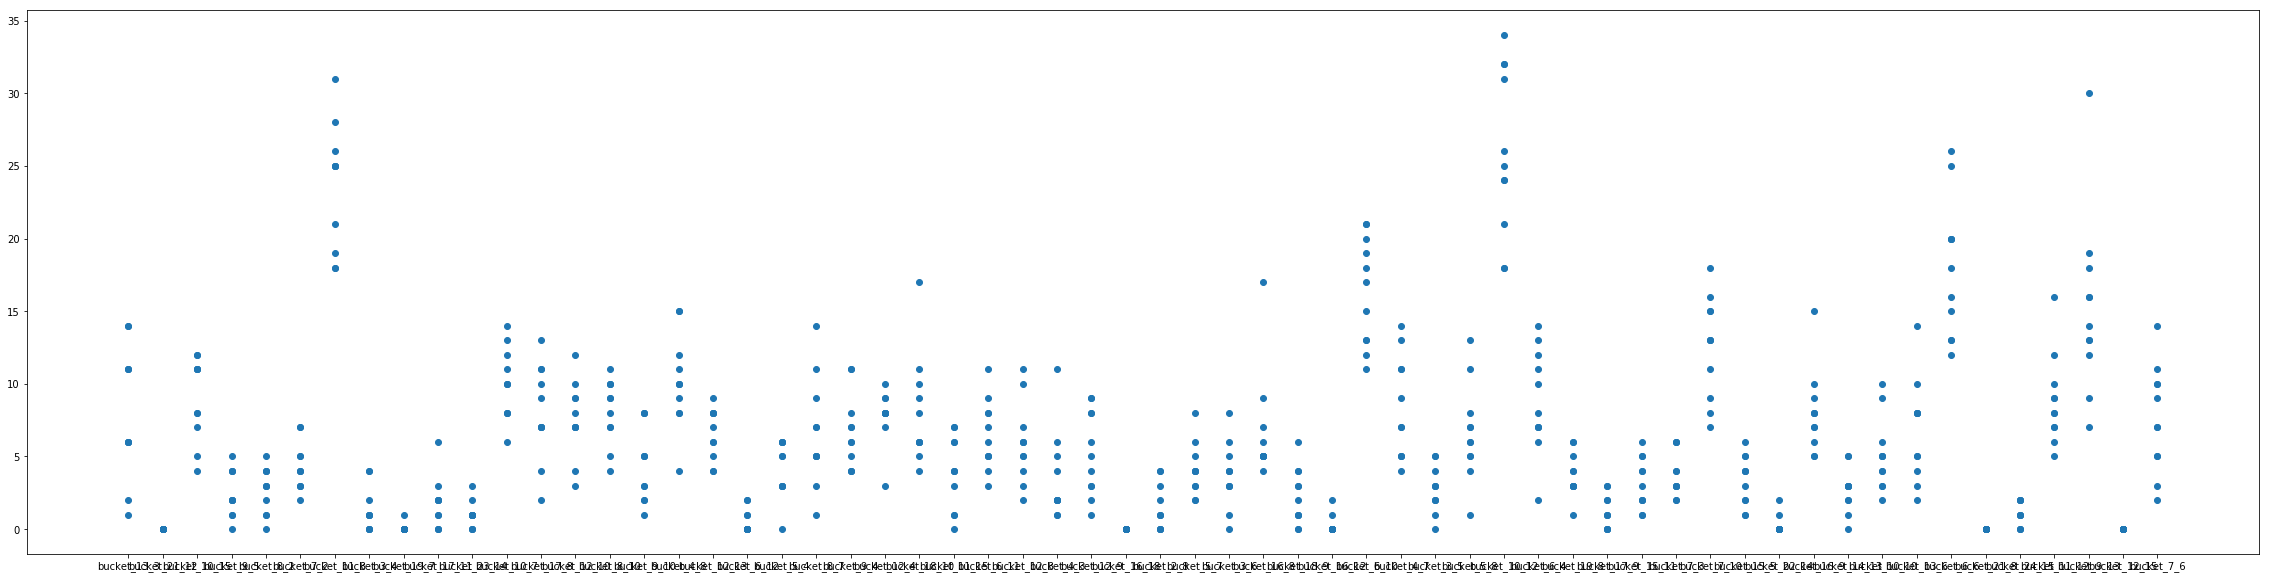

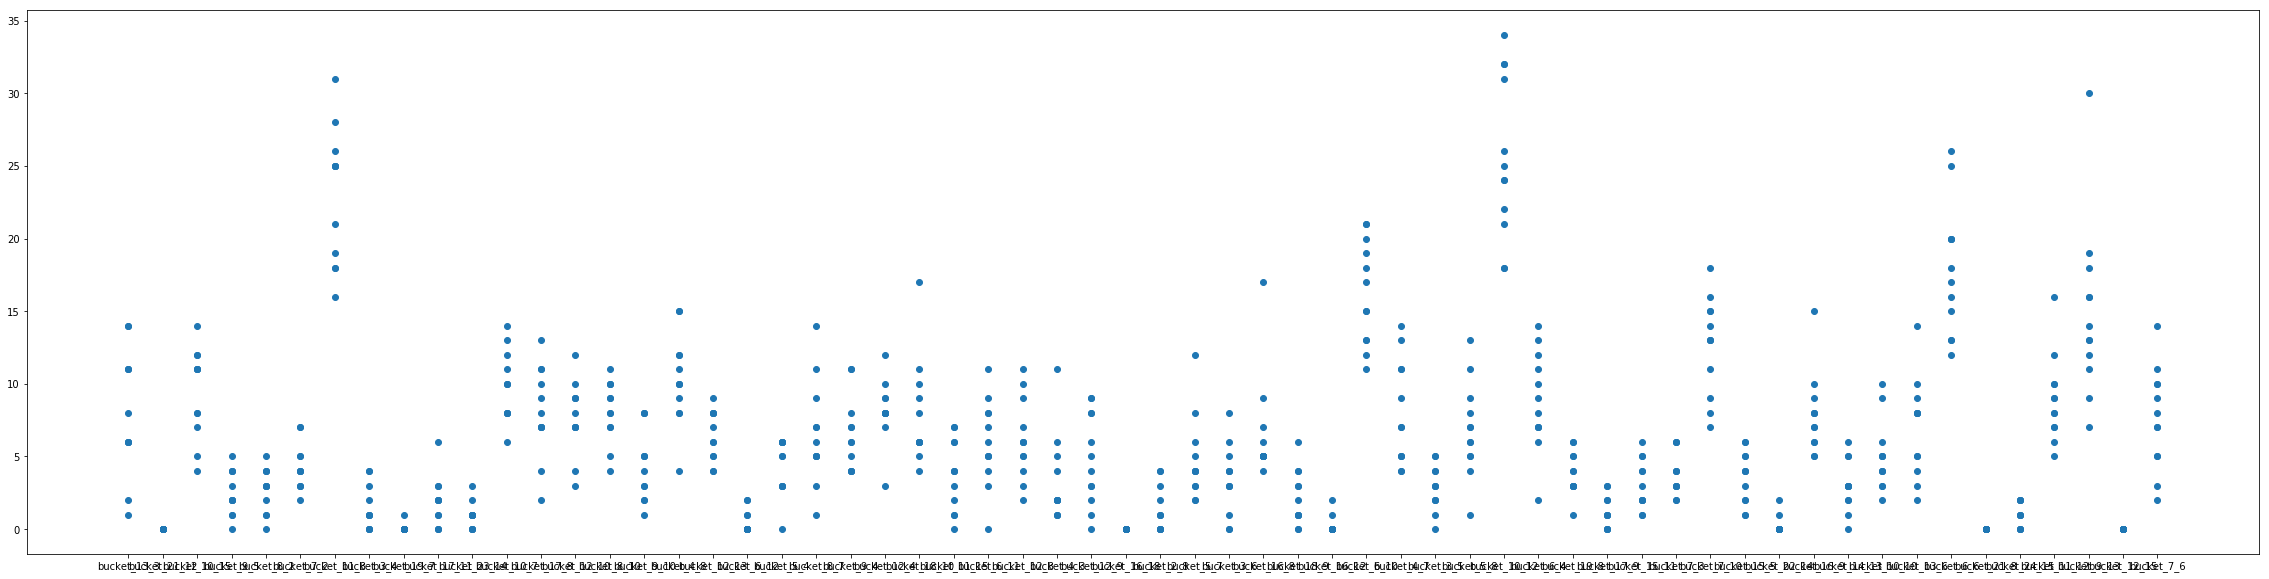

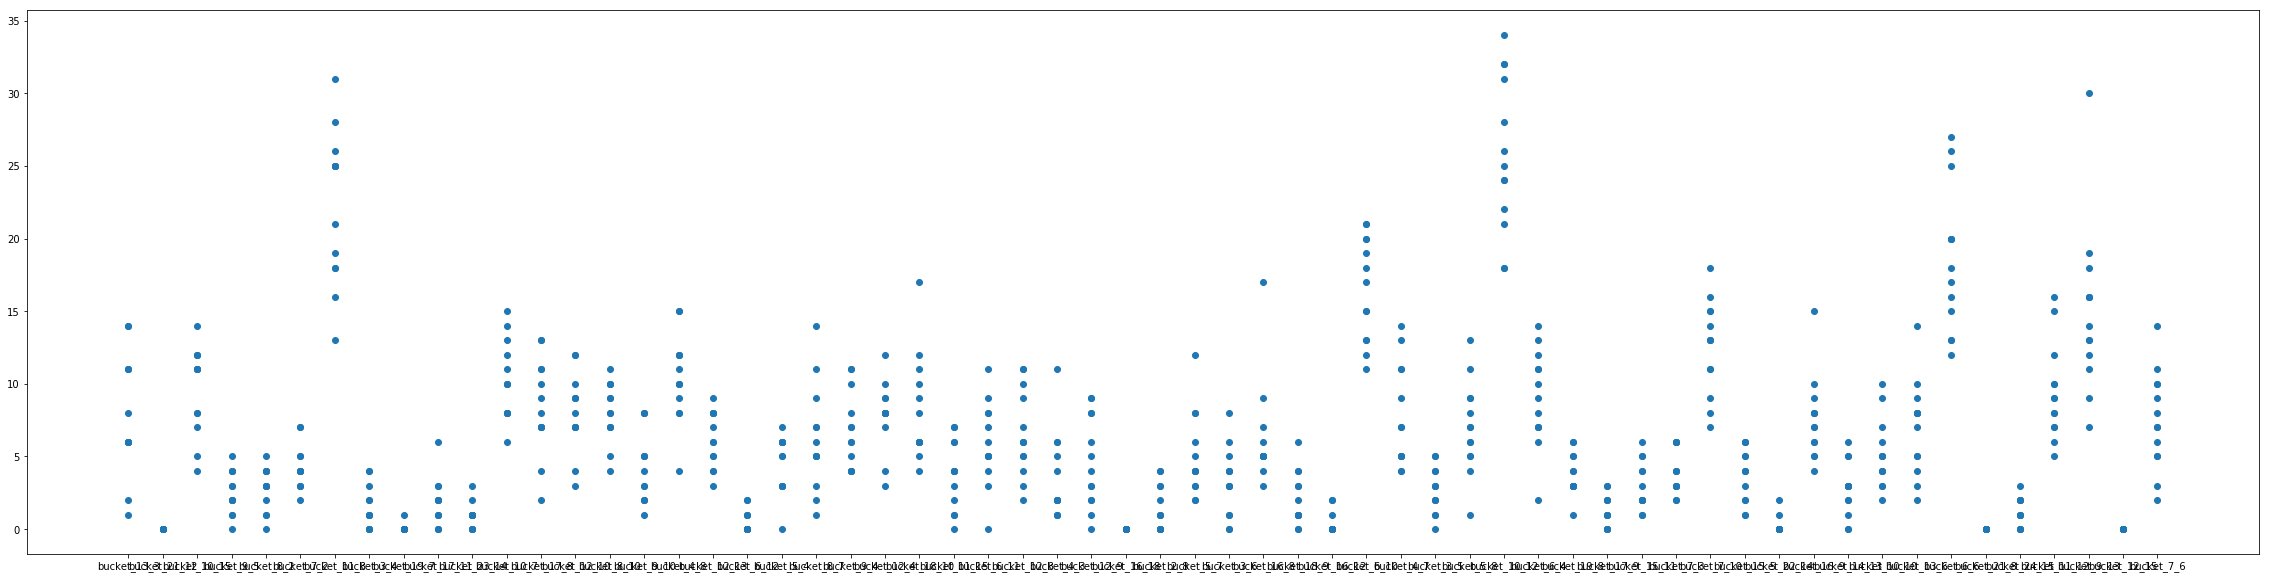

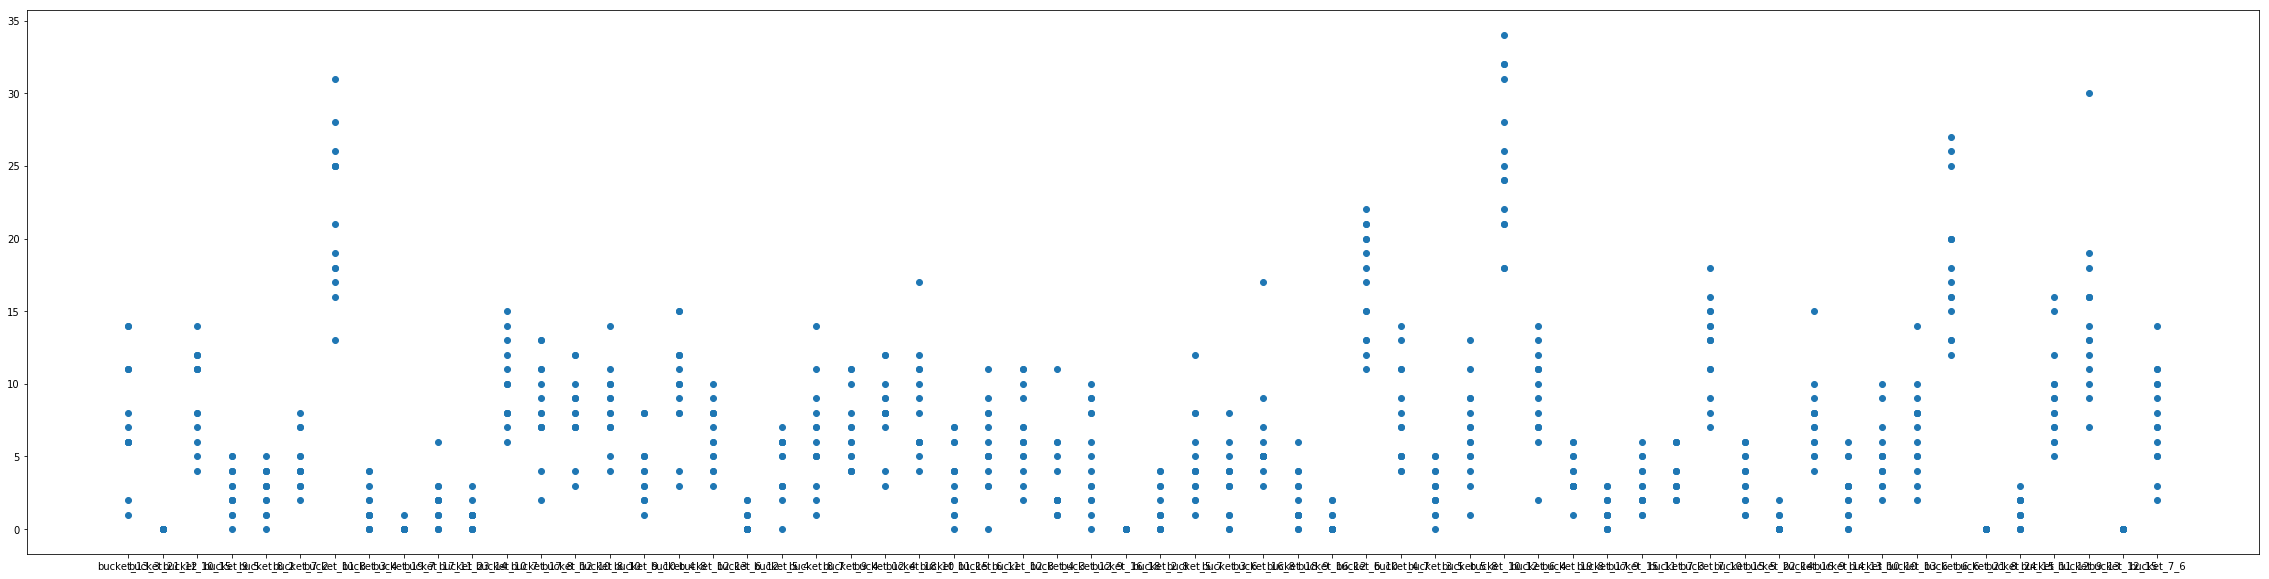

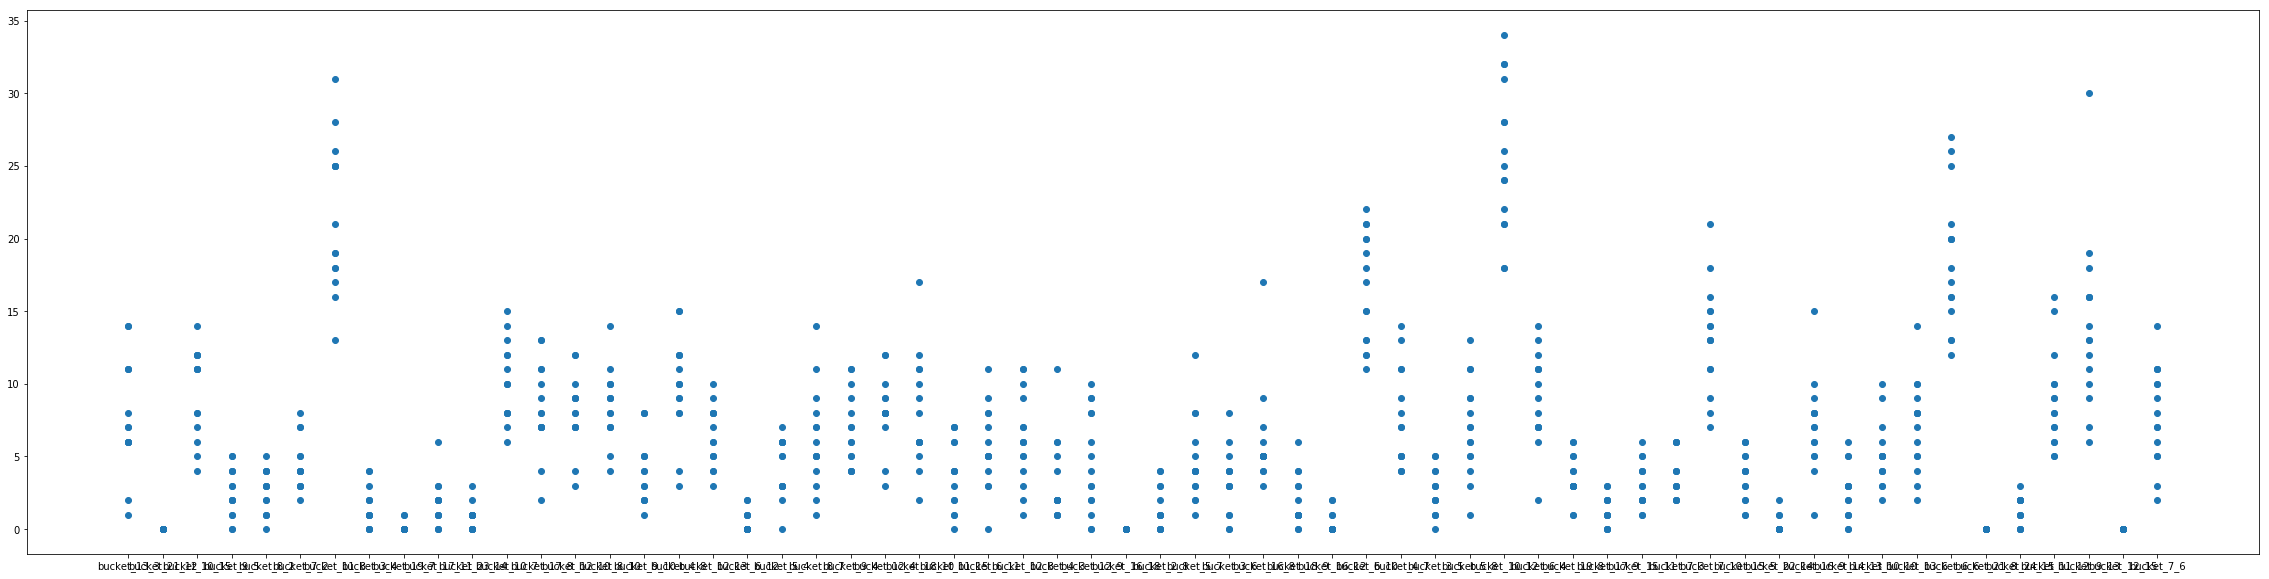

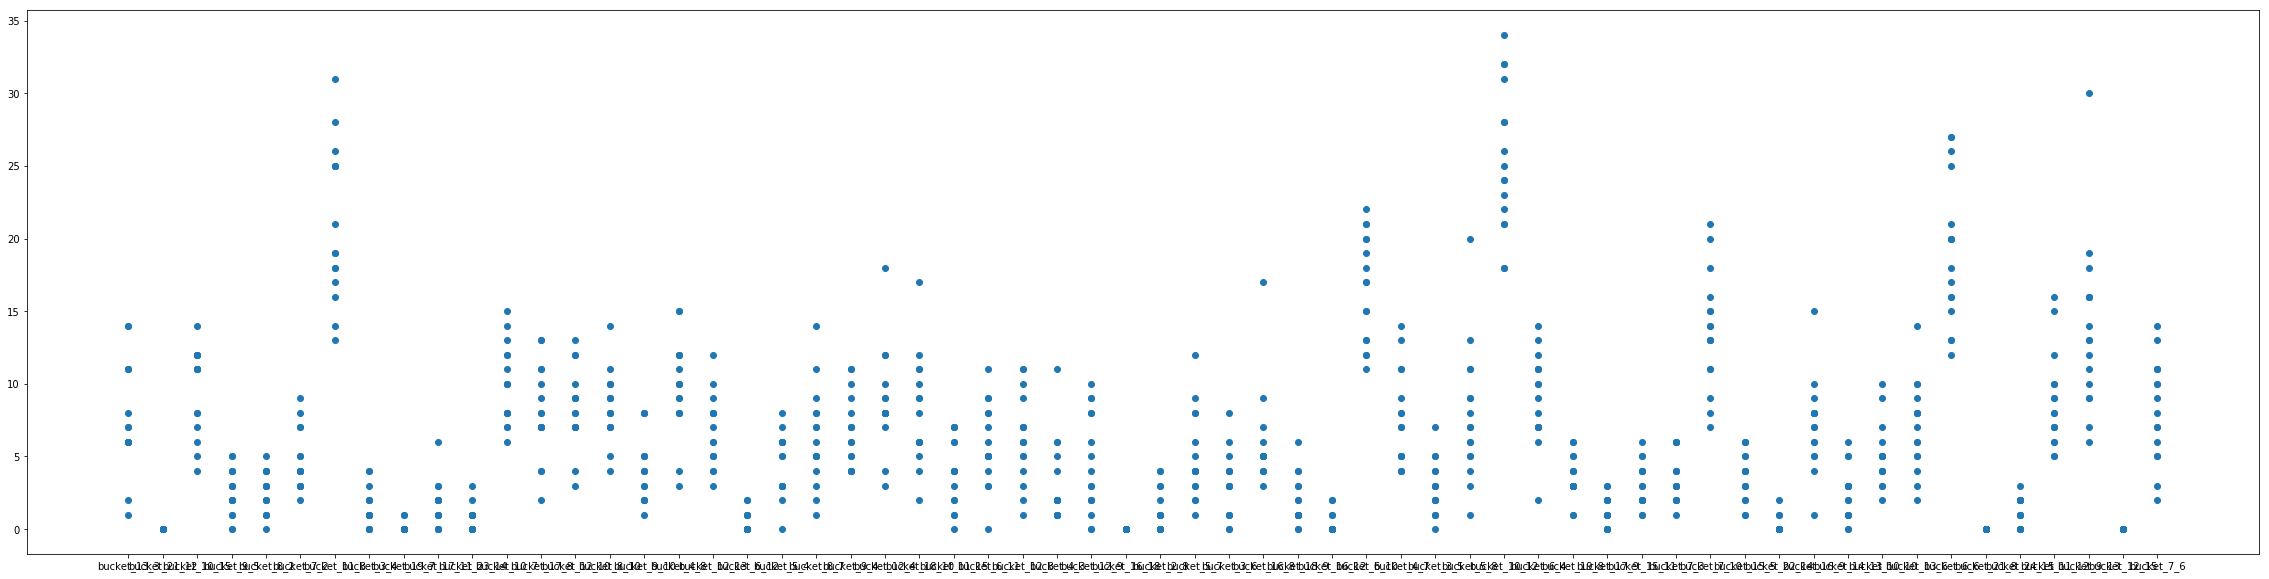

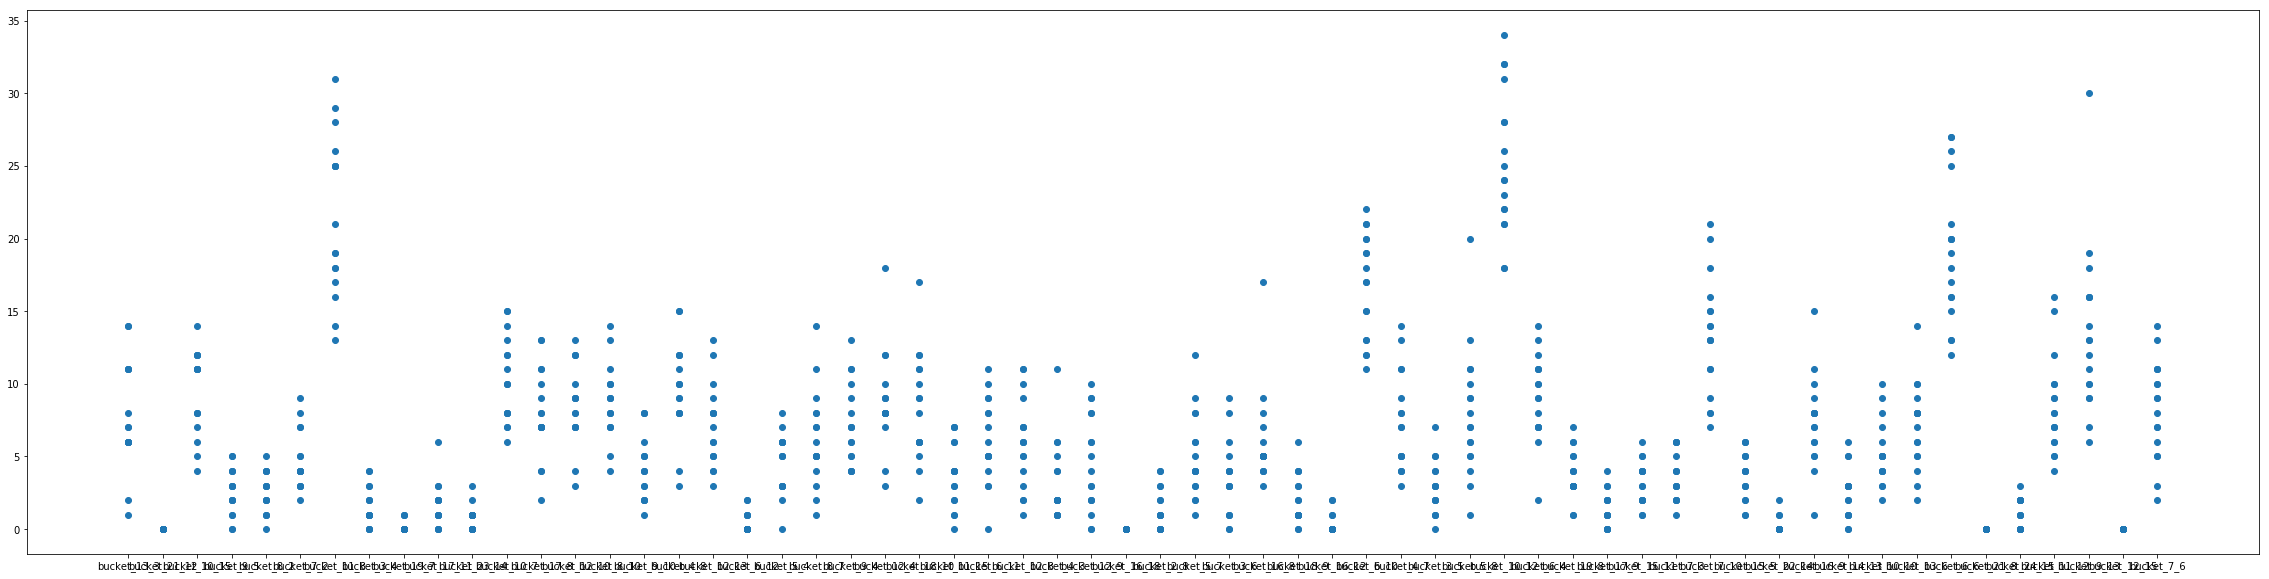

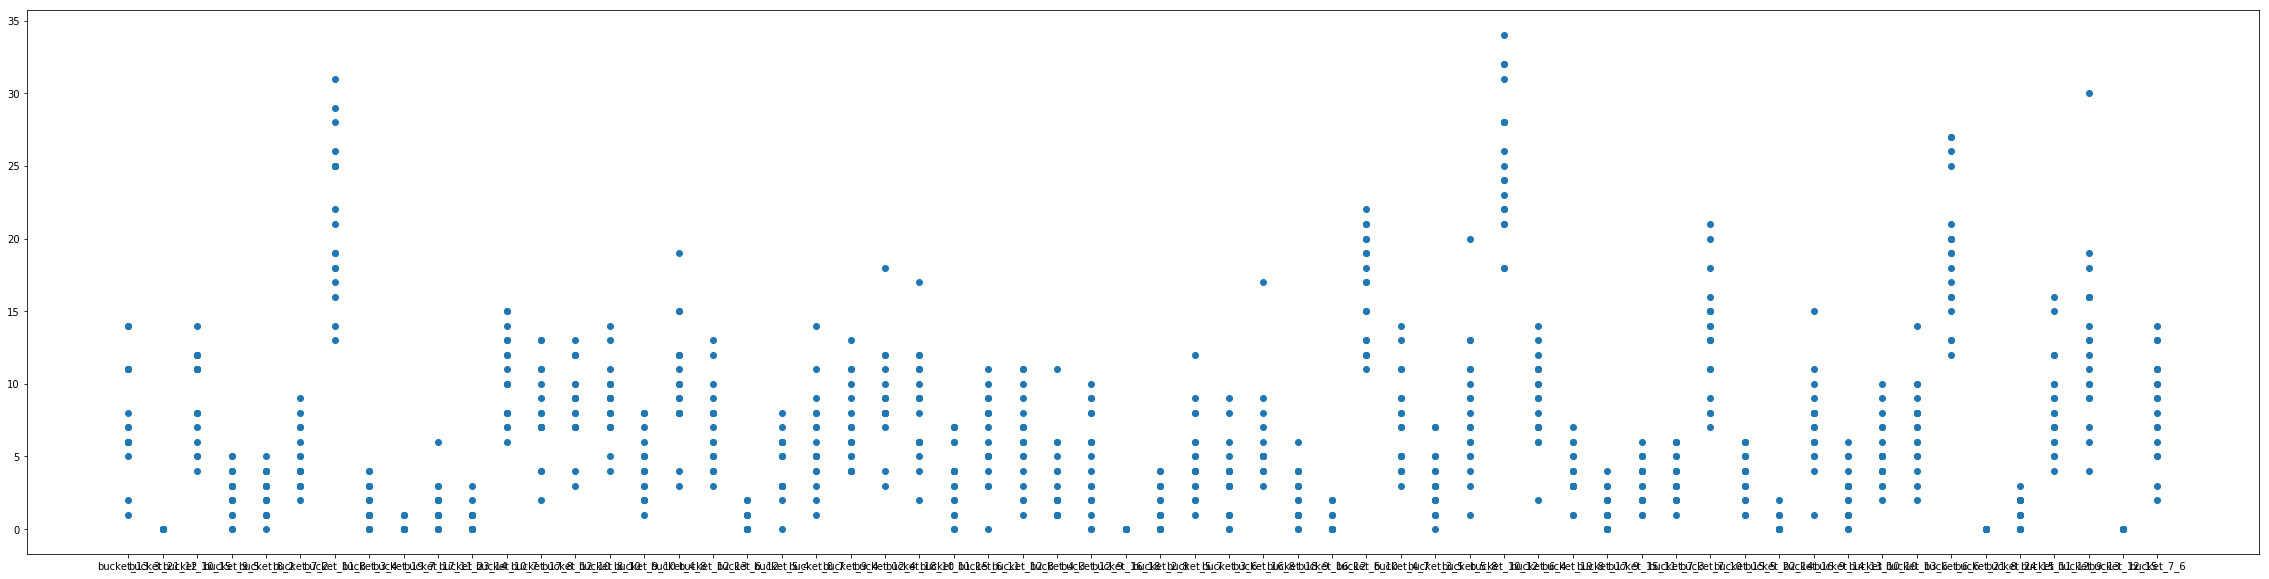

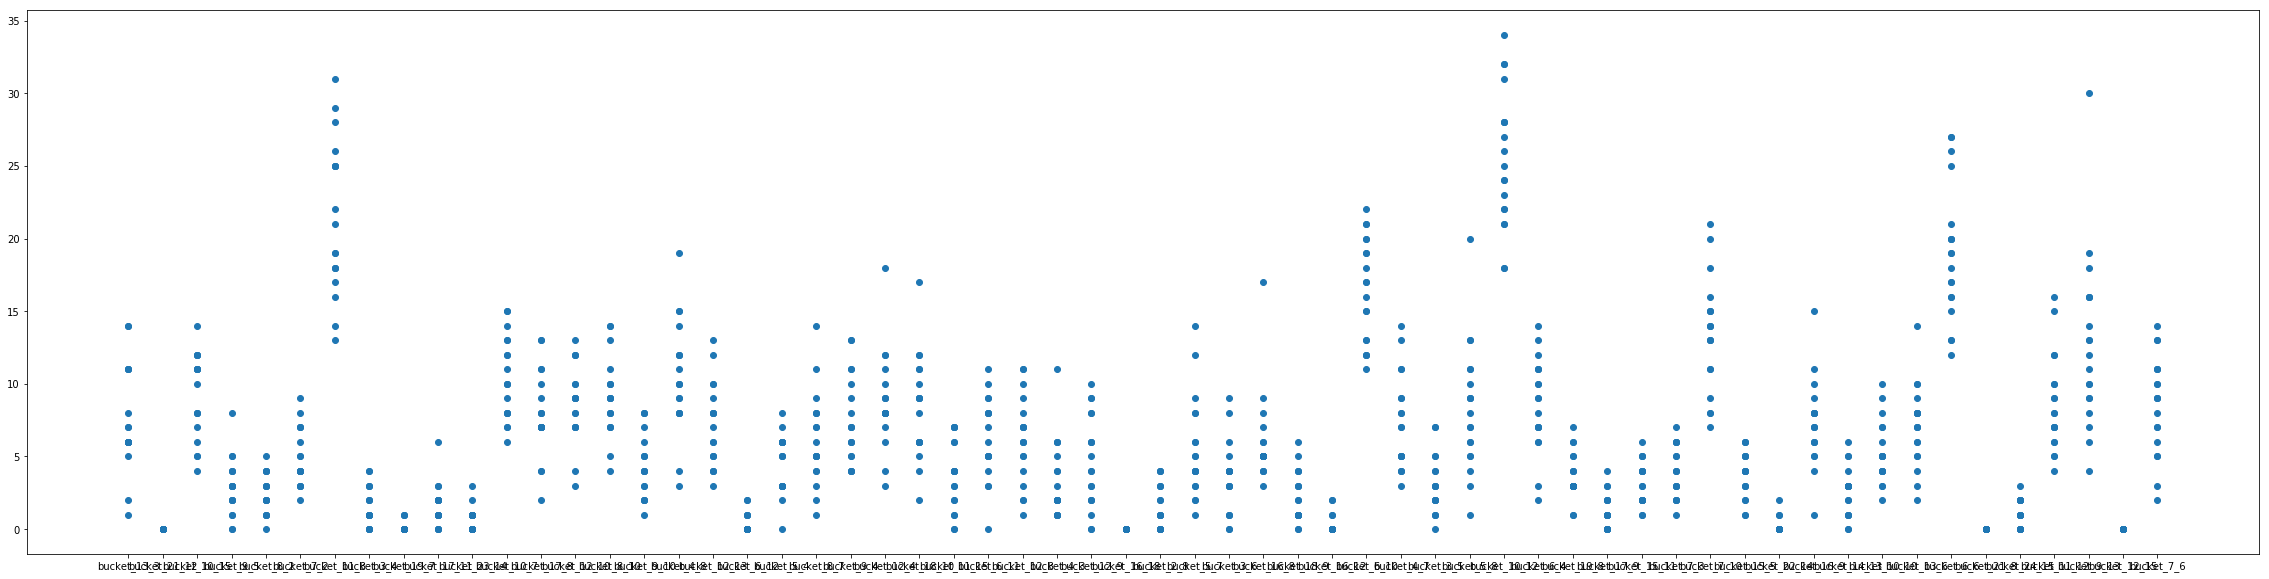

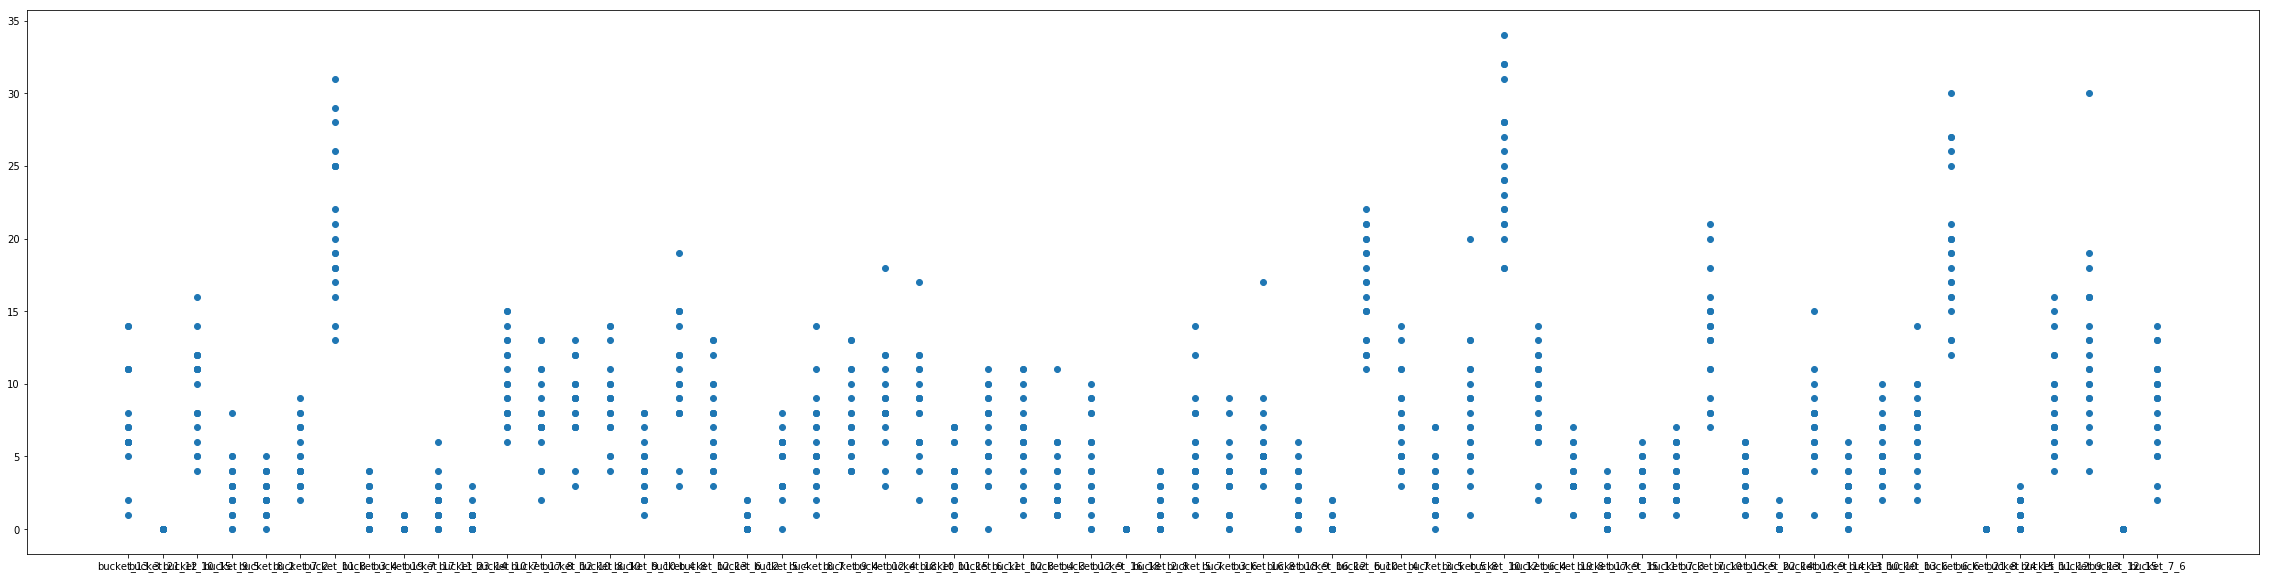

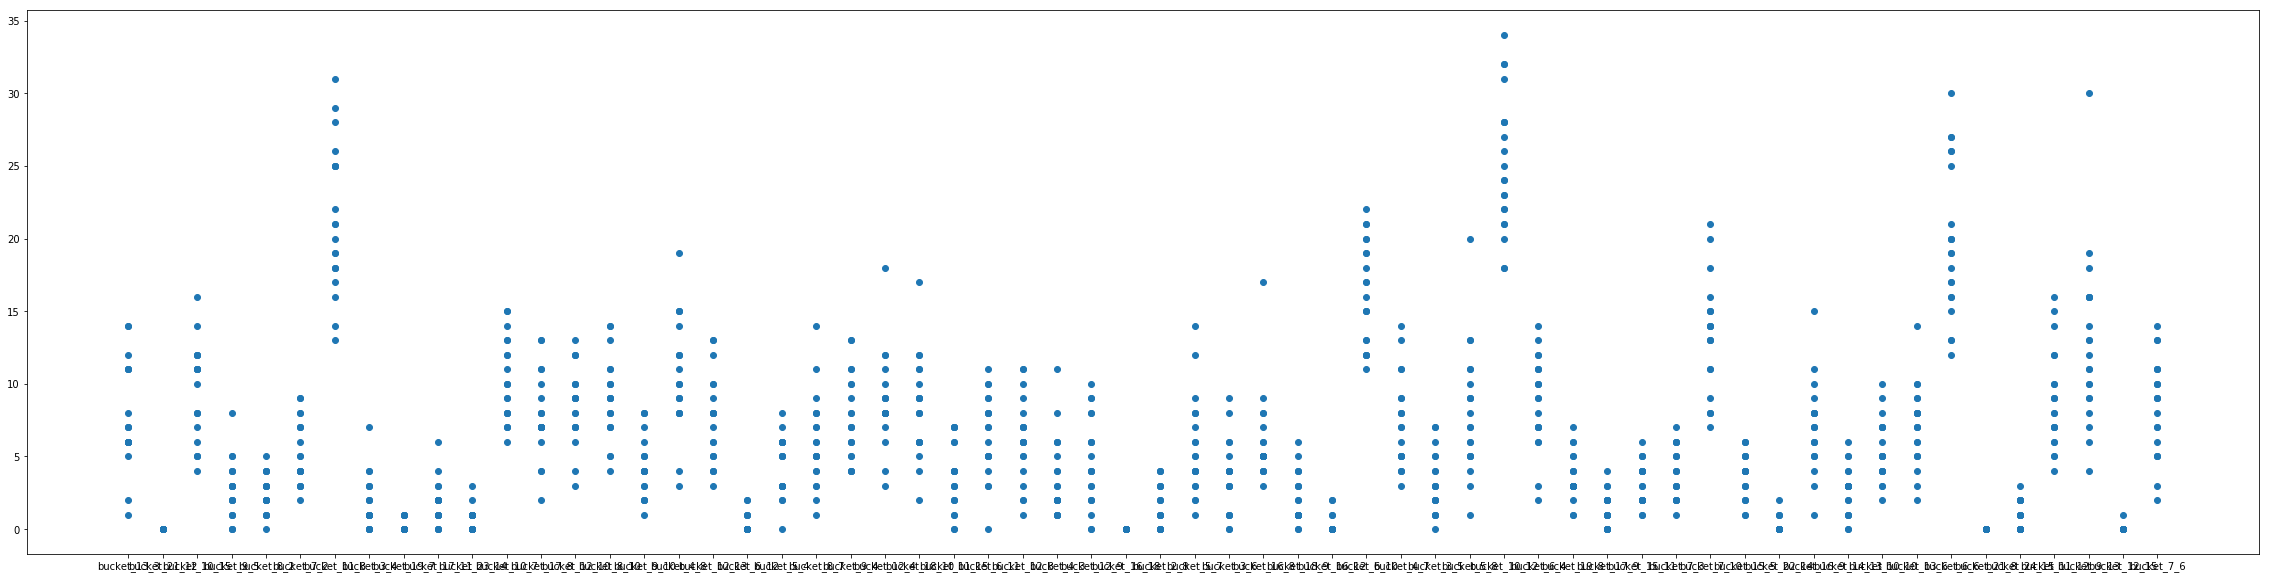

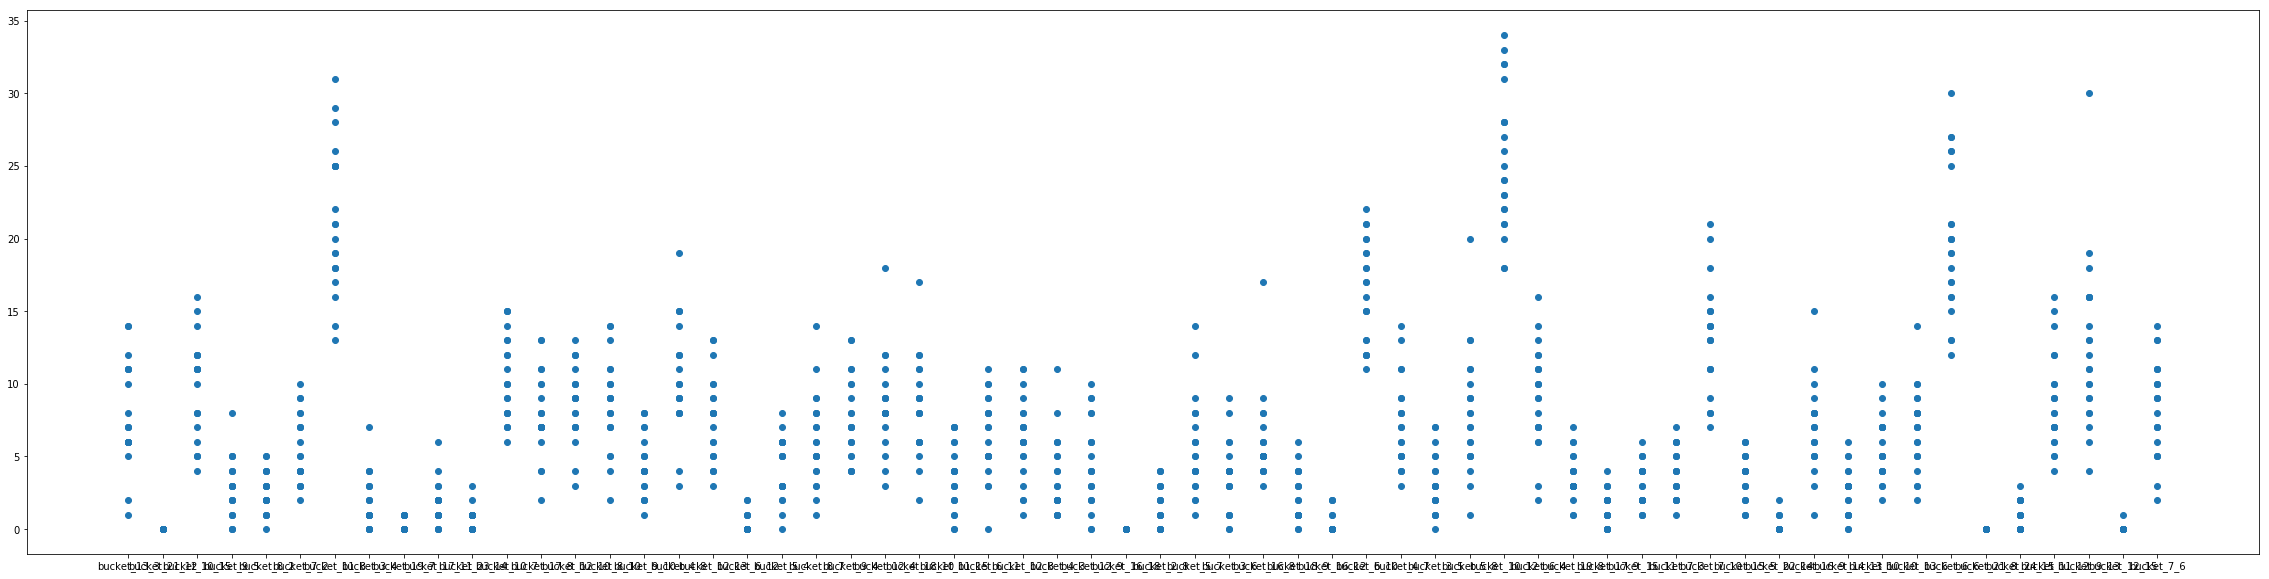

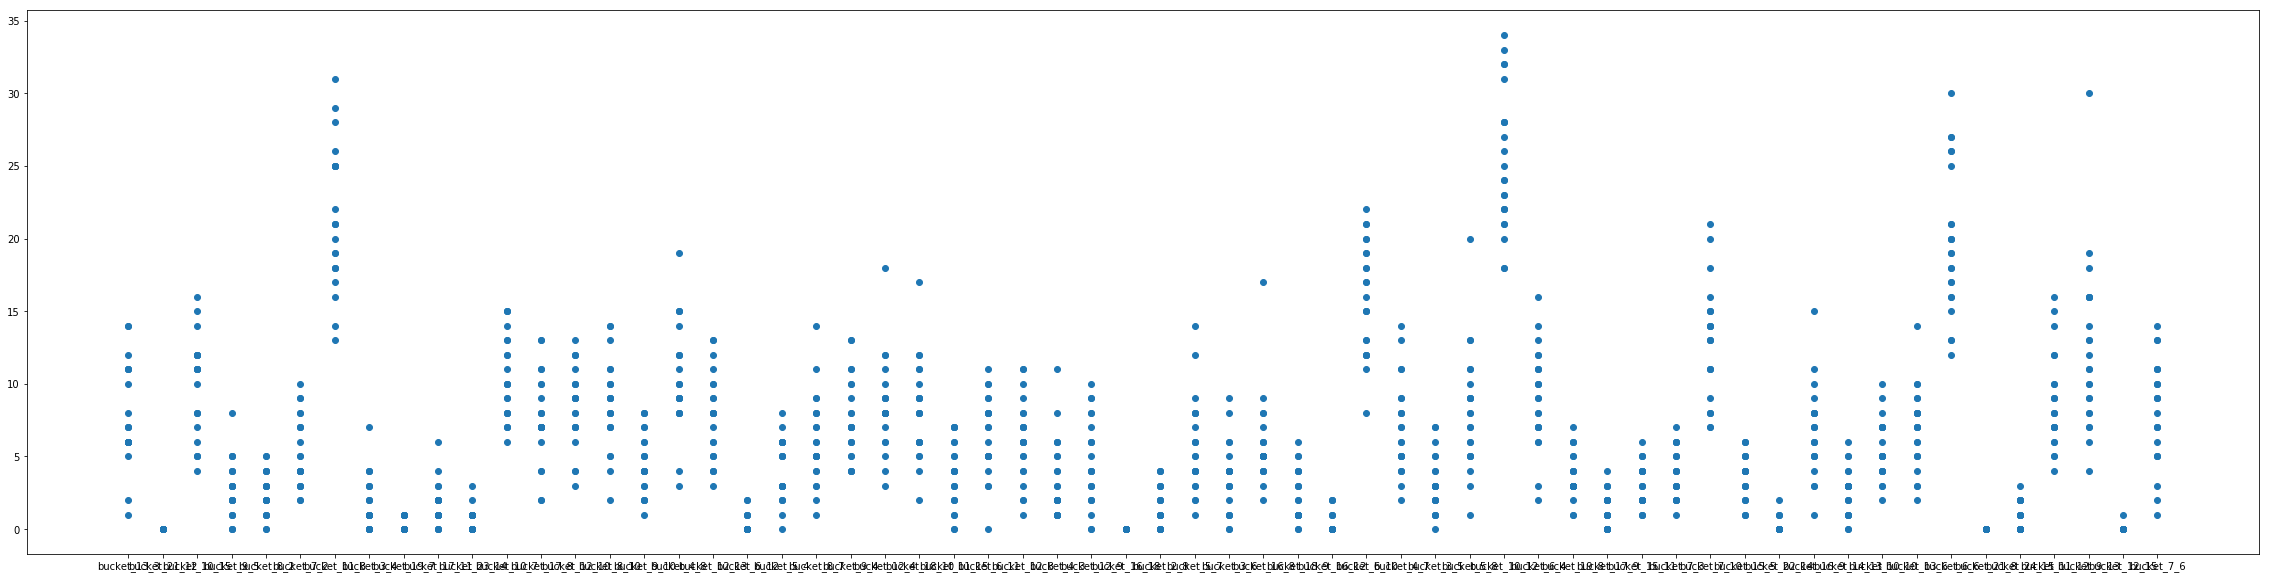

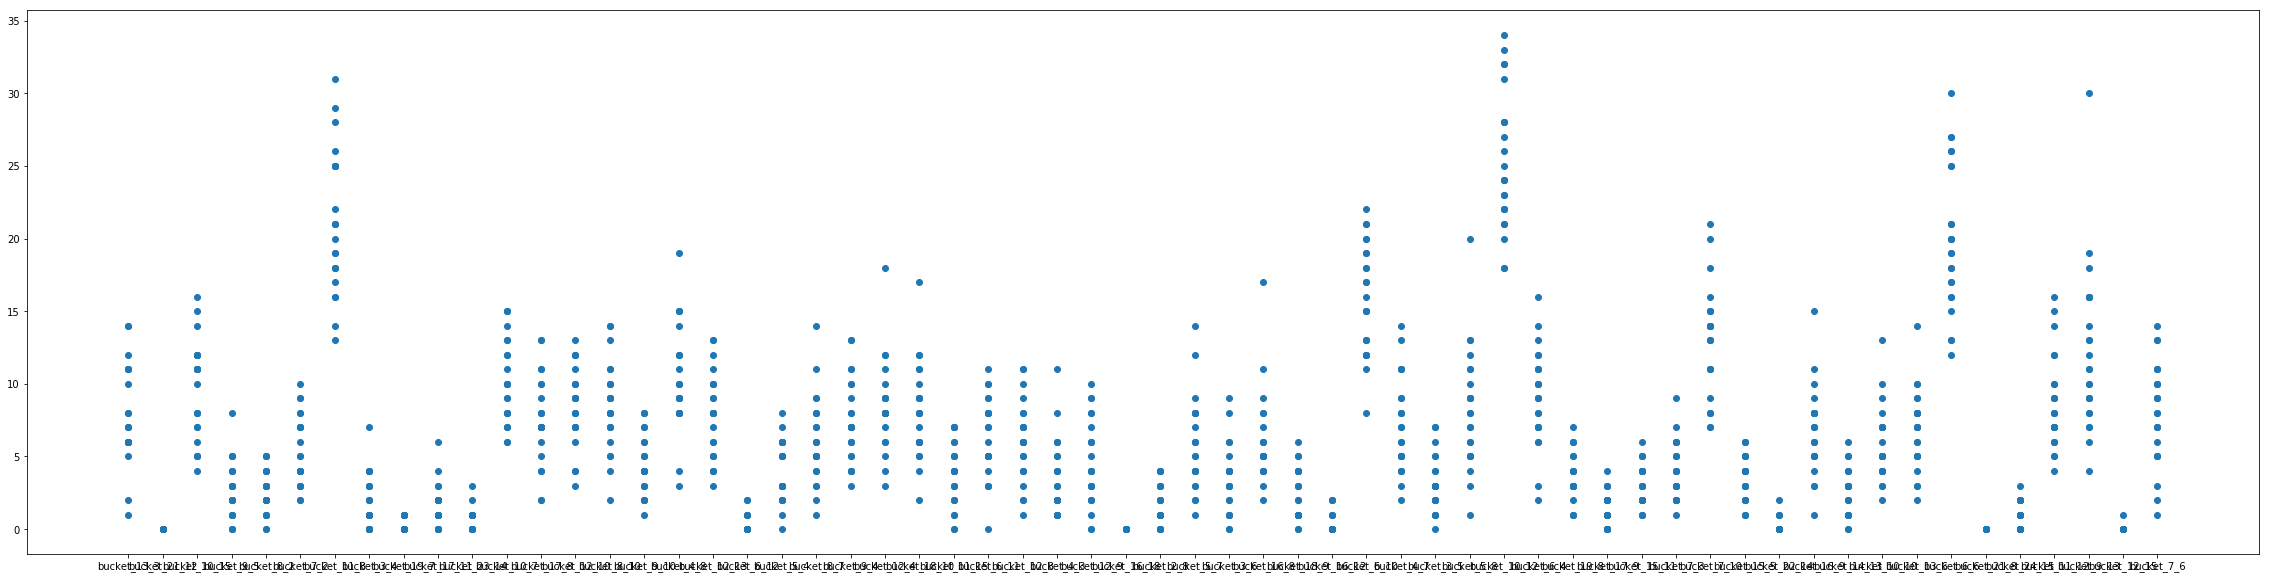

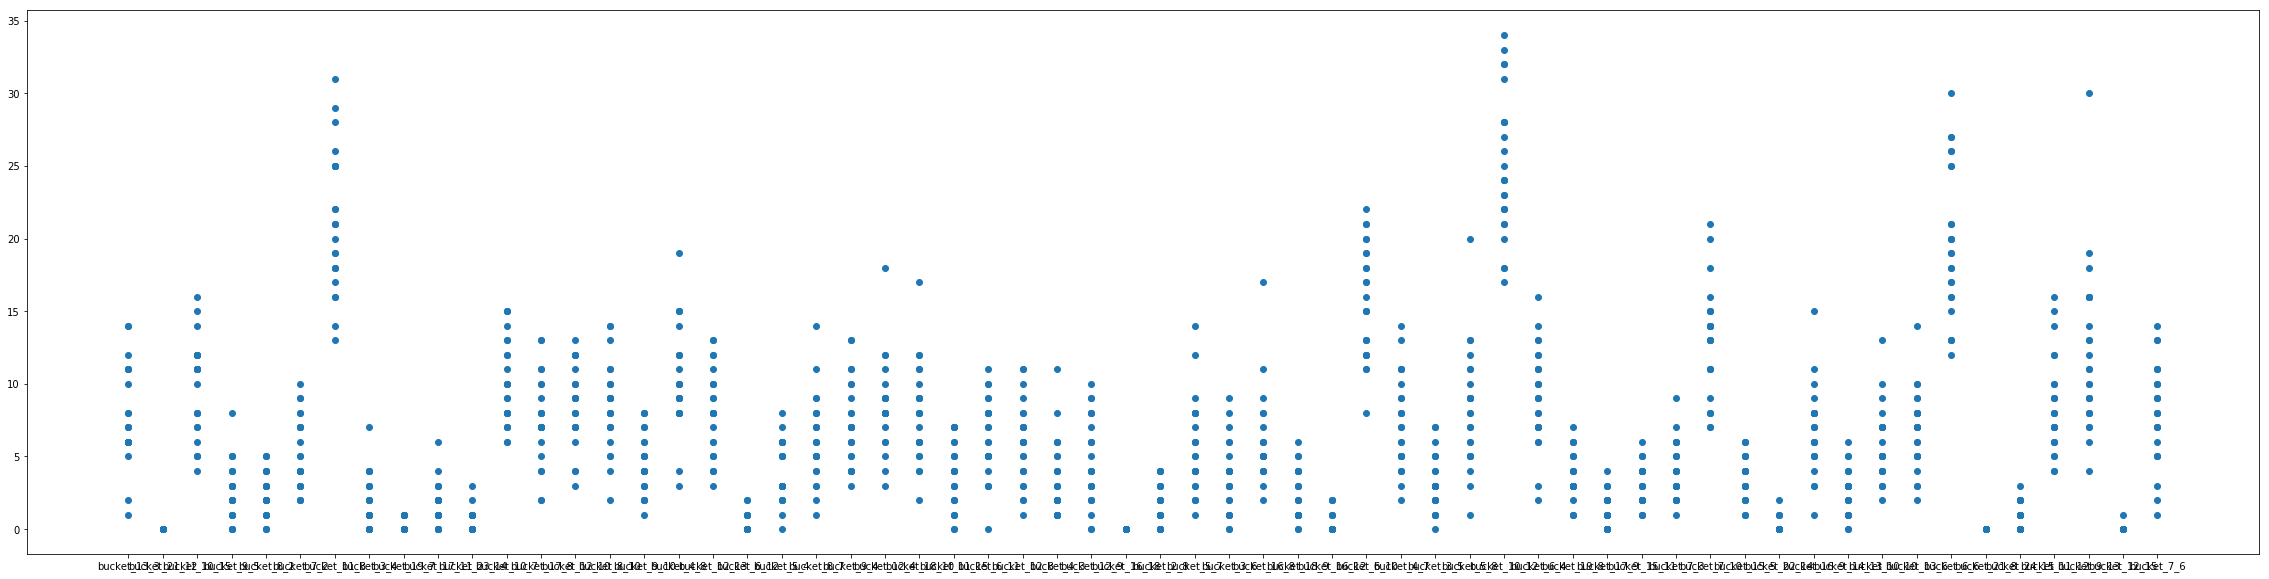

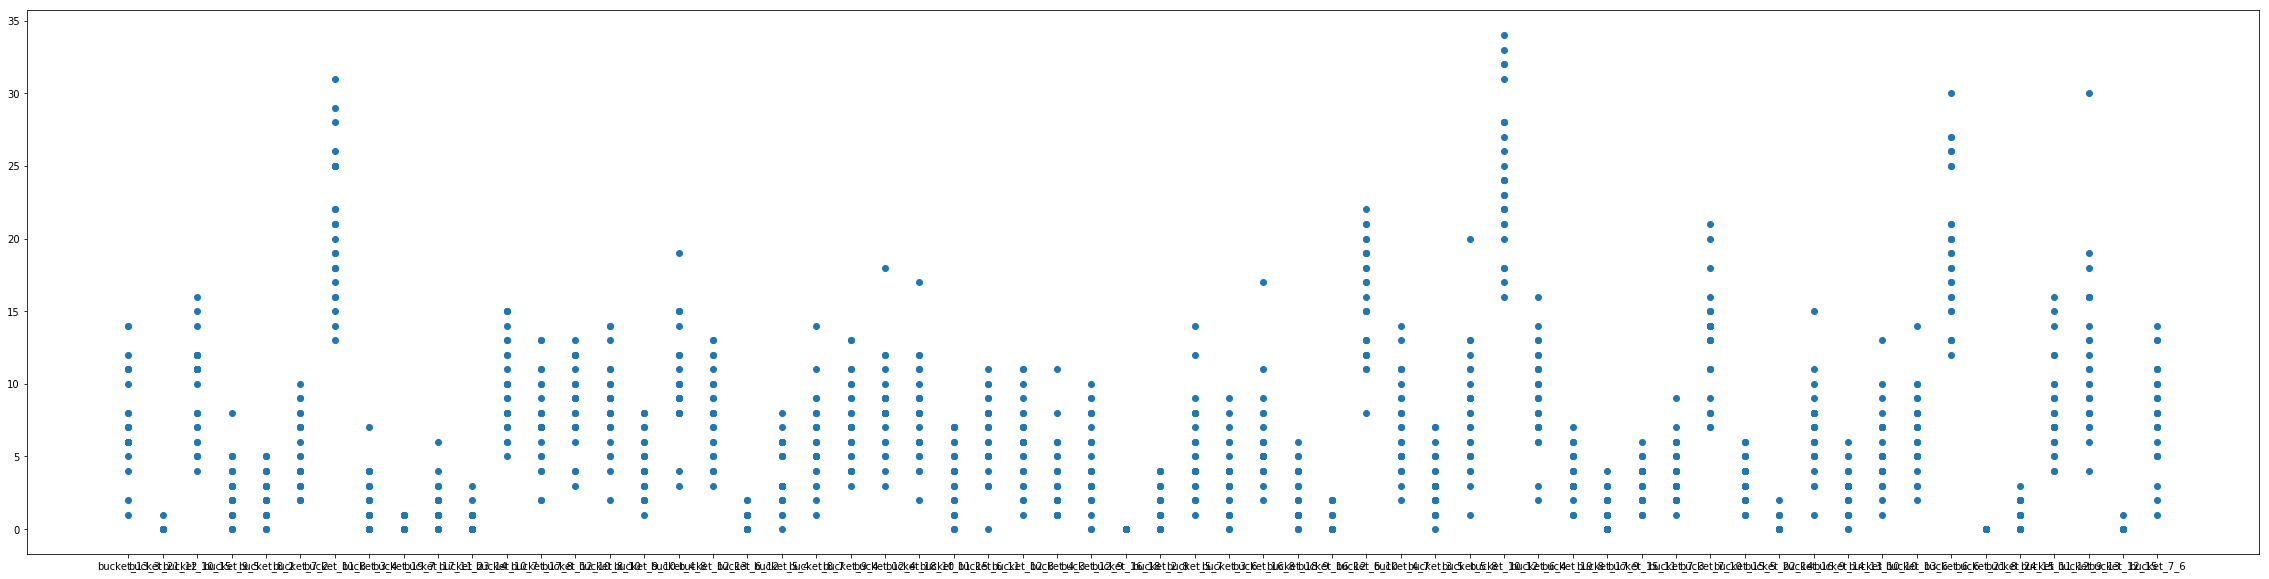

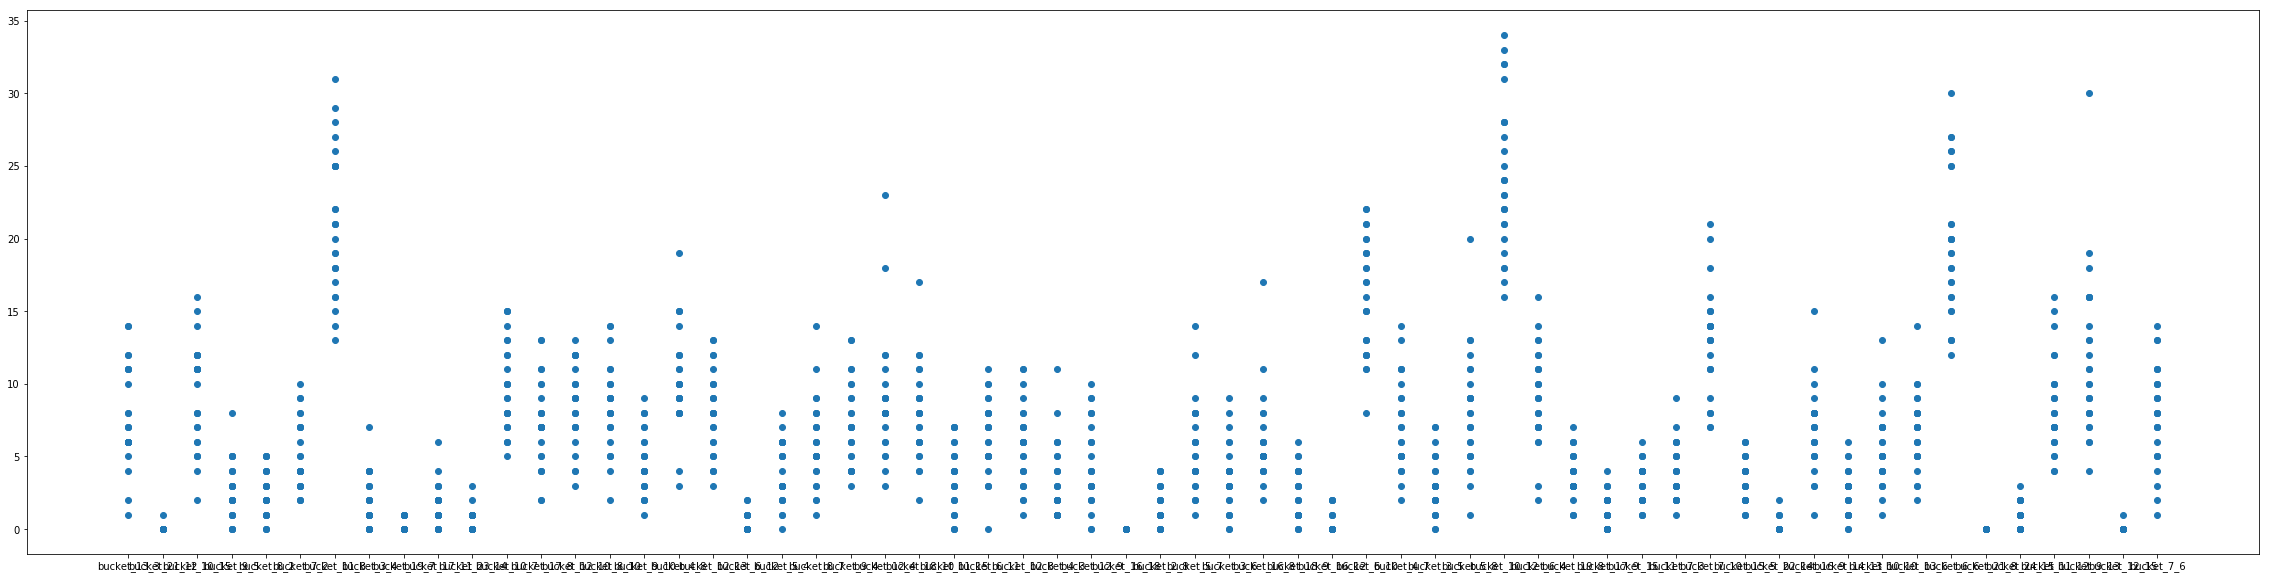

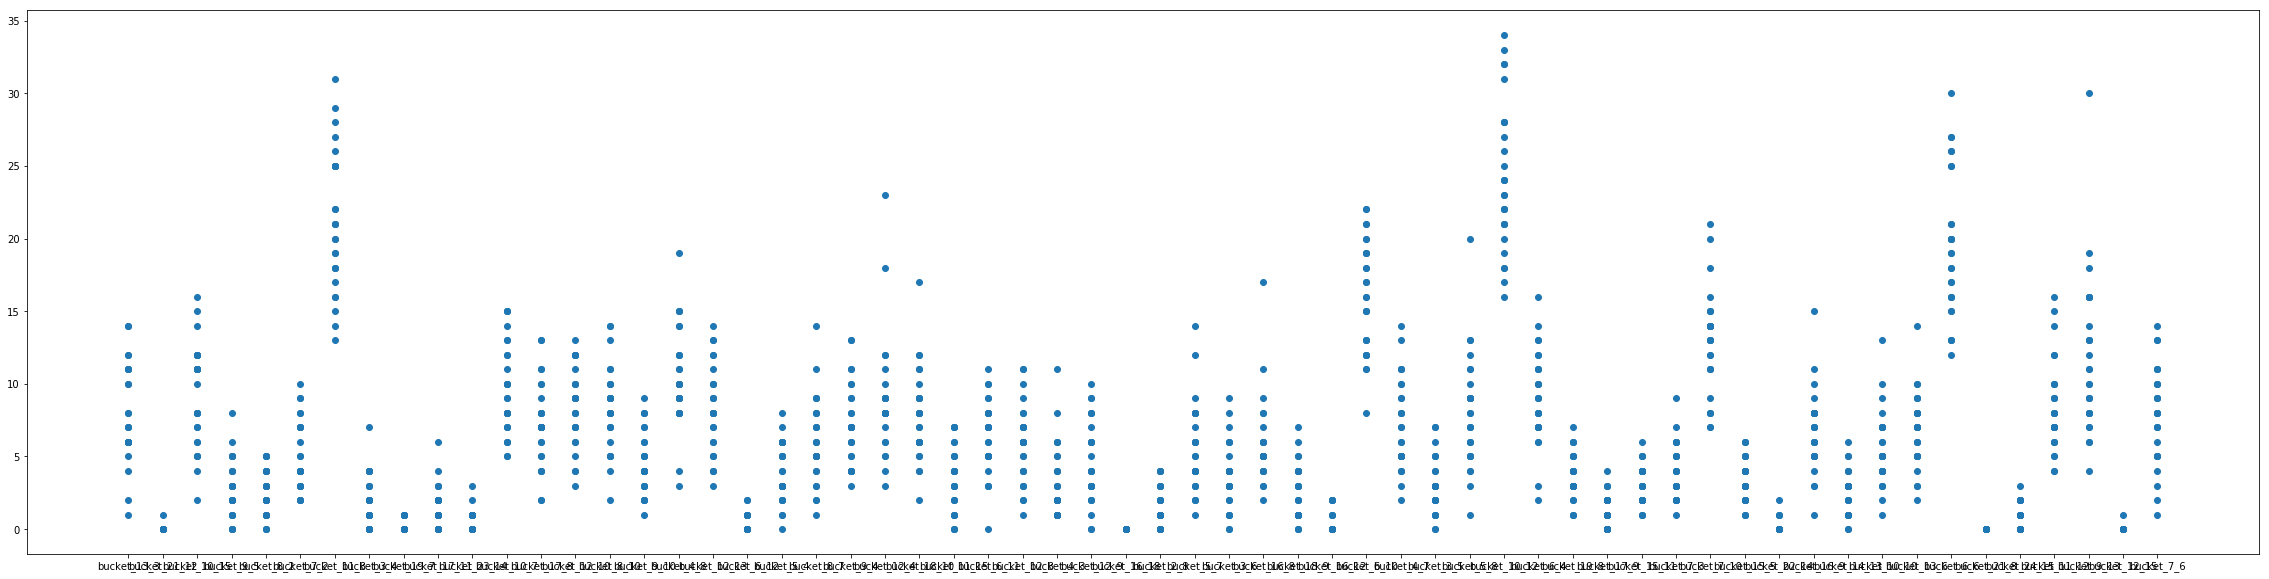

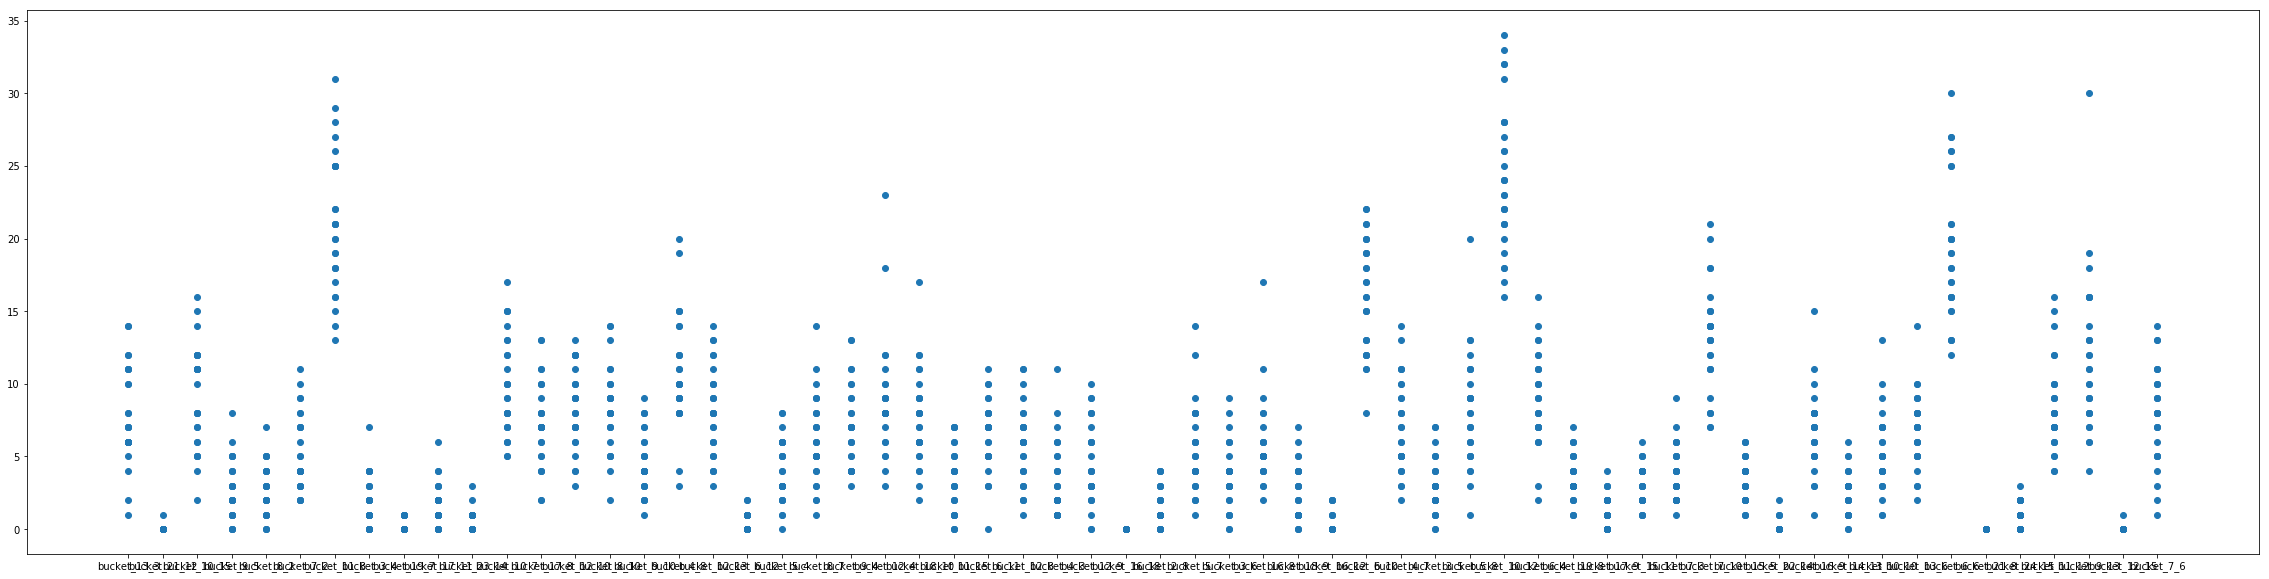

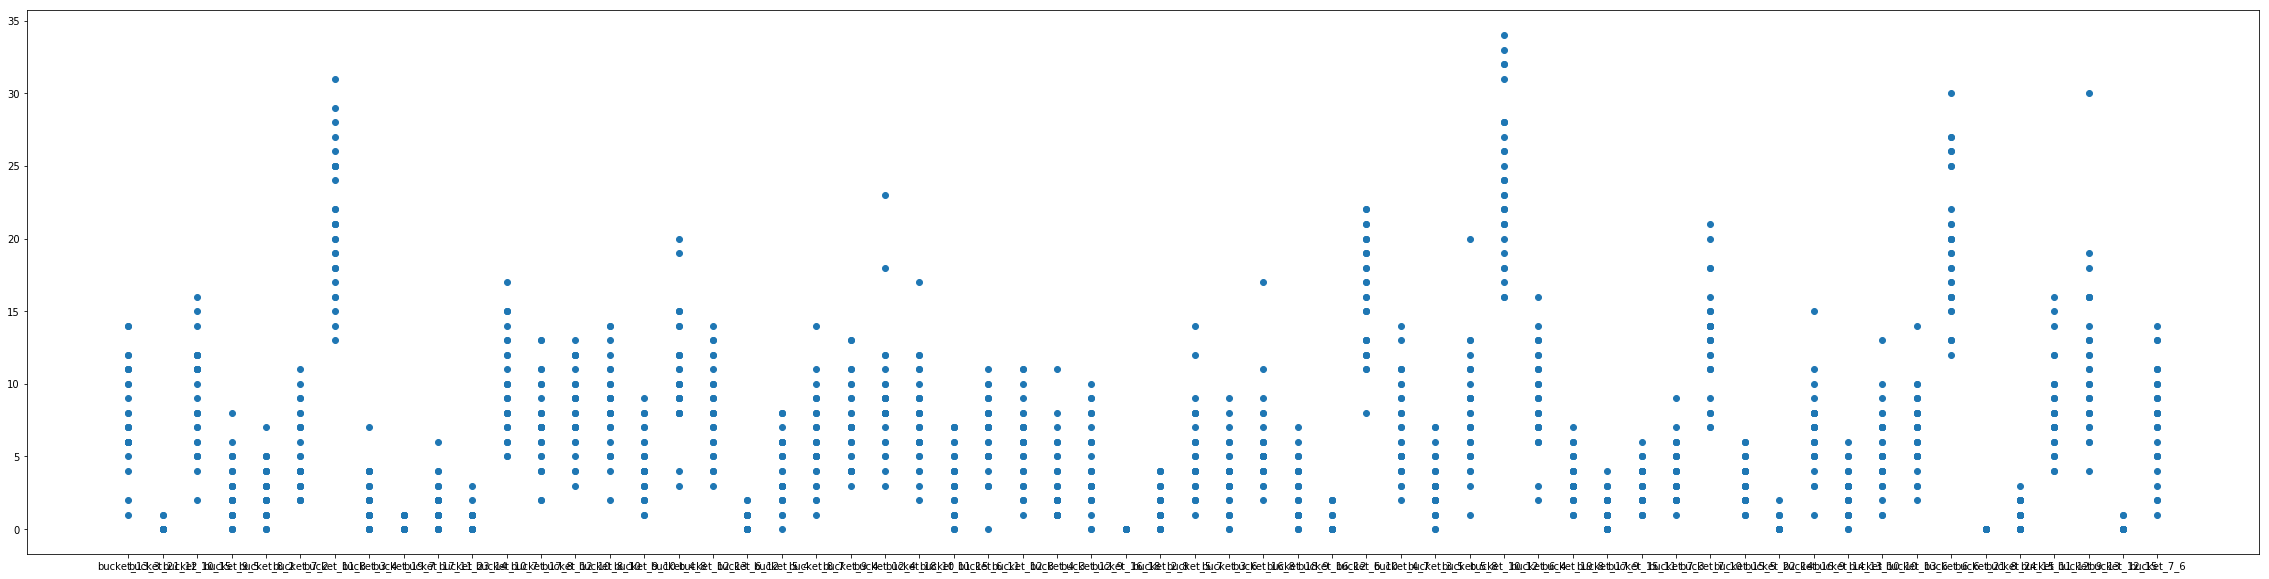

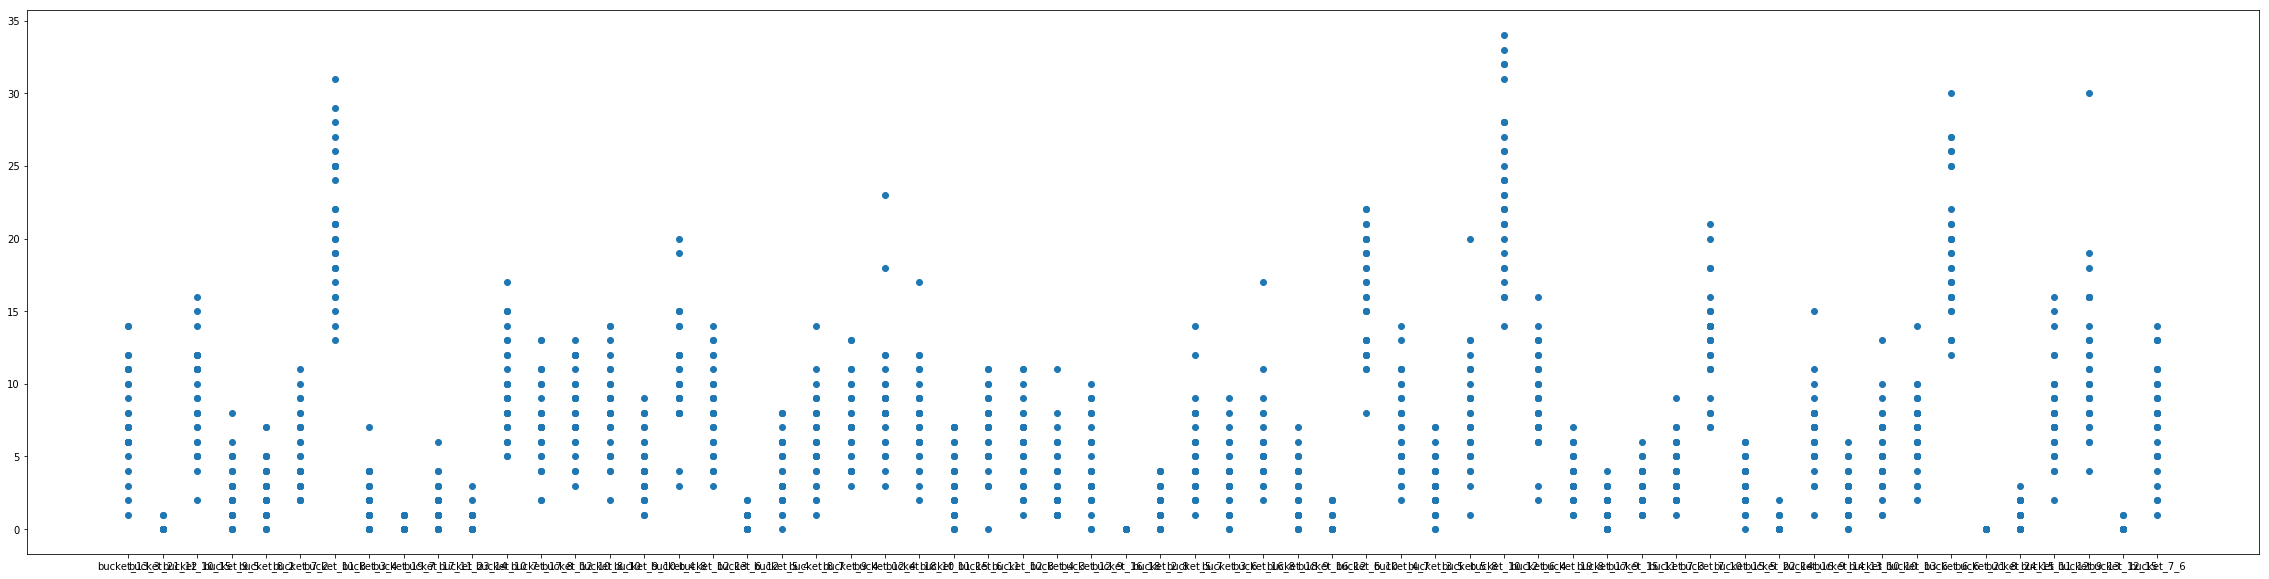

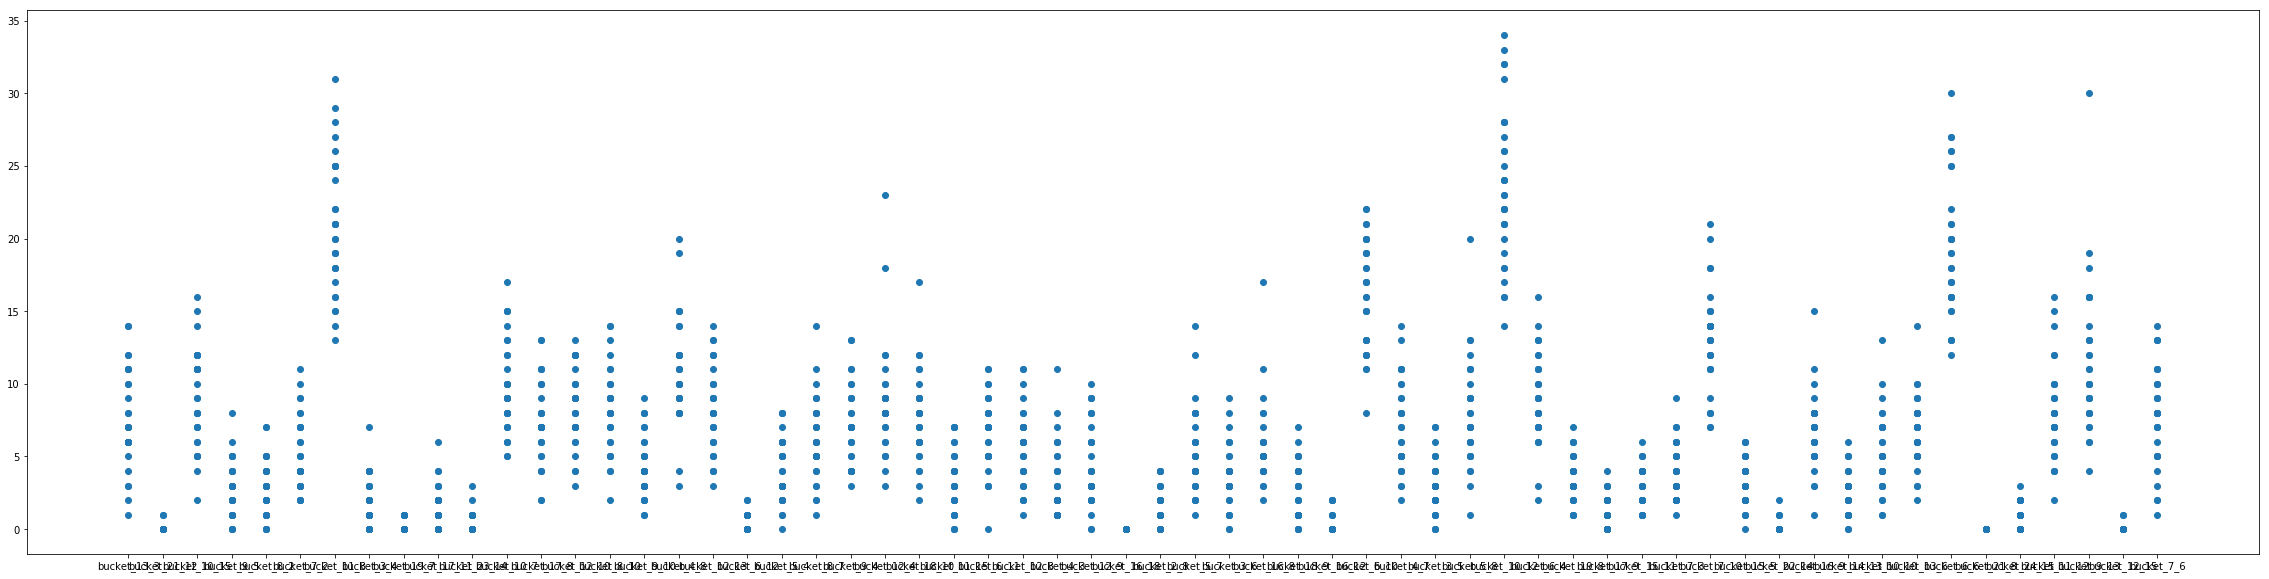

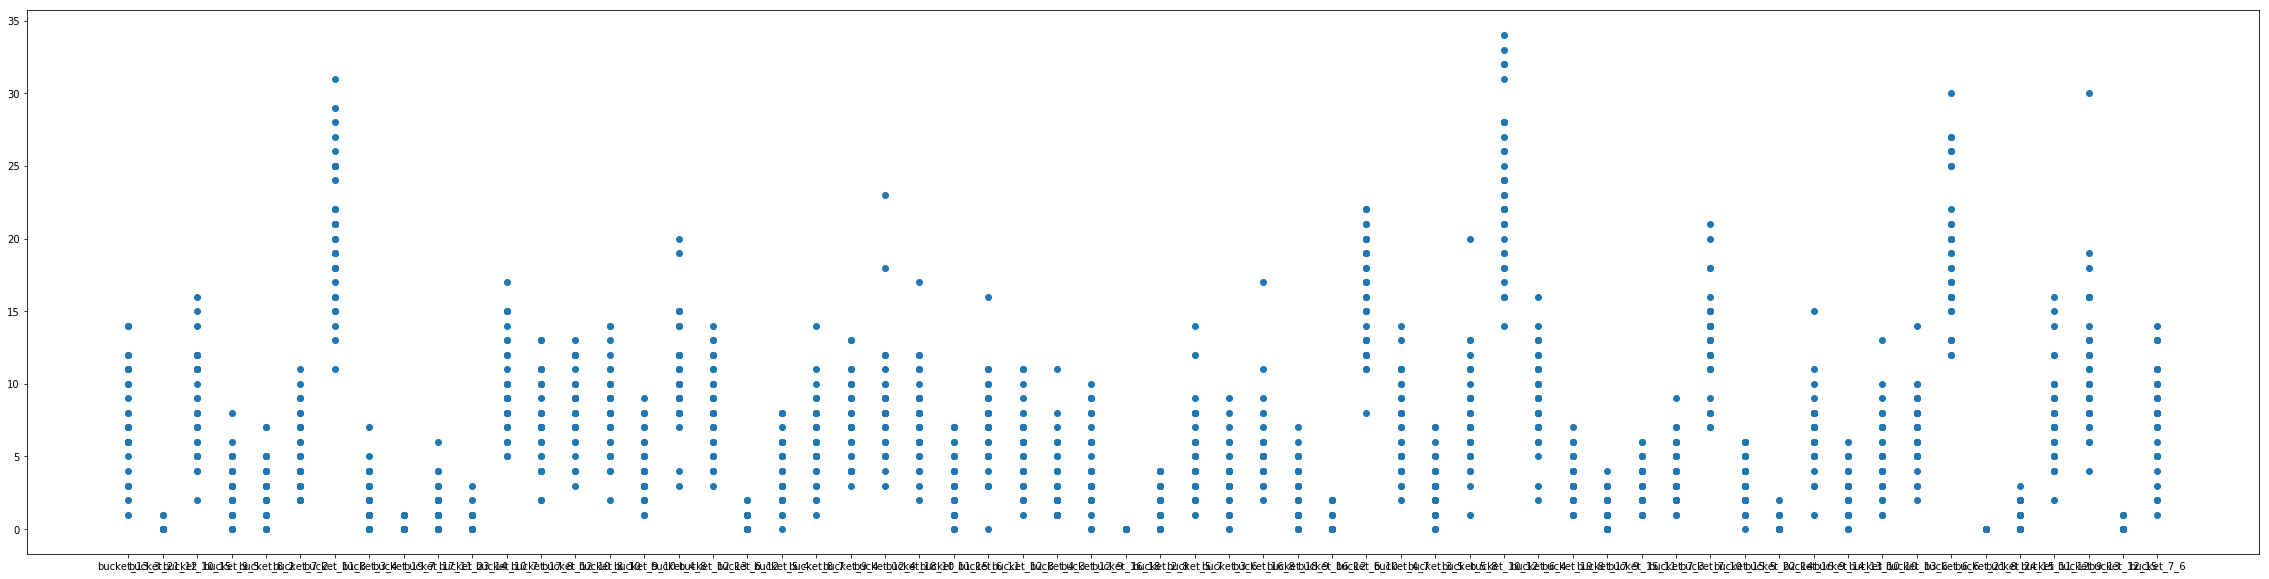

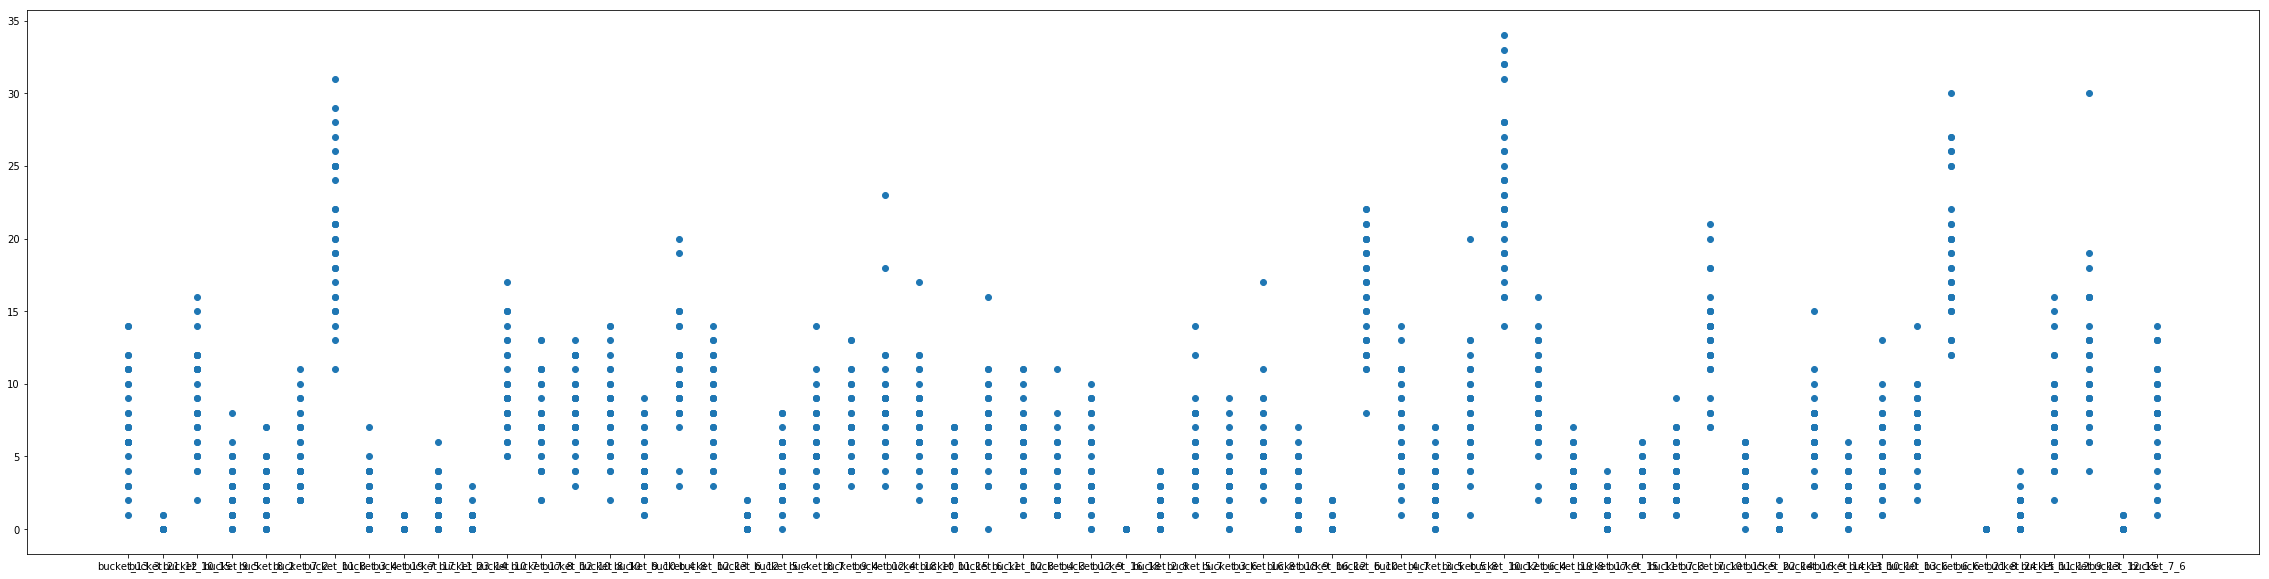

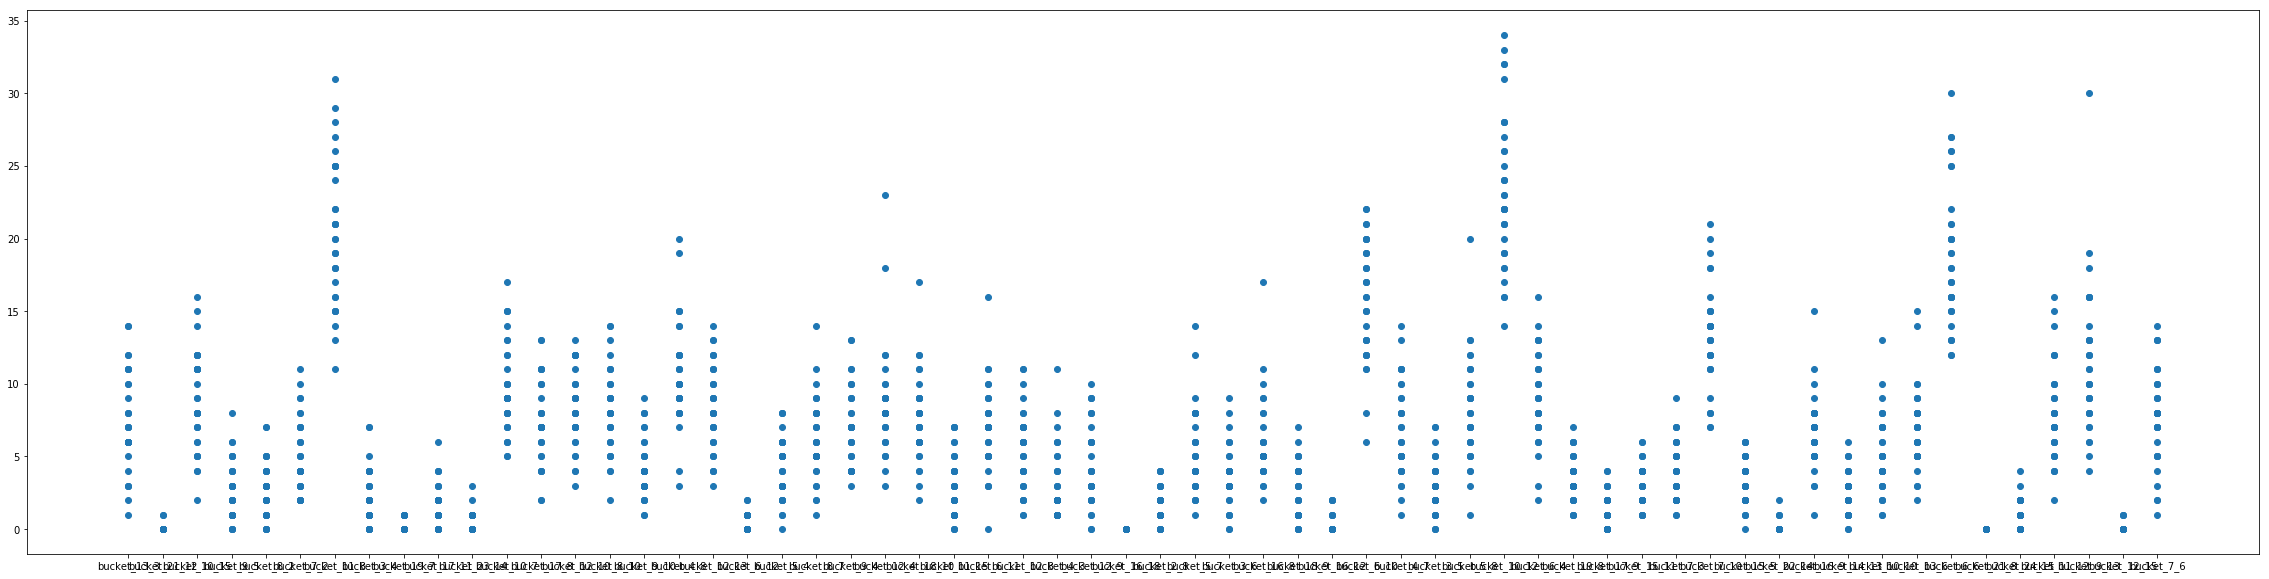

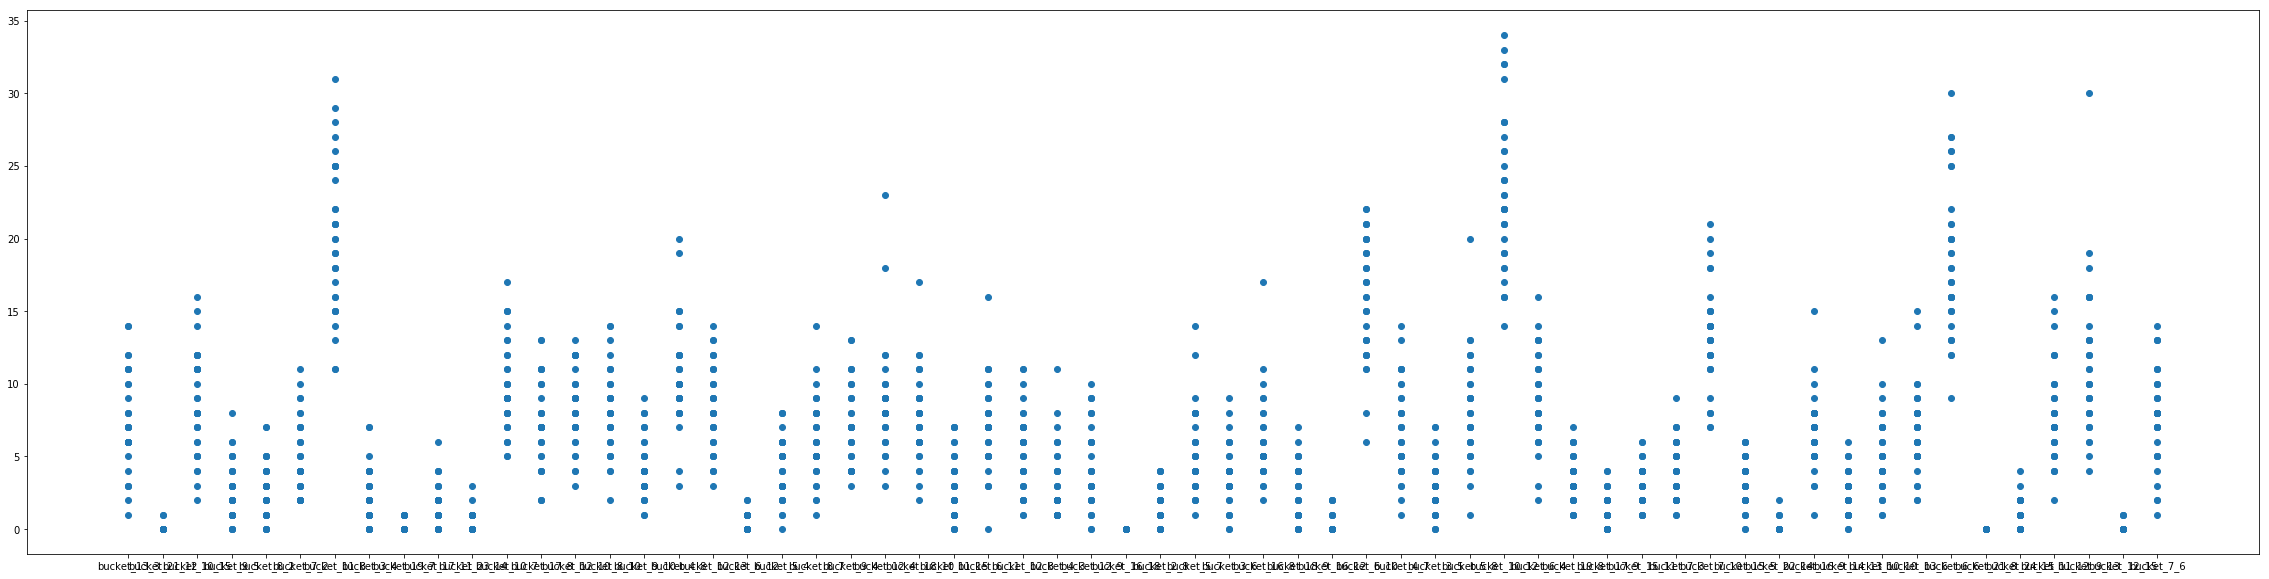

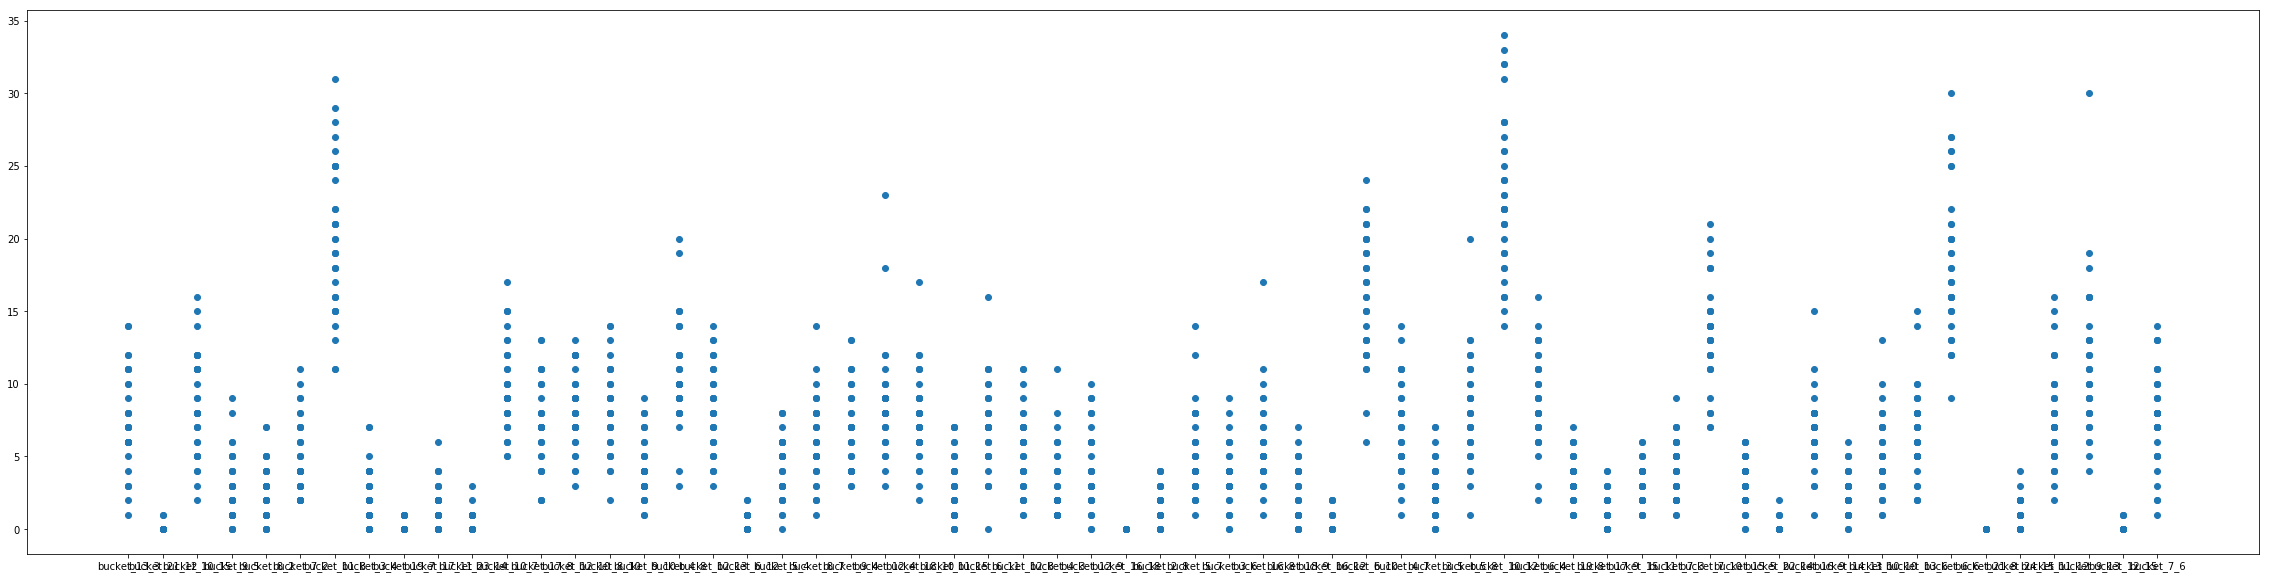

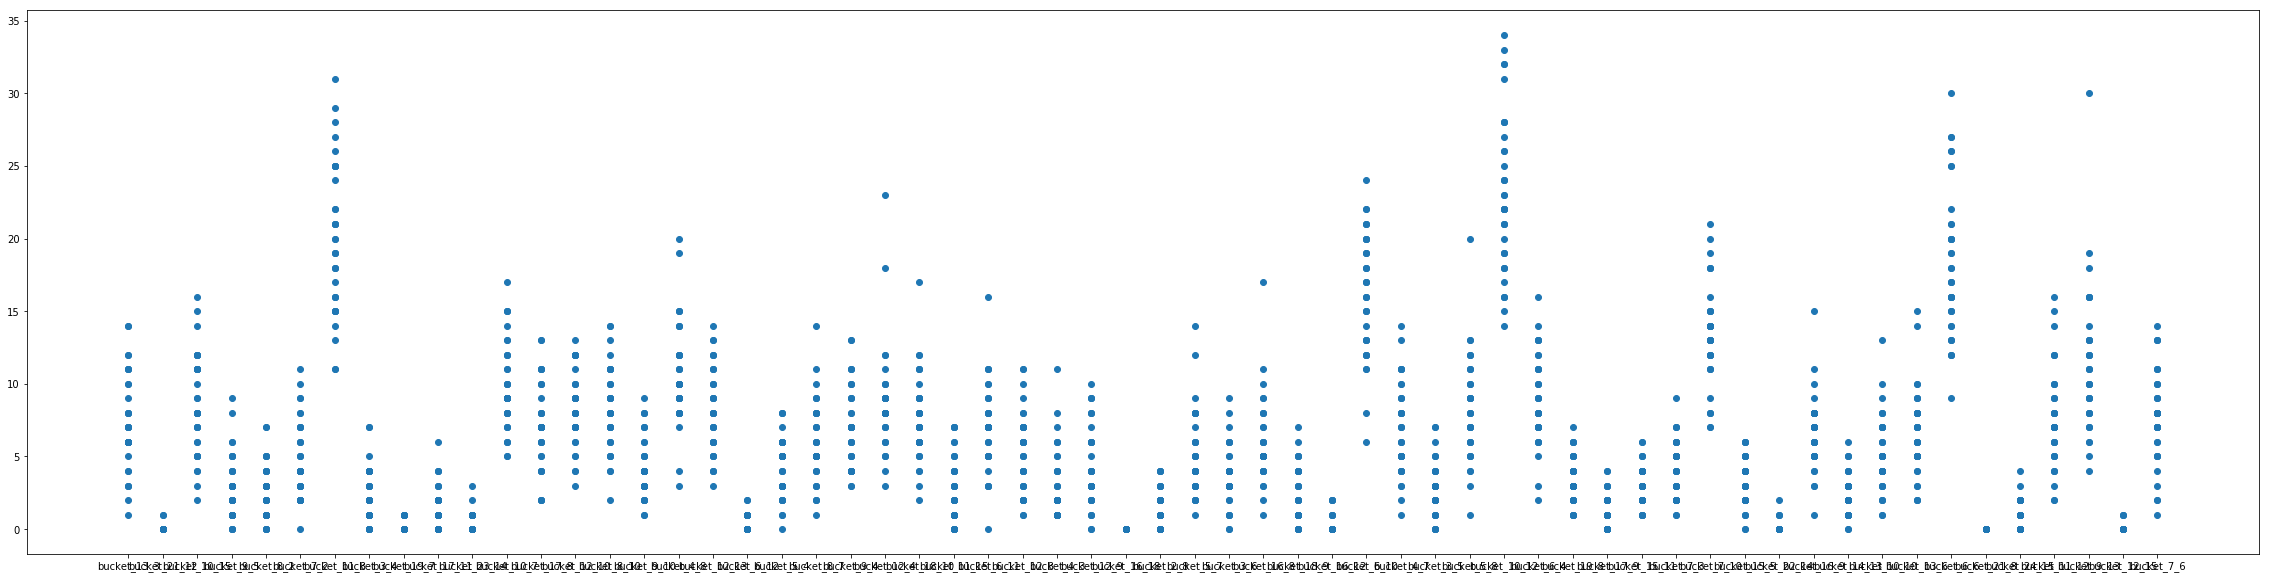

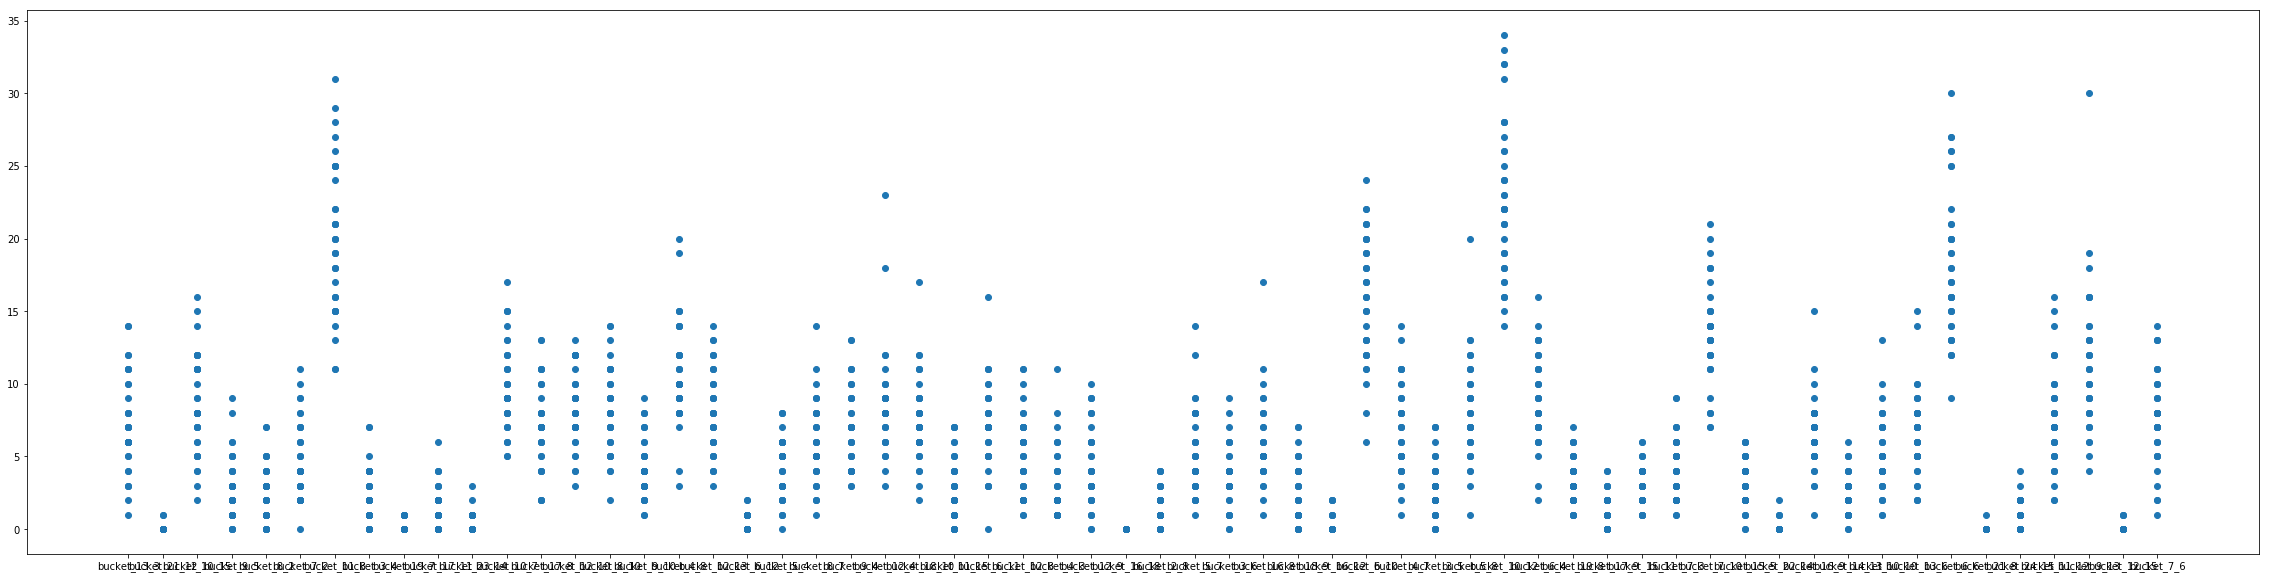

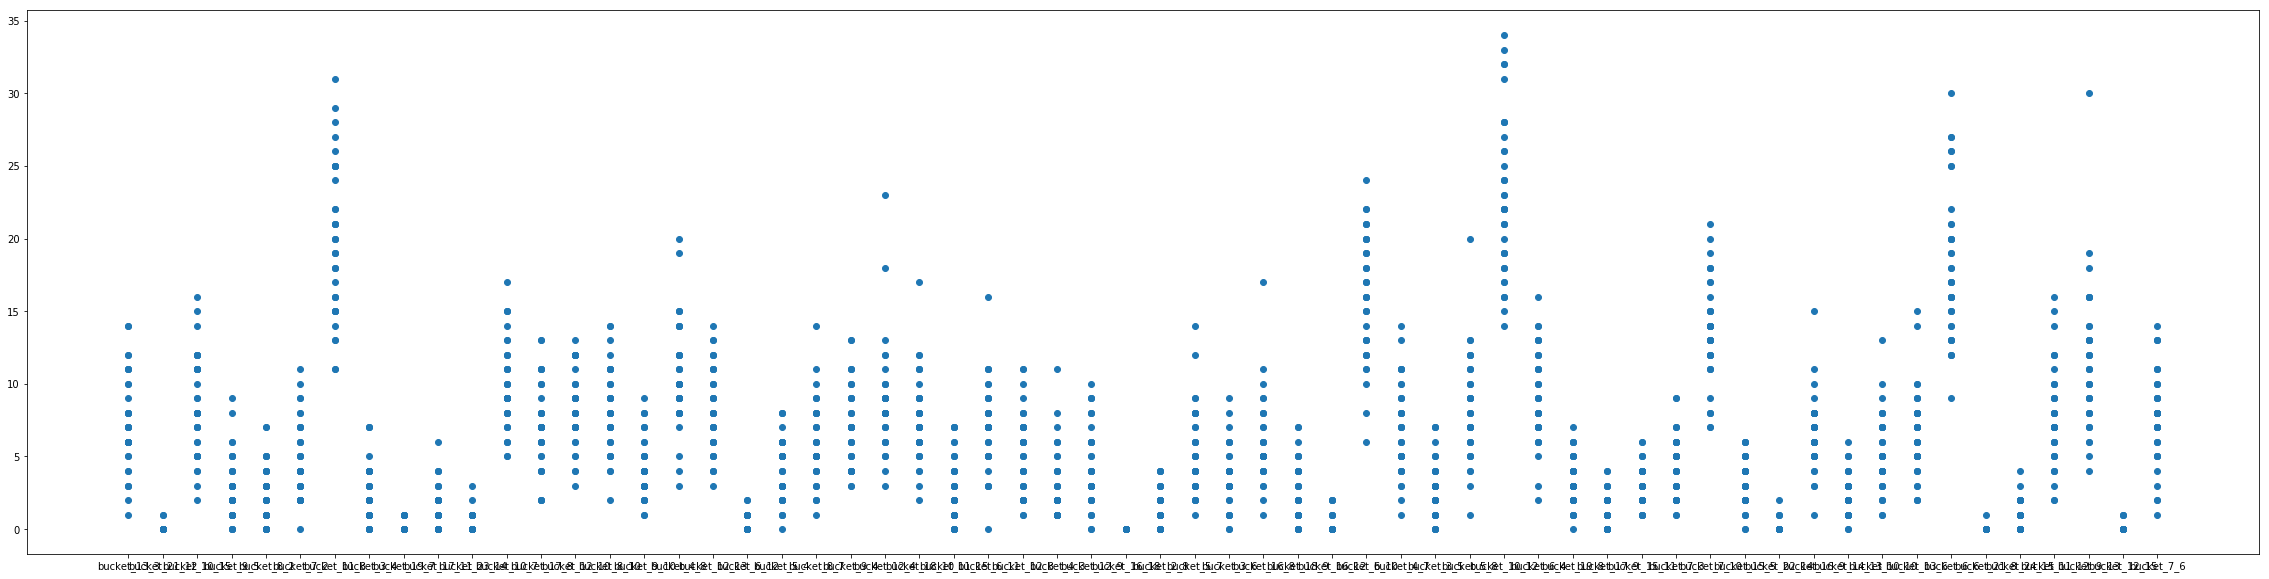

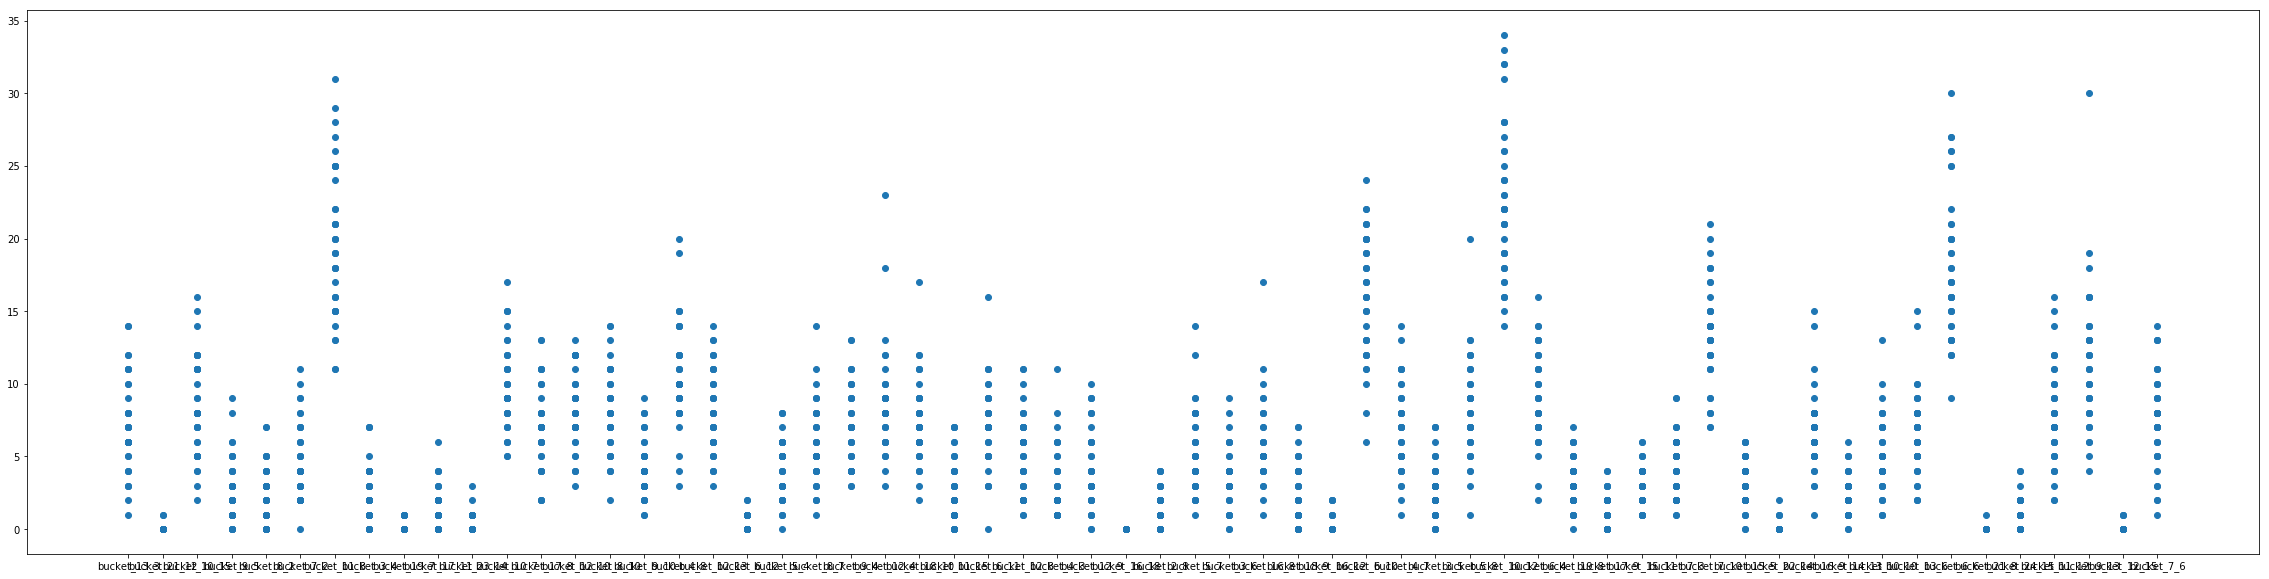

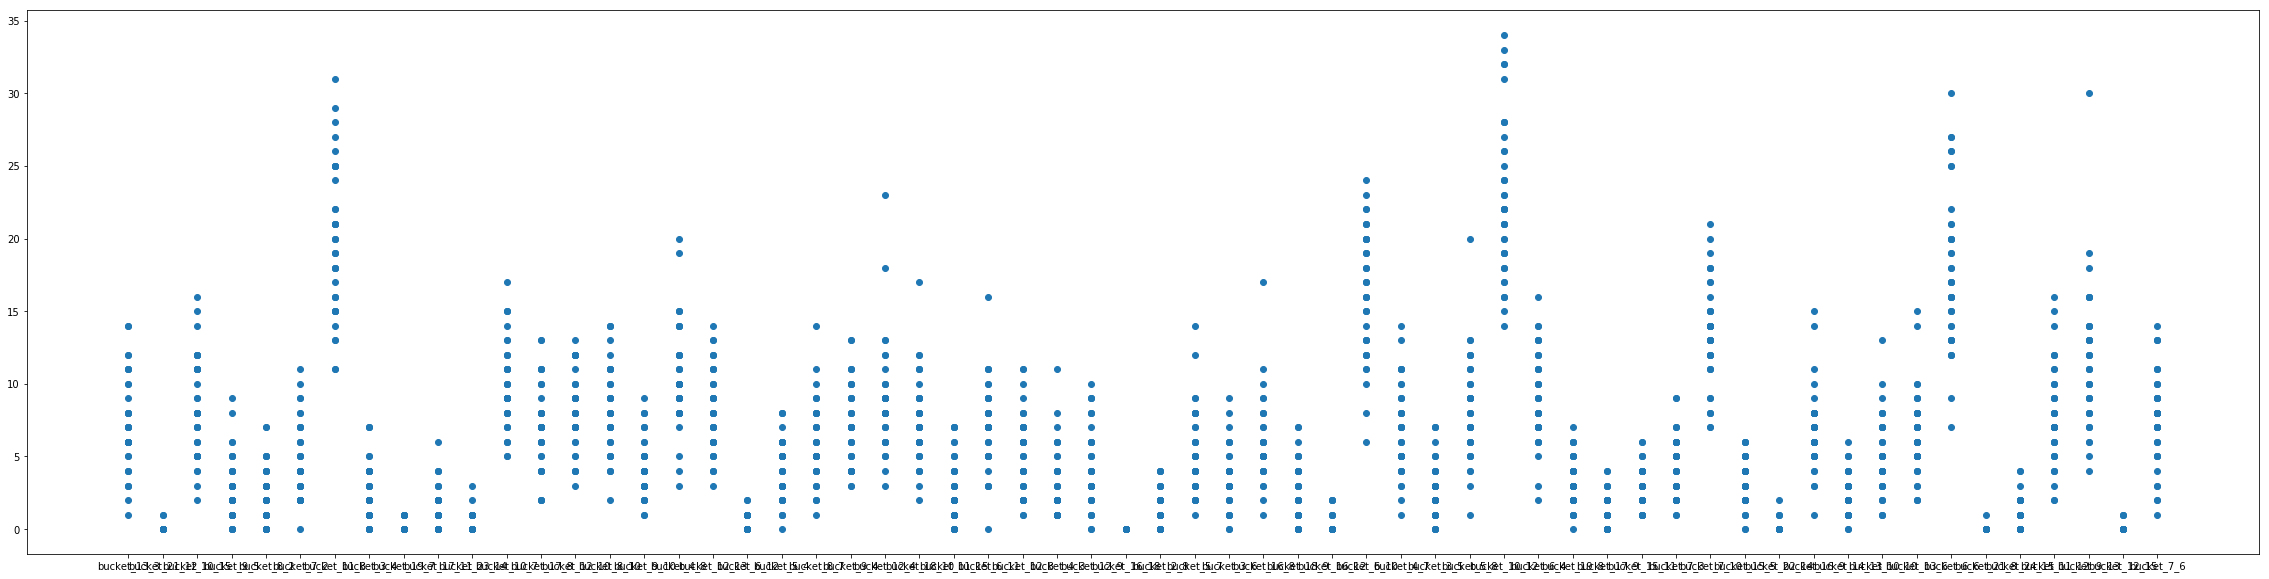

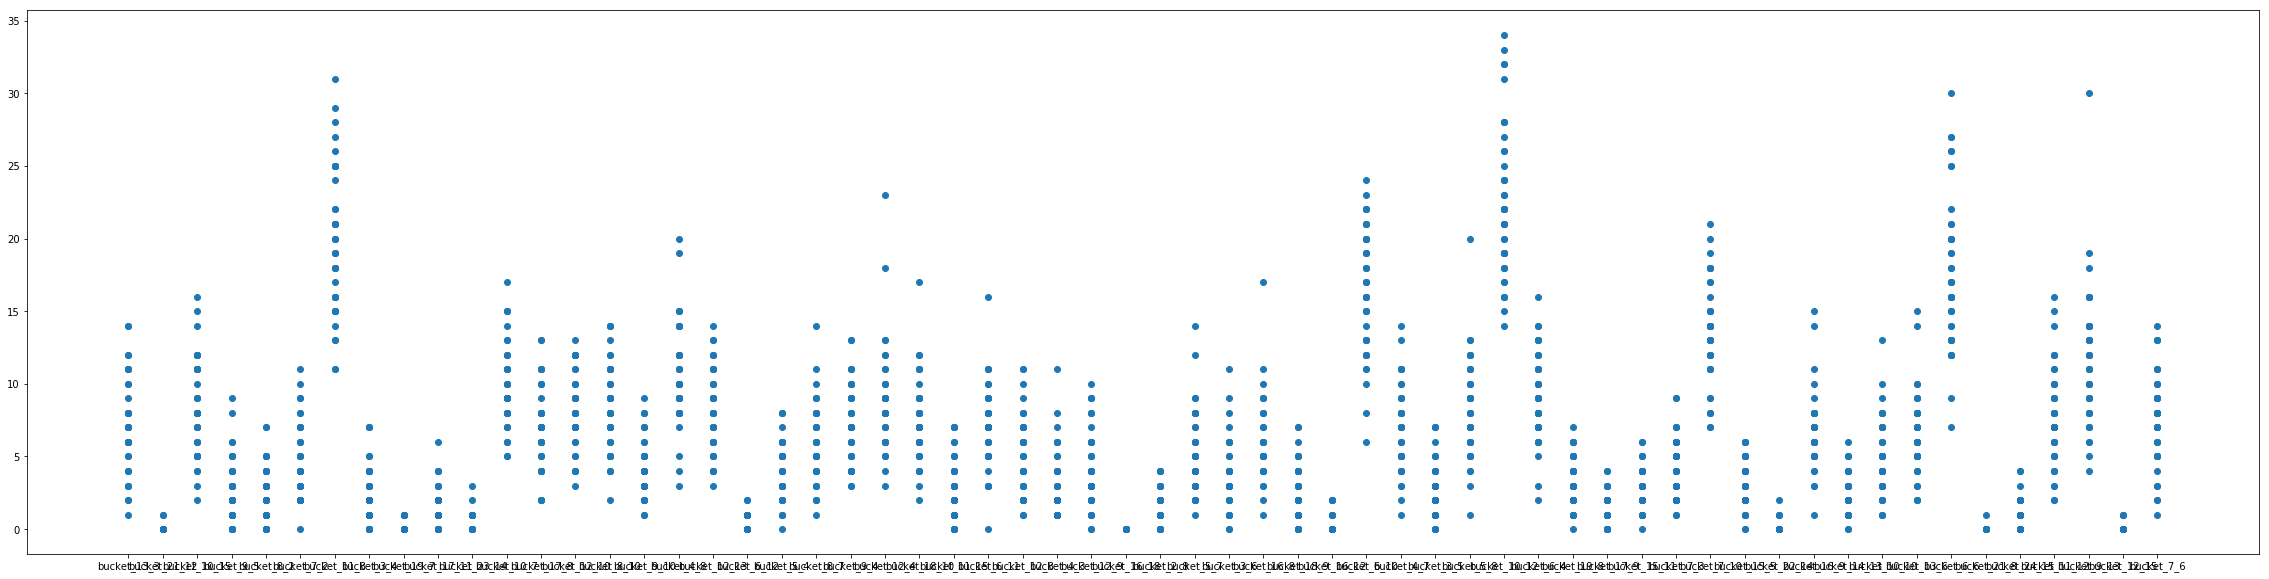

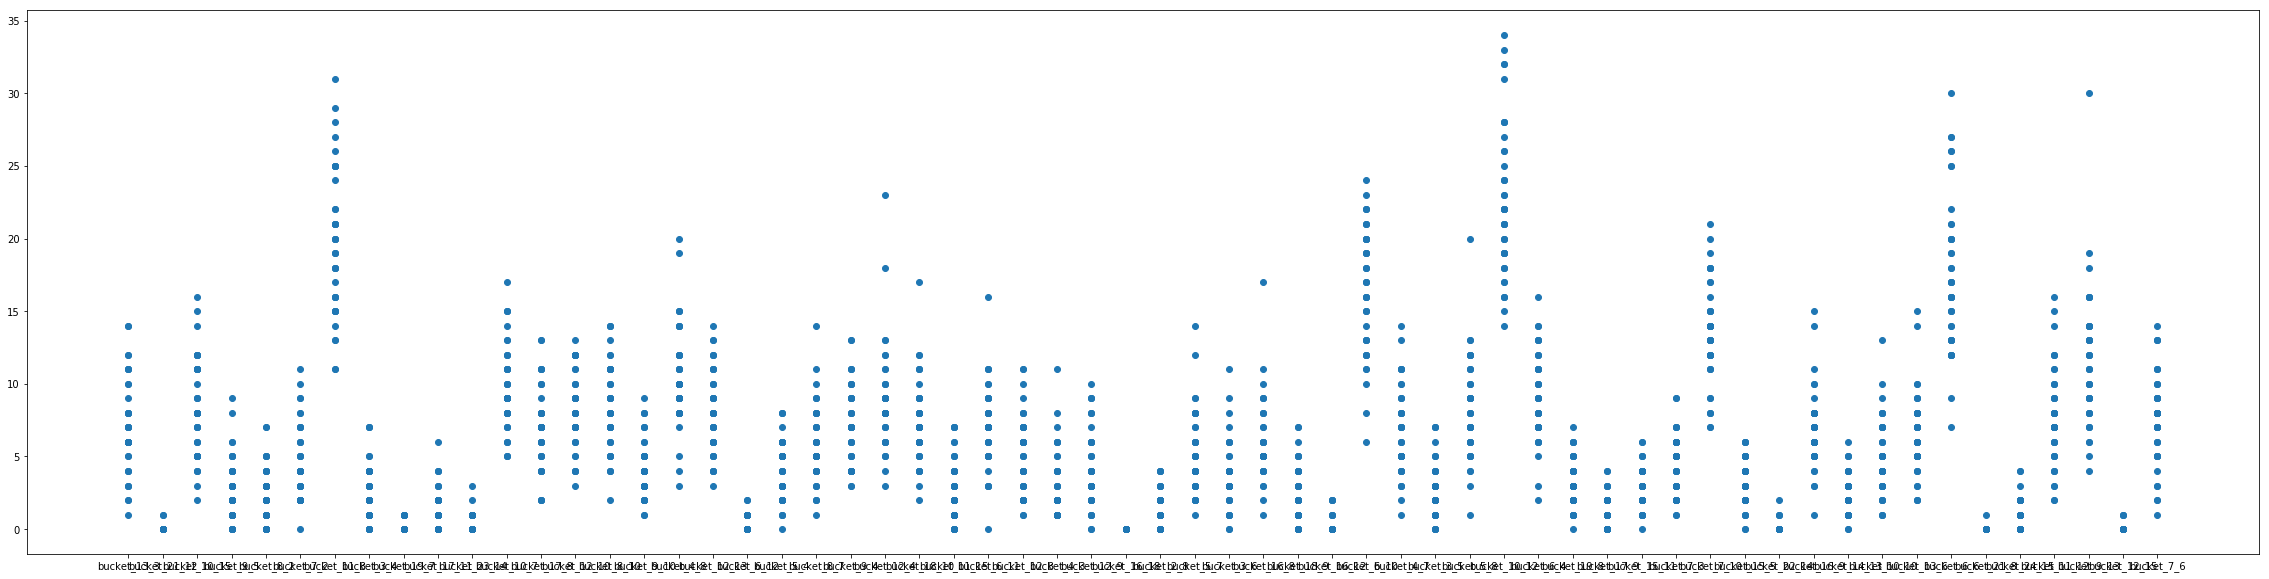

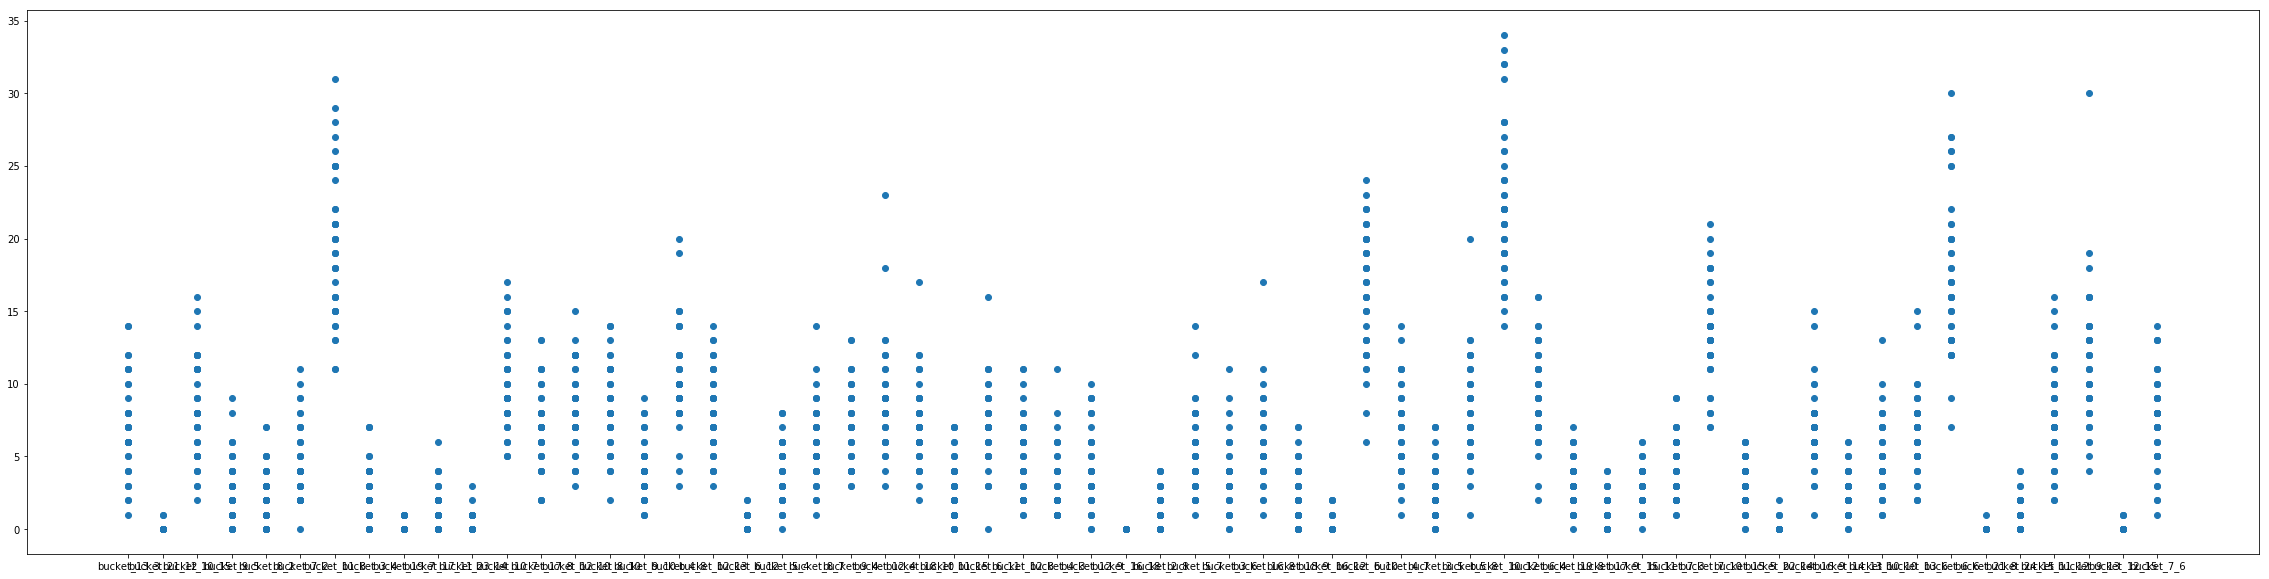

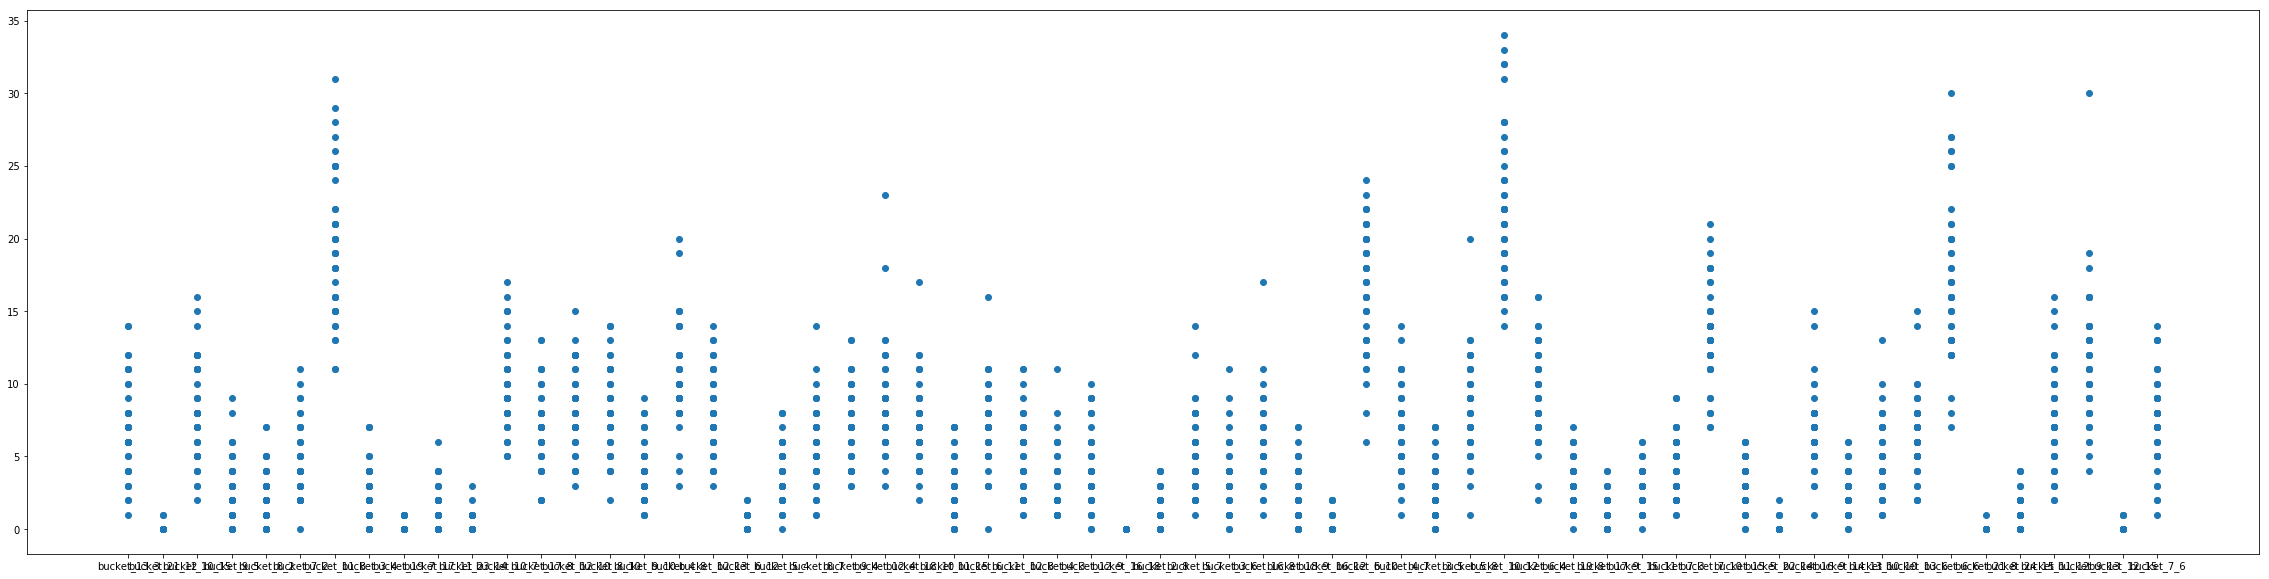

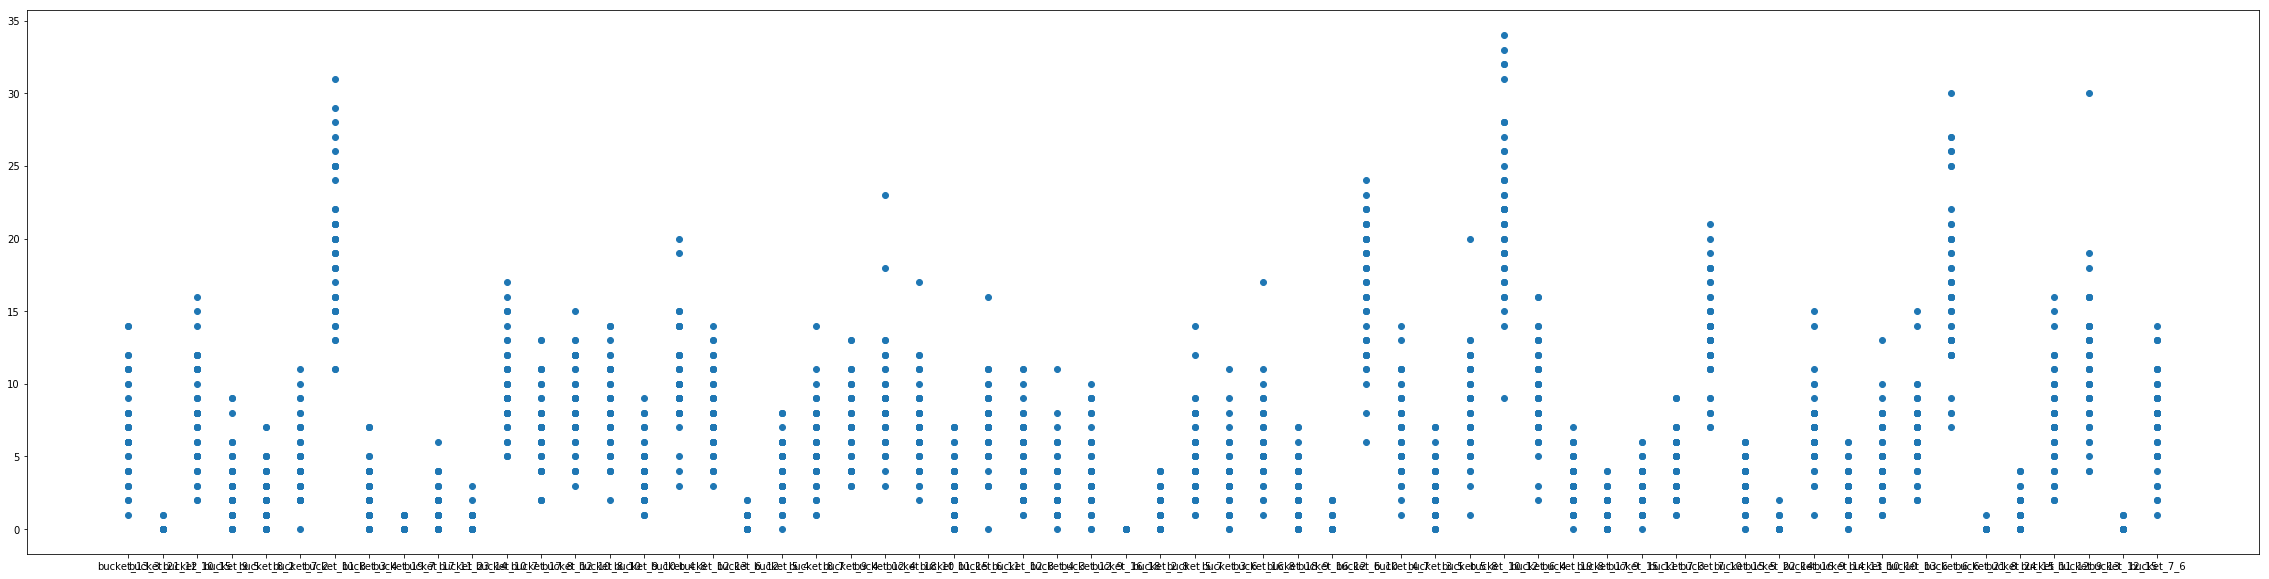

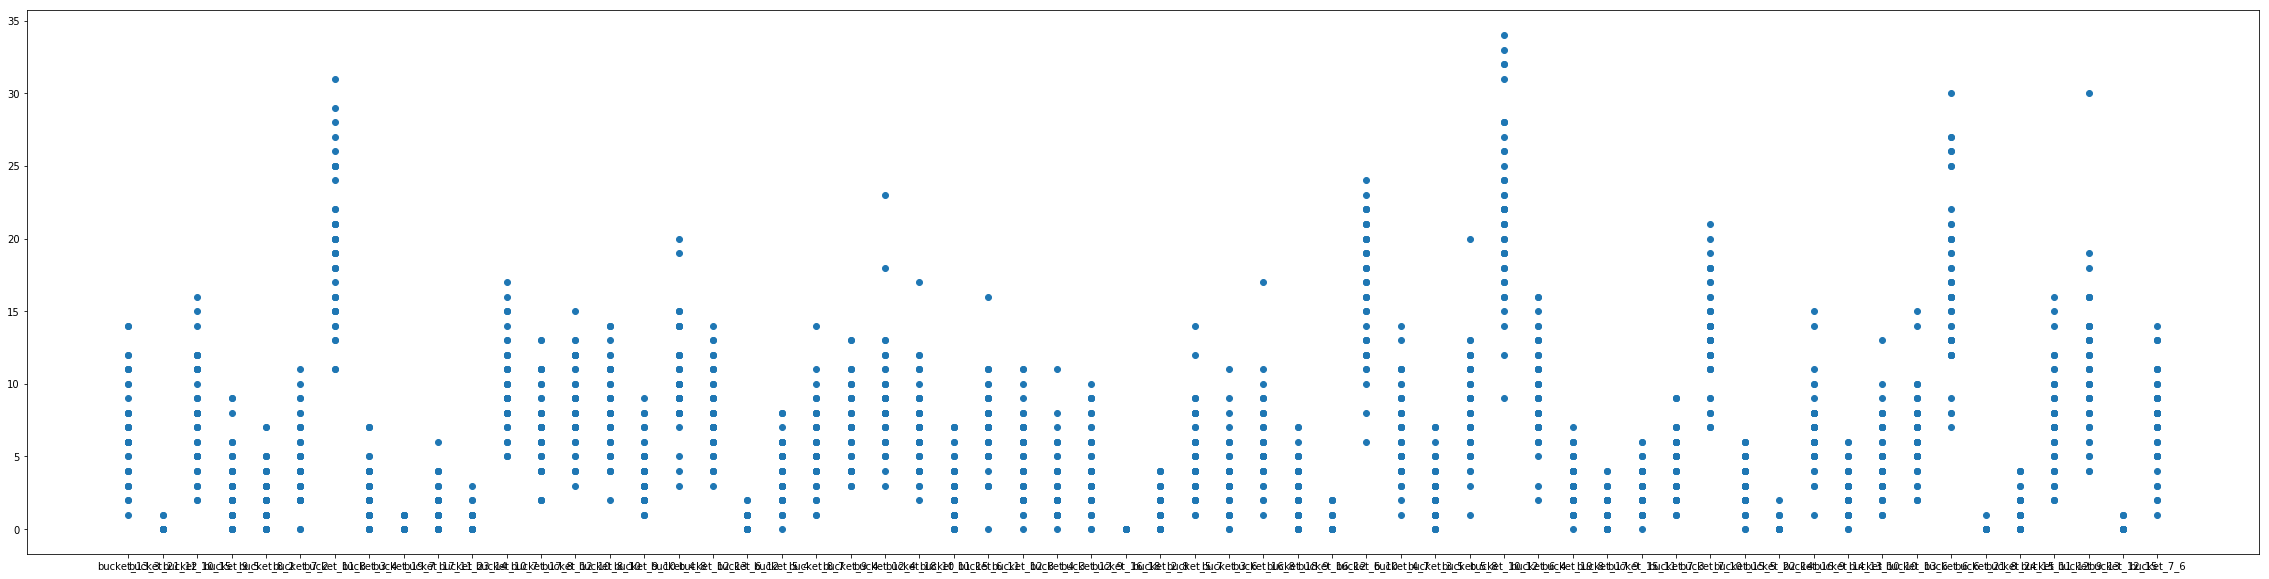

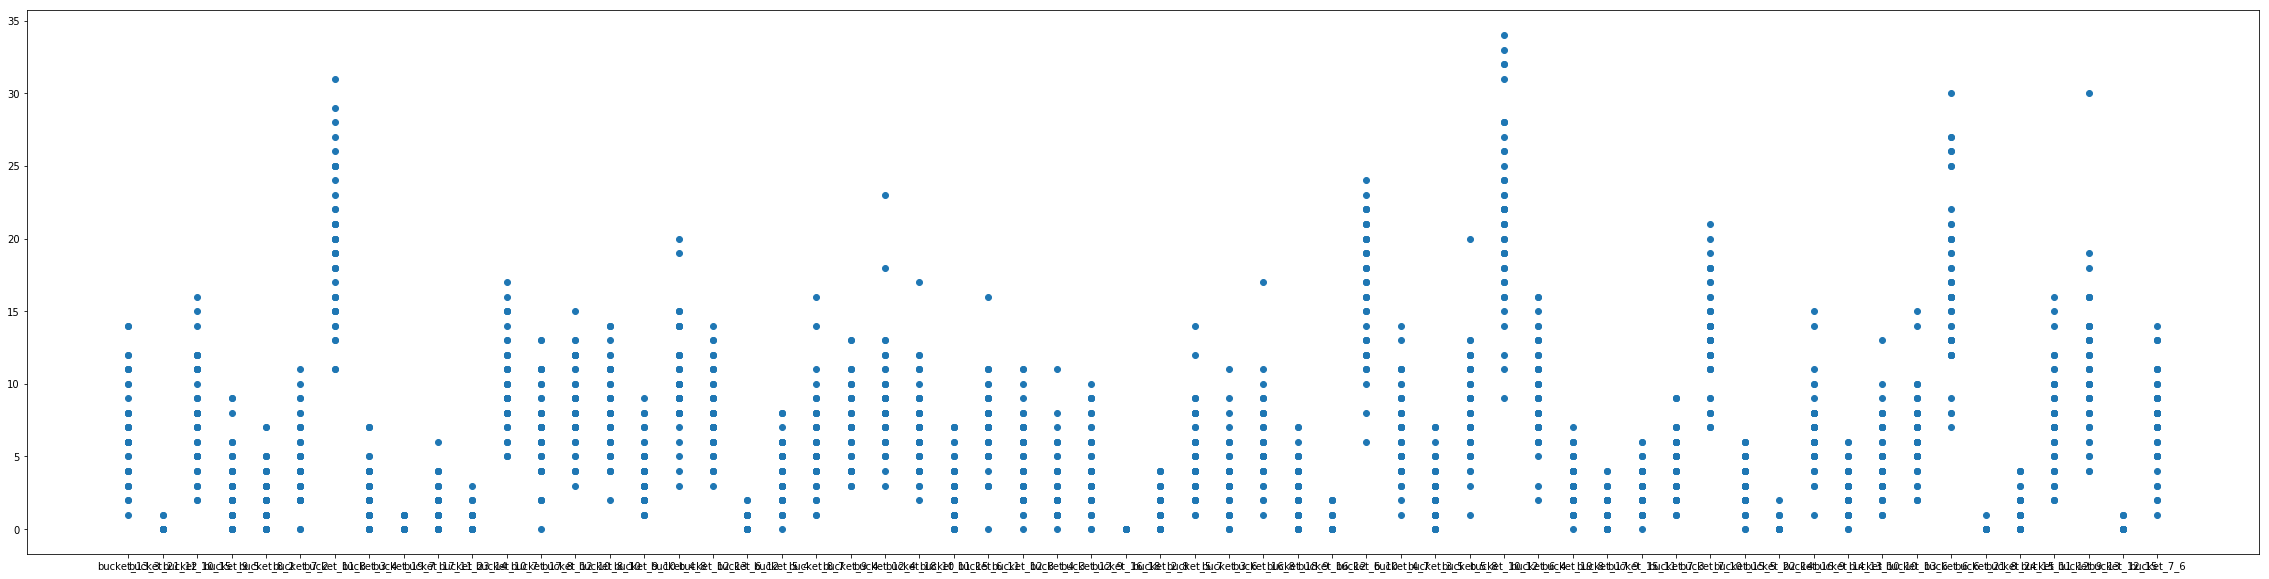

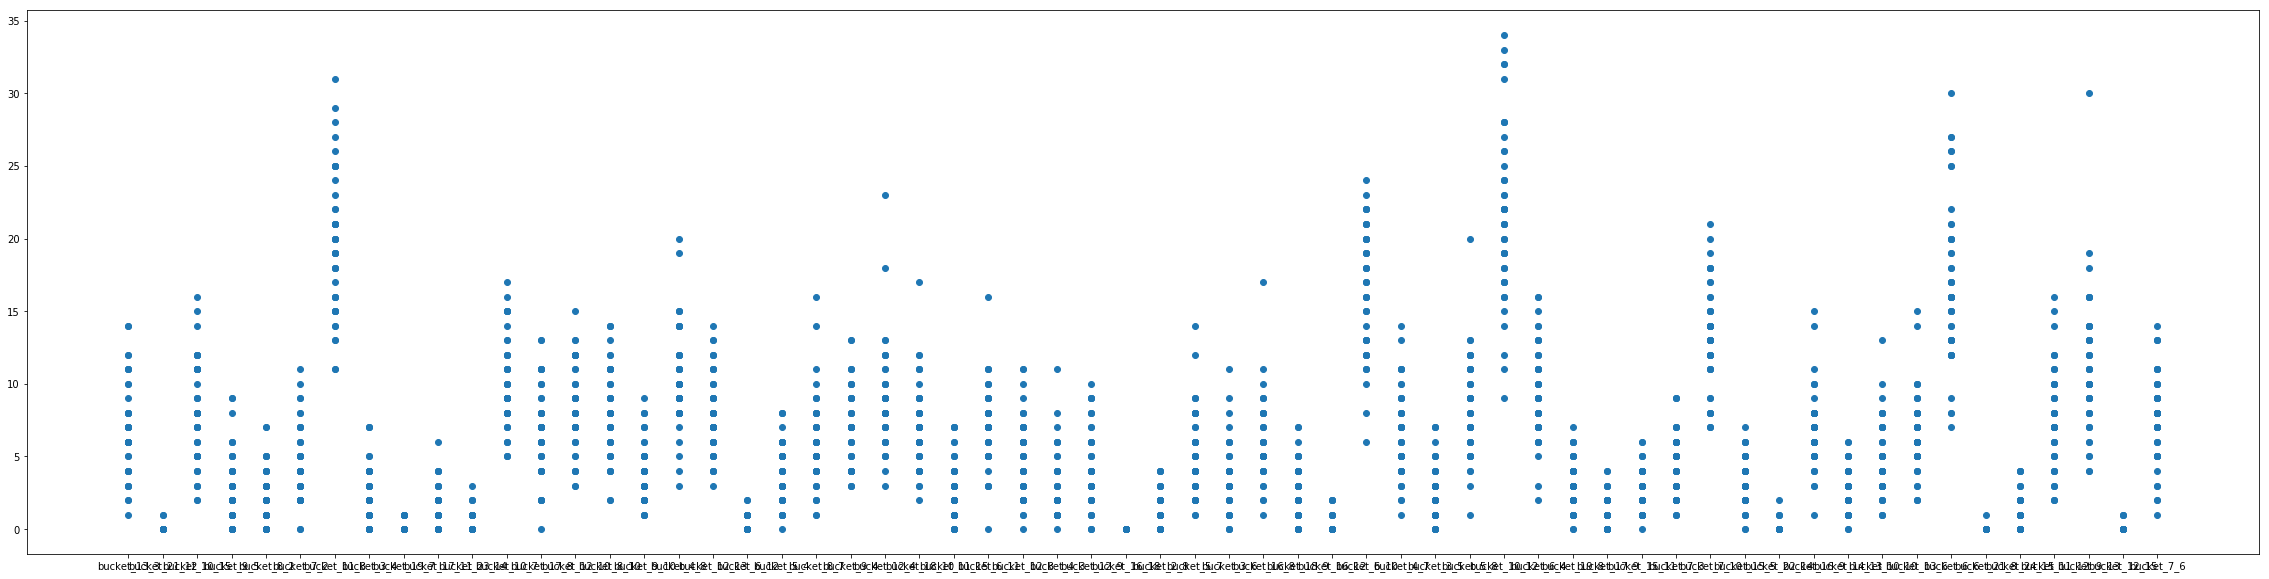

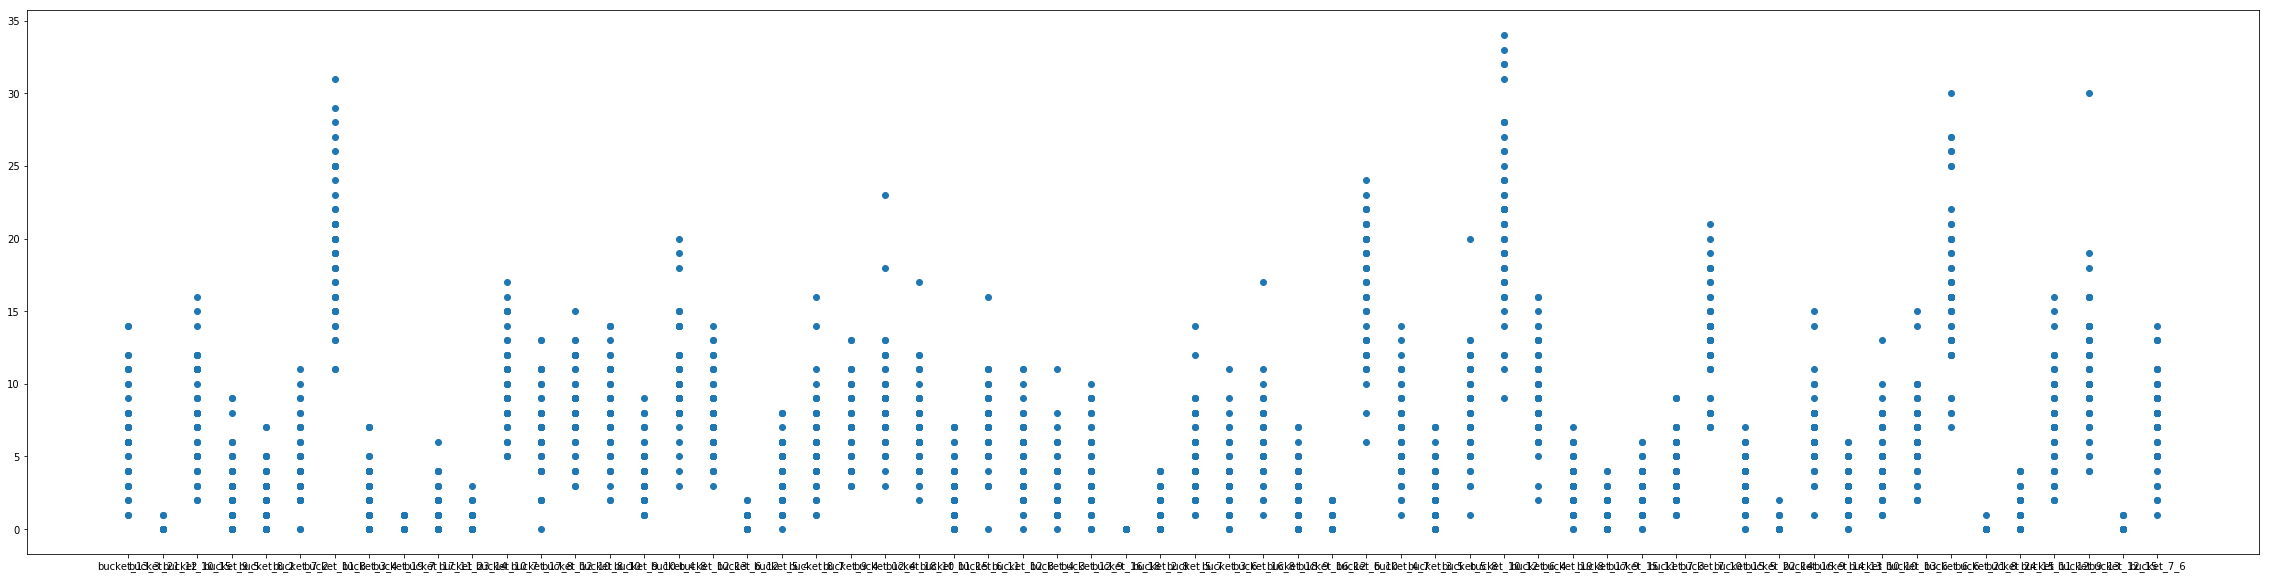

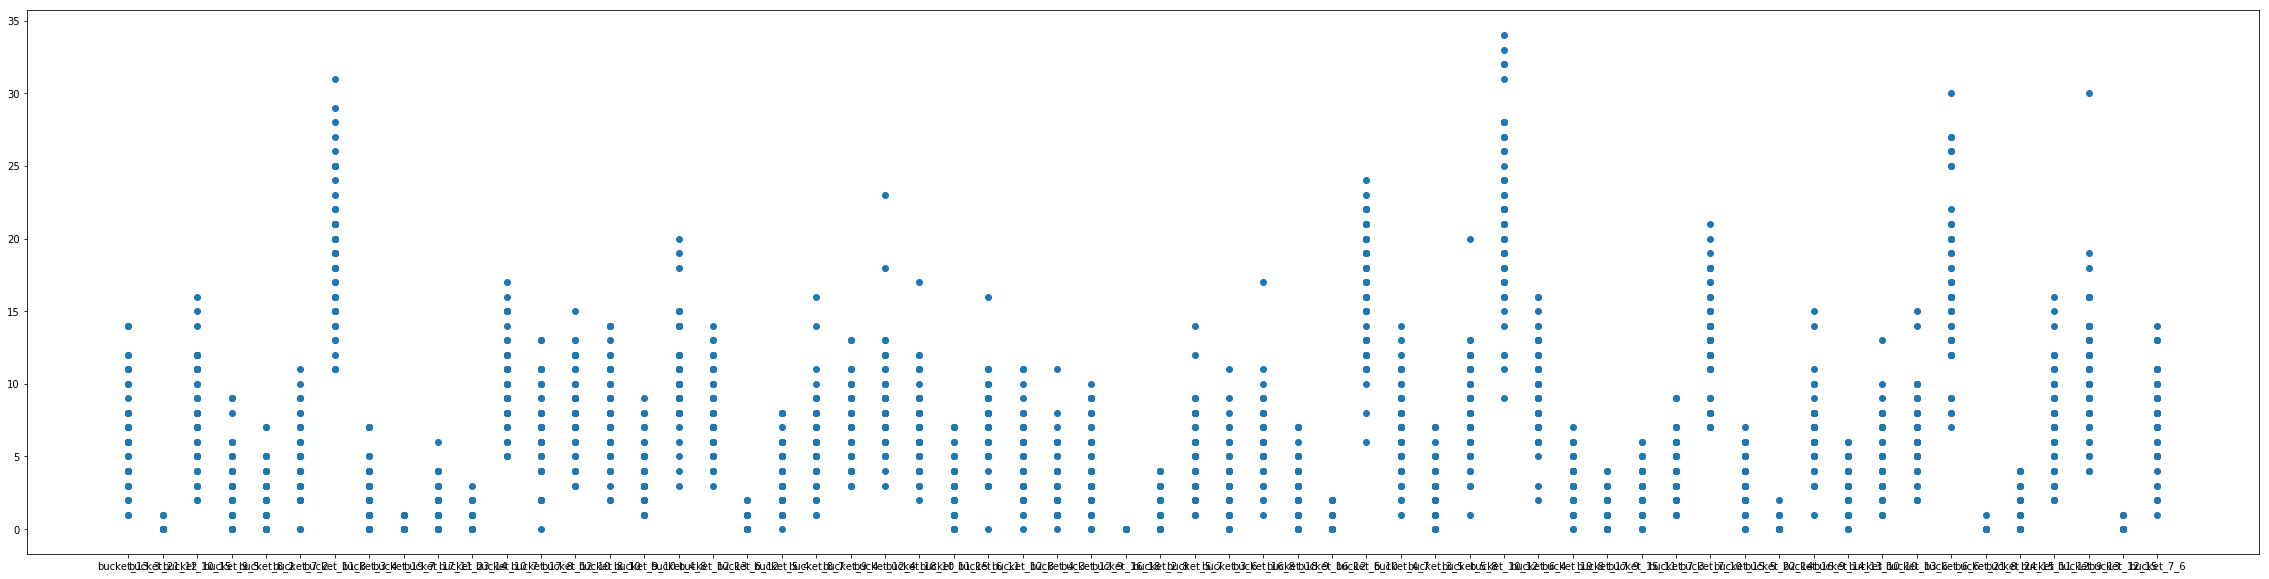

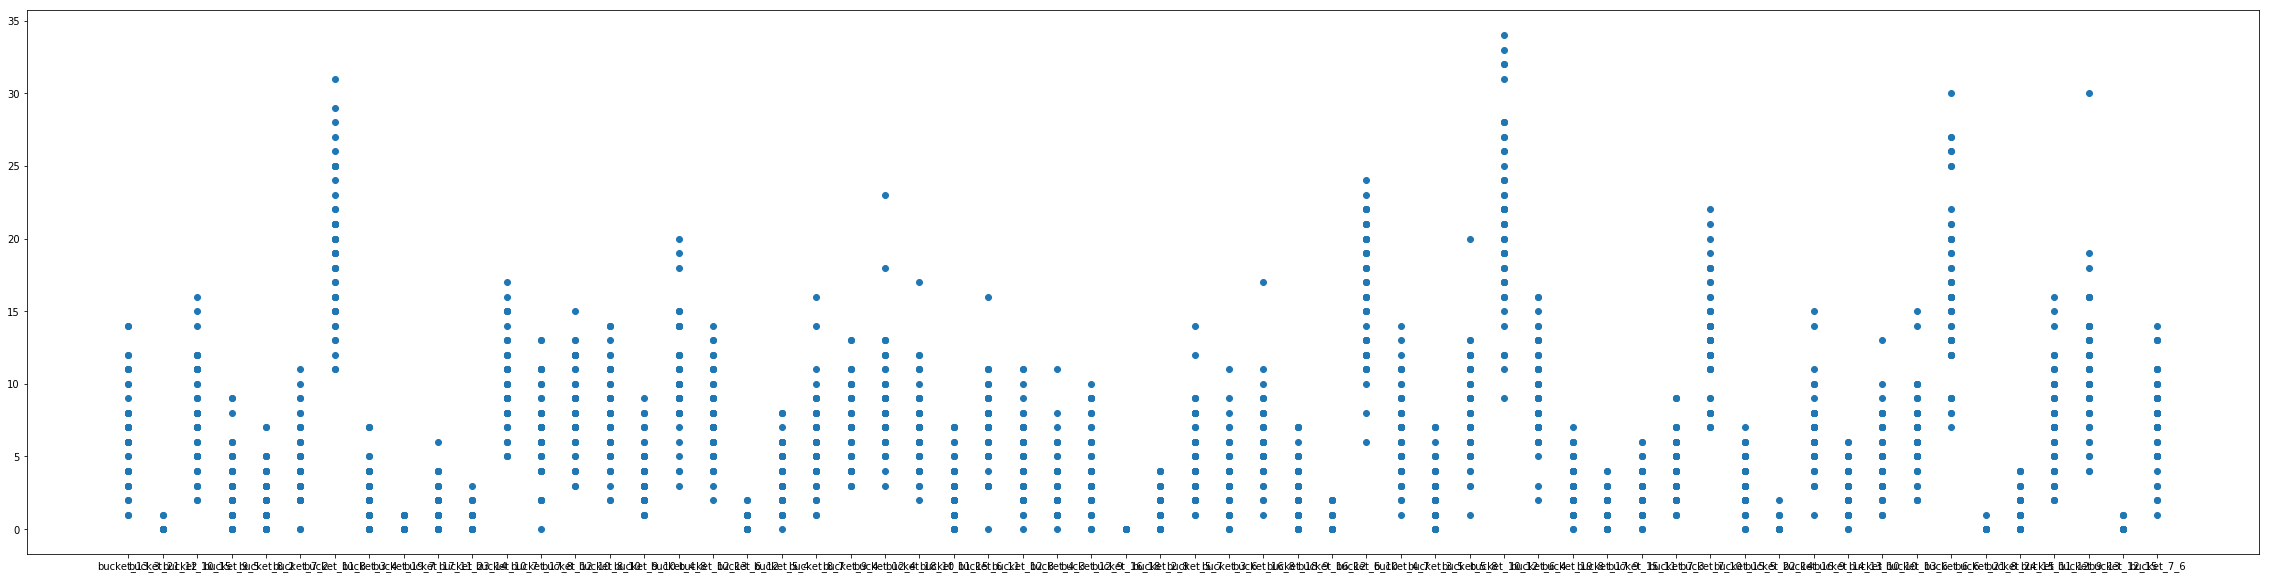

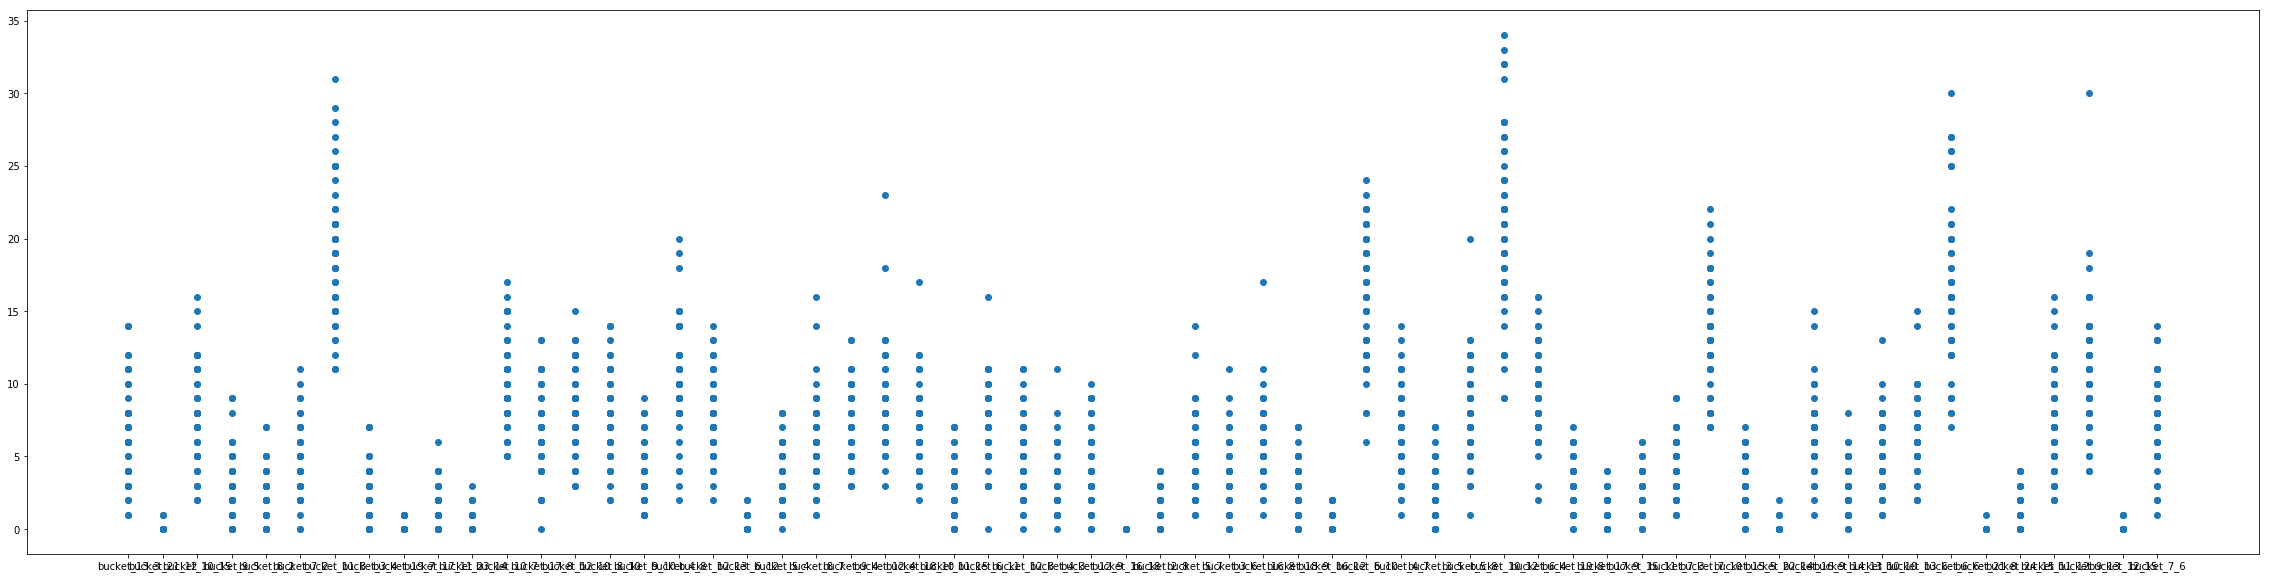

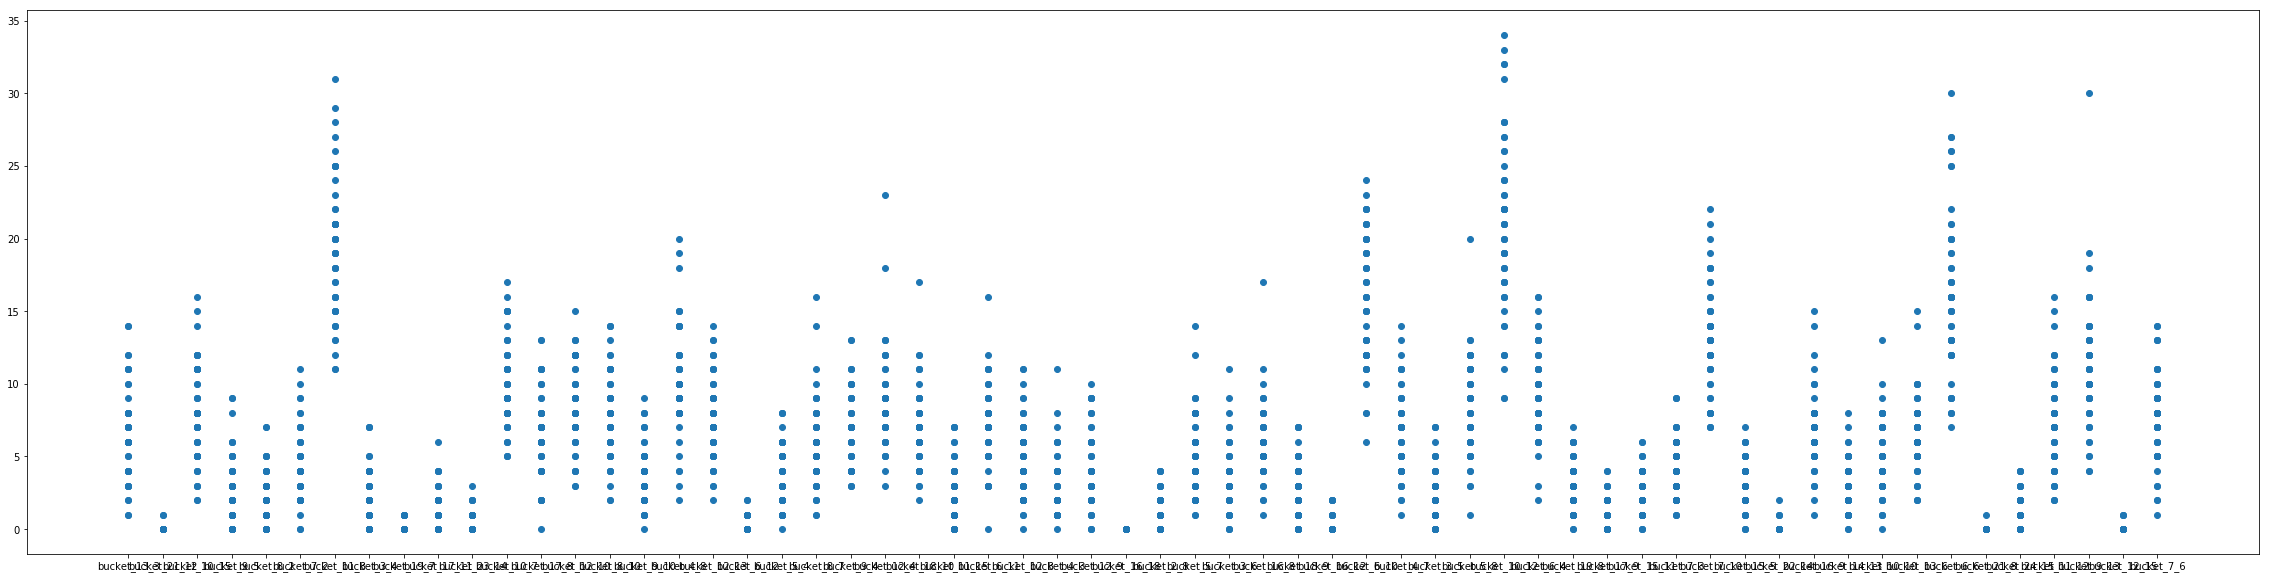

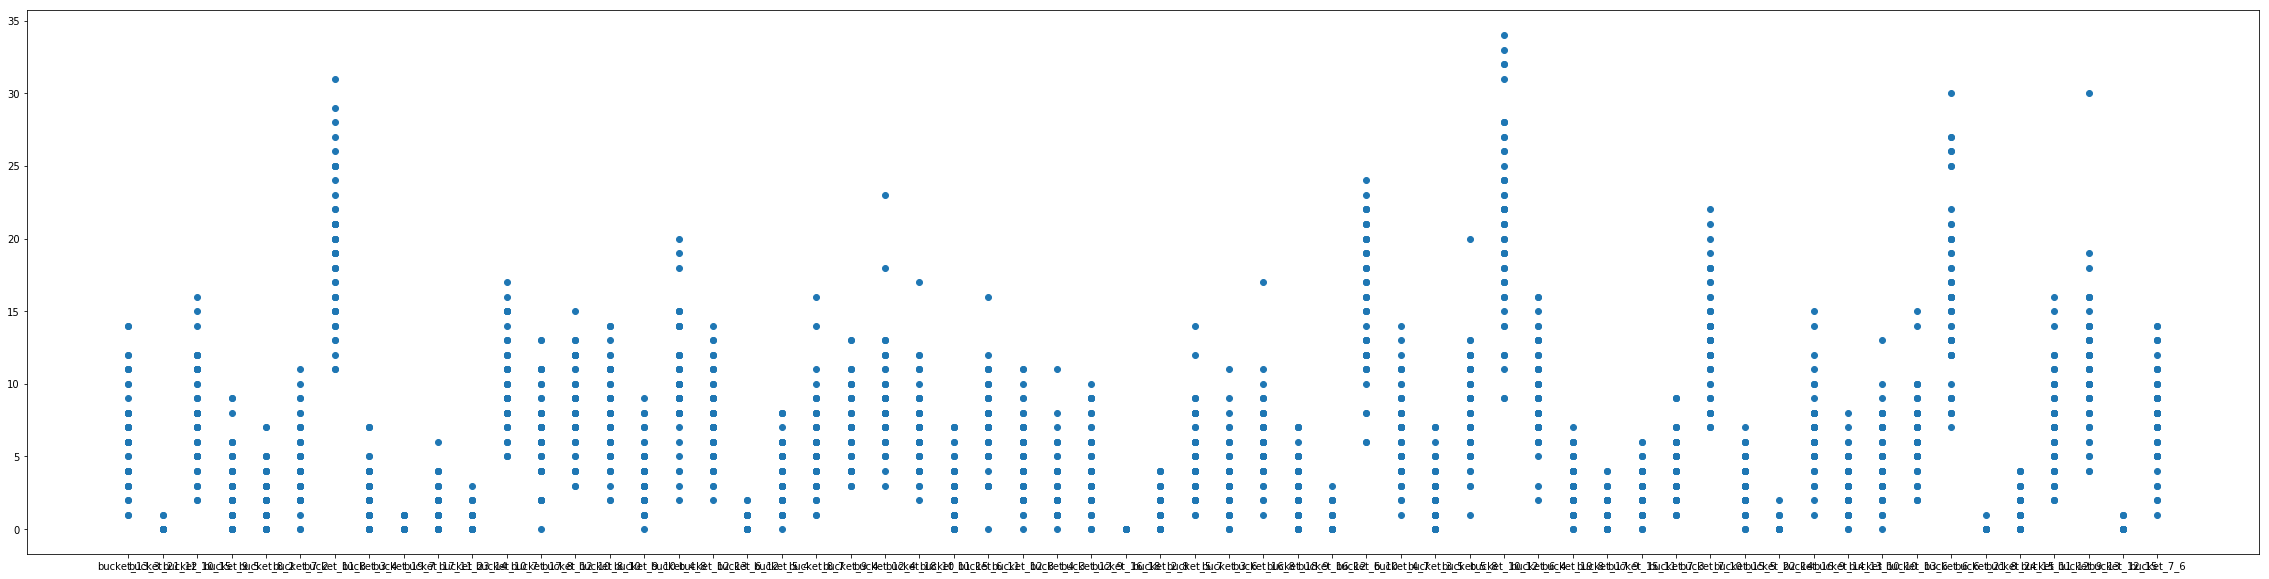

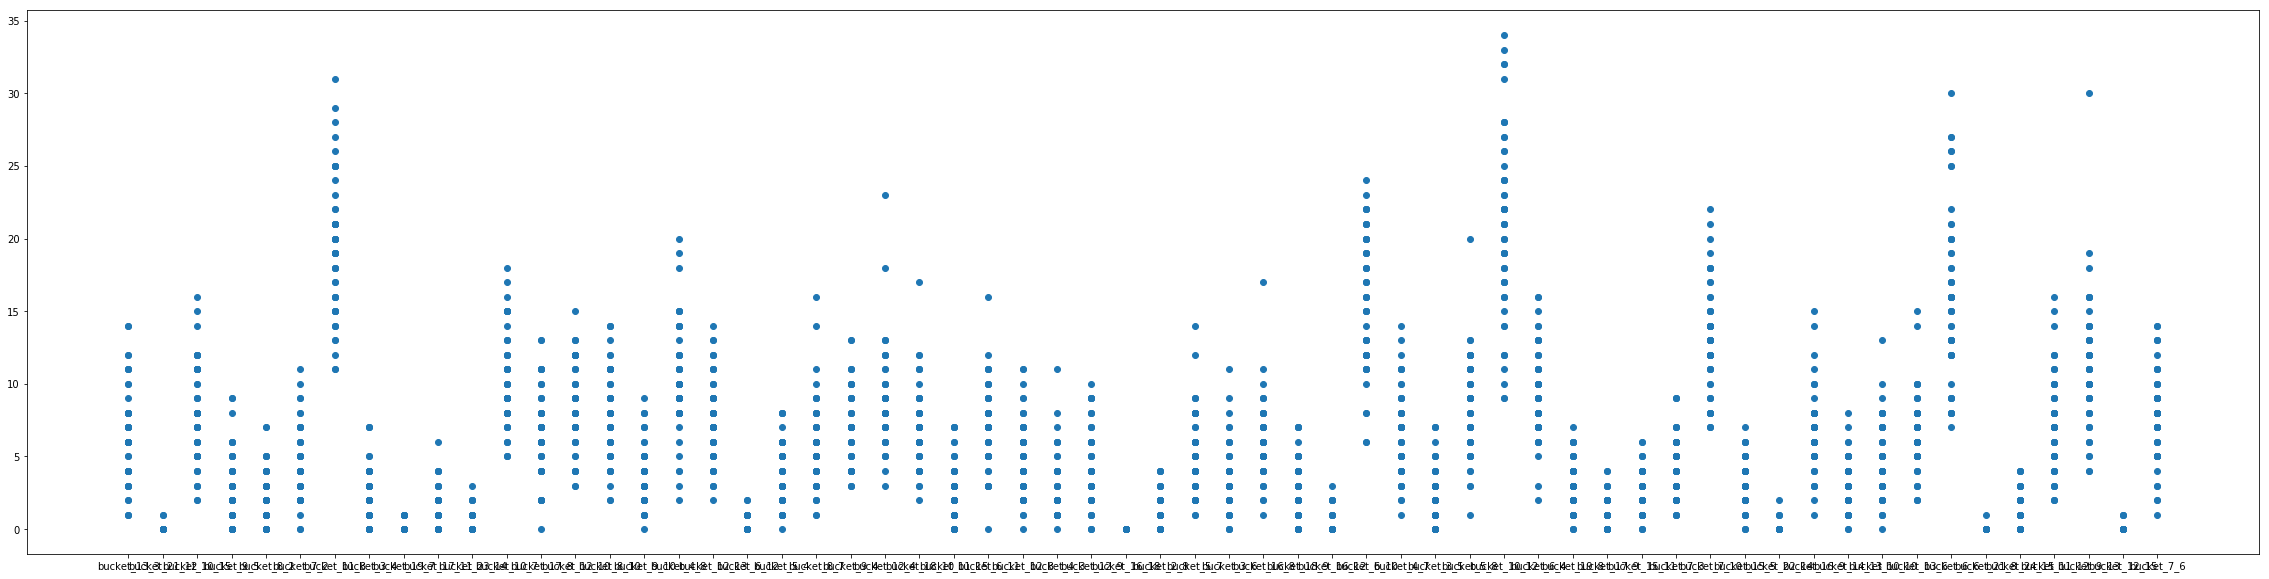

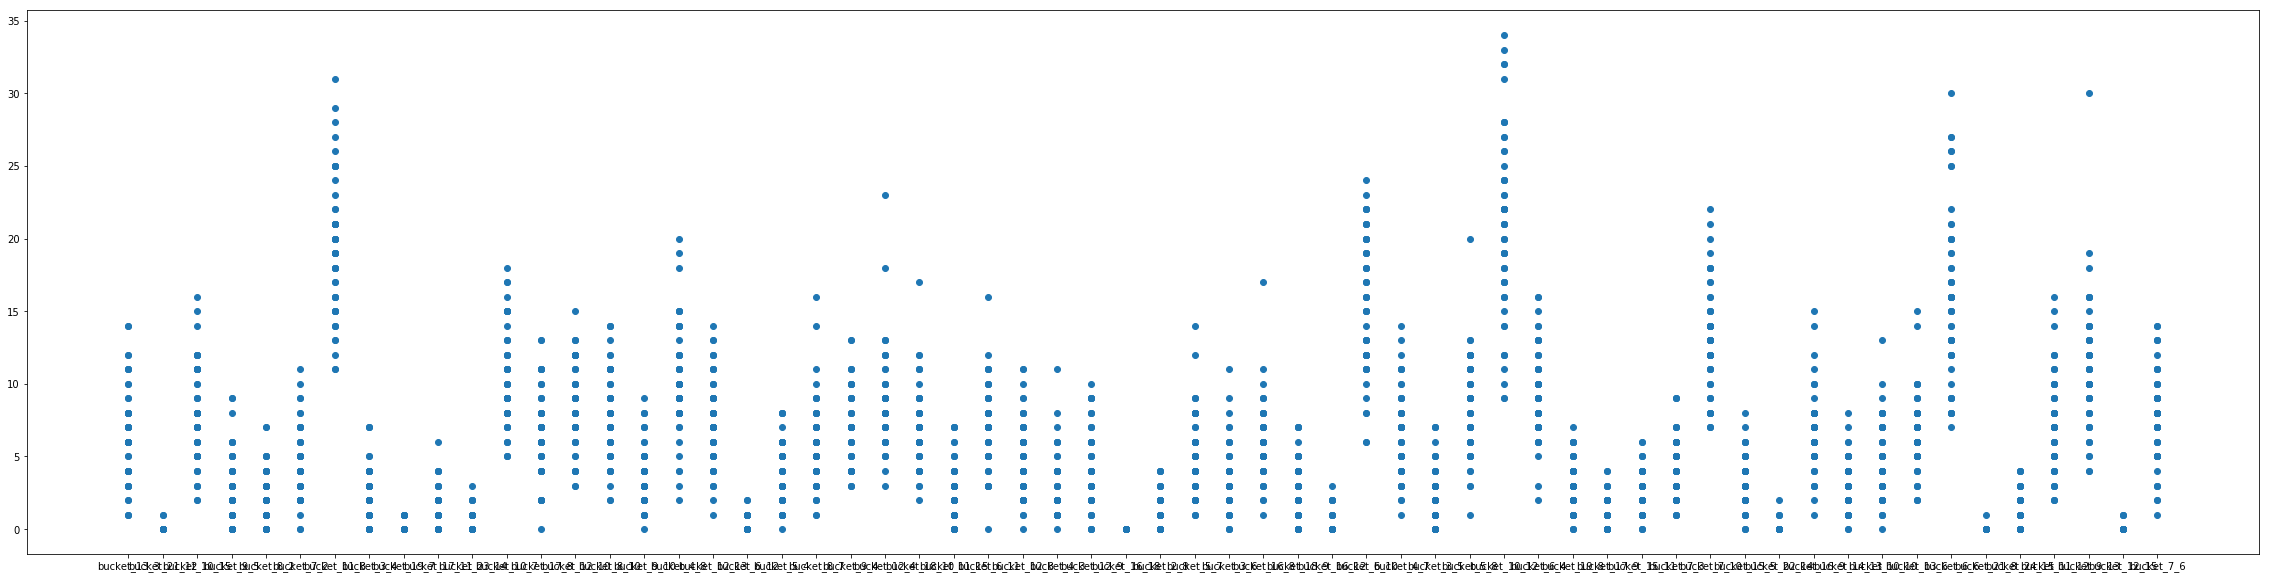

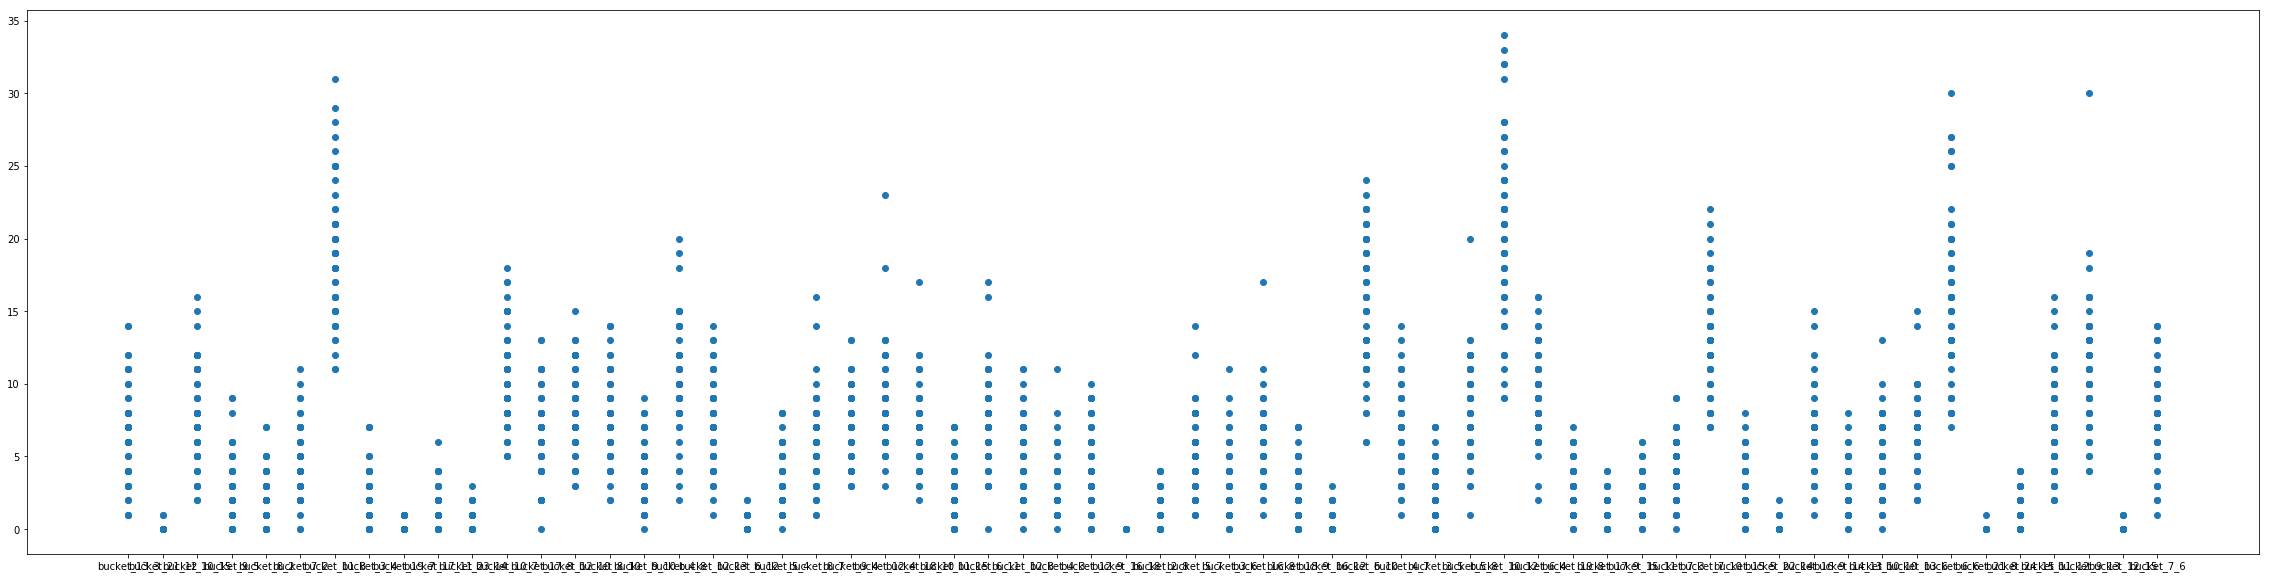

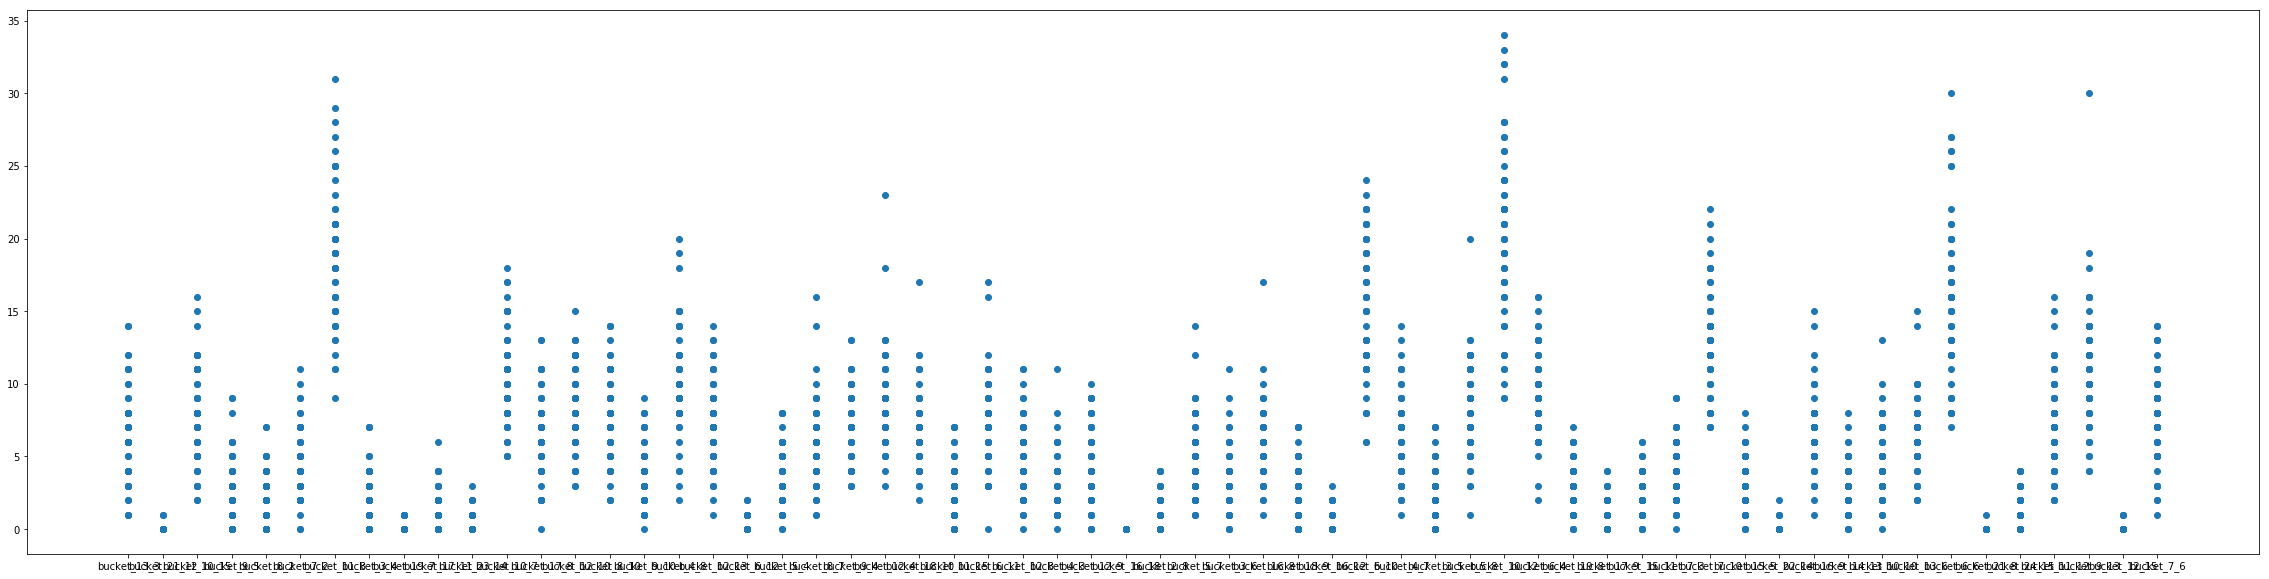

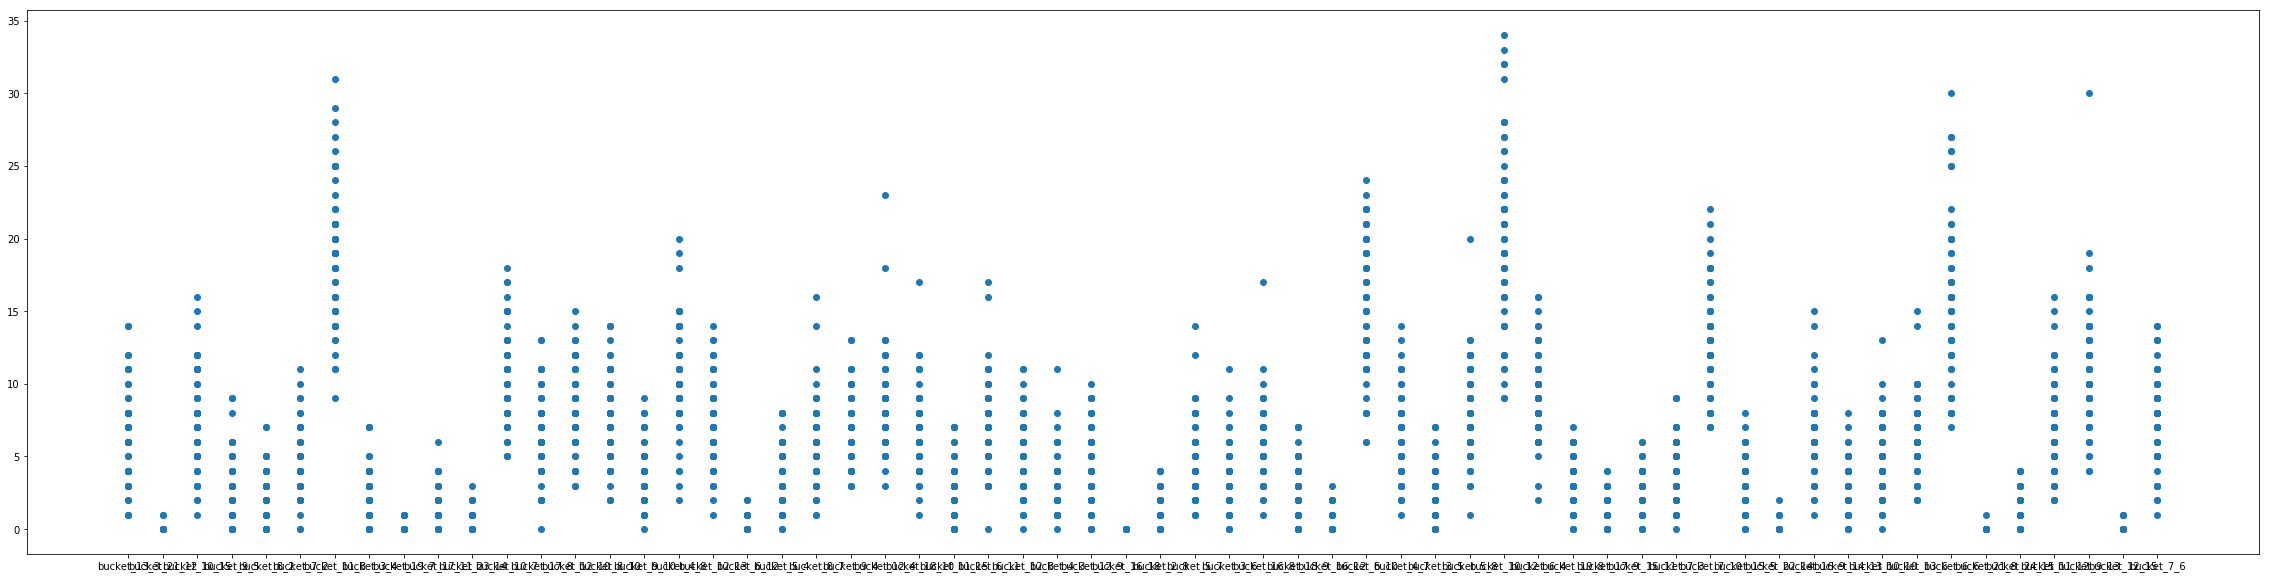

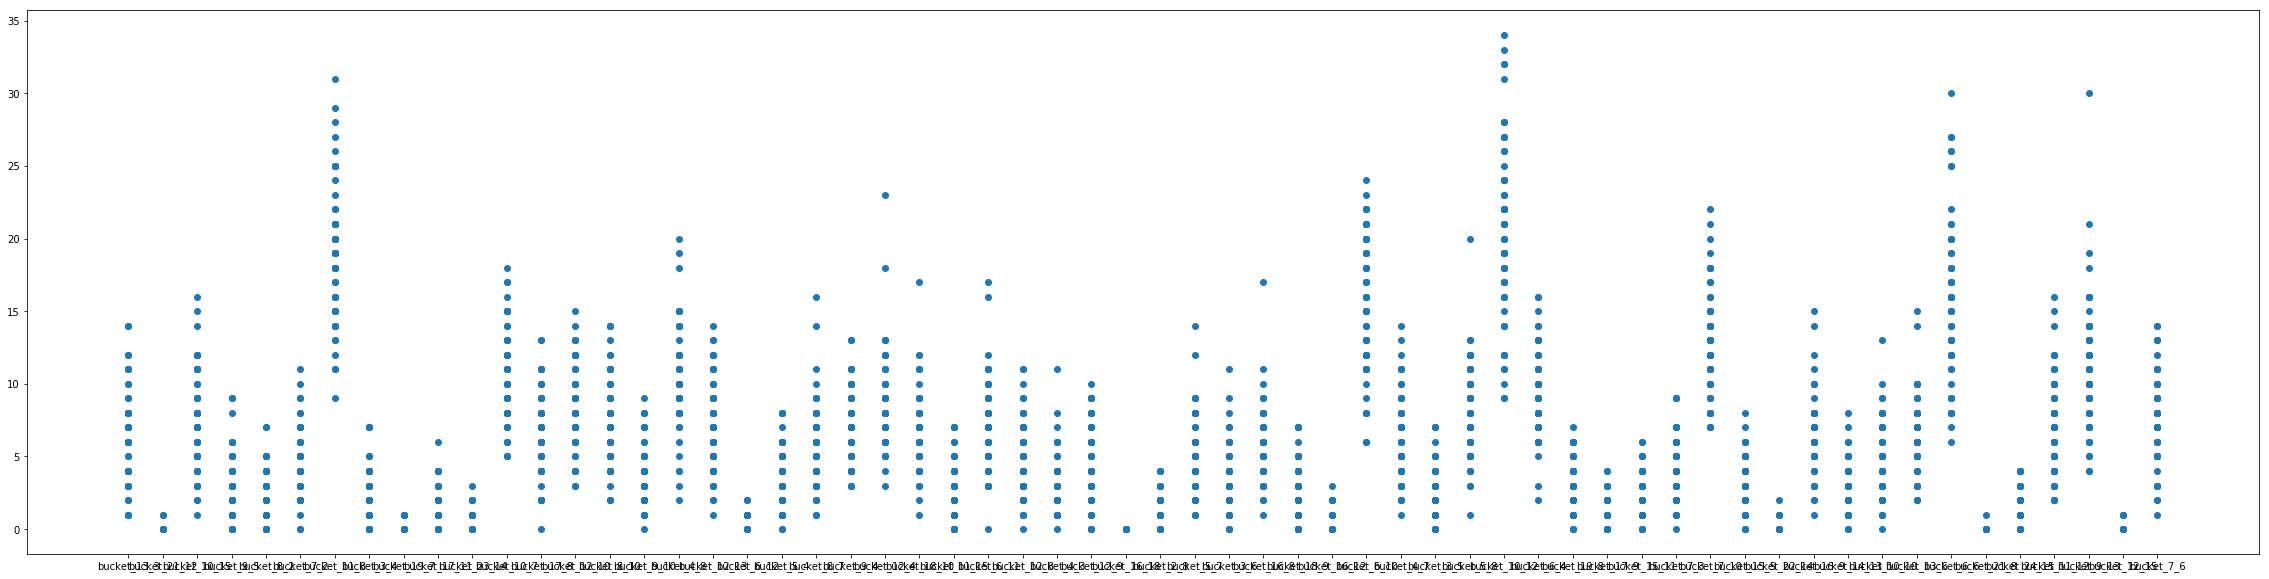

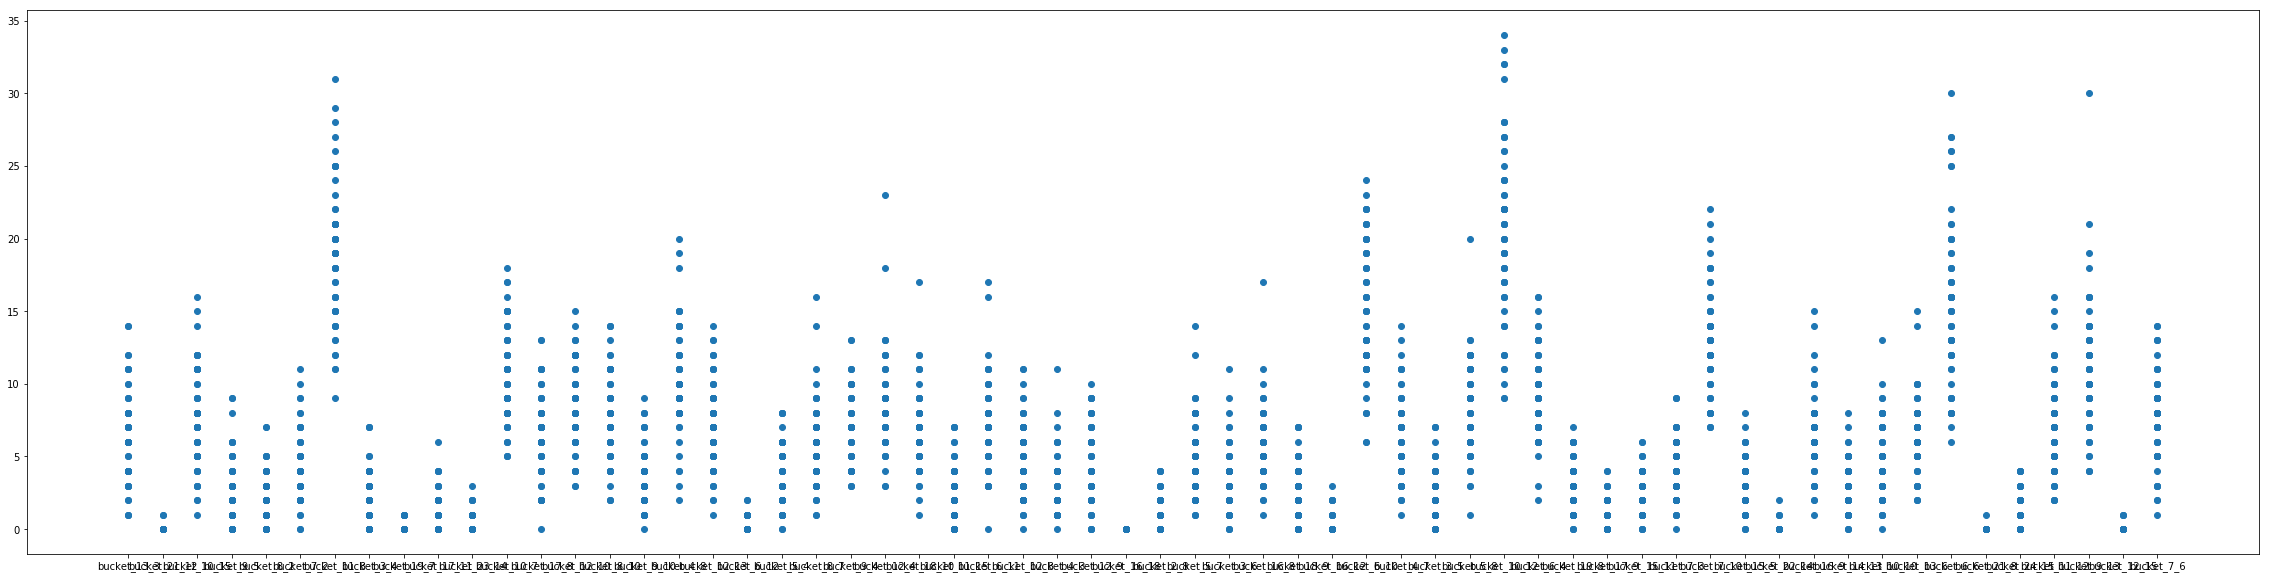

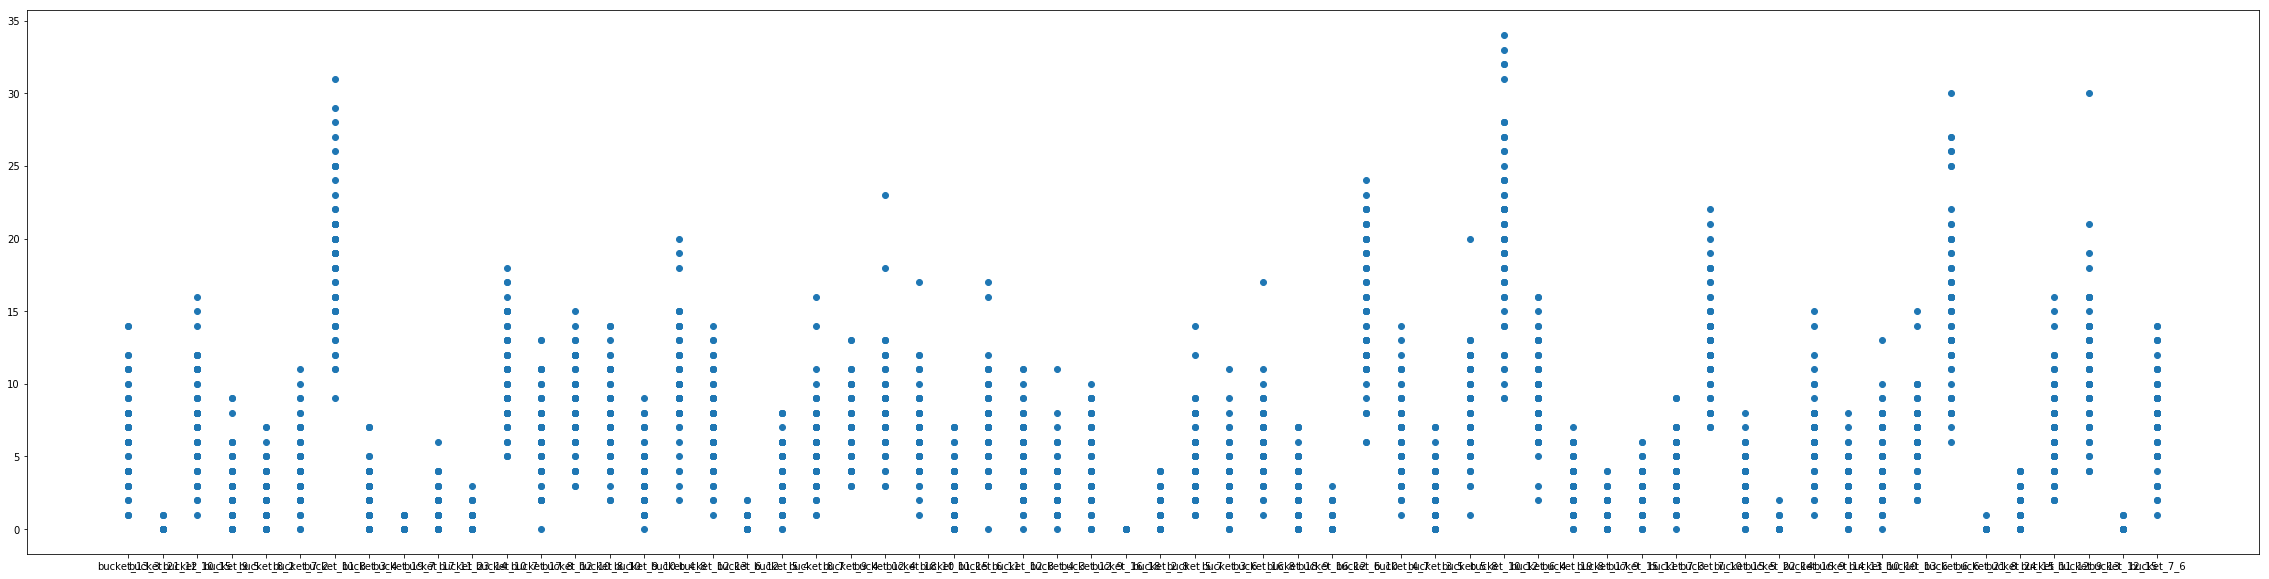

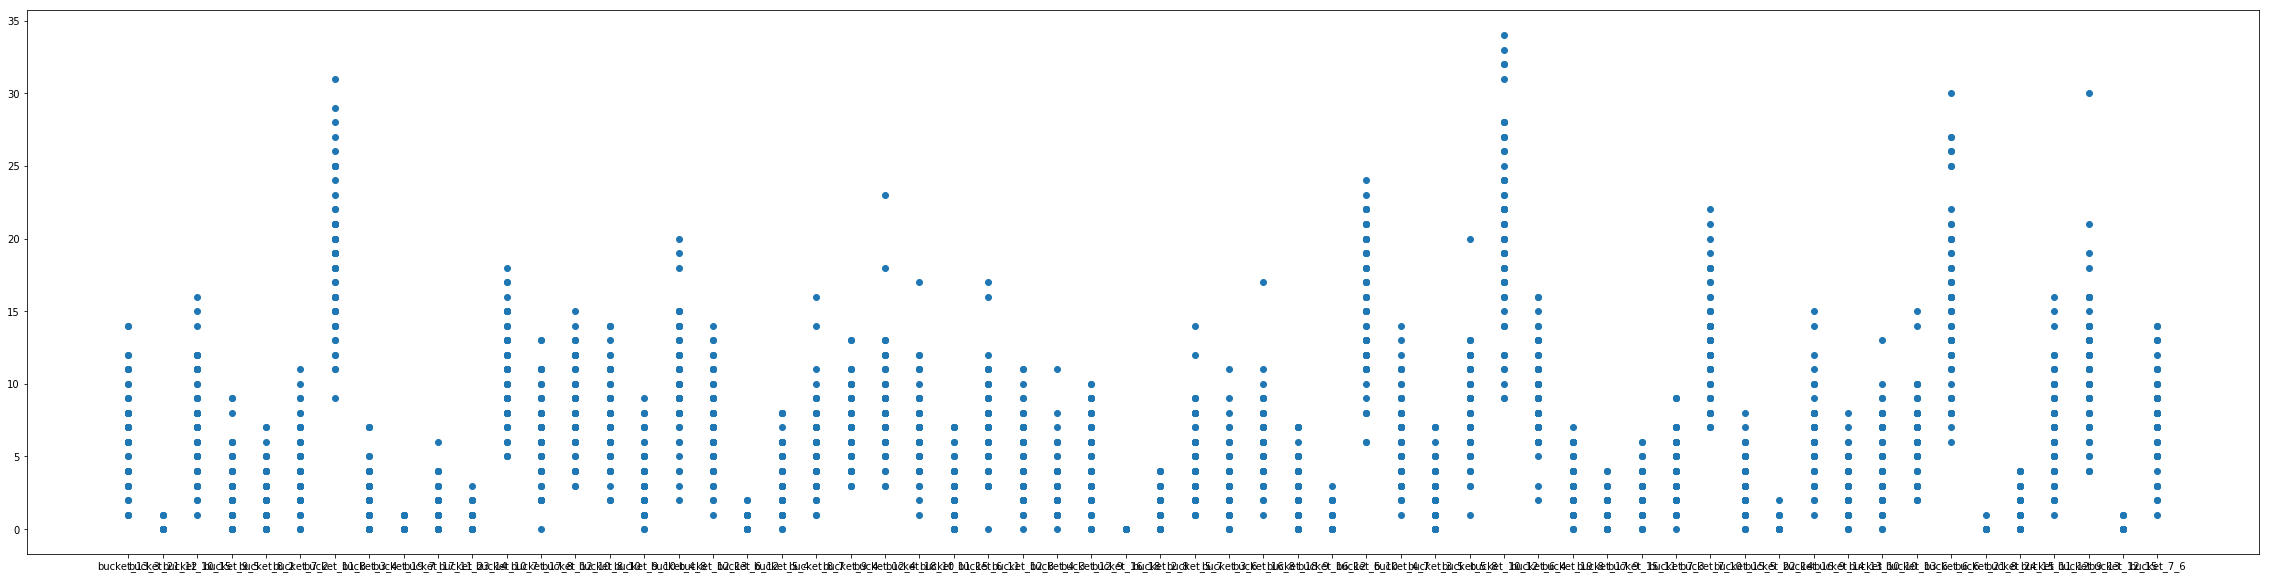

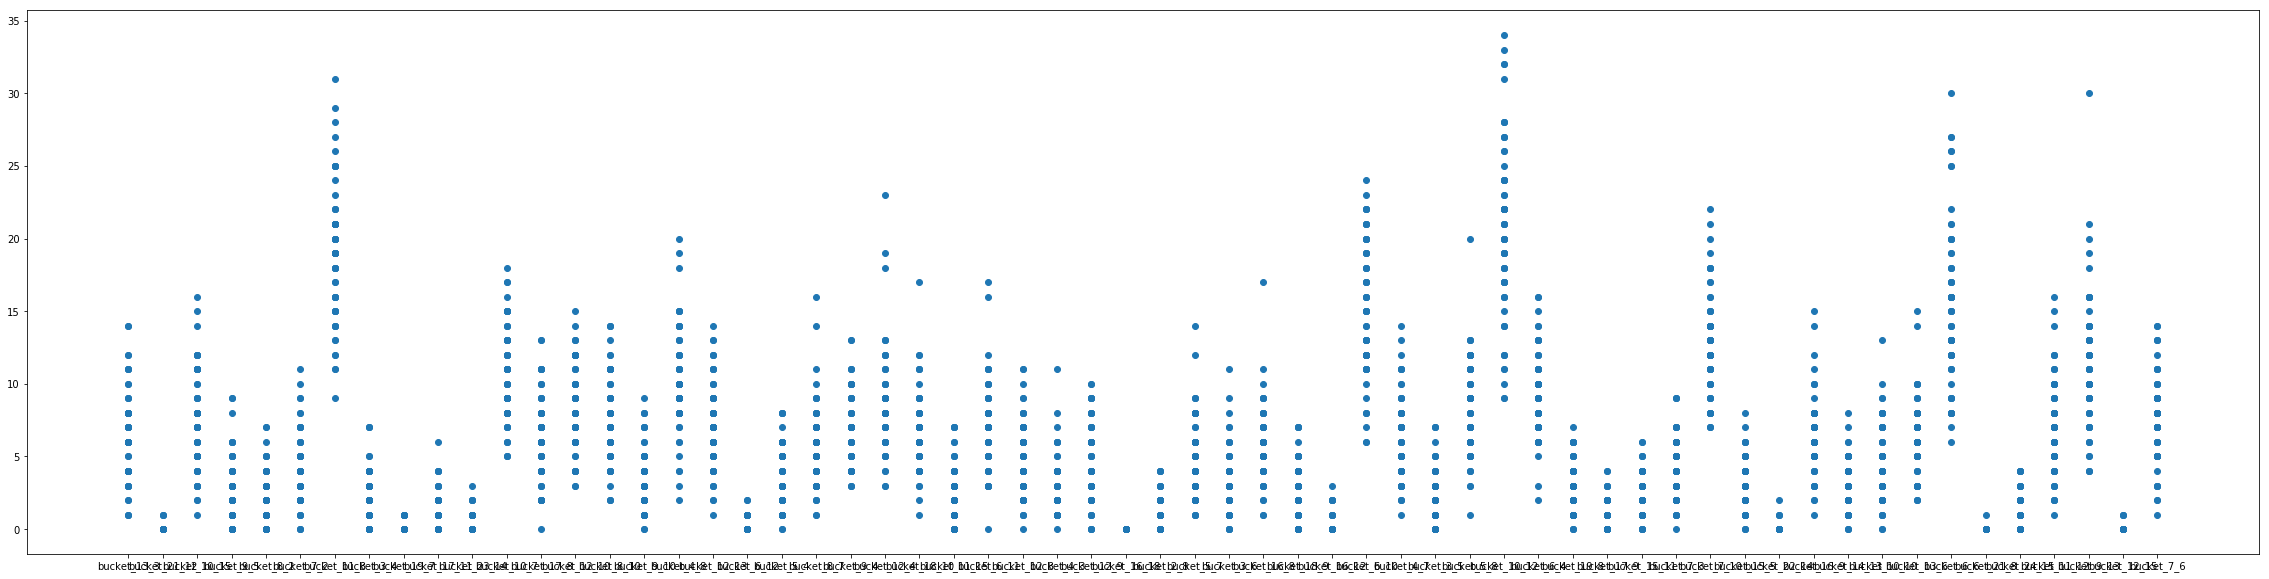

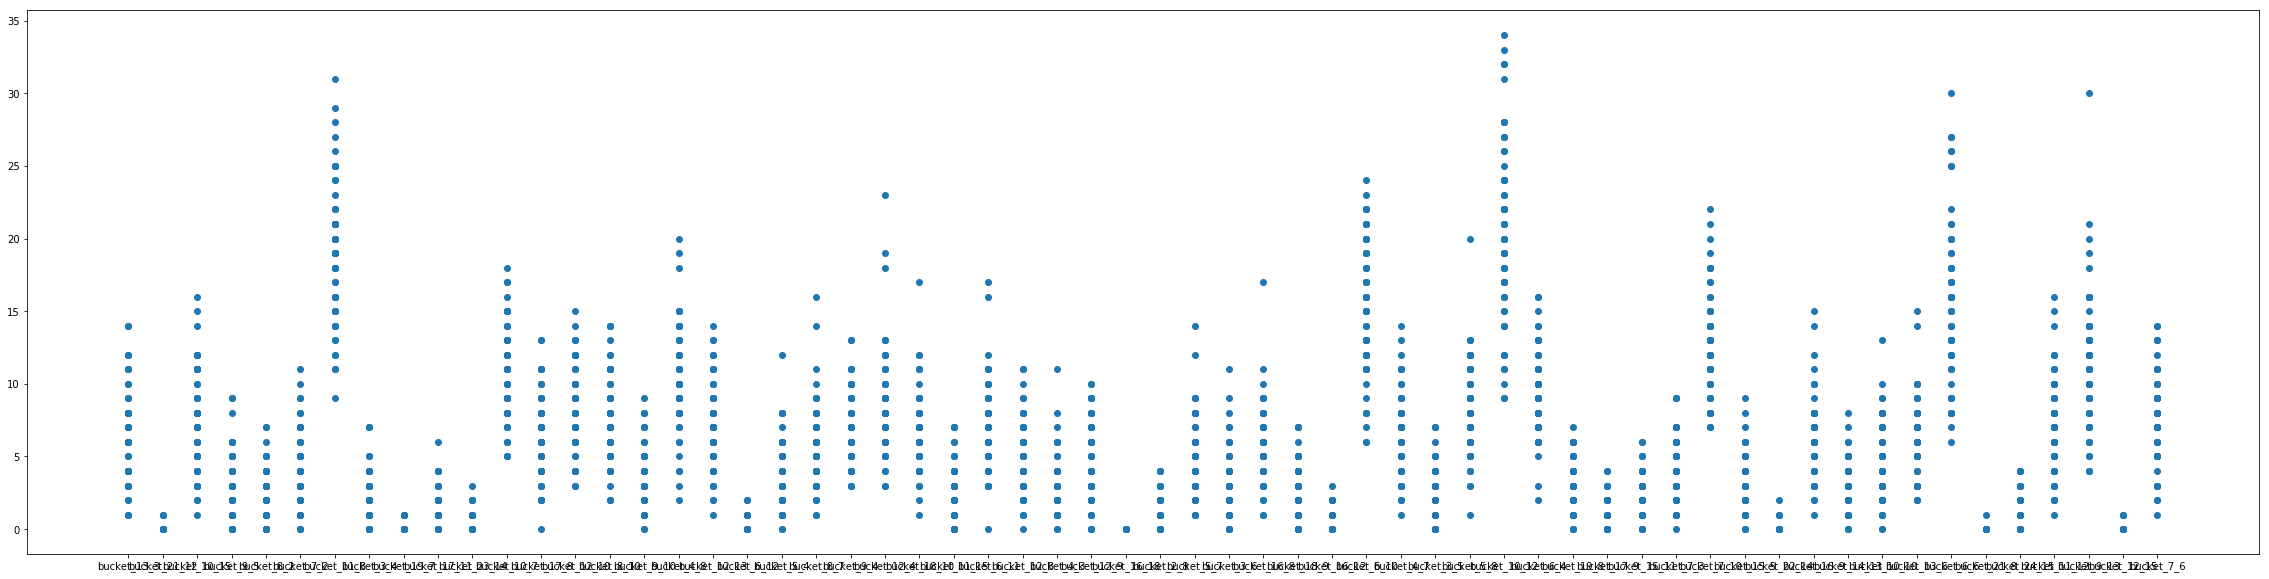

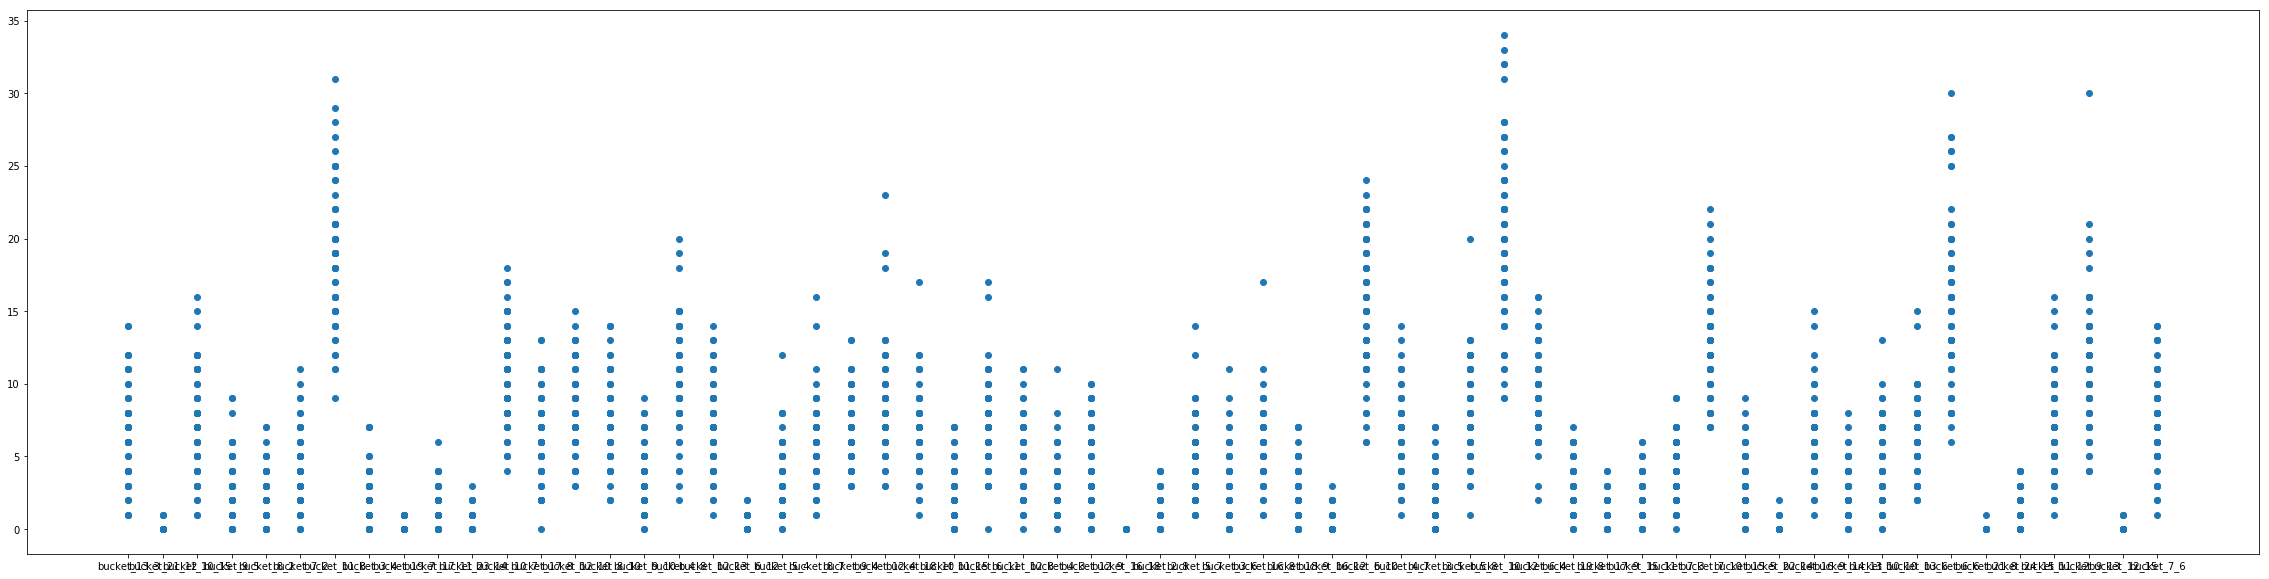

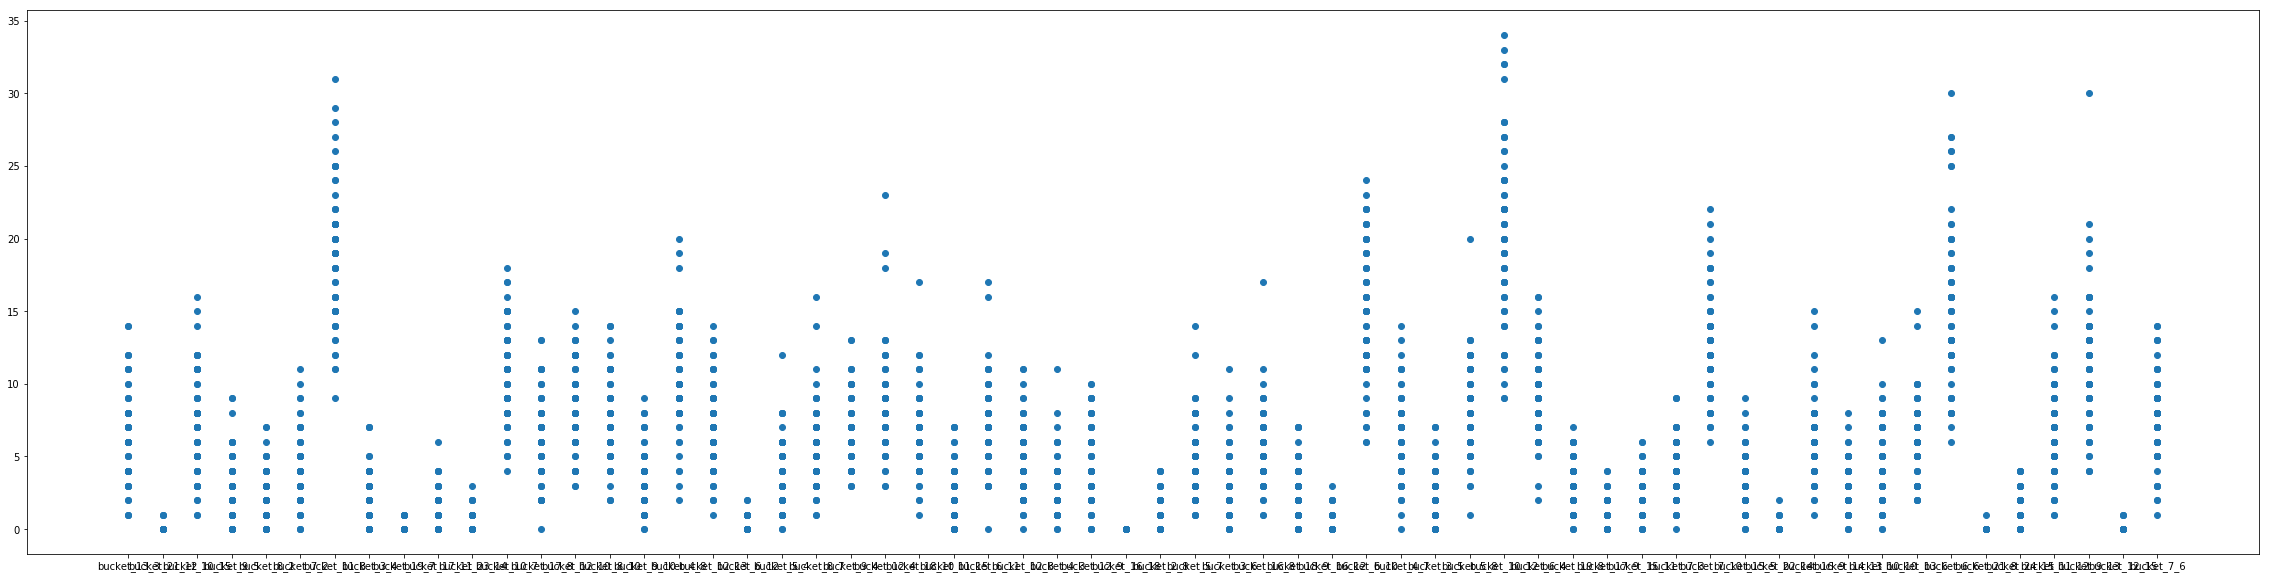

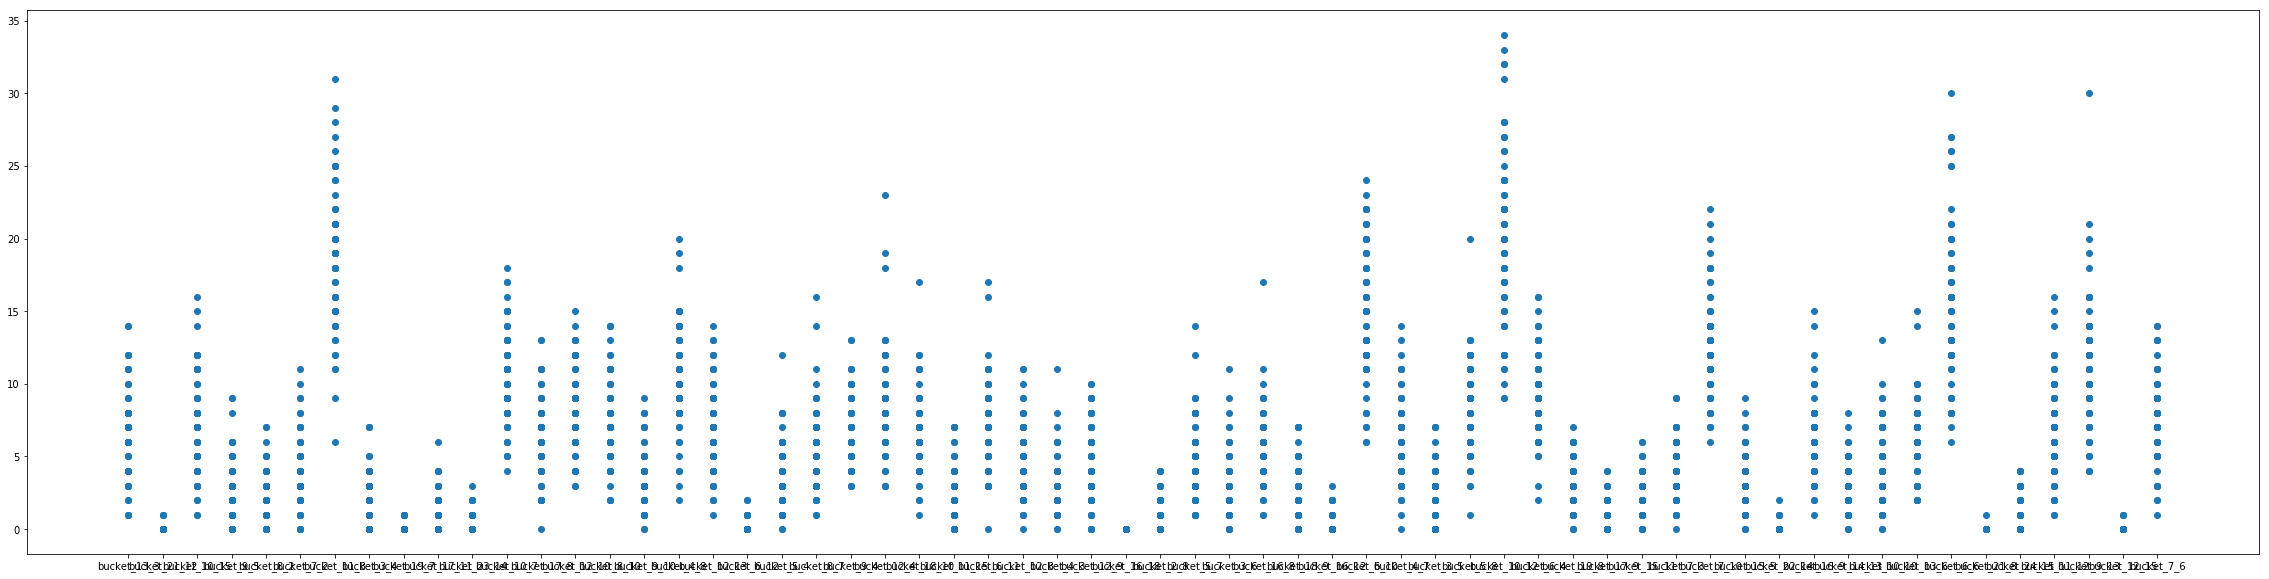

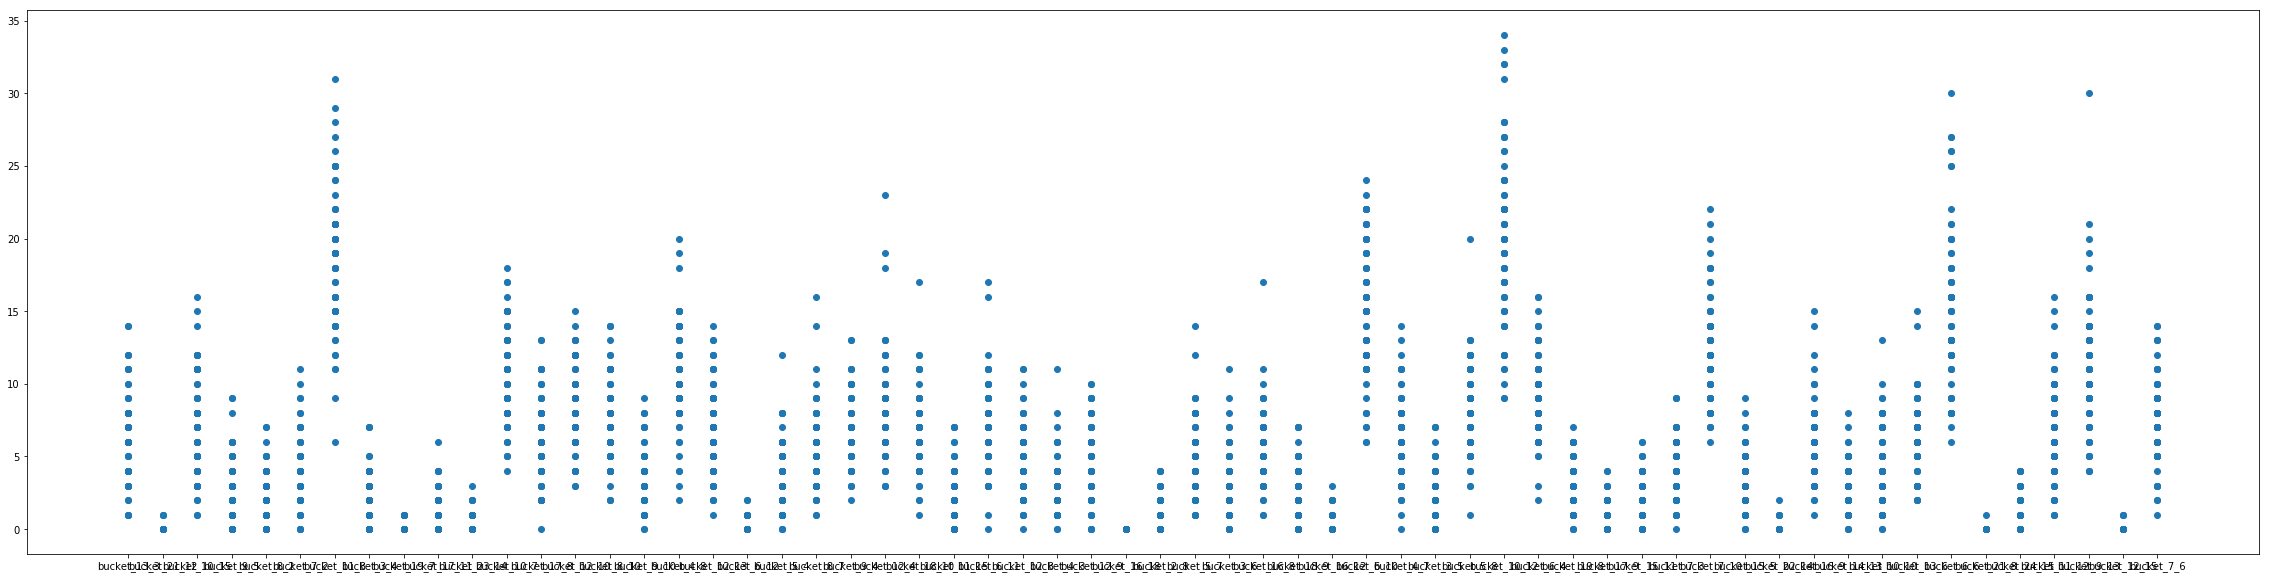

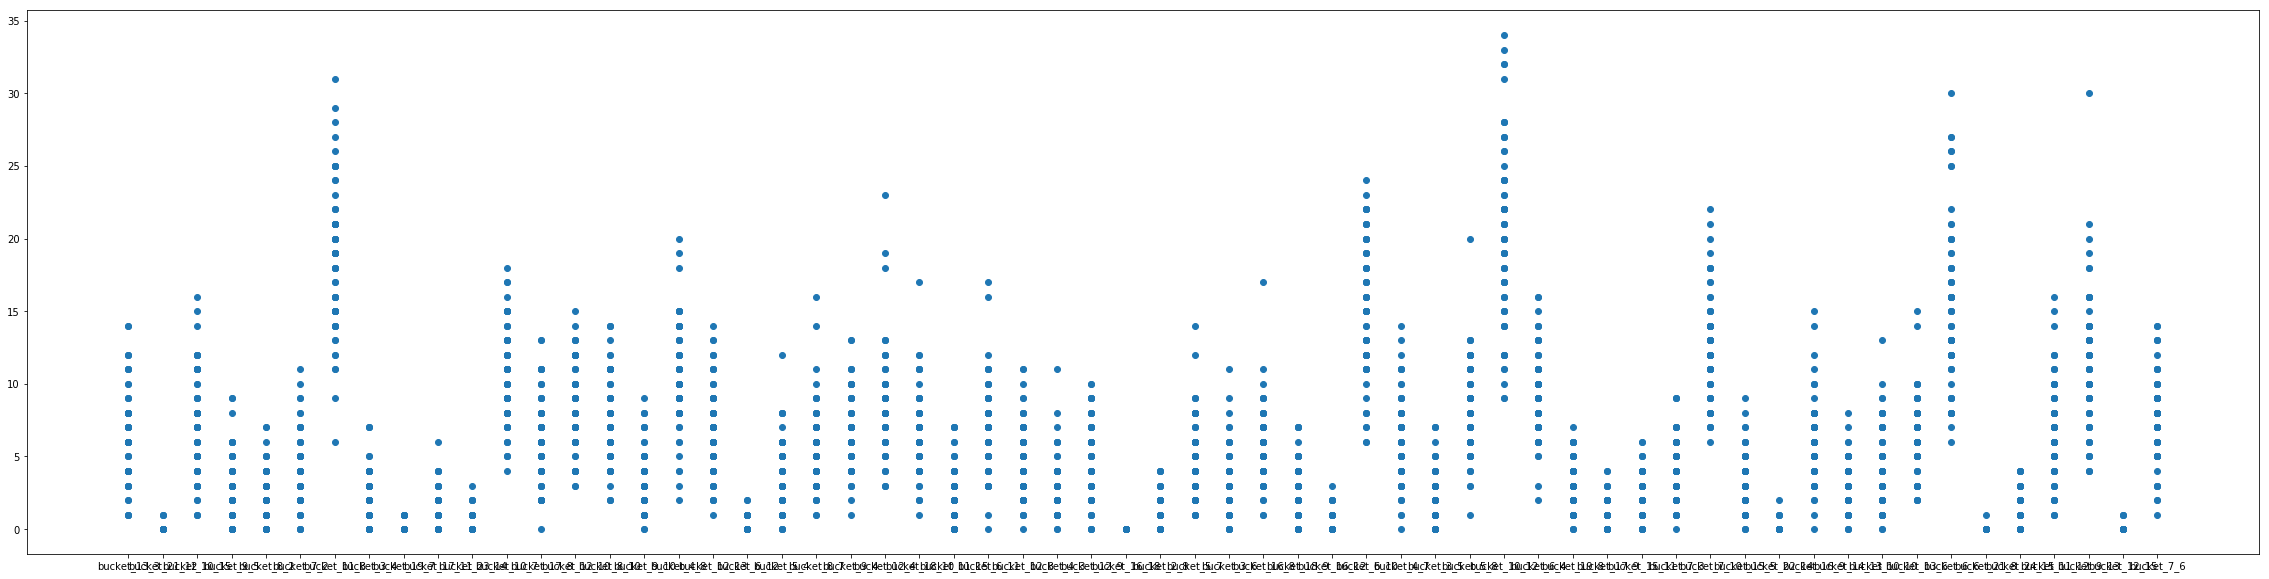

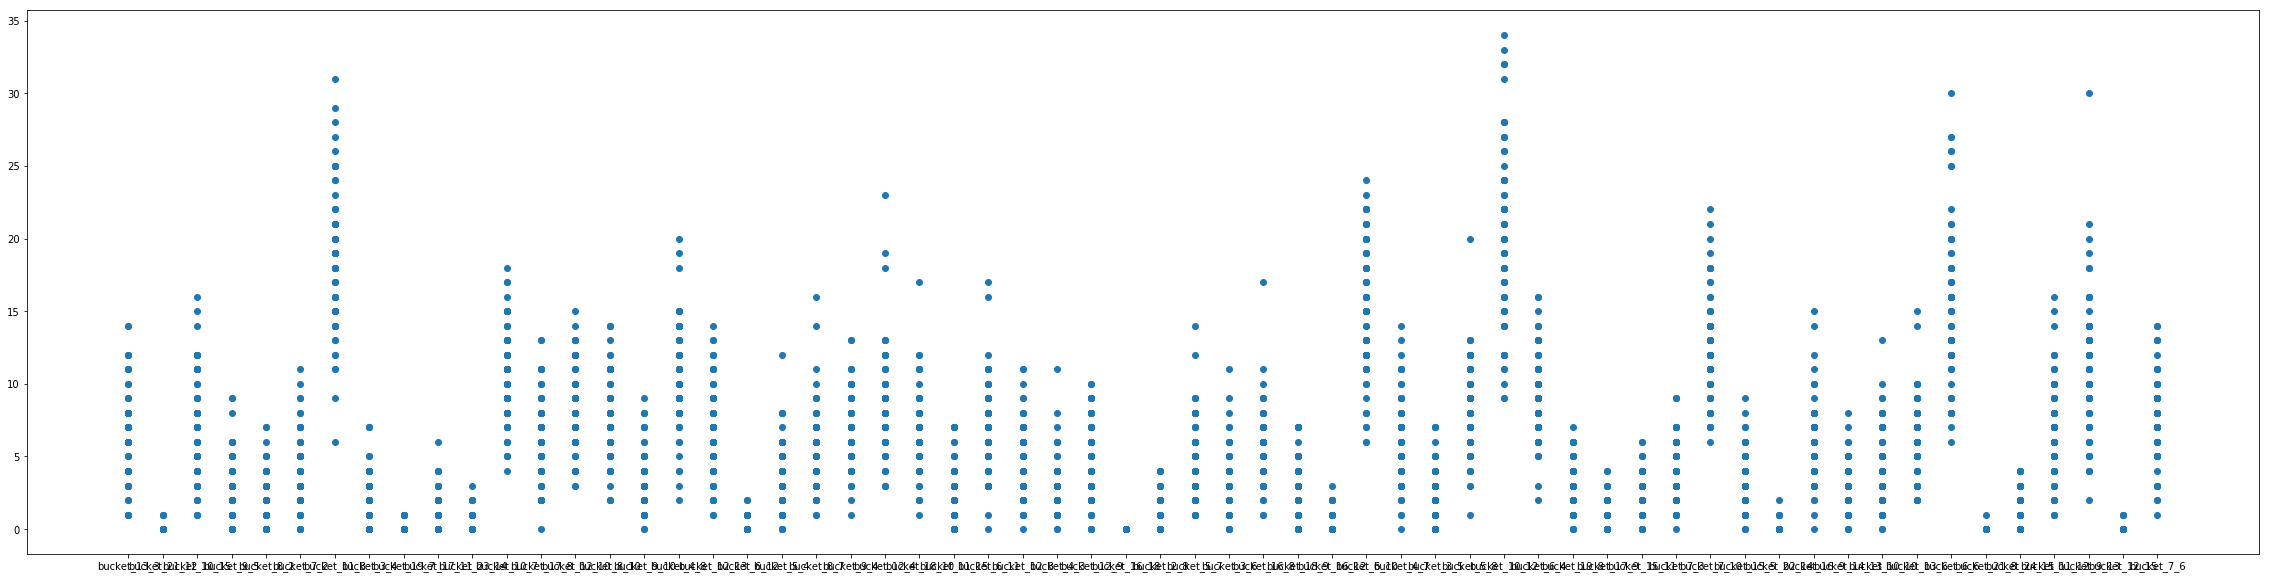

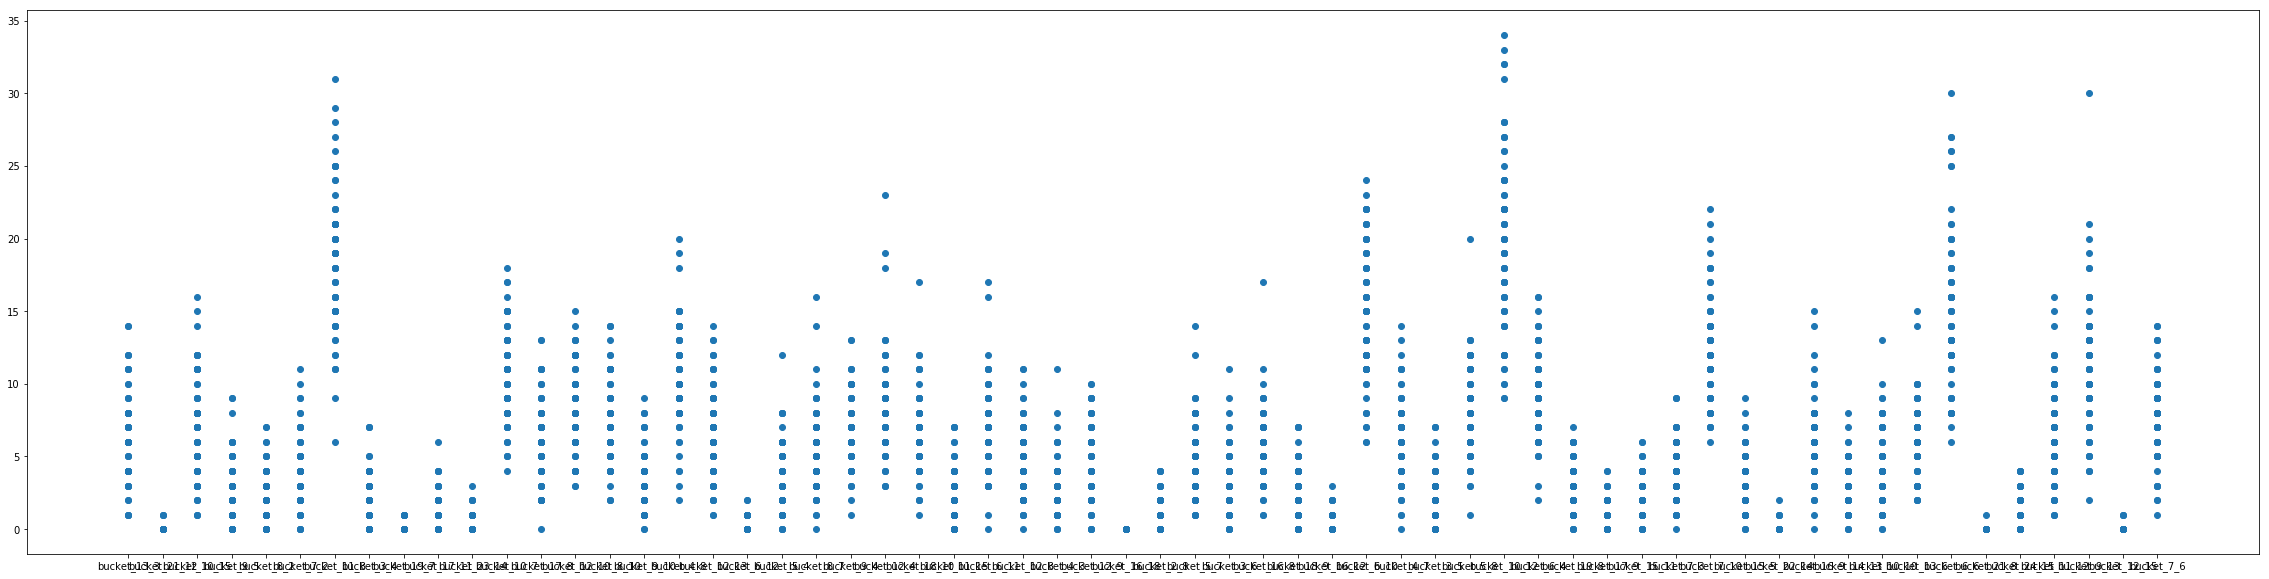

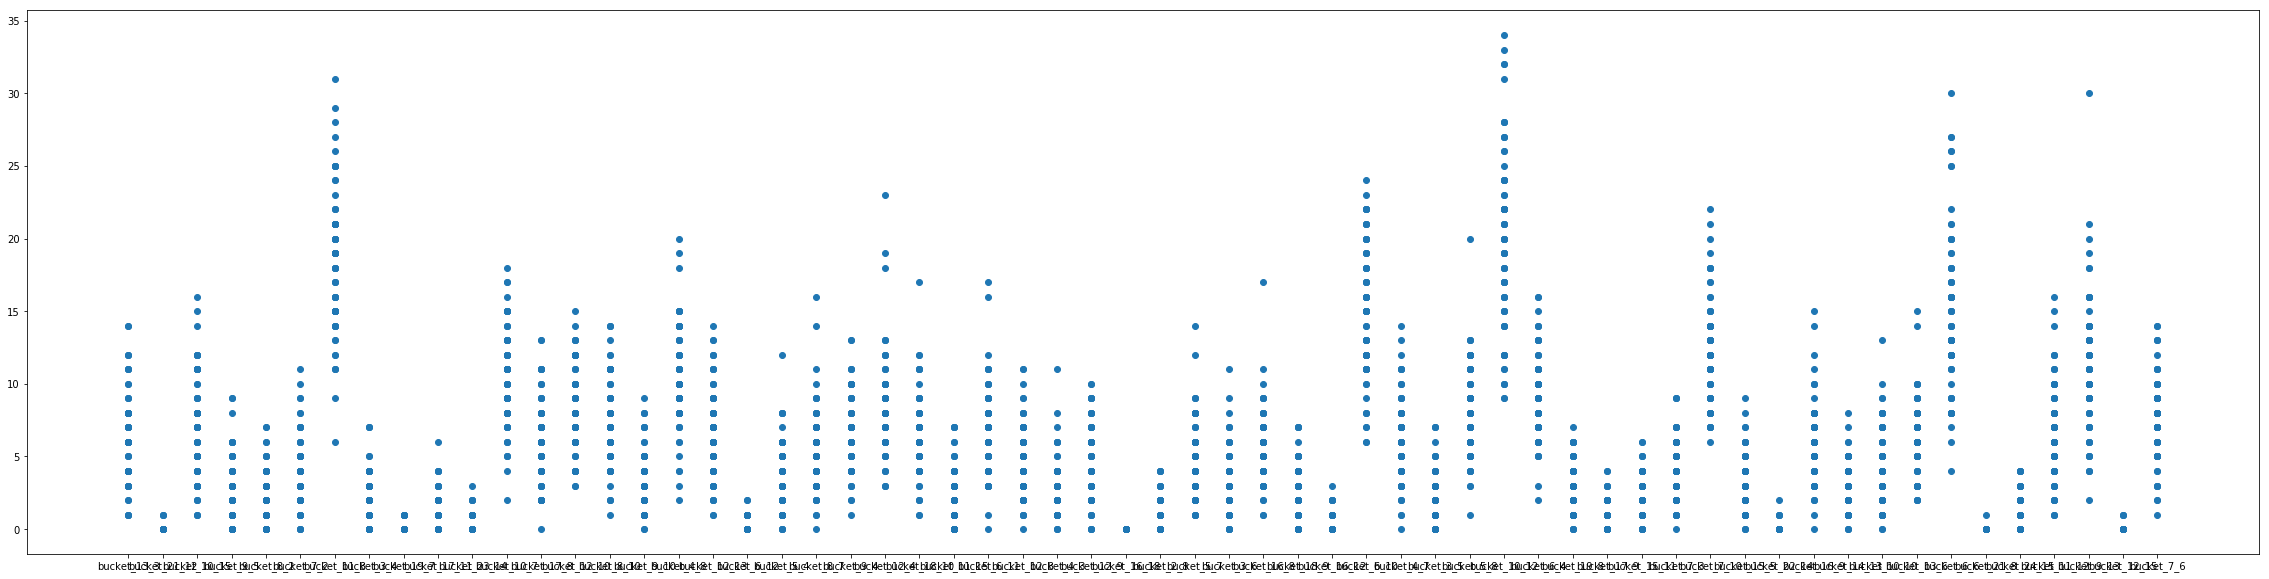

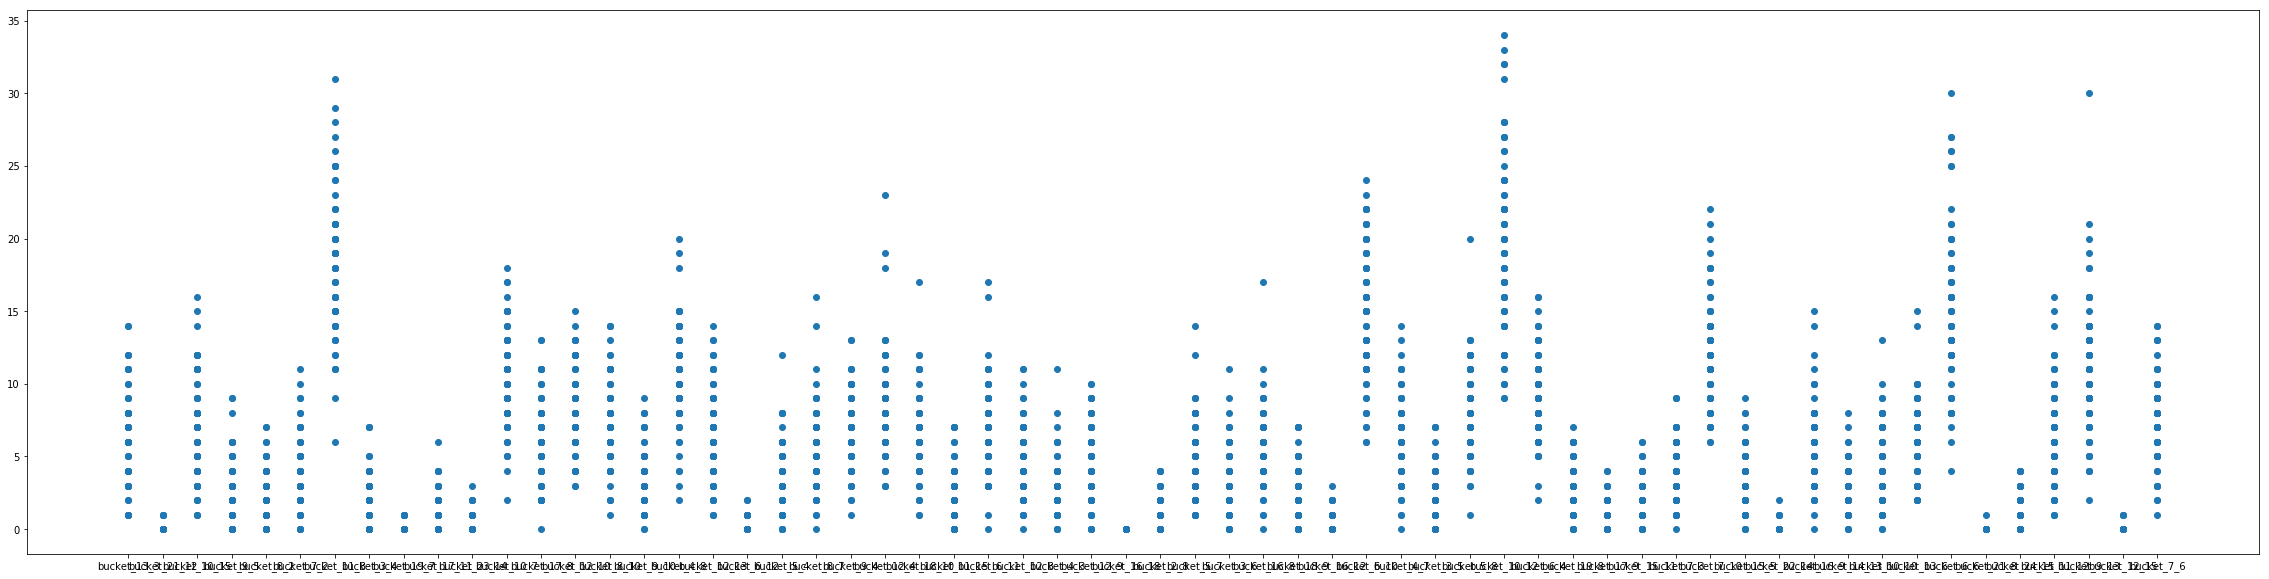

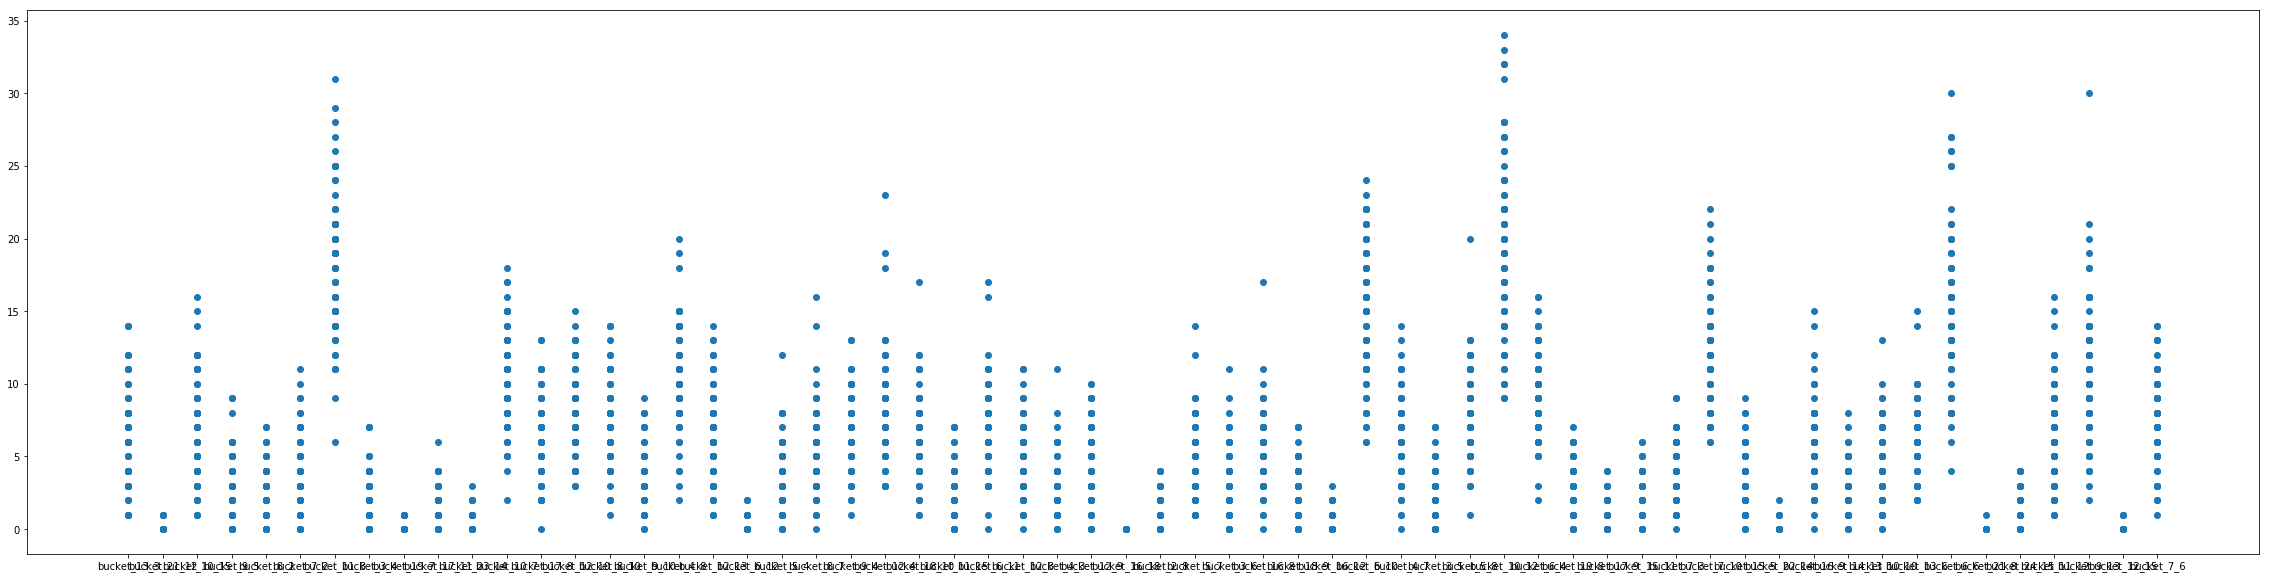

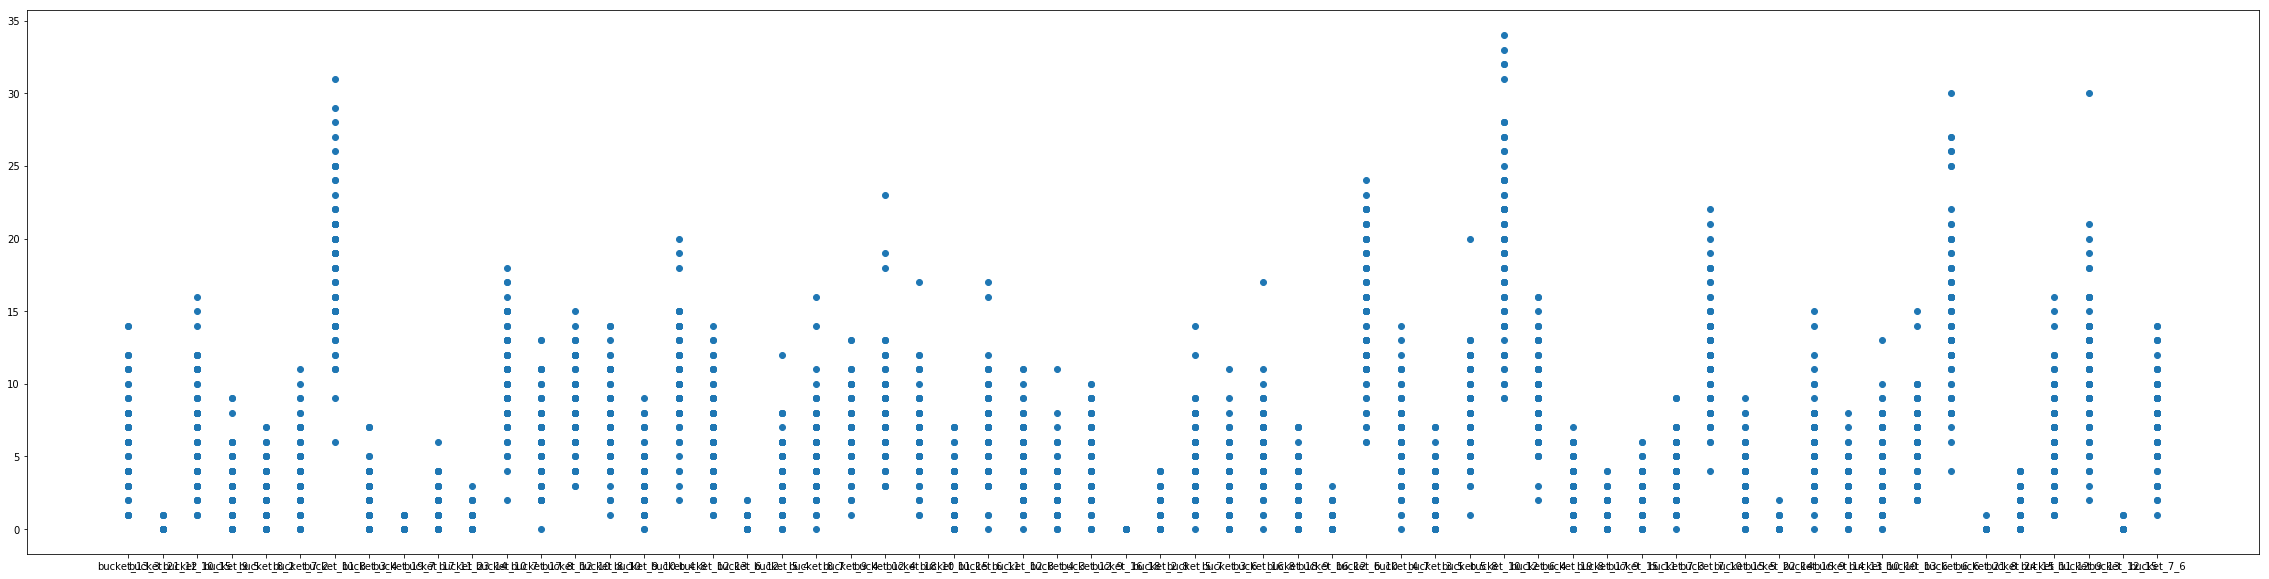

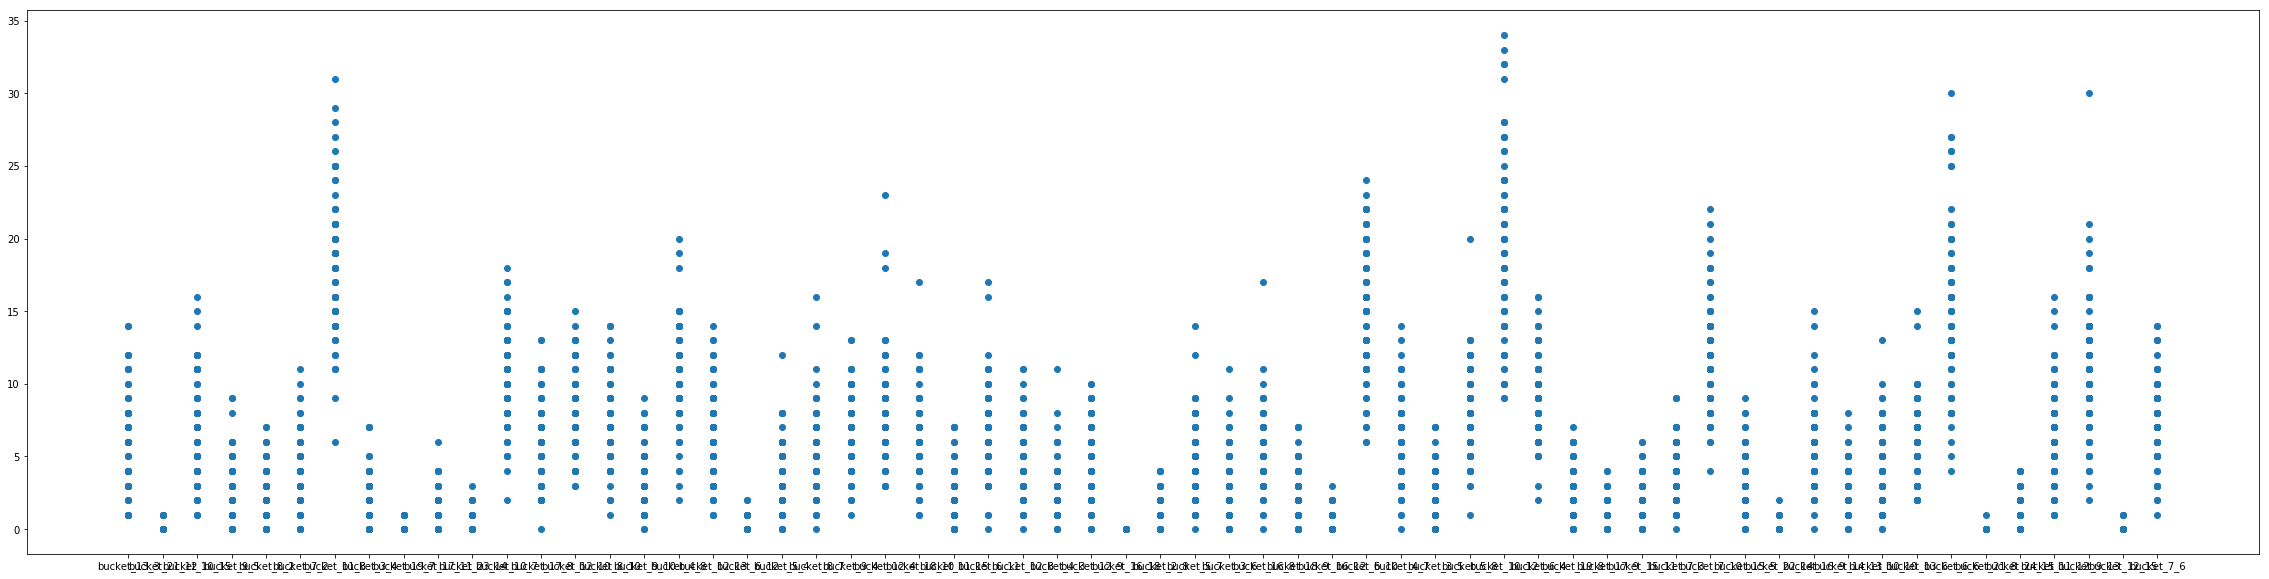

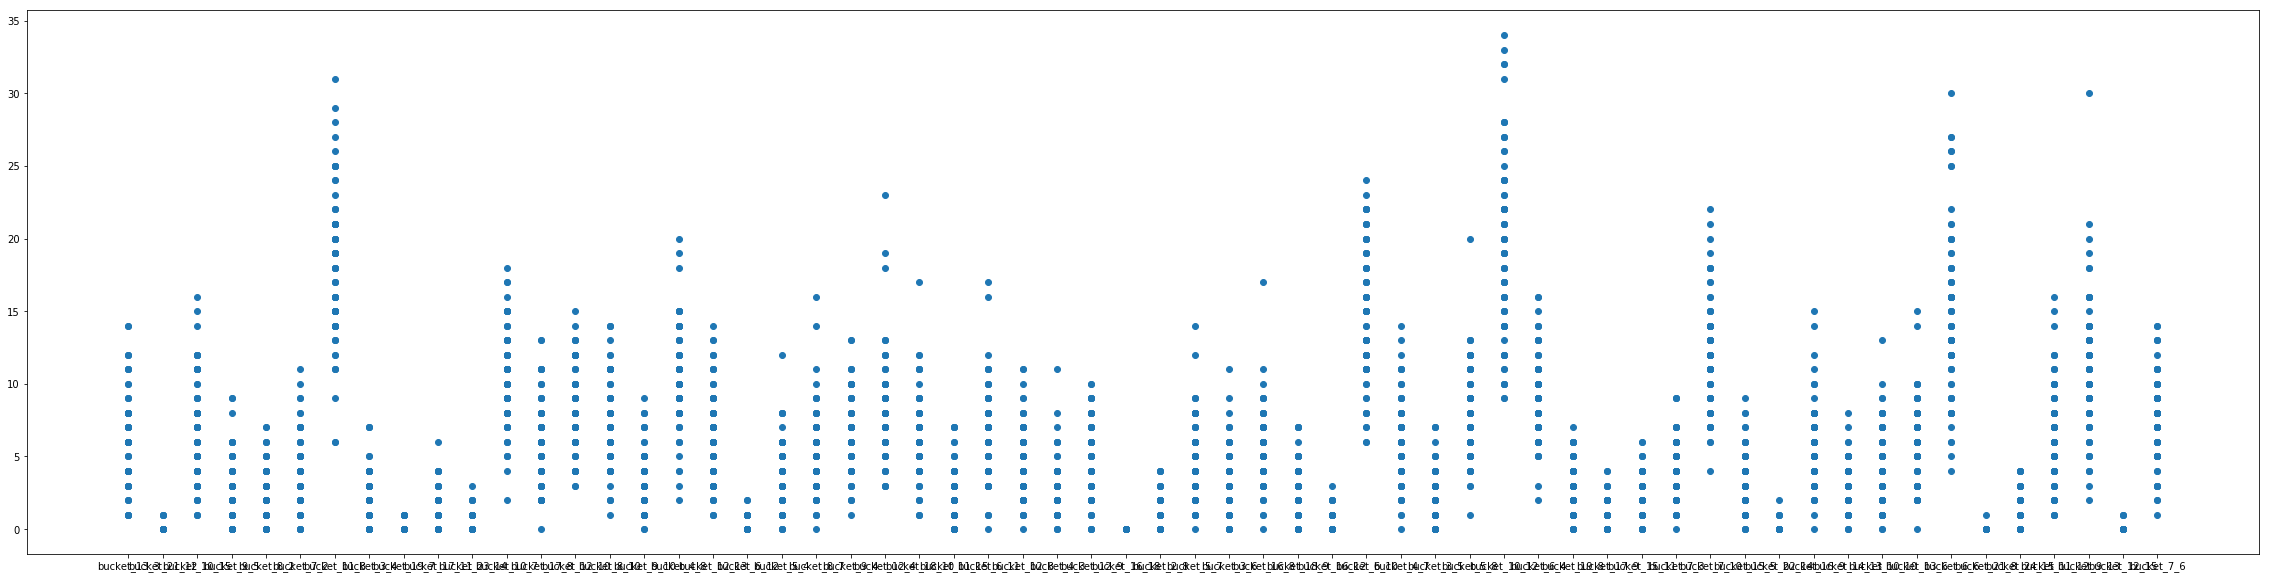

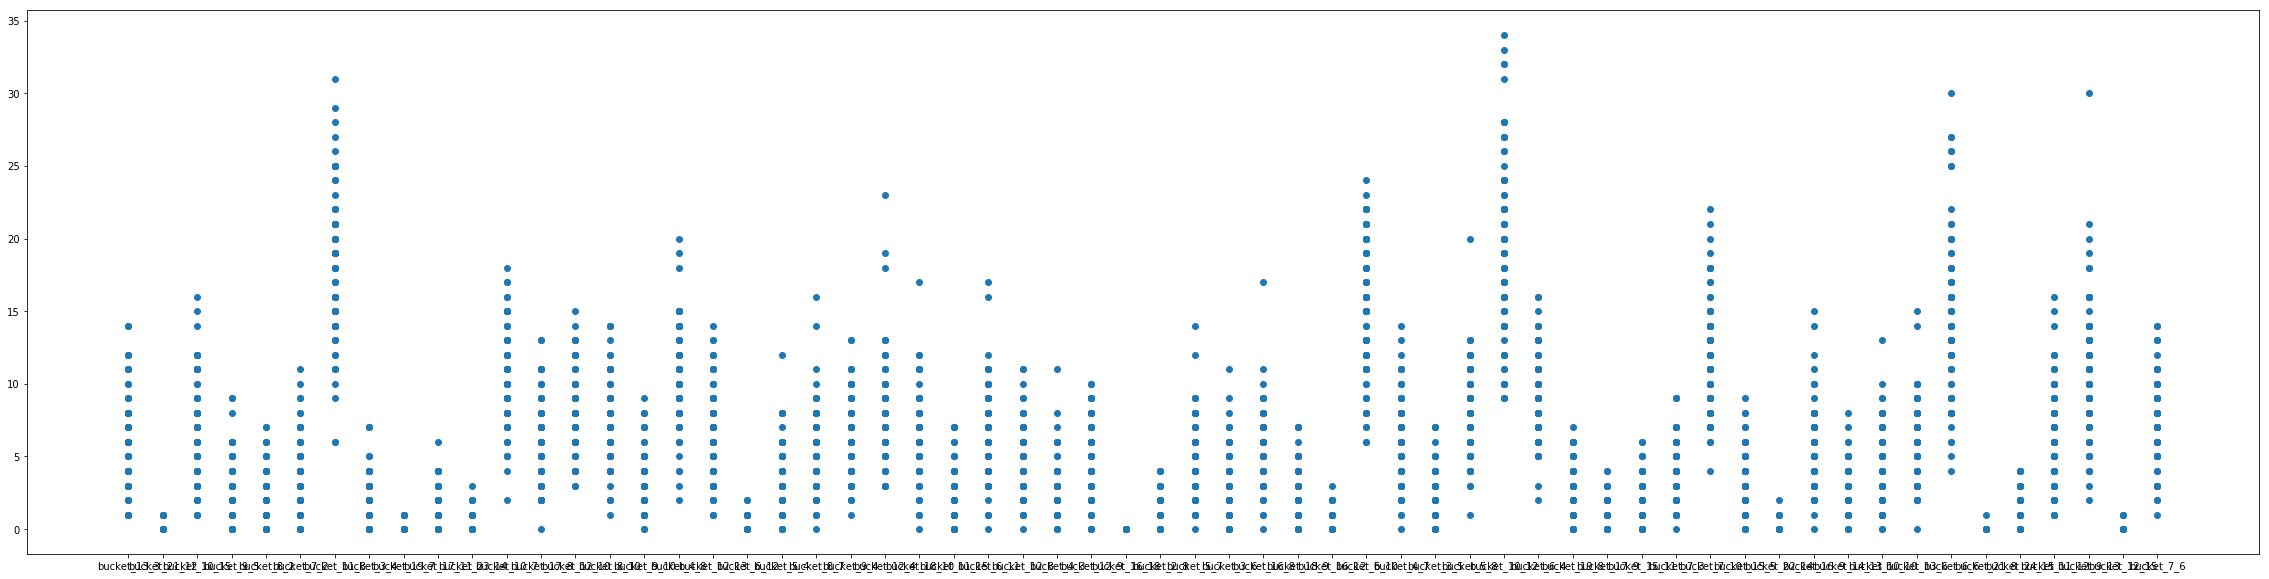

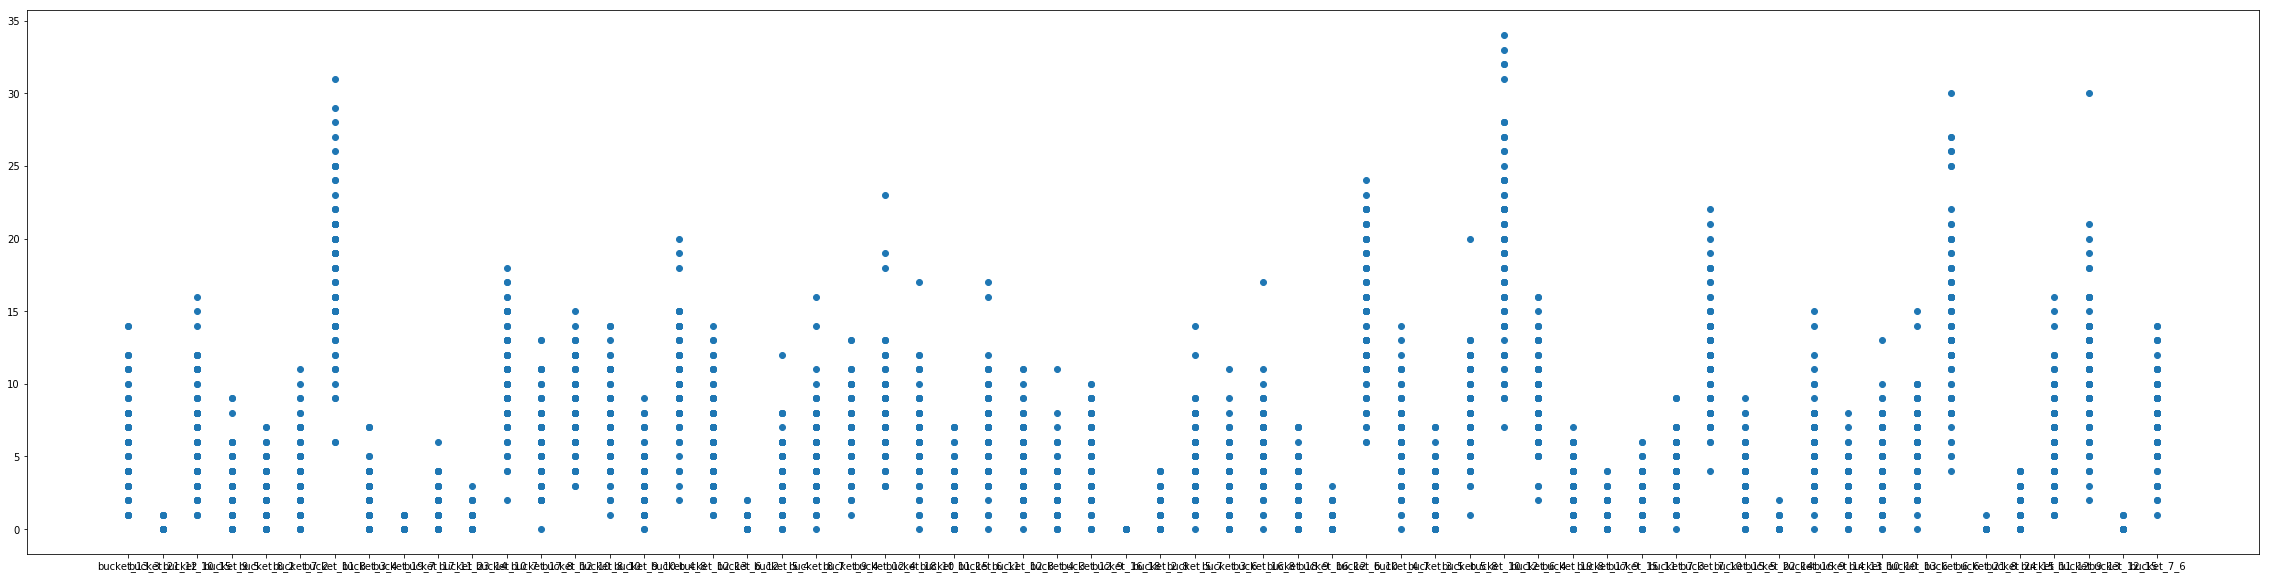

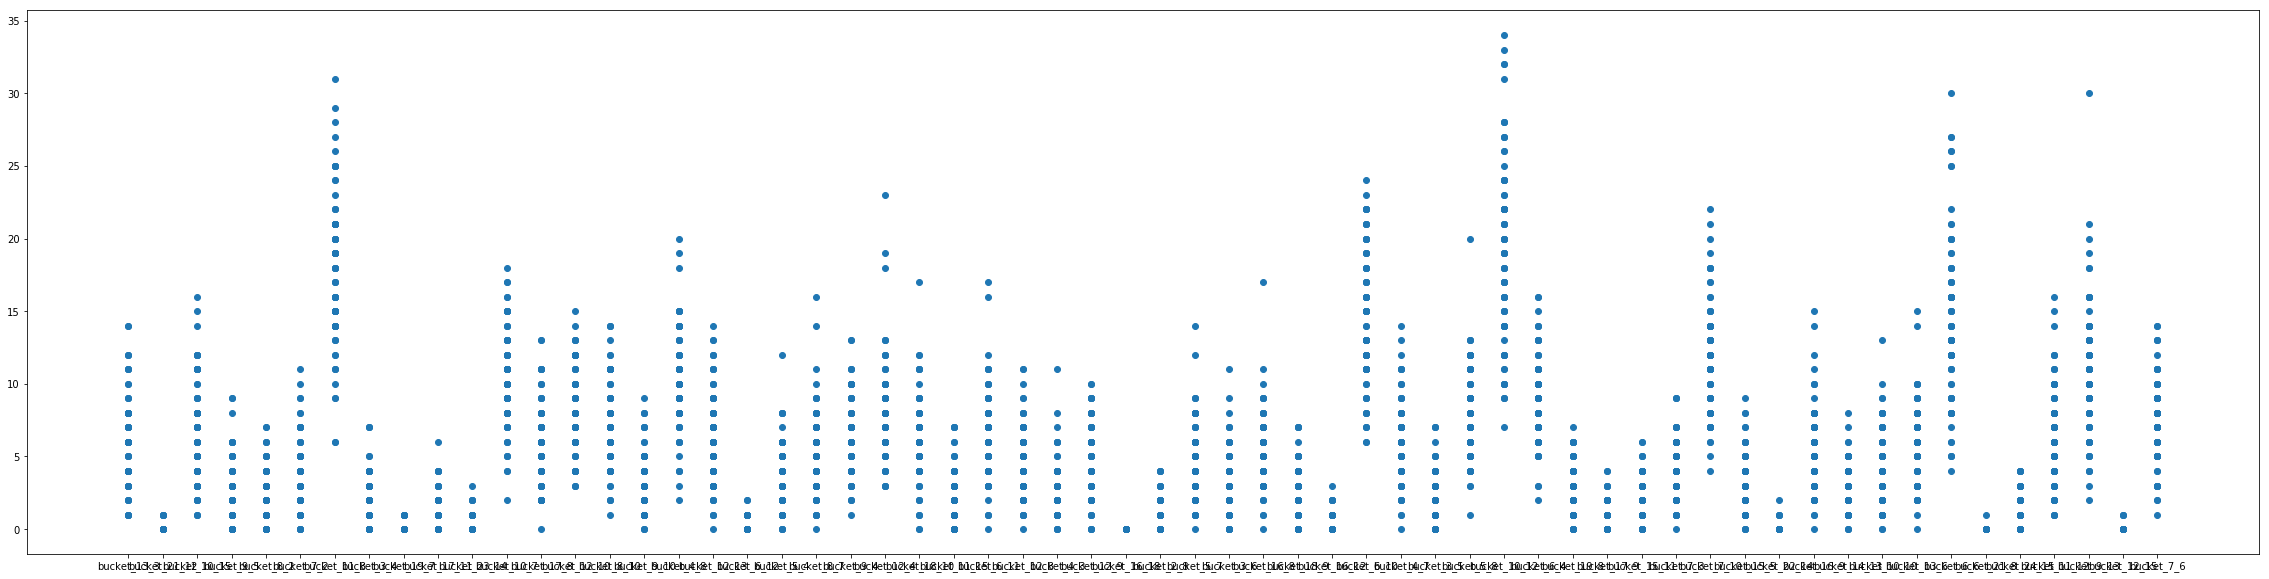

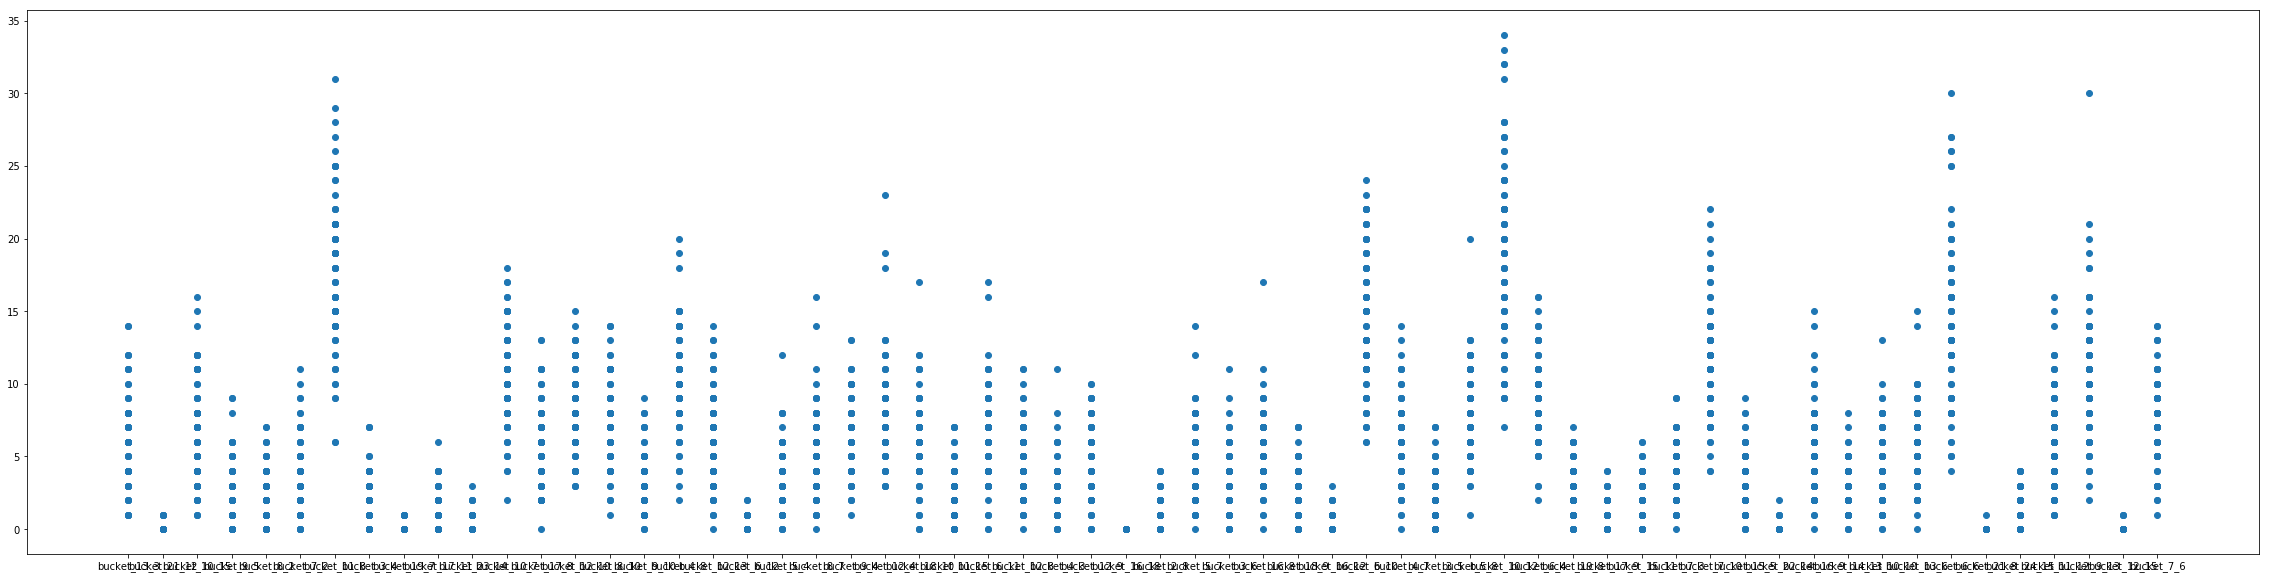

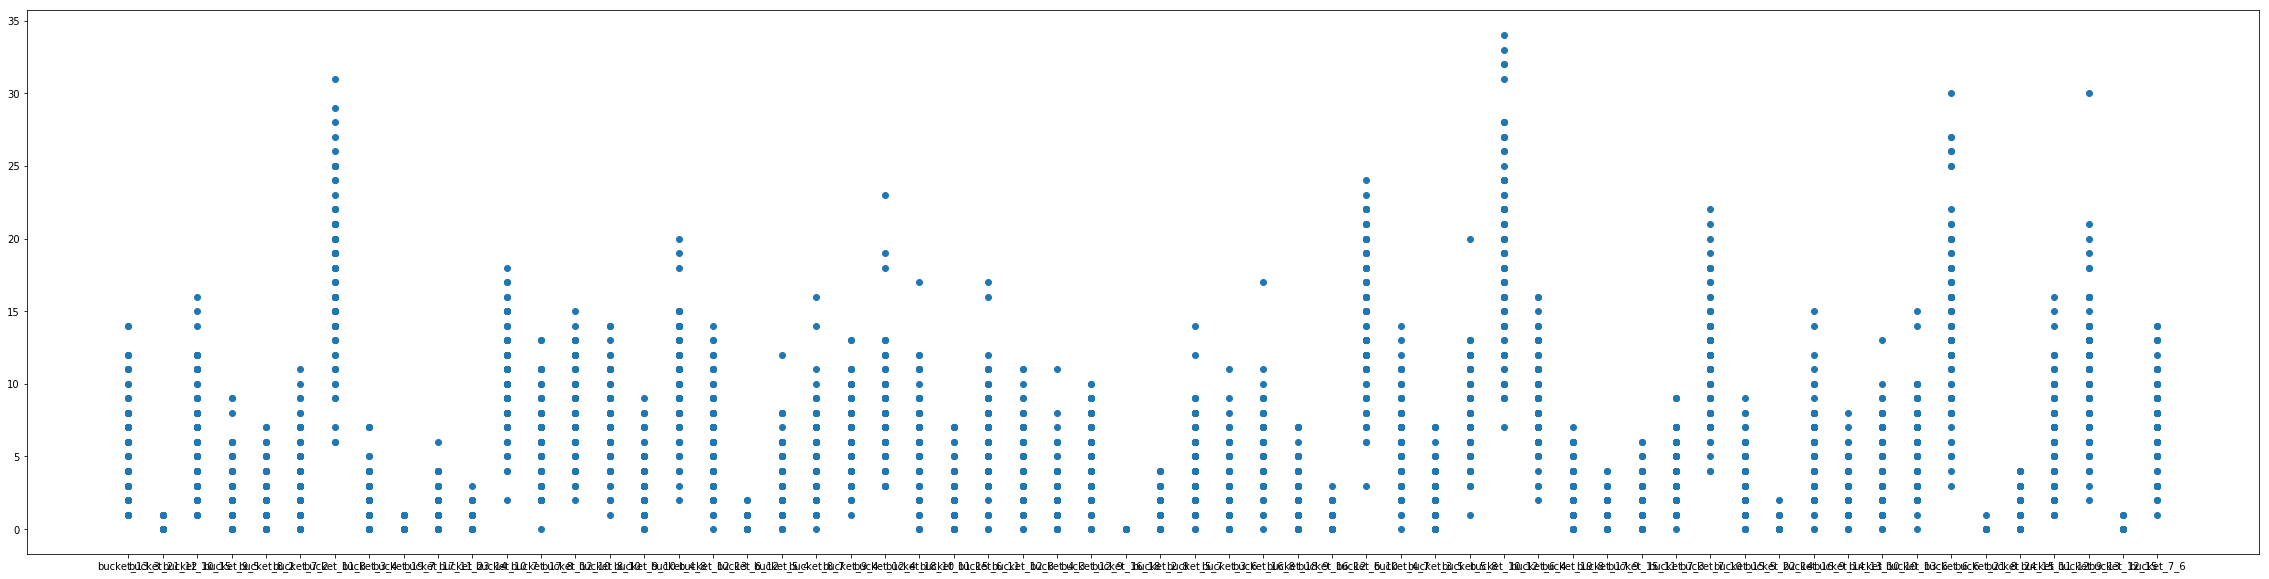

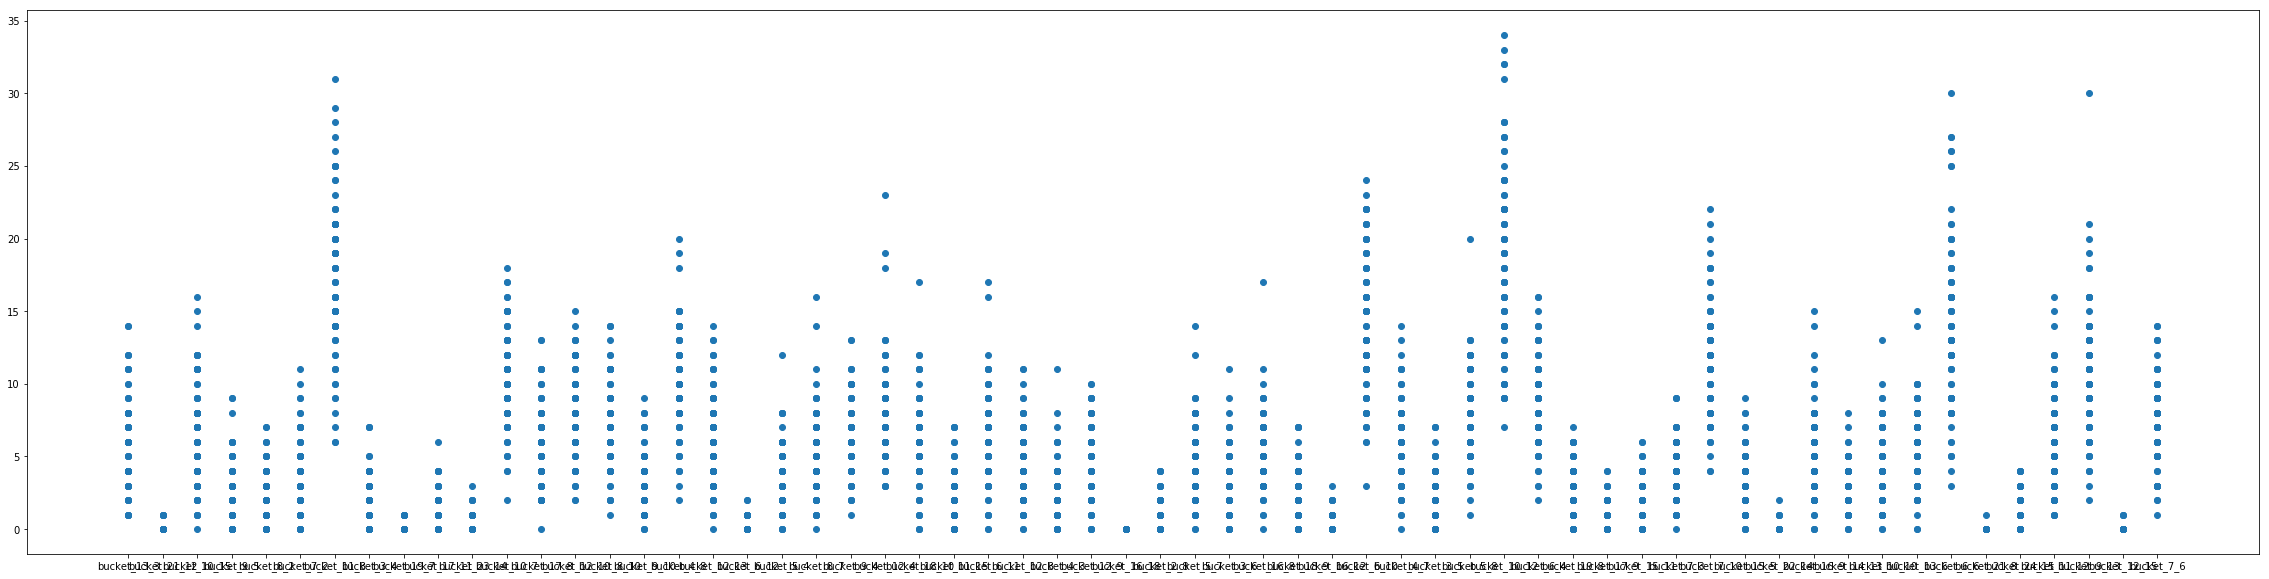

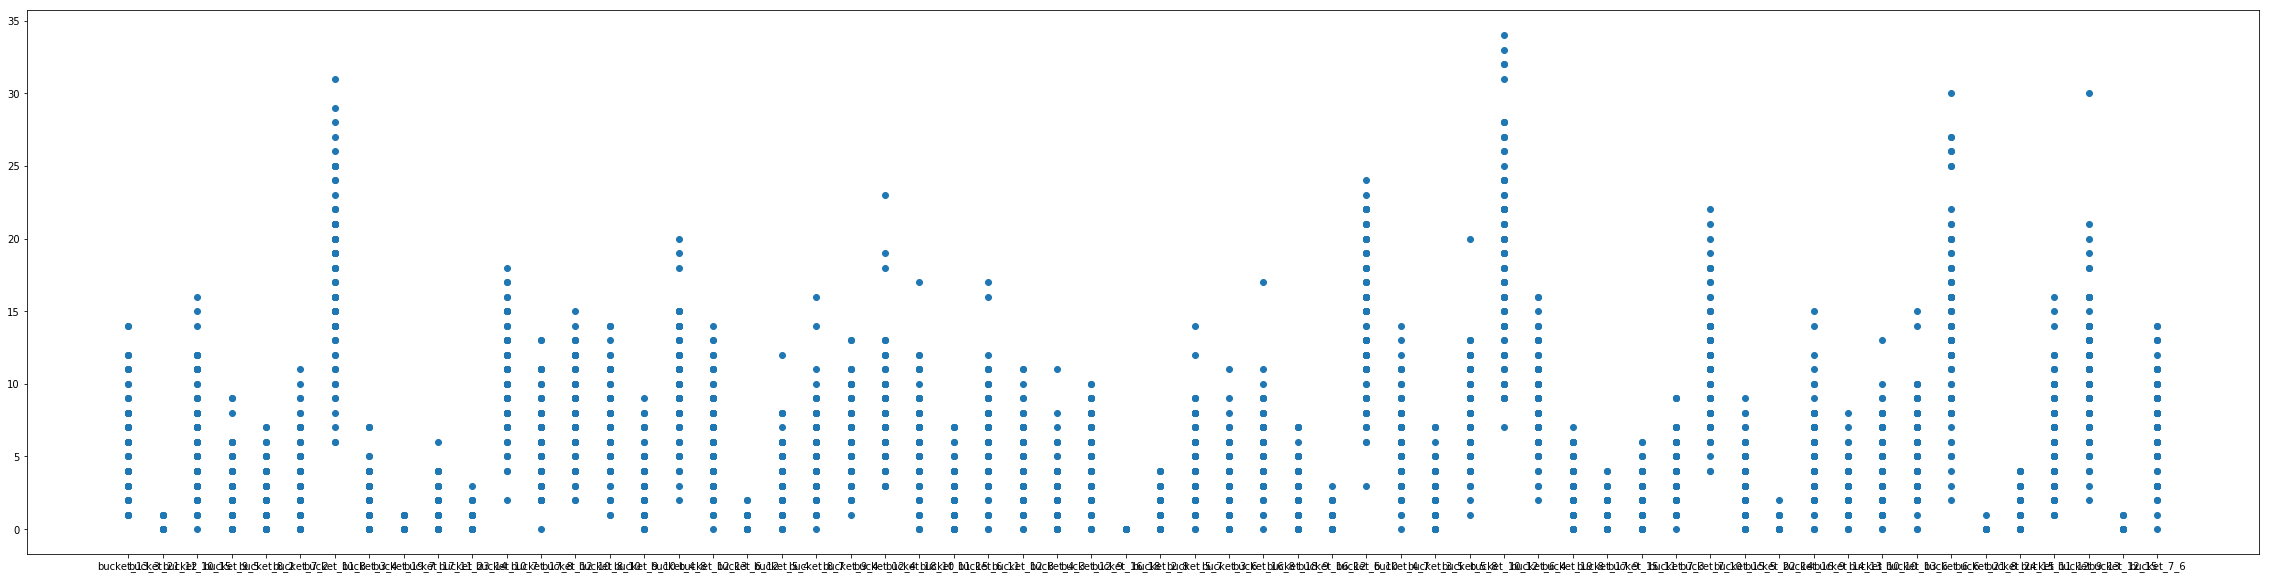

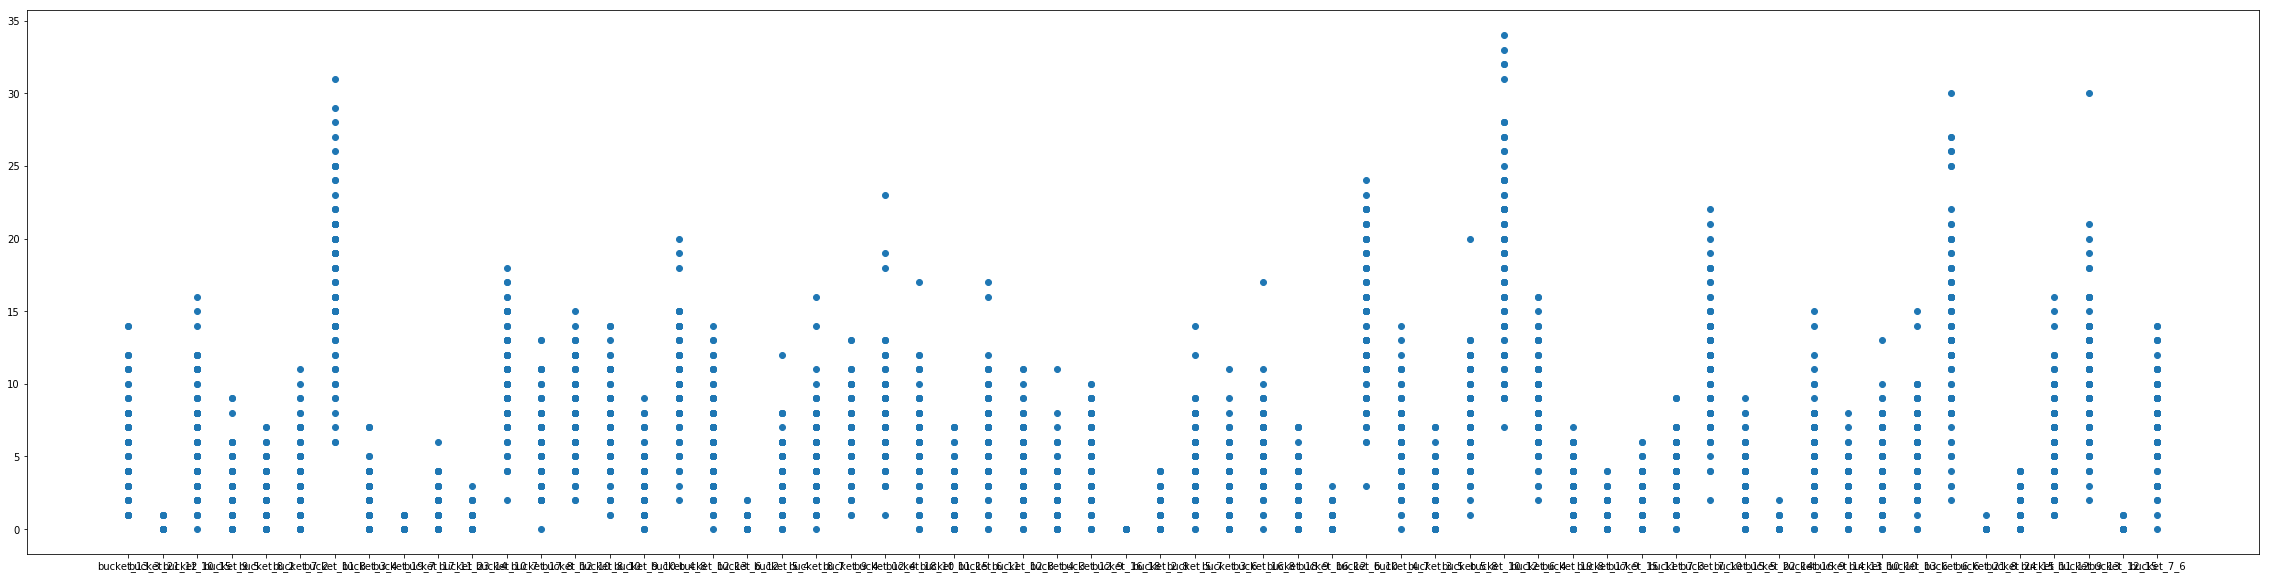

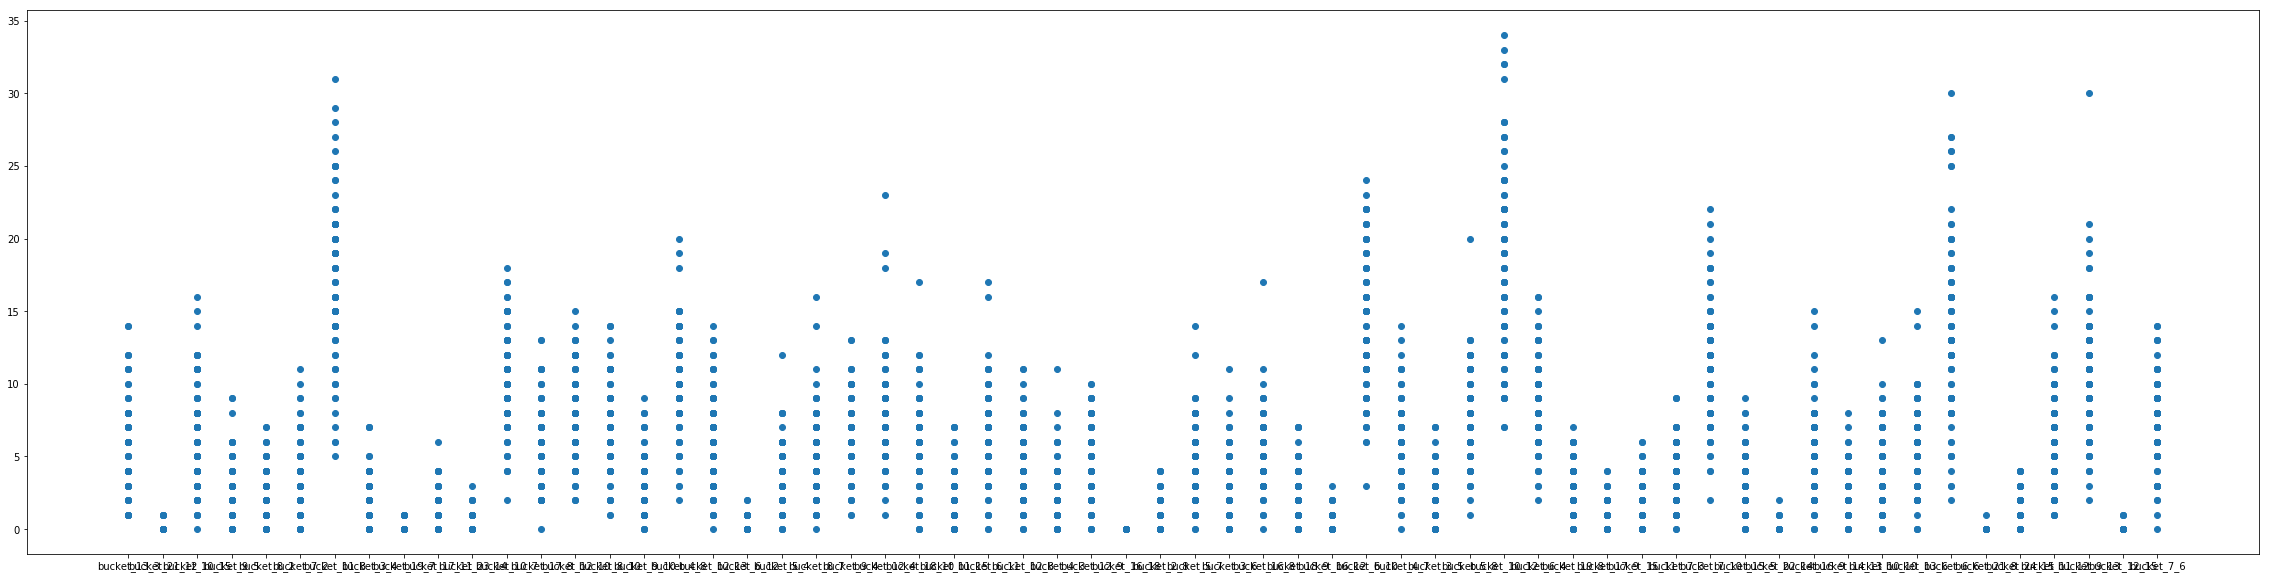

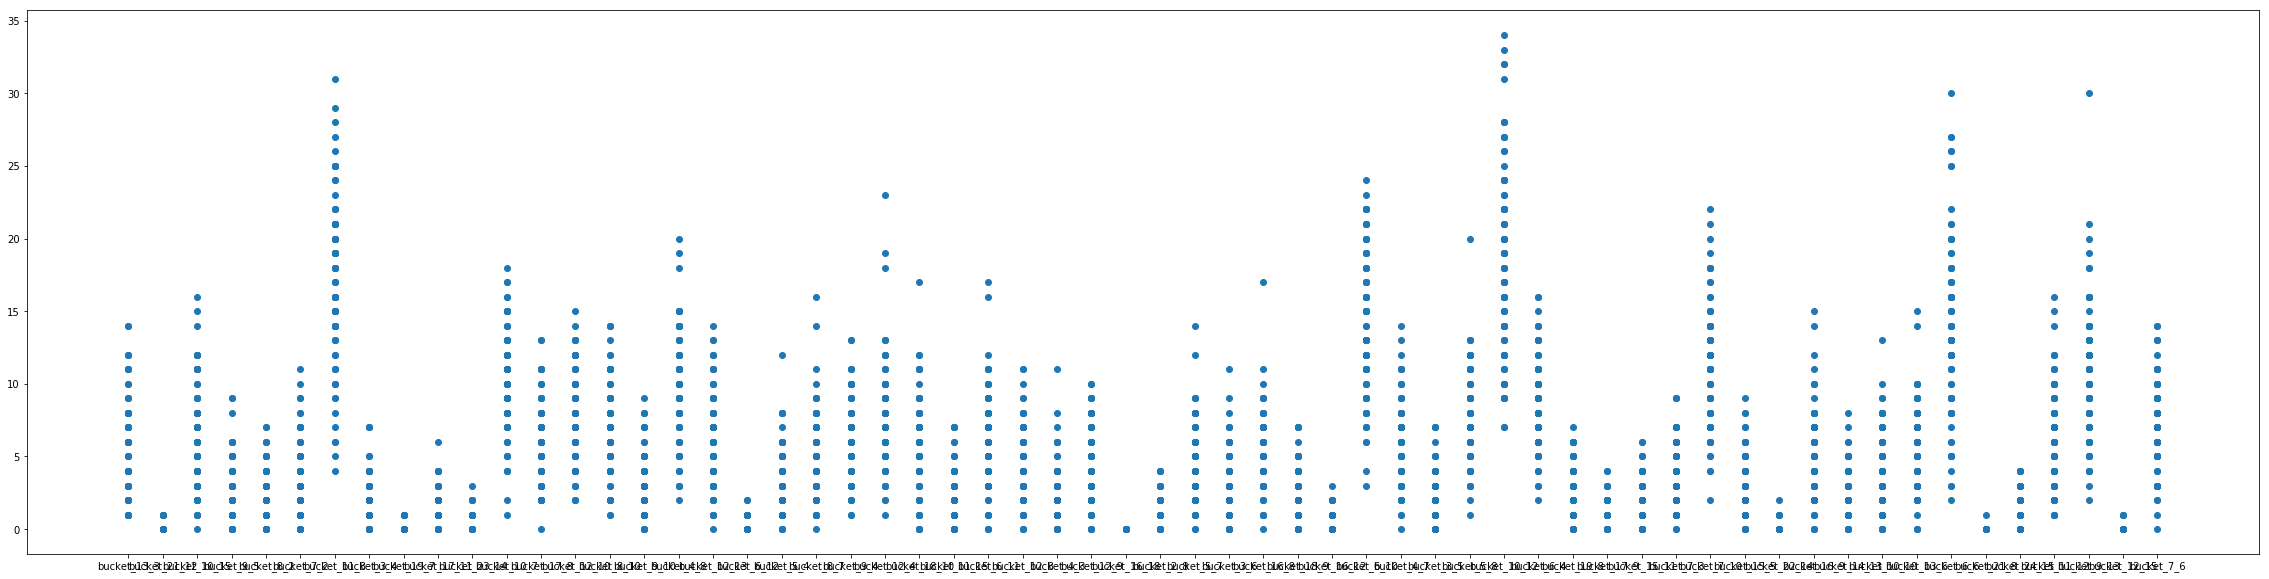

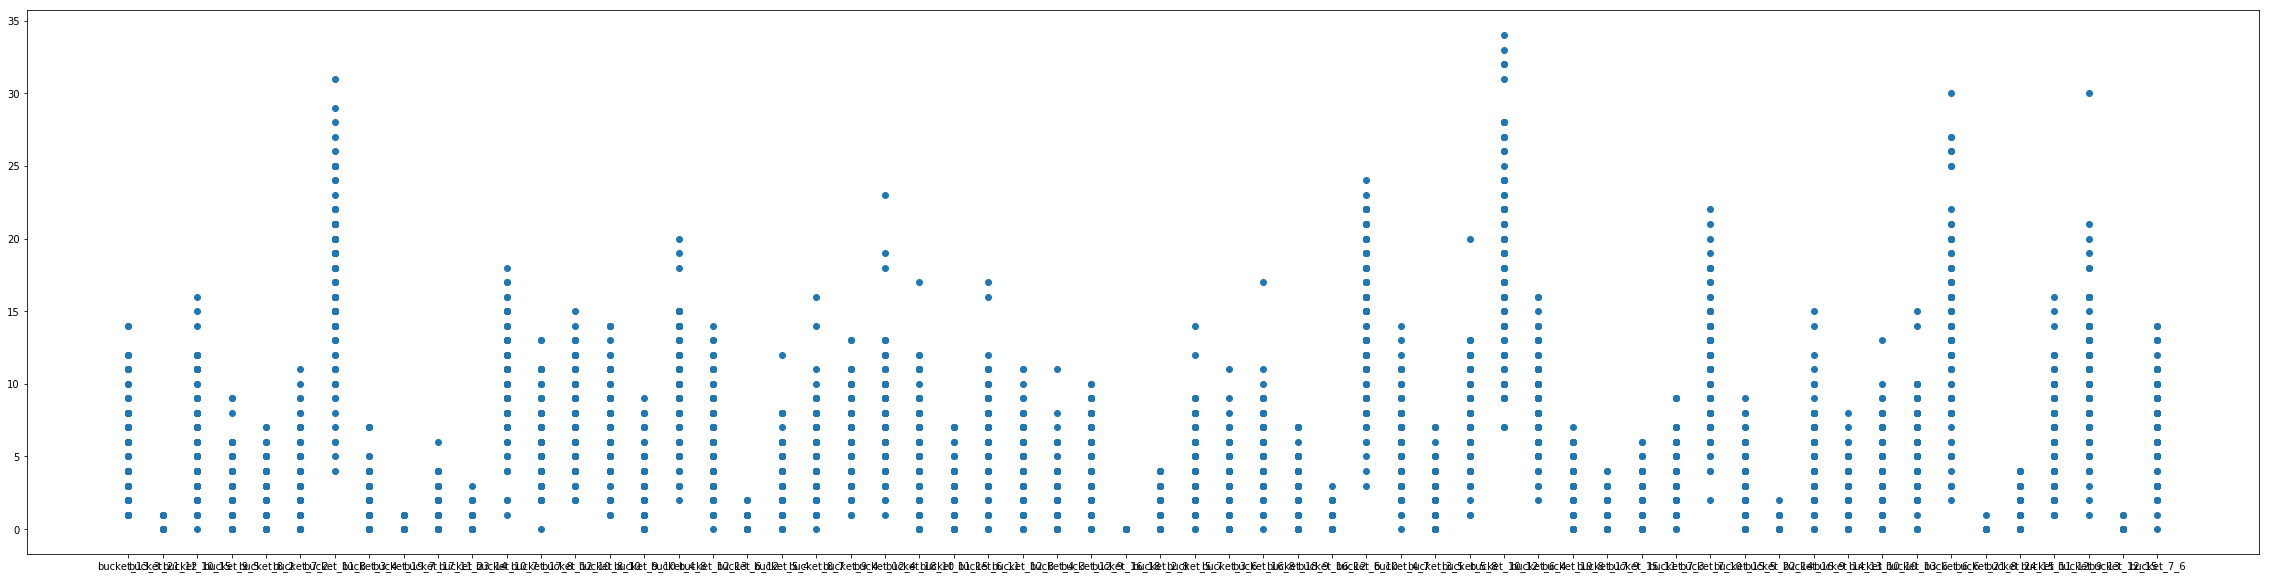

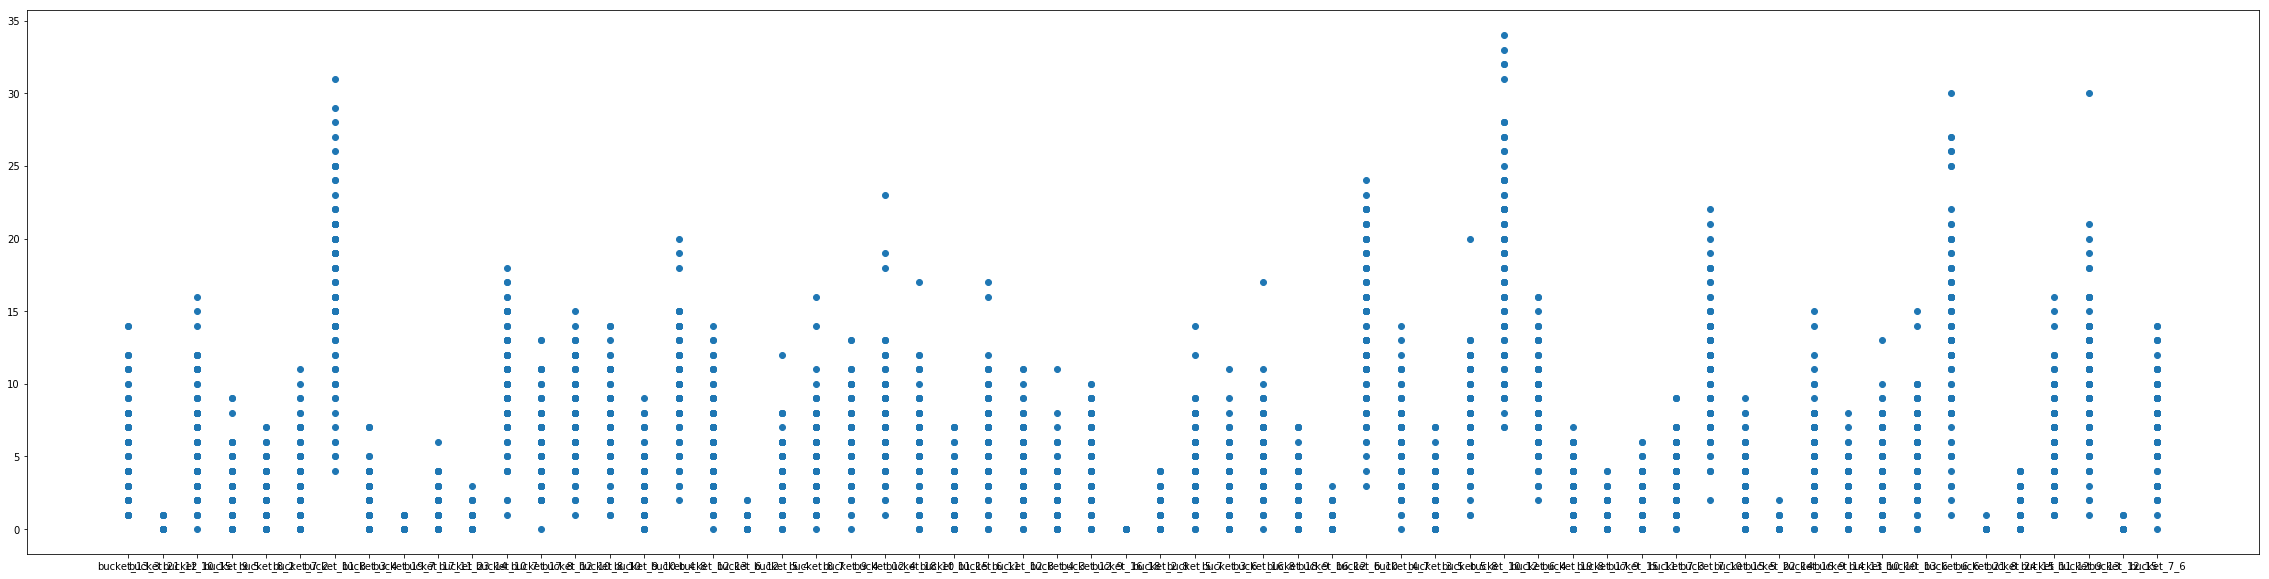

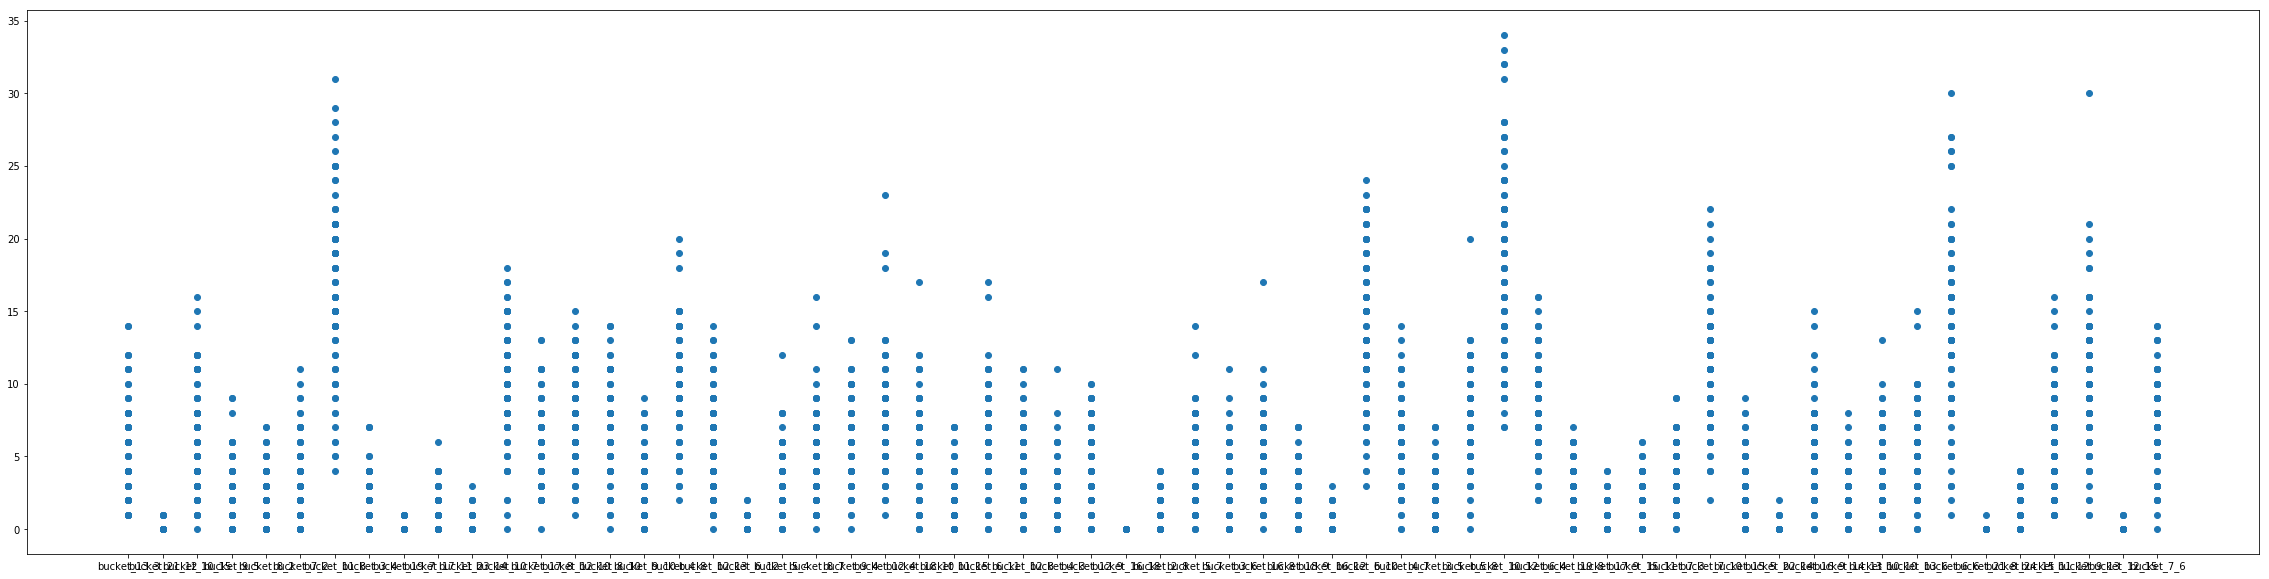

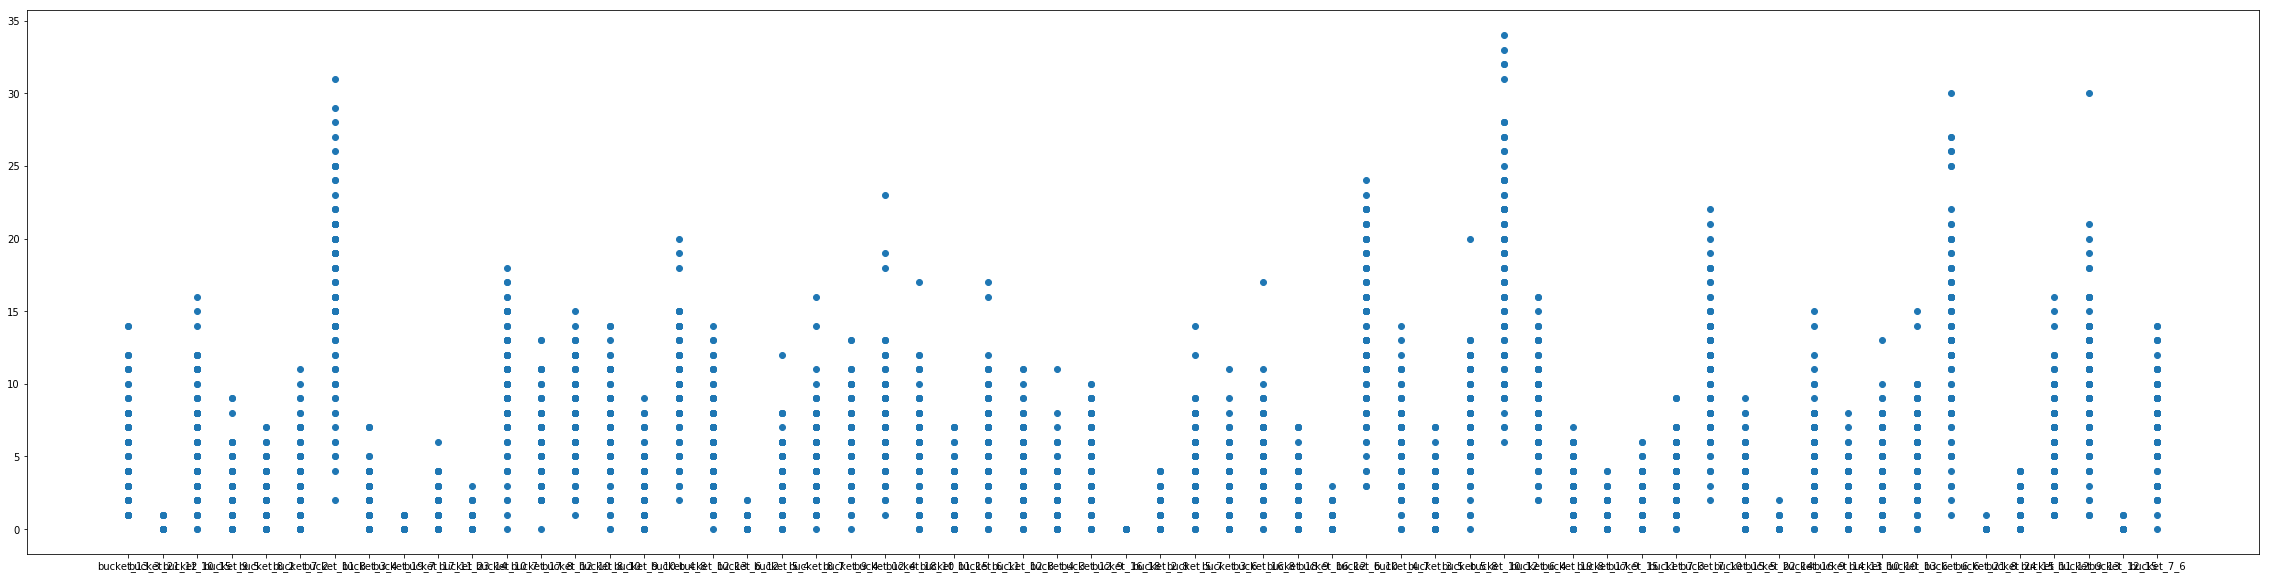

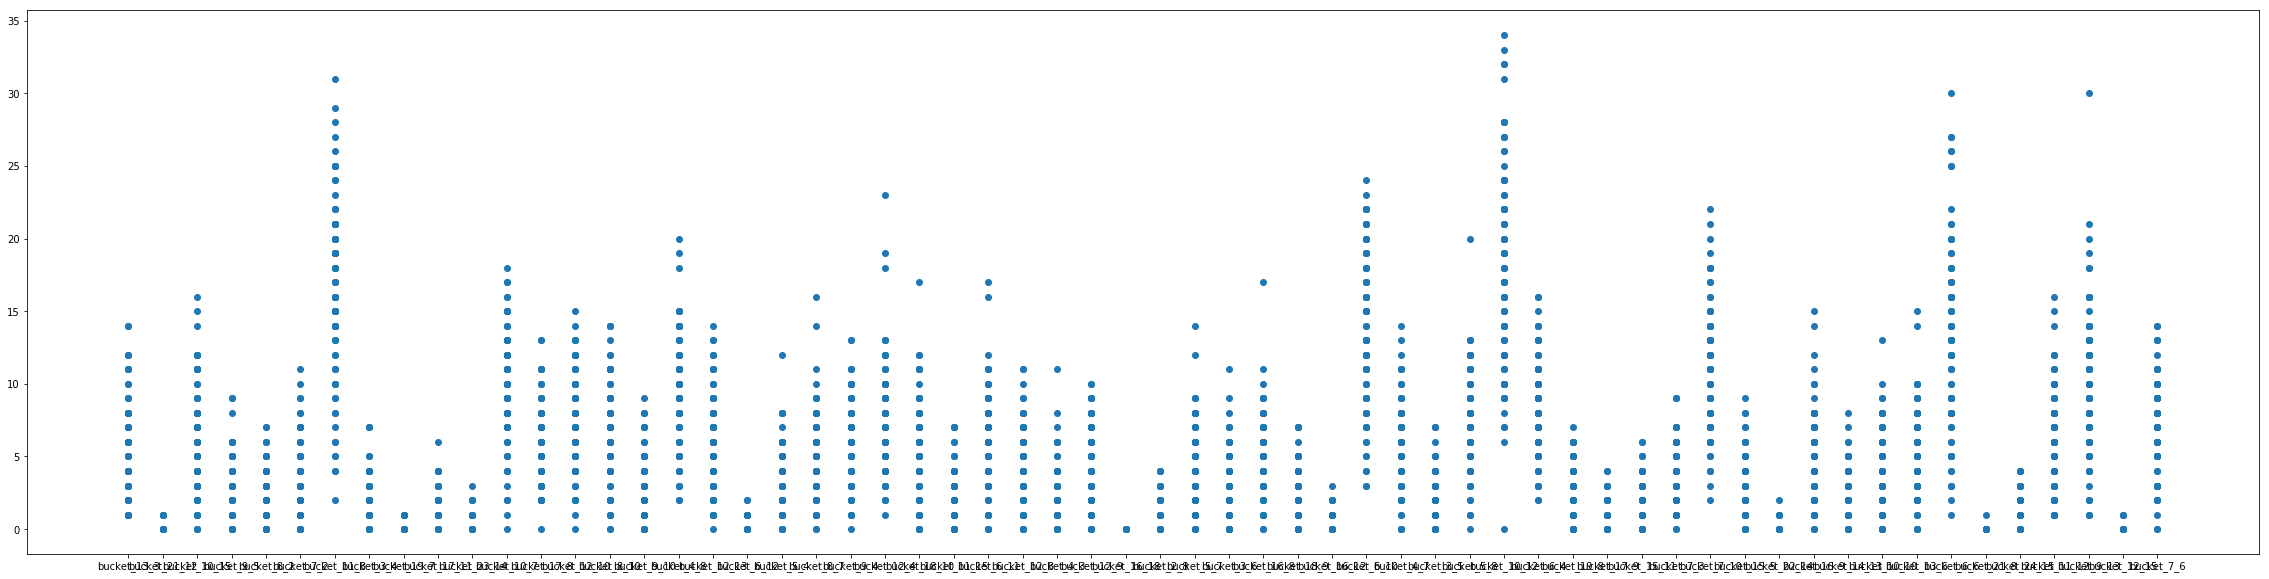

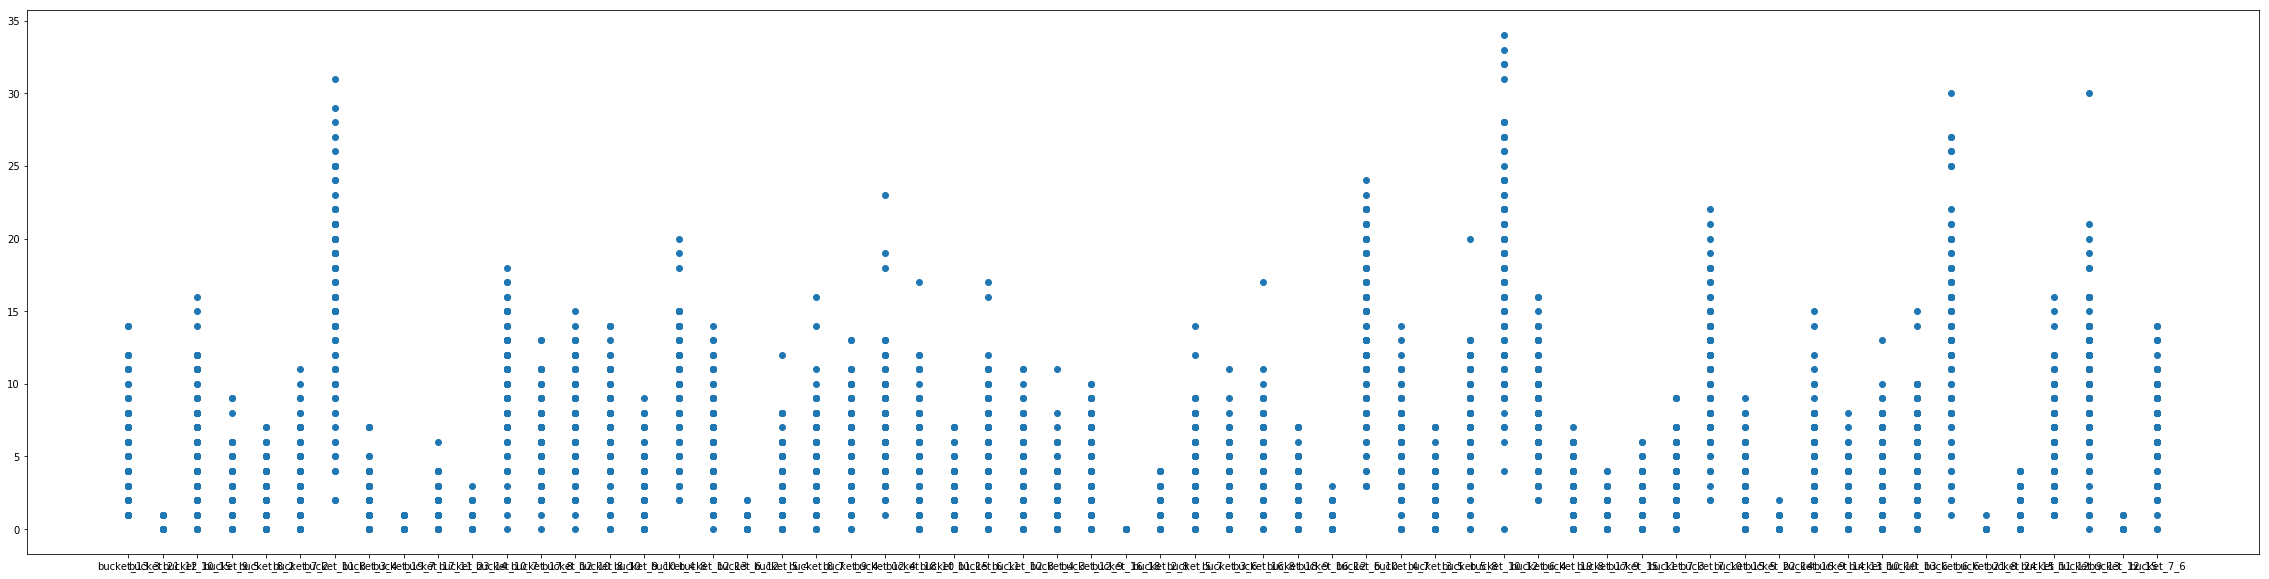

In [11]:
import matplotlib.pyplot as plt 
A = []
B = []
for i in range(len(X)) :
    for j in range(len(X[i])):
        
        A += [np.sum((X[i].T)[j])]
        B += [(bucketsname[i])['buckets'][j]]
    plt.figure(figsize=(40,10))
    plt.scatter(B,A)    
    plt.show()

# LSTM implementation

In [125]:
X = np.load('Dataset_crime_pred.npy')
X

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 2., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 2., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [170]:
#splitting data
x_train , y_train, x_test, y_test = X[:72] ,X[1:73],X[73:-1],X[74:]
#x_train_LSTM = np.reshape(x_train, (np.shape(x_train)[0],1, np.shape(x_train)[1]))
#x_test_LSTM = np.reshape(x_test, (np.shape(x_test)[0],1, np.shape(x_test)[1]))



In [267]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_train.shape, x_test.shape)

(72, 60, 200) (22, 60, 200)


In [172]:
x_train_log = np.where(x_train < 1 ,x_train ,1)
y_train_log = np.where(y_train < 1 ,y_train ,1)
x_test_log = np.where(x_test < 1 ,x_test ,1)
y_test_log = np.where(y_test < 1 ,y_test ,1)

In [173]:
print(y_test.shape, x_test.shape)

(22, 60, 200) (22, 60, 200)


In [174]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import BatchNormalization , ConvLSTM2D, Reshape, Flatten ,Bidirectional , RepeatVector

from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras import regularizers


In [175]:
x_cnn = x_train.reshape(-1,60,20, 10,1 )
x_tcnn = x_test.reshape(-1,60,20, 10,1 )


In [381]:
epochs = 80
batch_size = 20

model = Sequential() 
model.add(LSTM(200,recurrent_activation = 'relu', activation ='sigmoid',kernel_regularizer = regularizers.l2(0.1), input_shape = (60,200), return_sequences= True))
model.compile(loss = "mean_absolute_error", 
              optimizer = "adam"
                 )

model.summary()

history = model.fit(x_train,y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, y_test), verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 60, 200)           320800    
Total params: 320,800
Trainable params: 320,800
Non-trainable params: 0
_________________________________________________________________
Train on 72 samples, validate on 22 samples
Epoch 1/80
72/72 [==============================] - 12s 167ms/step - loss: 30.5002 - val_loss: 27.3384
Epoch 2/80
72/72 [==============================] - 2s 33ms/step - loss: 25.9660 - val_loss: 23.1574
Epoch 3/80
72/72 [==============================] - 2s 32ms/step - loss: 21.9508 - val_loss: 19.4787
Epoch 4/80
72/72 [==============================] - 2s 31ms/step - loss: 18.4303 - val_loss: 16.2736
Epoch 5/80
72/72 [==============================] - 2s 32ms/step - loss: 15.3727 - val_loss: 13.5070
Epoch 6/80
72/72 [==============================] - 2s 32ms/step - loss: 12.7411 - val_loss: 11.1395
Epoch 7/80
7

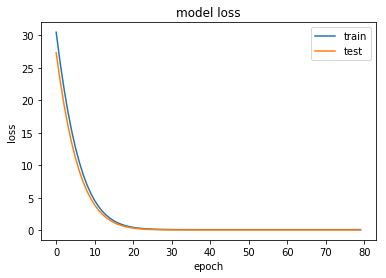

In [382]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [383]:
yhat = model.predict(x_test)


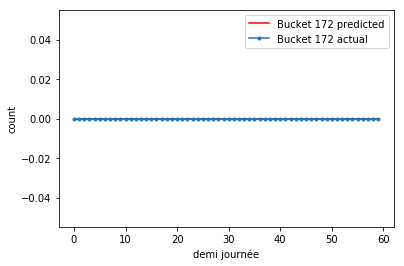

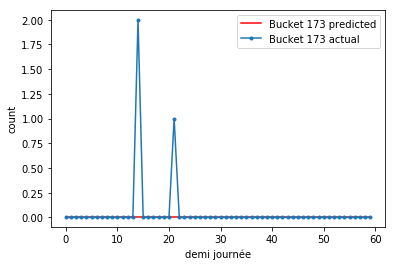

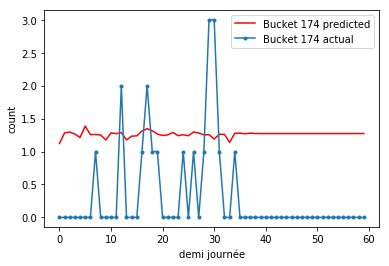

In [265]:
import warnings
warnings.filterwarnings('ignore')
labels = []
for i in range(172,175):
    plt.plot(range(60),yhat[11].T[i]*100, c = 'r')
    plt.plot(range(60),y_test[11].T[i],  marker='.')
    #labels.append('Bucket '+str(i))
    label = ['Bucket '+str(i)+' predicted', 'Bucket '+str(i)+' actual']
    plt.legend(label)
    plt.xlabel('demi journée')
    plt.ylabel('count')
    plt.show()

(<matplotlib.collections.PathCollection at 0x1b1cd171f60>,
 array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]))

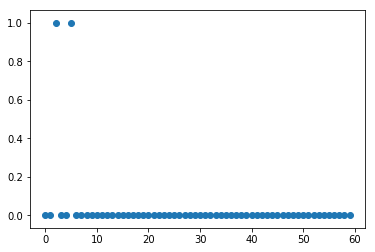

In [150]:
plt.scatter(range(60),scaled.T[11]),scaled.T[11]

In [261]:
from sklearn.metrics import accuracy_score

y_true = np.argmax(y_log[11], axis = 1)
y_pred = np.argmax(yhat_log[11], axis = 1)
accuracy_score(y_true, y_pred)

0.75

In [262]:
yhat_log[11].shape , y_log[11].shape , y_test_log.shape

((60, 200), (60, 12), (22, 60, 200))

In [78]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler(feature_range=(0, 1)).
scaled = scaler.fit_transform(y_test[11])

In [208]:
np.argmax(yhat[11],axis = 0) ,np.argmax(y_test[11],axis = 0)

(array([ 0,  0,  0,  0,  0,  0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  0,  0,
         0,  0,  0,  0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64),
 array([ 5,  0,  0,  0, 26, 31,  1,  0,  0,  0,  0,  5,  9, 18, 13, 34,  9,
        35,  

In [384]:
y_log = np.where(y_test.T < 1 ,y_test.T ,1)

In [269]:
y_test[0].T.shape,  y_log[0]

((200, 60), (22, 60, 200), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [271]:
accuracy_score(y_log.T[10], yhat_log.T[10])

ValueError: inconsistent shapes

In [270]:
yhat_log = np.where(yhat > 0.25 , 1 , 0)


In [52]:
y_test[0].T.shape

(200, 60)

# Accuracyy


In [468]:
A = []
accuracy  = np.array([])
for thresh in np.arange(0,np.max(yhat),0.0005):
    T = []

    yhat_log = np.where(yhat.T > thresh , 1 , 0)
    for i in range(200):
        y_pred = yhat_log[i]
        y_true = y_log[i]
        T.append(accuracy_score(y_true, y_pred))
        
    accuracy = np.hstack((accuracy,np.array(T)))
    A.append(np.mean(T))
#plt.plot(range(12),T)
#plt.show()

In [463]:
acc = np.array(accuracy)
thresh_ind = np.argmax(acc,axis =0)
np.argmax(thresh_ind)

0

In [459]:
L = []
for i in range(21):
    L.append(np.mean(acc[i]))

print(L,L.index(max(L)))

[0.5616666666666668, 0.5617500000000001, 0.5617500000000001, 0.5617500000000001, 0.5617500000000001, 0.5617500000000001, 0.5617500000000001, 0.5617500000000001, 0.5617500000000001, 0.5616666666666668, 0.5616666666666668, 0.5616666666666668, 0.5616666666666668, 0.5616666666666668, 0.5616666666666668, 0.5616666666666668, 0.5616666666666668, 0.5616666666666668, 0.5624166666666668, 0.5624166666666668, 0.5624166666666668] 18


In [437]:
yhat.T.shape

(200, 60, 22)

In [427]:
np.max(yhat), np.max((yhat.T)[0]) , np.arange(0,np.max(yhat),0.0005)[thresh_ind[0]]

(0.010219417, 0.0, 0.004)

In [460]:
yhat_log = np.zeros((200,60,22))
for i in range(200):
    yhat_log[i] =  np.where((yhat.T)[i] > np.arange(0,np.max(yhat),0.0005)[thresh_ind[i]] , 1 , 0)
    
    
yhat_log    

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

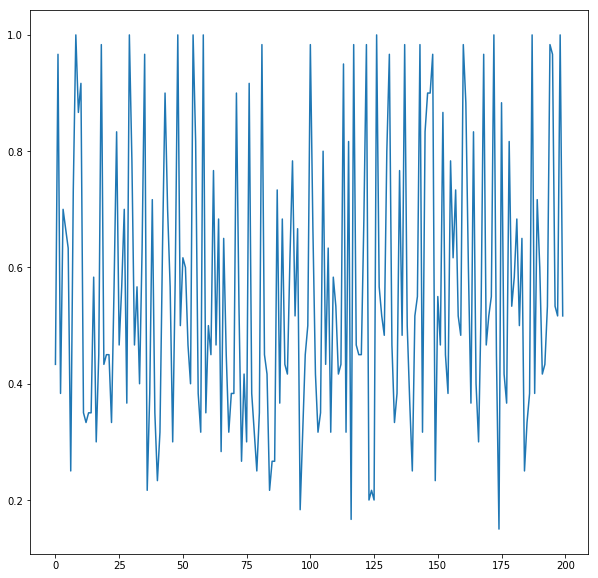

In [461]:
T = []
accuracy  = np.array([])
for i in range(200):
    y_pred = yhat_log[i]
    y_true = y_log[i]
    T.append(accuracy_score(y_true, y_pred))
accuracy = np.hstack((accuracy,np.array(T)))
plt.figure(figsize = (10,10))
plt.plot(range(200),accuracy)
plt.show()

0.43333333333333335


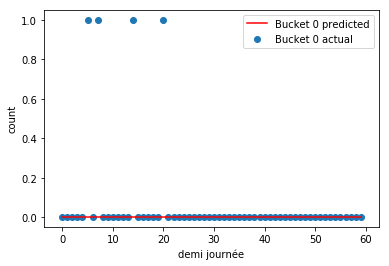

0.9666666666666667


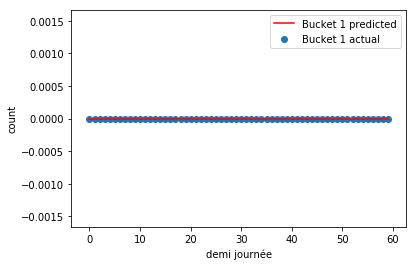

0.38333333333333336


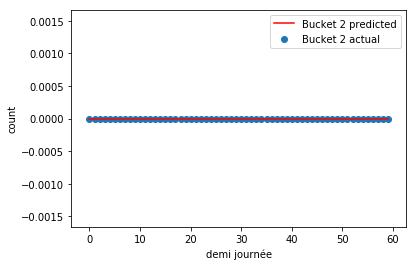

0.7


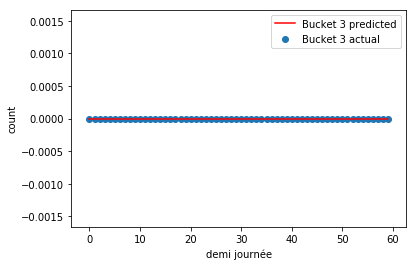

0.6666666666666666


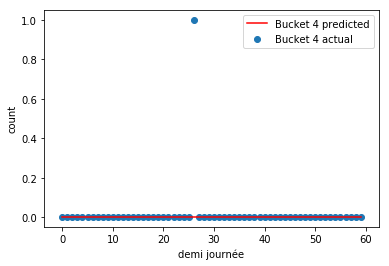

0.6333333333333333


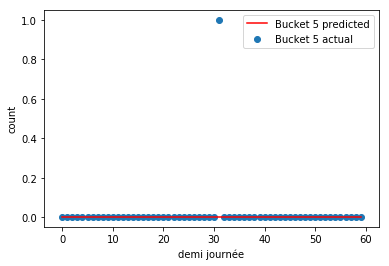

0.25


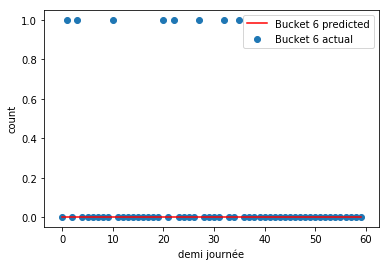

0.7333333333333333


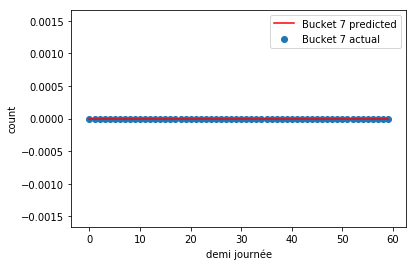

1.0


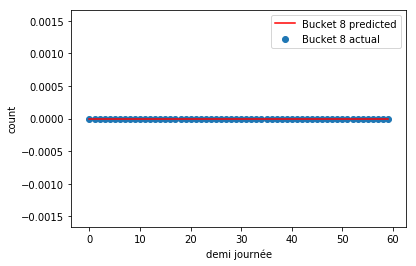

0.8666666666666667


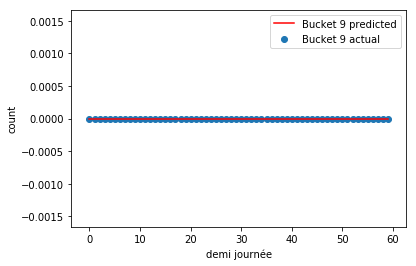

0.9166666666666666


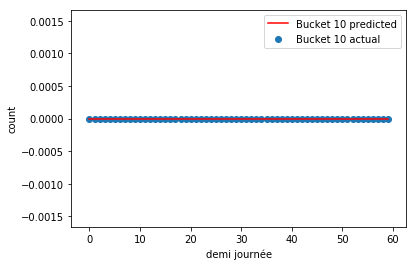

0.35


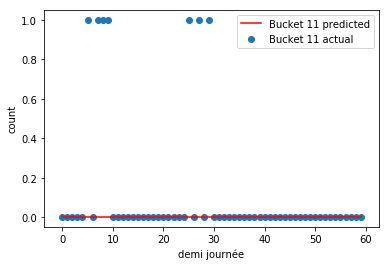

0.3333333333333333


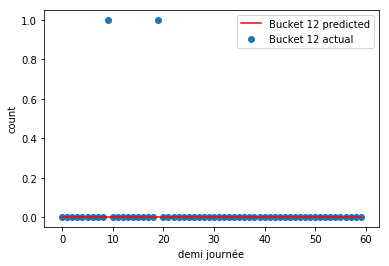

0.35


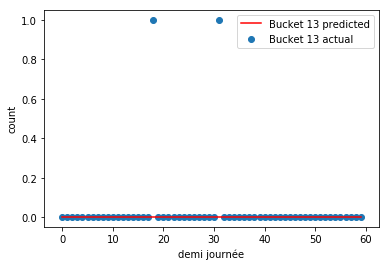

0.35


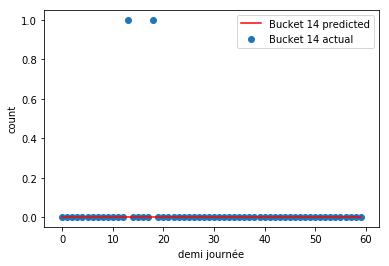

0.5833333333333334


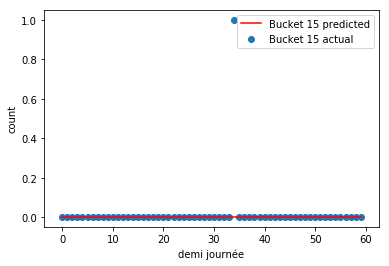

0.3


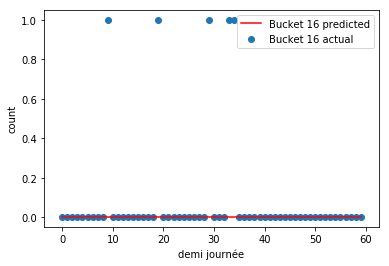

0.45


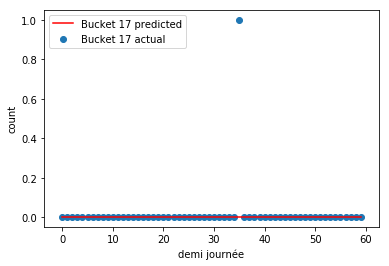

0.9833333333333333


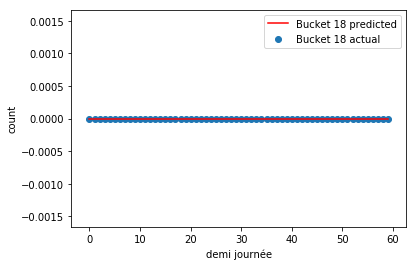

0.43333333333333335


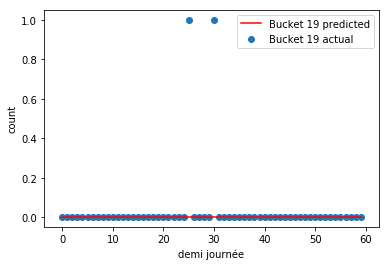

0.45


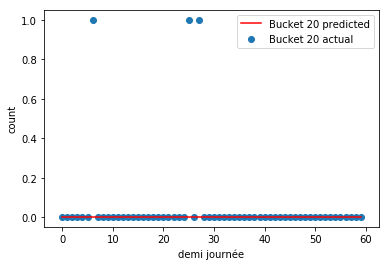

0.45


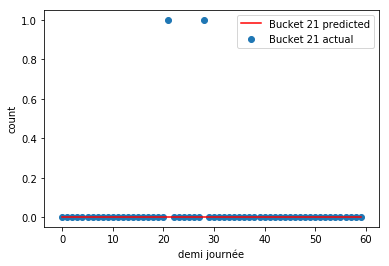

0.3333333333333333


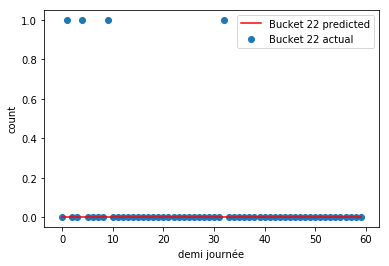

0.5666666666666667


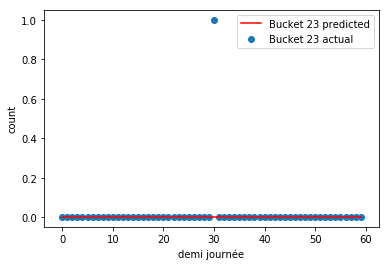

0.8333333333333334


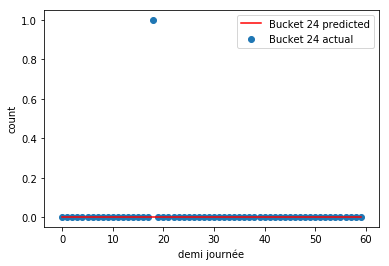

0.4666666666666667


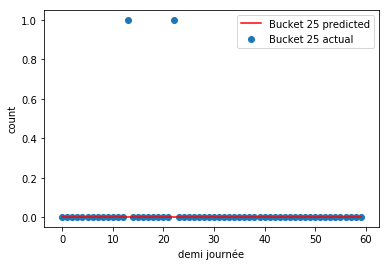

0.5666666666666667


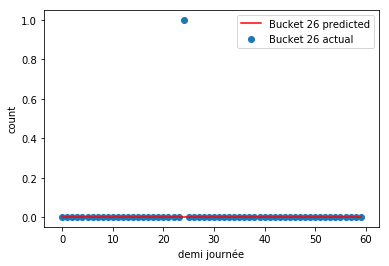

0.7


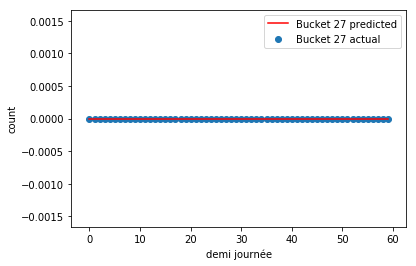

0.36666666666666664


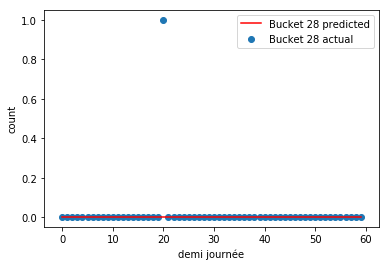

1.0


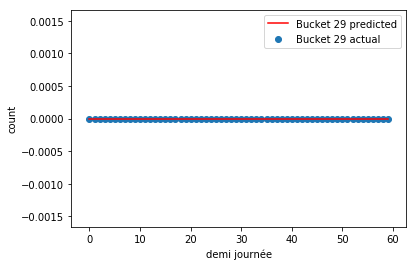

0.7833333333333333


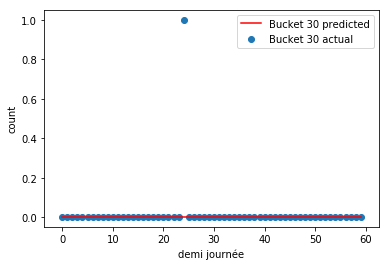

0.4666666666666667


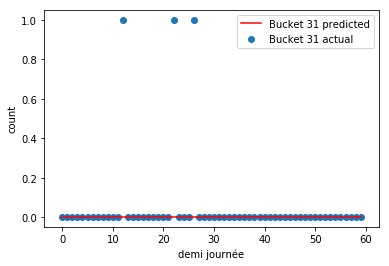

0.5666666666666667


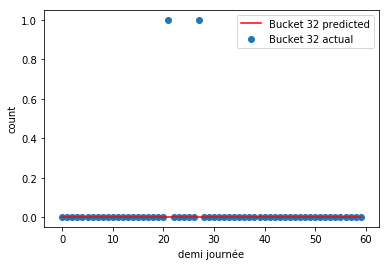

0.4


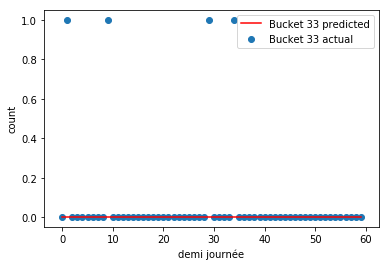

0.6333333333333333


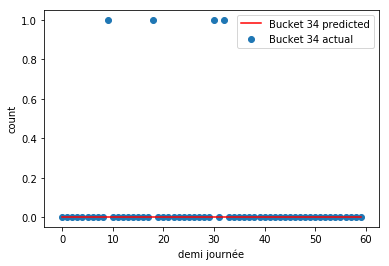

0.9666666666666667


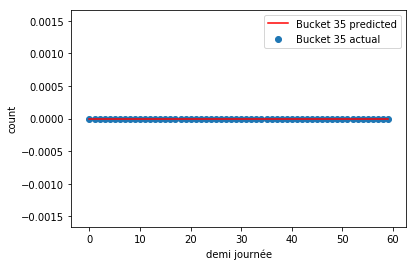

0.21666666666666667


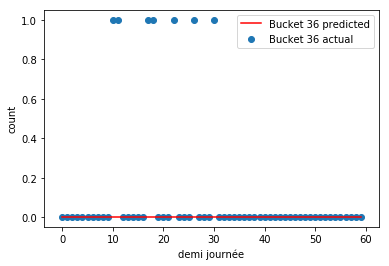

0.38333333333333336


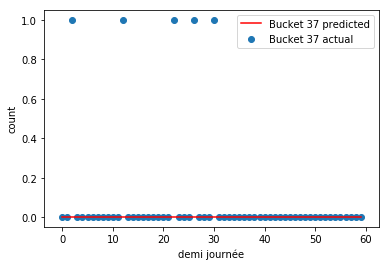

0.7166666666666667


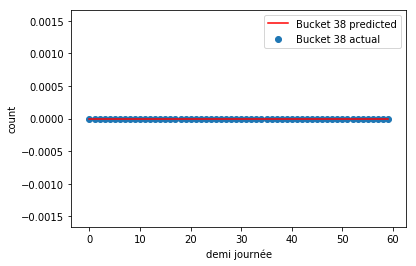

0.35


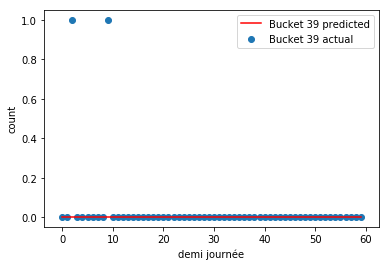

0.23333333333333334


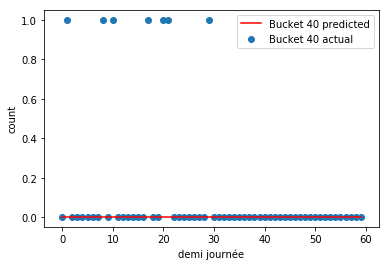

0.31666666666666665


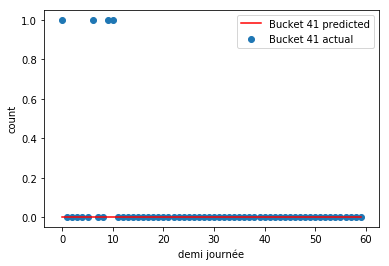

0.6333333333333333


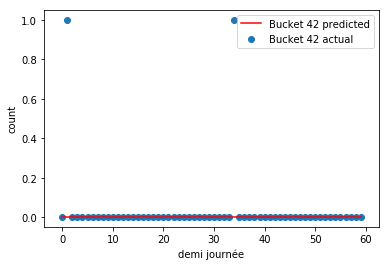

0.9


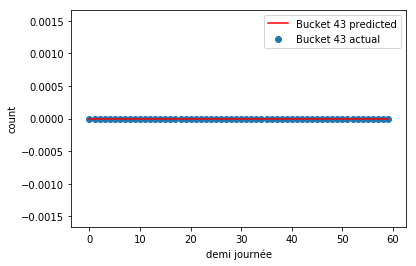

0.7


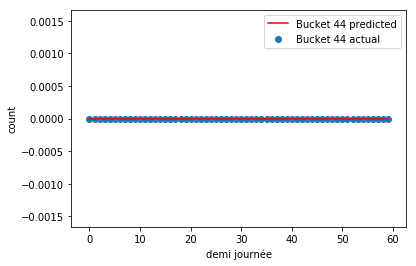

0.5666666666666667


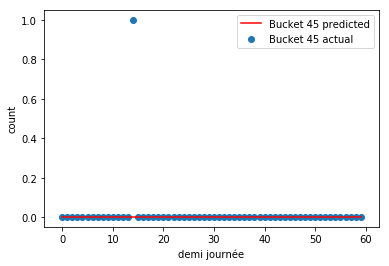

0.3


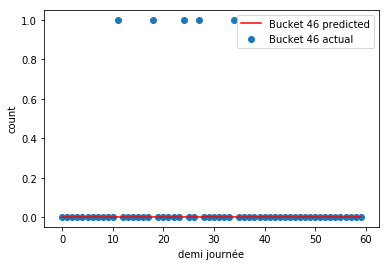

0.5833333333333334


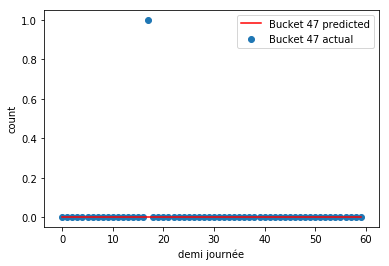

1.0


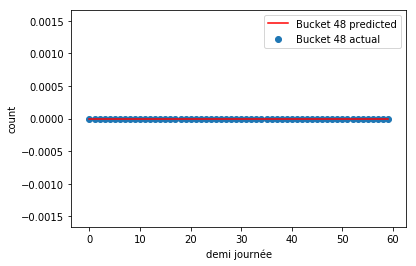

0.5


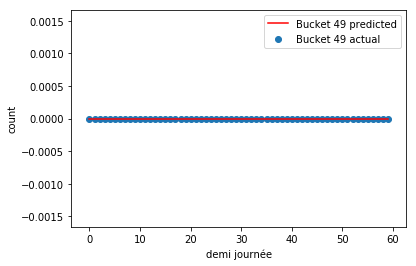

0.6166666666666667


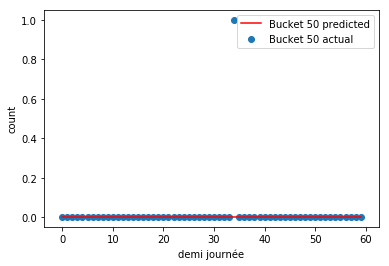

0.6


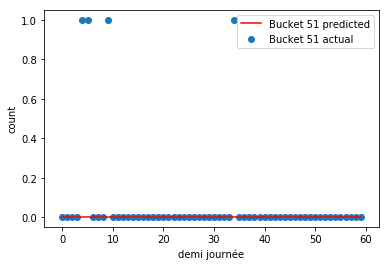

0.4666666666666667


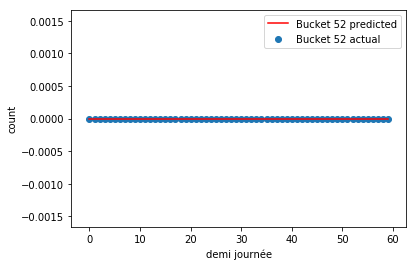

0.4


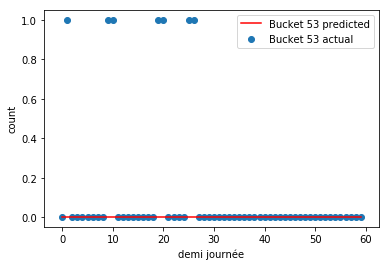

1.0


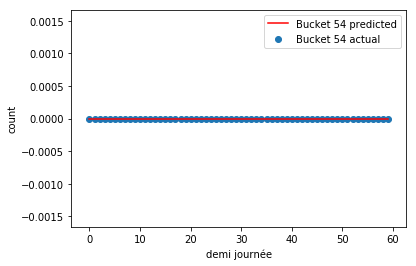

0.8166666666666667


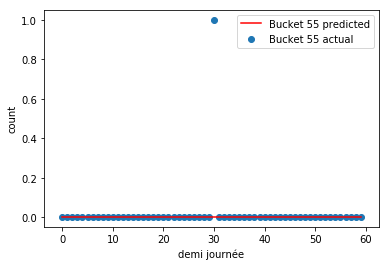

0.38333333333333336


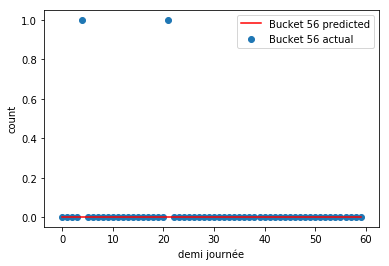

0.31666666666666665


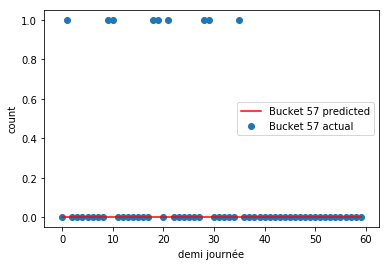

1.0


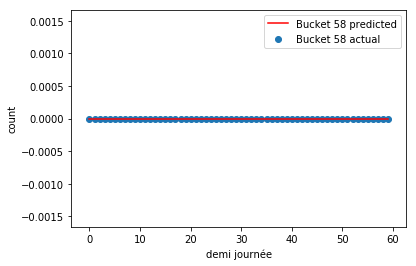

0.35


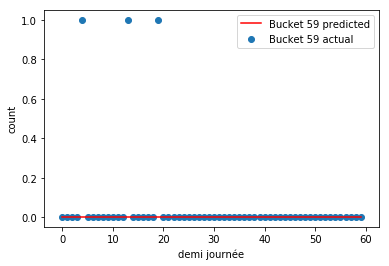

0.5


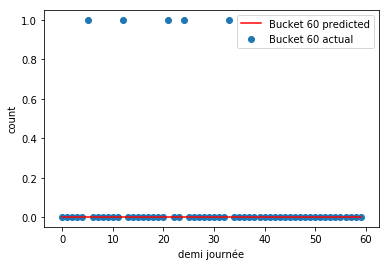

0.45


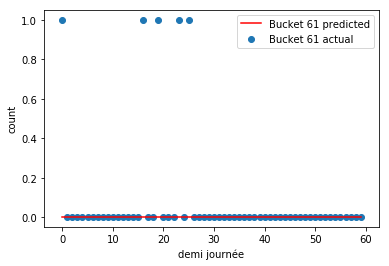

0.7666666666666667


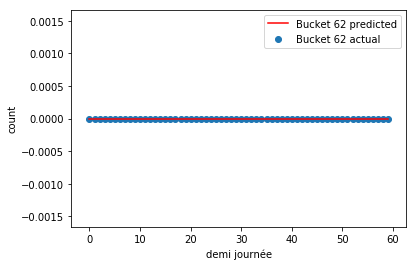

0.4666666666666667


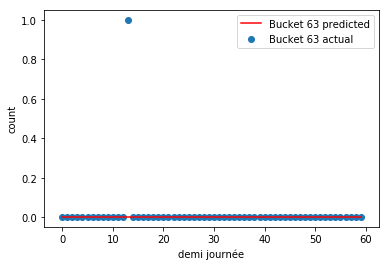

0.6833333333333333


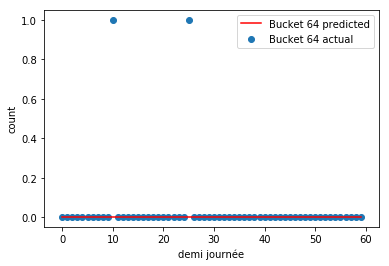

0.2833333333333333


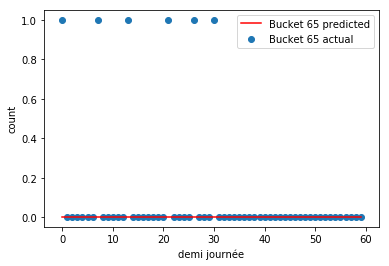

0.65


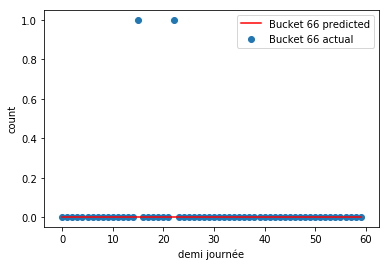

0.45


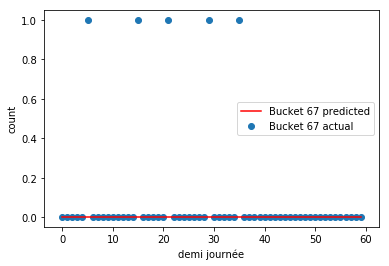

0.31666666666666665


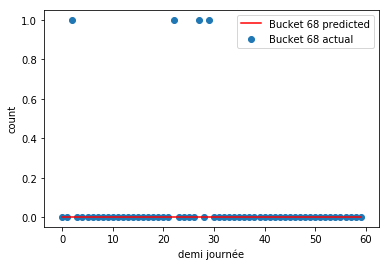

0.38333333333333336


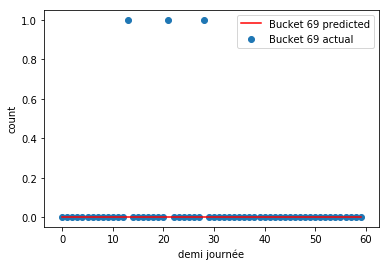

0.38333333333333336


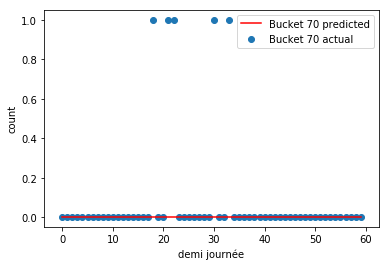

0.9


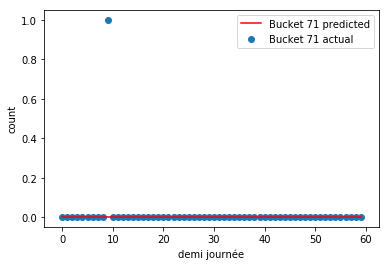

0.5333333333333333


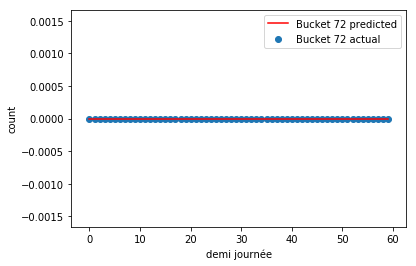

0.26666666666666666


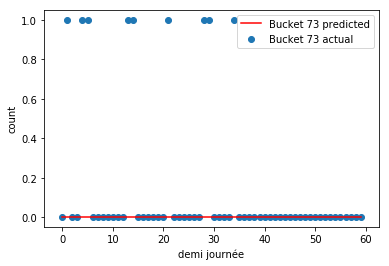

0.4166666666666667


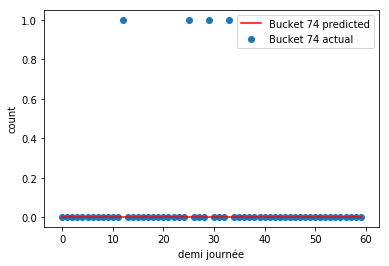

0.3


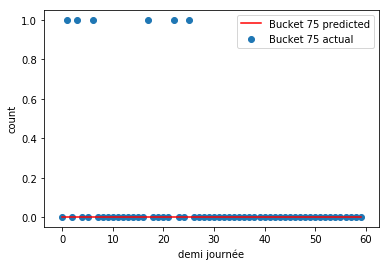

0.9166666666666666


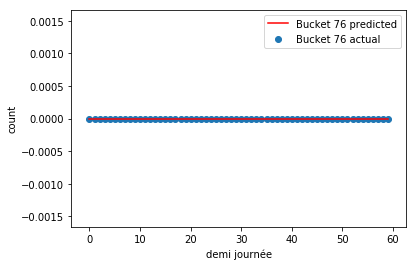

0.38333333333333336


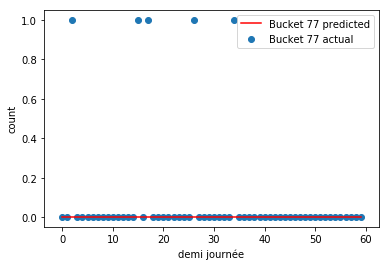

0.31666666666666665


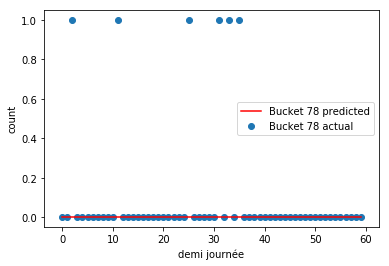

0.25


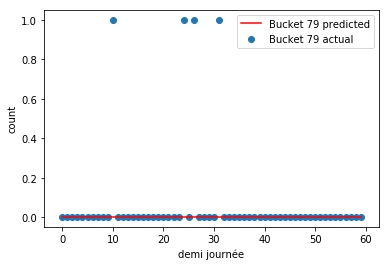

0.35


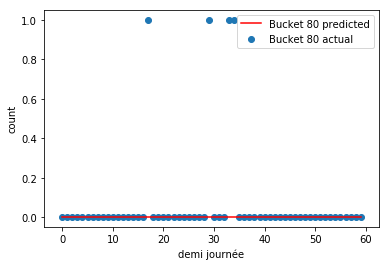

0.9833333333333333


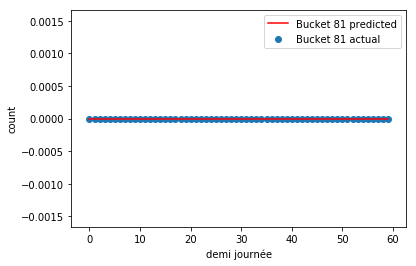

0.45


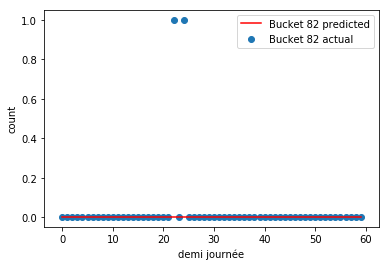

0.4166666666666667


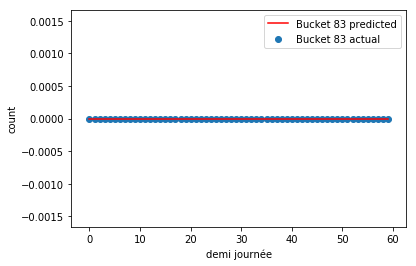

0.21666666666666667


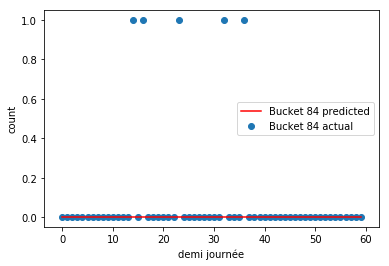

0.26666666666666666


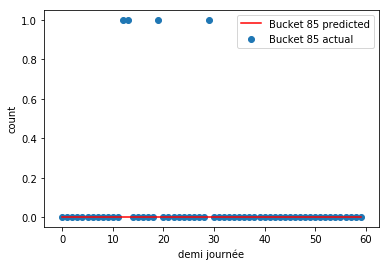

0.26666666666666666


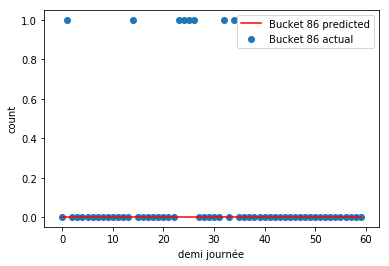

0.7333333333333333


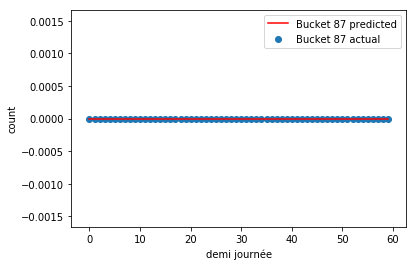

0.36666666666666664


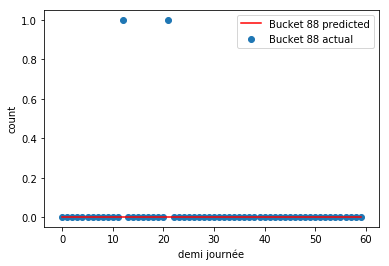

0.6833333333333333


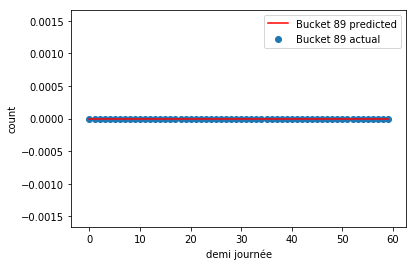

0.43333333333333335


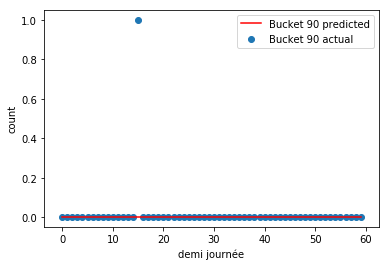

0.4166666666666667


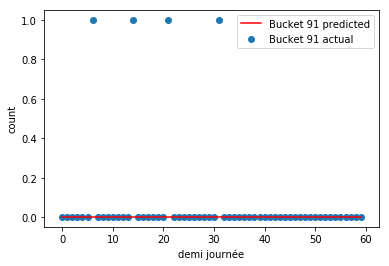

0.6166666666666667


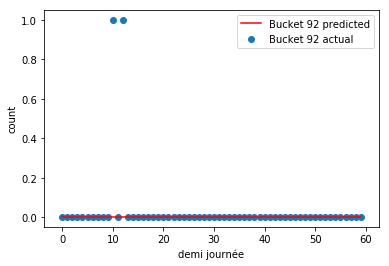

0.7833333333333333


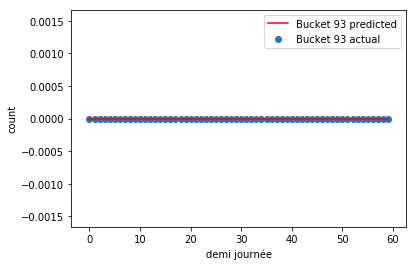

0.5166666666666667


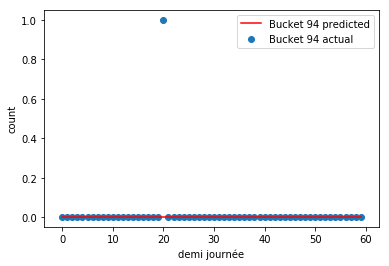

0.6666666666666666


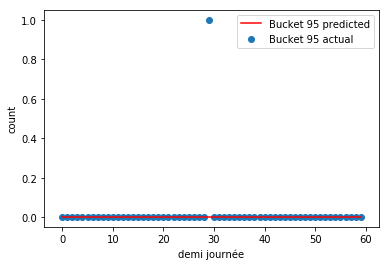

0.18333333333333332


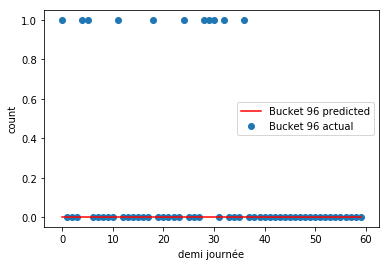

0.31666666666666665


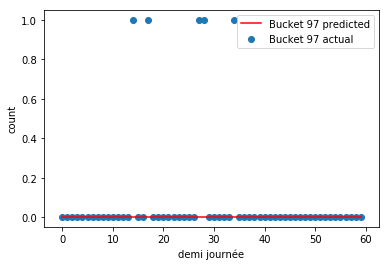

0.45


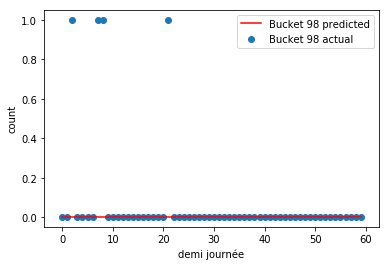

0.5


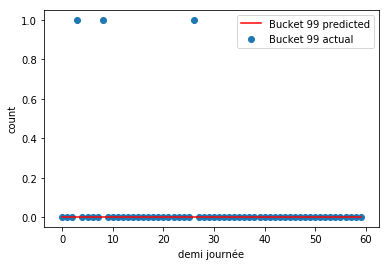

0.9833333333333333


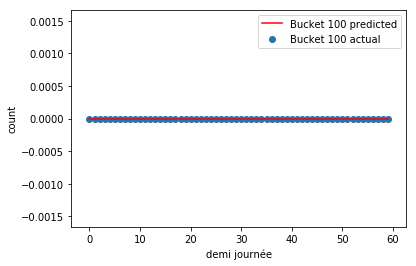

0.6666666666666666


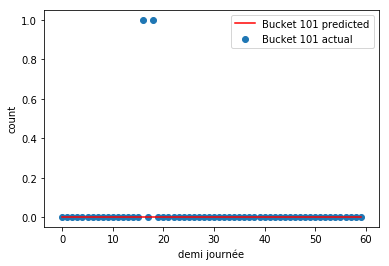

0.4166666666666667


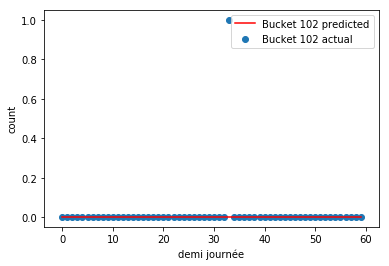

0.31666666666666665


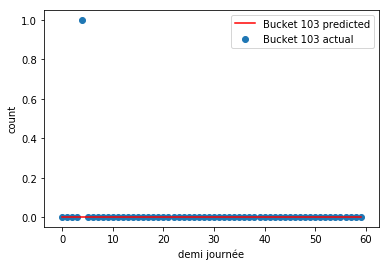

0.35


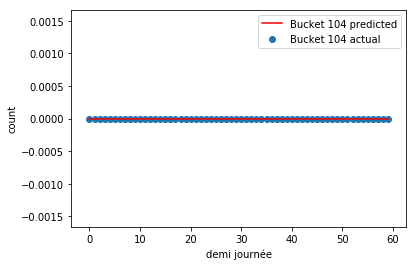

0.8


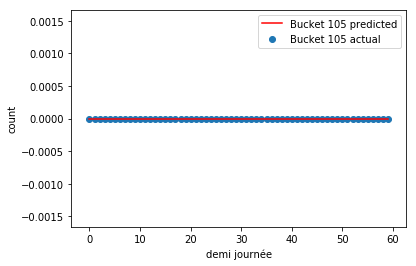

0.43333333333333335


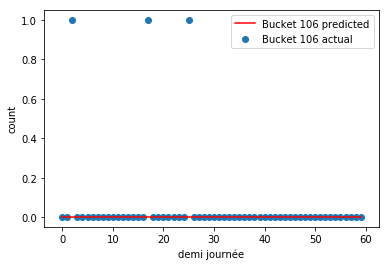

0.6333333333333333


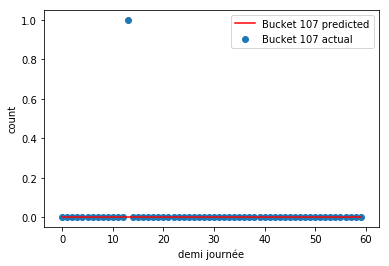

0.31666666666666665


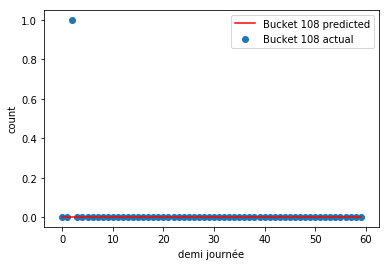

0.5833333333333334


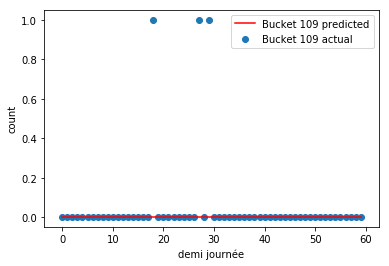

0.5333333333333333


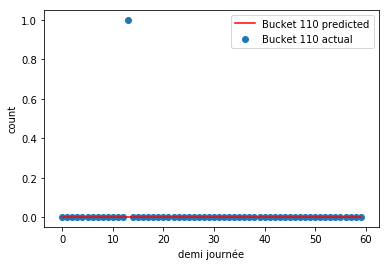

0.4166666666666667


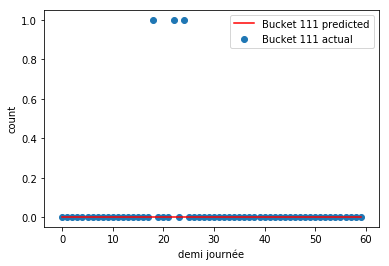

0.43333333333333335


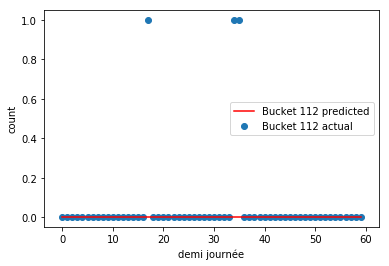

0.95


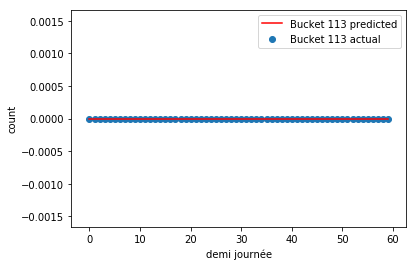

0.31666666666666665


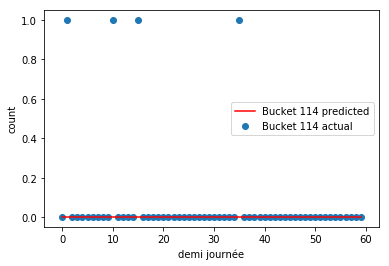

0.8166666666666667


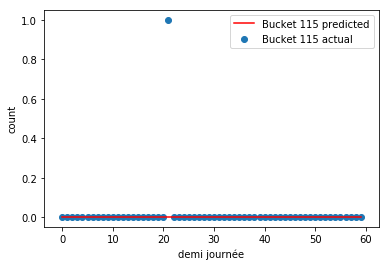

0.16666666666666666


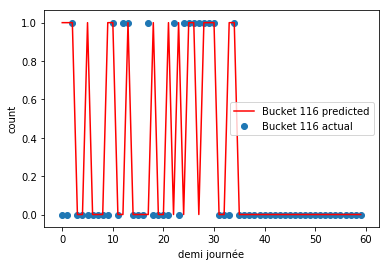

0.9833333333333333


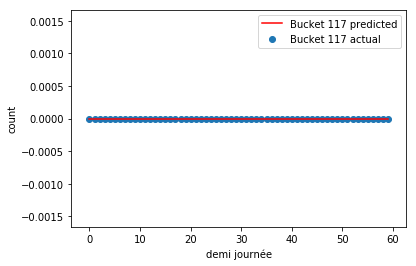

0.4666666666666667


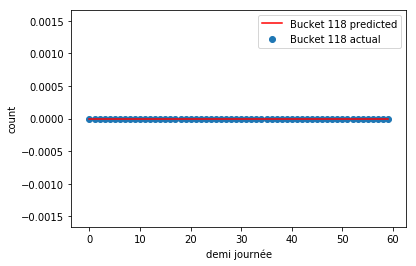

0.45


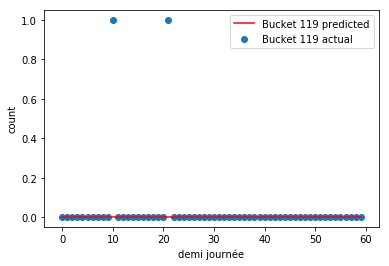

0.45


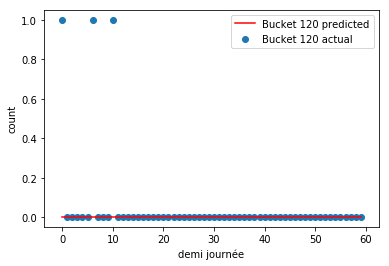

0.6833333333333333


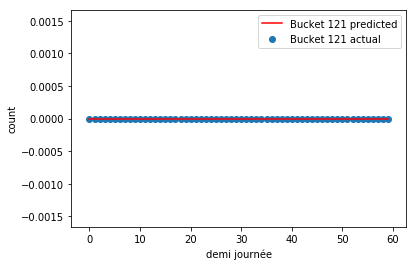

0.9833333333333333


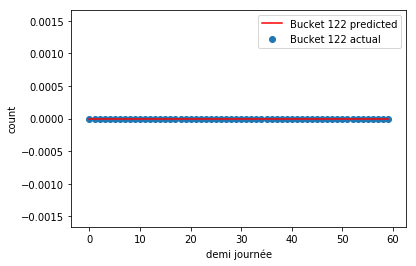

0.2


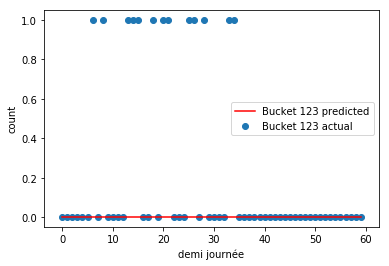

0.21666666666666667


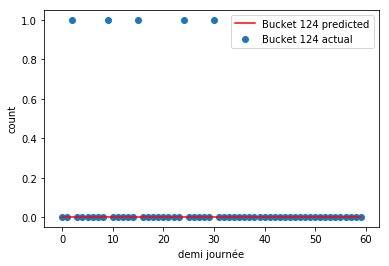

0.2


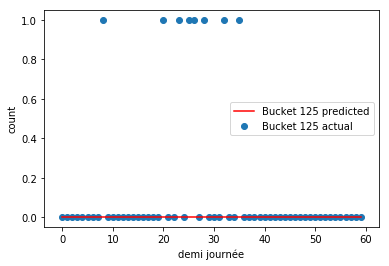

1.0


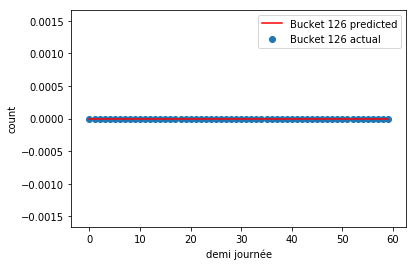

0.5666666666666667


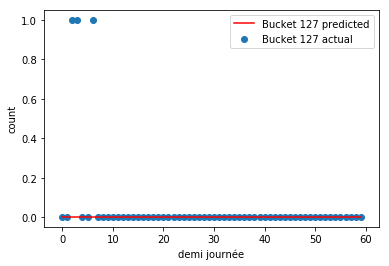

0.5166666666666667


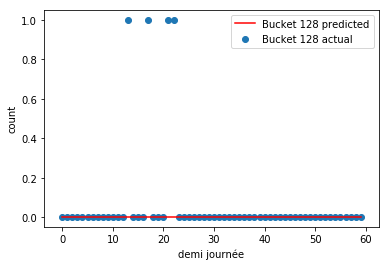

0.48333333333333334


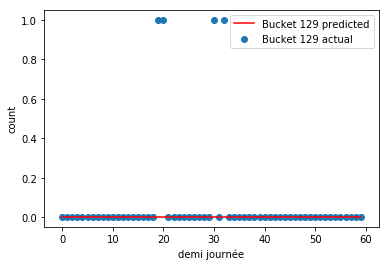

0.8


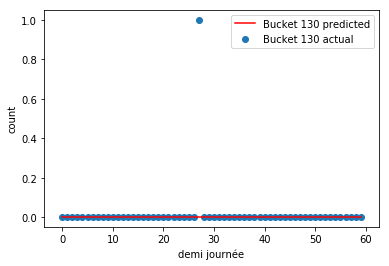

0.9666666666666667


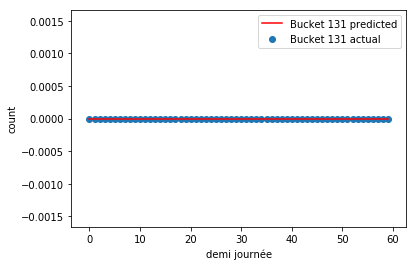

0.4666666666666667


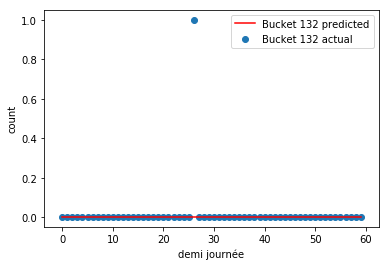

0.3333333333333333


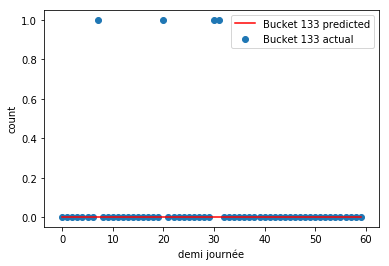

0.38333333333333336


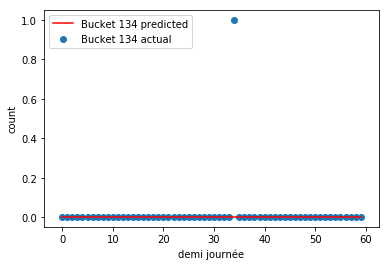

0.7666666666666667


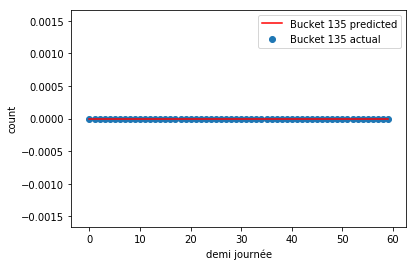

0.48333333333333334


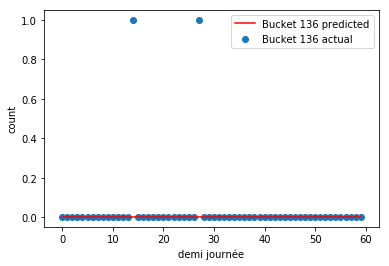

0.9833333333333333


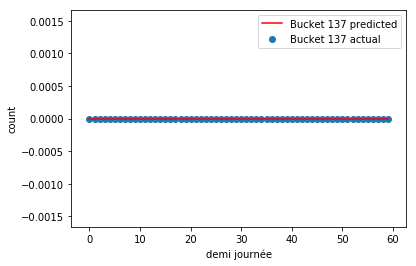

0.5


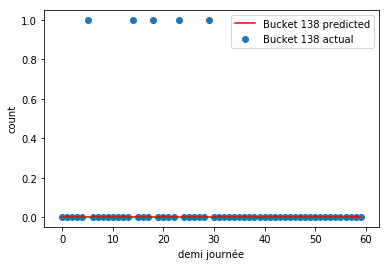

0.36666666666666664


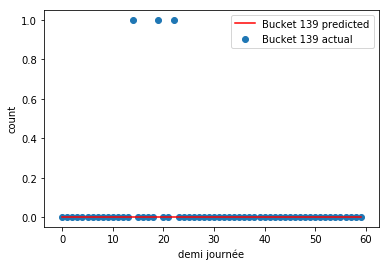

0.25


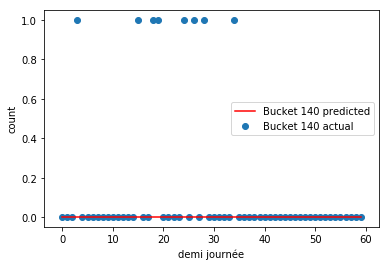

0.5166666666666667


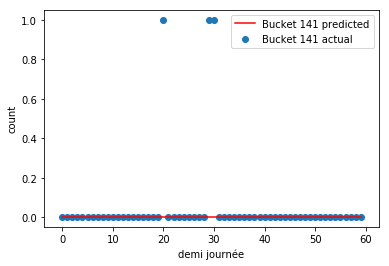

0.55


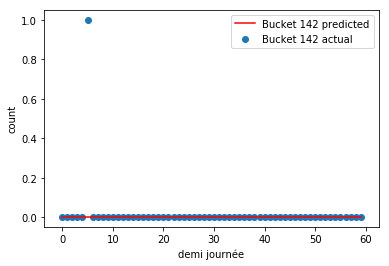

0.9833333333333333


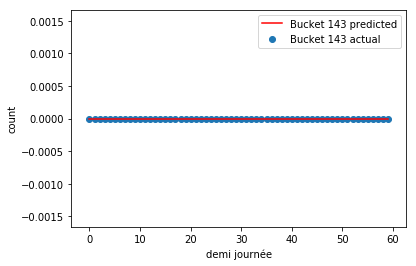

0.31666666666666665


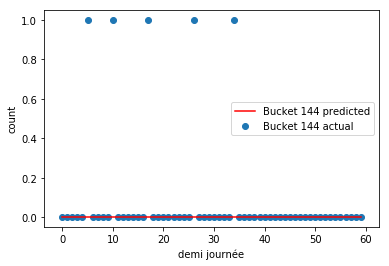

0.8333333333333334


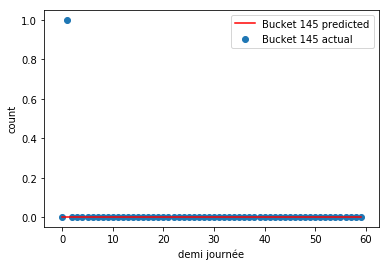

0.9


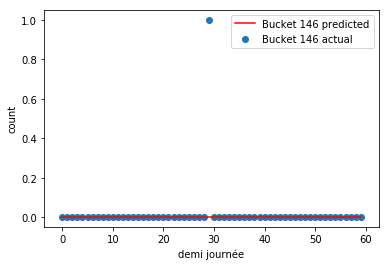

0.9


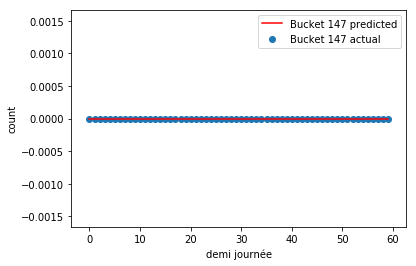

0.9666666666666667


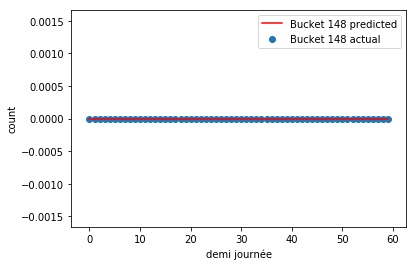

0.23333333333333334


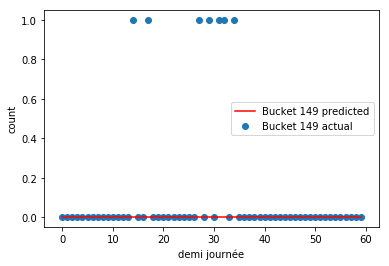

0.55


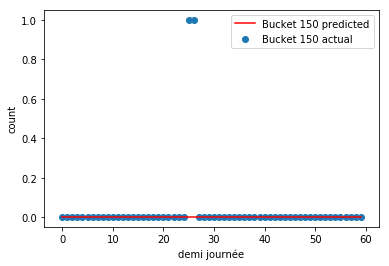

0.4666666666666667


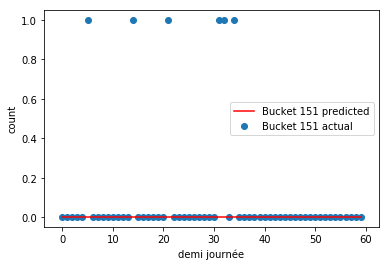

0.8666666666666667


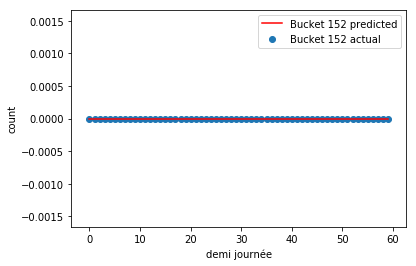

0.45


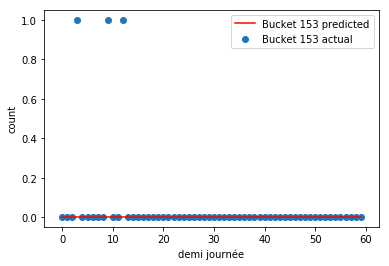

0.38333333333333336


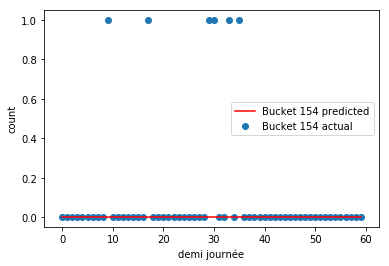

0.7833333333333333


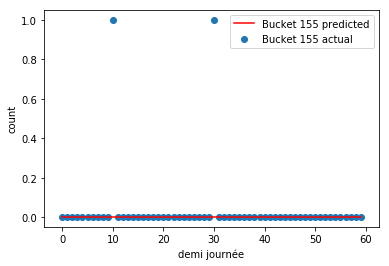

0.6166666666666667


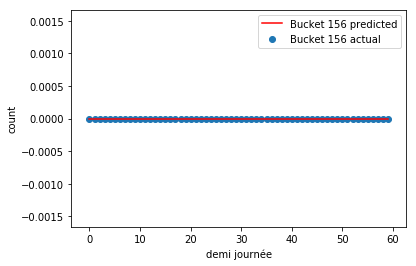

0.7333333333333333


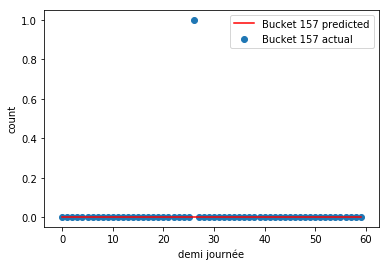

0.5166666666666667


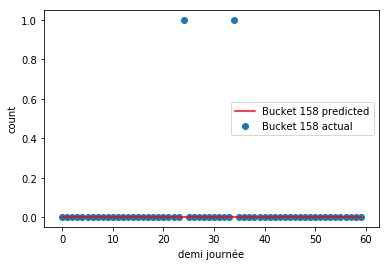

0.48333333333333334


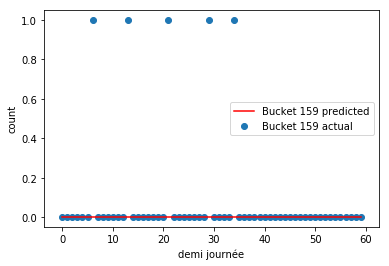

0.9833333333333333


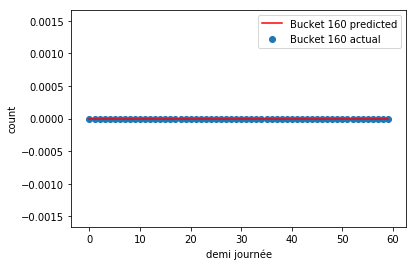

0.8833333333333333


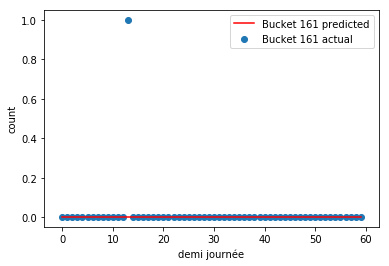

0.6


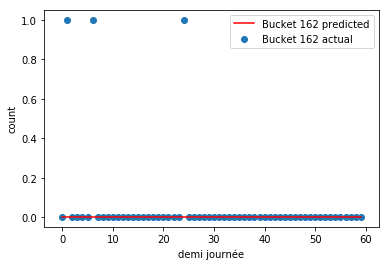

0.36666666666666664


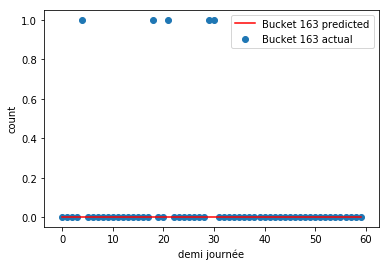

0.8333333333333334


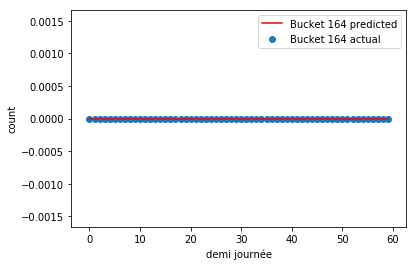

0.4


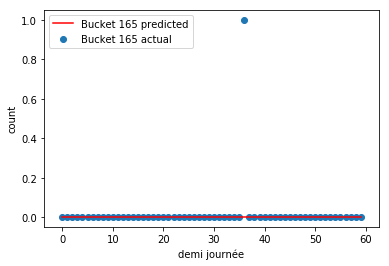

0.3


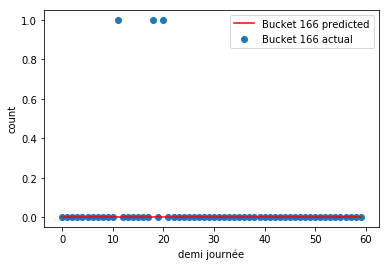

0.5333333333333333


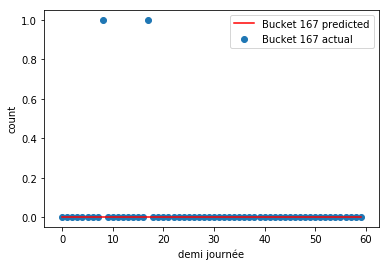

0.9666666666666667


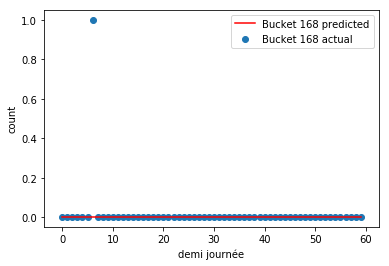

0.4666666666666667


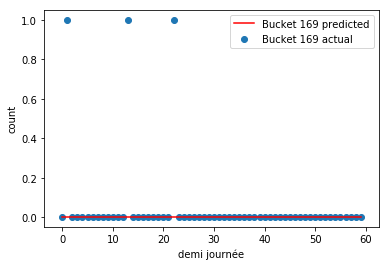

0.5166666666666667


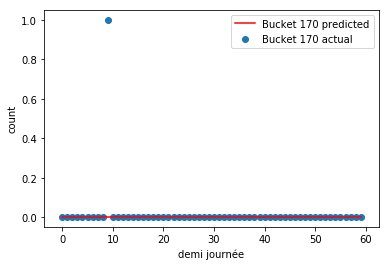

0.55


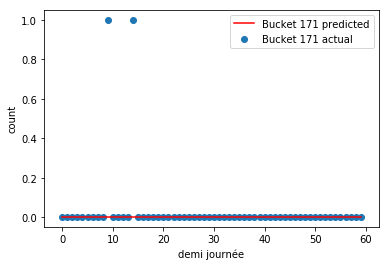

1.0


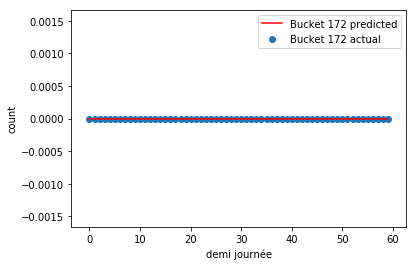

0.45


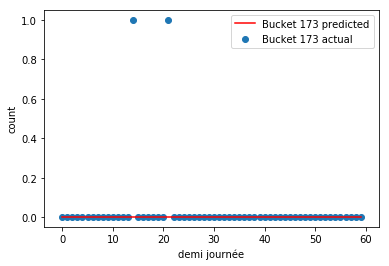

0.15


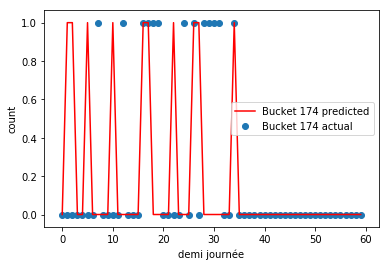

0.8833333333333333


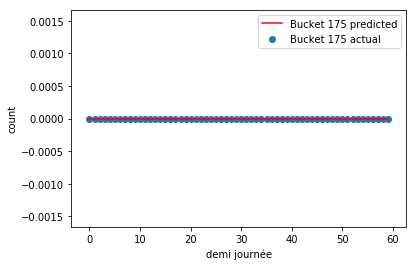

0.4166666666666667


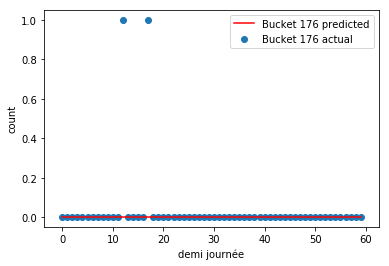

0.36666666666666664


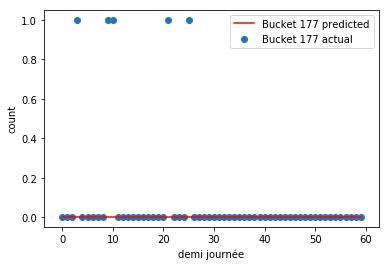

0.8166666666666667


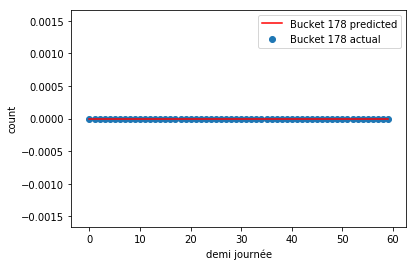

0.5333333333333333


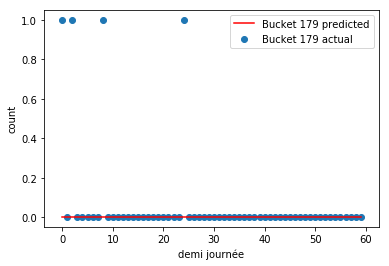

0.5833333333333334


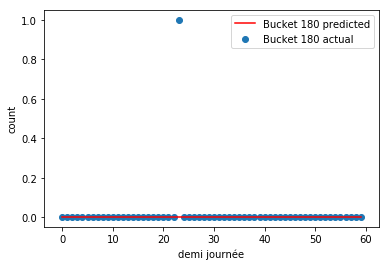

0.6833333333333333


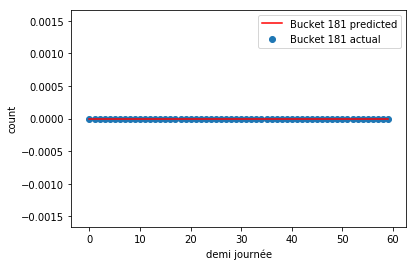

0.5


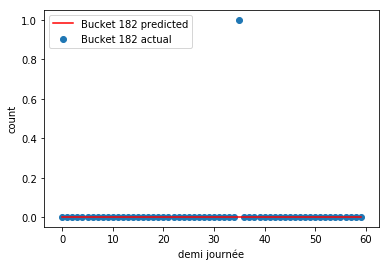

0.65


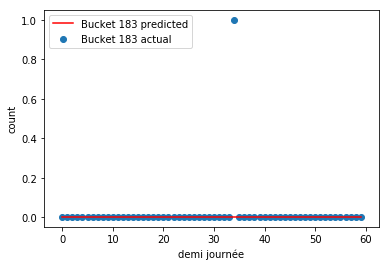

0.25


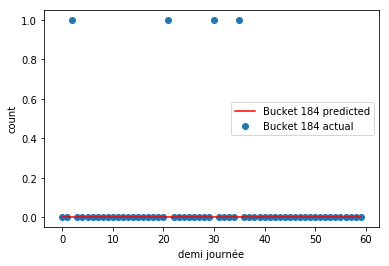

0.3333333333333333


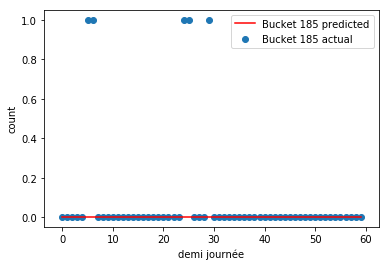

0.38333333333333336


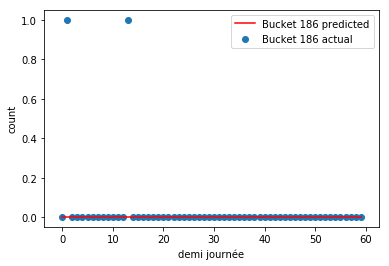

1.0


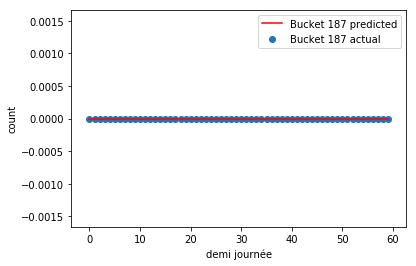

0.38333333333333336


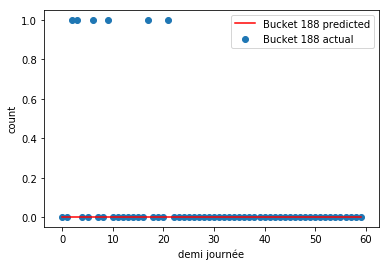

0.7166666666666667


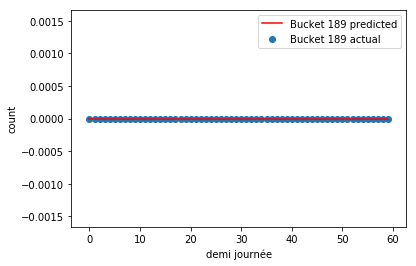

0.6


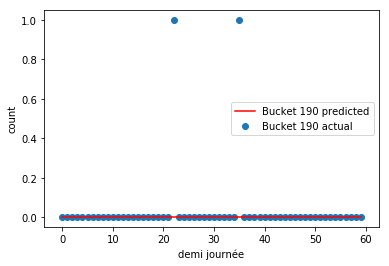

0.4166666666666667


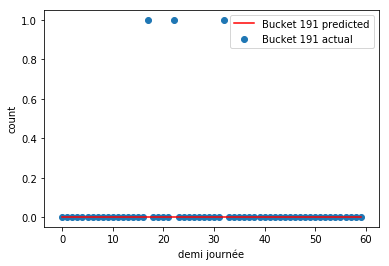

0.43333333333333335


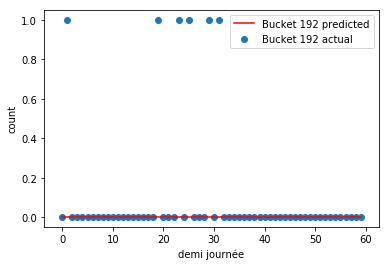

0.5333333333333333


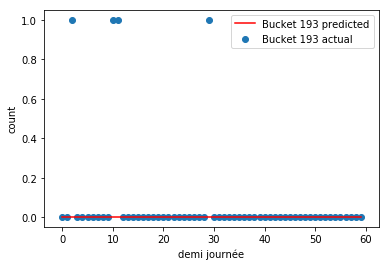

0.9833333333333333


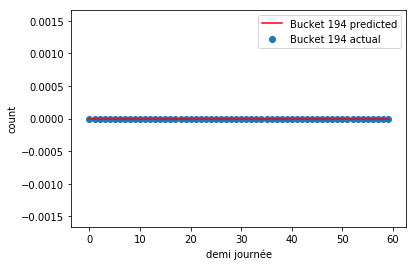

0.9666666666666667


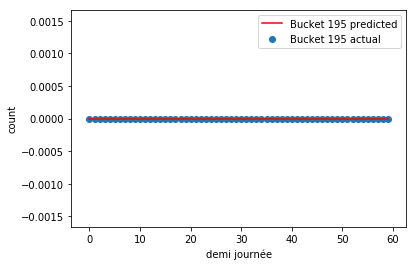

0.5333333333333333


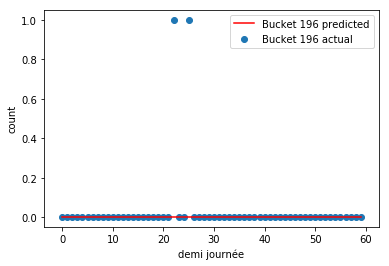

0.5166666666666667


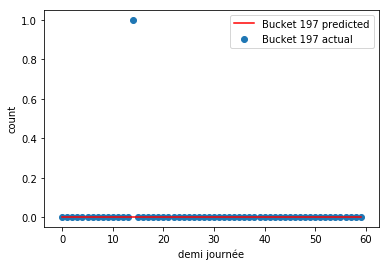

1.0


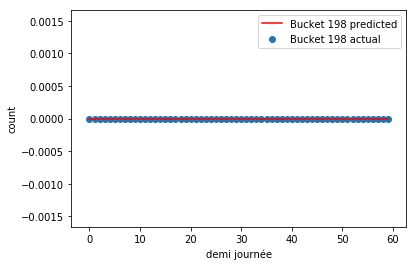

0.5166666666666667


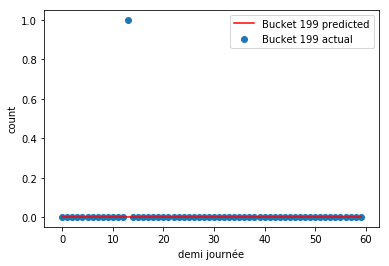

In [464]:
import warnings
warnings.filterwarnings('ignore')
labels = []
for i in range(200):
    y_pred = yhat_log[i]
    y_true = y_log[i]
    print(accuracy_score(y_true,y_pred))
    plt.plot(range(60),y_pred.T[11], c = 'r')
    plt.scatter(range(60),y_true.T[11])
    #labels.append('Bucket '+str(i))
    label = ['Bucket '+str(i)+' predicted', 'Bucket '+str(i)+' actual']
    plt.legend(label)
    plt.xlabel('demi journée')
    plt.ylabel('count')
    plt.show()


In [339]:
y_pred.shape

(60, 22)

In [475]:
acc = accuracy.reshape(200,21)
np.arange(0,np.max(yhat),0.005).shape

(3,)

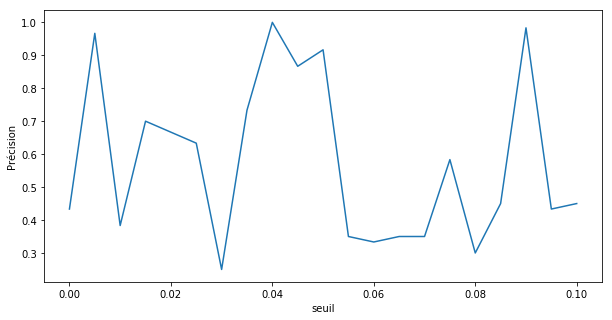

In [480]:
for i in range(1):
    plt.figure(figsize = (10,5))
    plt.plot(np.arange(0,0.105,0.005),acc[i])
    plt.xlabel('seuil')
    plt.ylabel('Précision')
    plt.show()

In [128]:
y_pred = np.zeros((60,12))
y_true = y_log[1]

accuracy_score(y_true, y_pred)


0.7

In [125]:
y_log[1].shape

(60, 12)

In [161]:
np.arange(0,1,0.01)[np.argmax(acc, axis = 1)]

NameError: name 'acc' is not defined

In [79]:
a = y_test.T[0].T
a = np.where(a < 1 , 0,1) 

In [85]:
np.arange(0.5,0.8,0.1)




array([0.5, 0.6, 0.7, 0.8])

# Résultat LSTM

In [160]:
mois = 11
from sklearn.metrics import classification_report
y_true = np.argmax(y_test[mois], axis = 1)
y_pred = np.argmax(yhat[mois], axis = 1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        49
           6       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          75       0.00      0.00      0.00         1
          94       0.00      0.00      0.00         1
         116       0.00      0.00      0.00         1
         149       0.00      0.00      0.00         1

    accuracy                           0.82        60
   macro avg       0.07      0.08      0.07        60
weighted avg       0.67      0.82      0.73        60



# LSTM BIDIRECTIONAL

In [361]:
epochs = 80
batch_size = 20

model1 = Sequential() 
model1.add(Bidirectional(LSTM(100,recurrent_activation = 'relu', activation ='sigmoid',kernel_regularizer = regularizers.l2(0.1), input_shape = (60,200))))
model1.add(RepeatVector(60))
model1.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True )))

model1.compile(loss = "mean_absolute_error", 
              optimizer = "adam"
                 )


history = model1.fit(x_train,y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, y_test), verbose=1 )

Train on 72 samples, validate on 22 samples
Epoch 1/80
72/72 [==============================] - 14s 199ms/step - loss: 51.2172 - val_loss: 47.1100
Epoch 2/80
72/72 [==============================] - 4s 51ms/step - loss: 45.2447 - val_loss: 41.4981
Epoch 3/80
72/72 [==============================] - 4s 52ms/step - loss: 39.8077 - val_loss: 36.4101
Epoch 4/80
72/72 [==============================] - 4s 50ms/step - loss: 34.8894 - val_loss: 31.8241
Epoch 5/80
72/72 [==============================] - 3s 42ms/step - loss: 30.4655 - val_loss: 27.7169
Epoch 6/80
72/72 [==============================] - 3s 38ms/step - loss: 26.5107 - val_loss: 24.0586
Epoch 7/80
72/72 [==============================] - 3s 40ms/step - loss: 22.9940 - val_loss: 20.8166
Epoch 8/80
72/72 [==============================] - 4s 50ms/step - loss: 19.8820 - val_loss: 17.9564
Epoch 9/80
72/72 [==============================] - 4s 51ms/step - loss: 17.1403 - val_loss: 15.4437
Epoch 10/80
72/72 [==========================

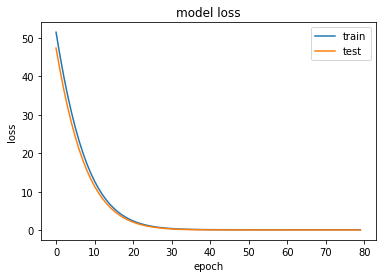

In [188]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [362]:
yhat = model1.predict(x_test)

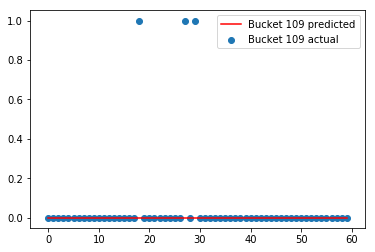

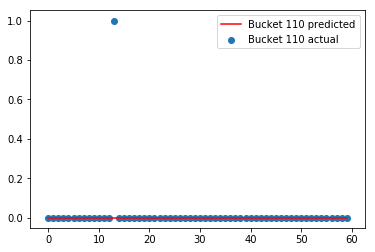

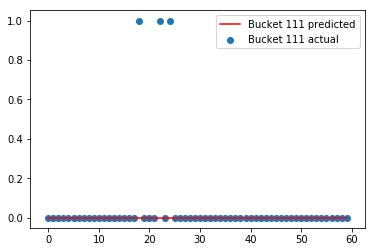

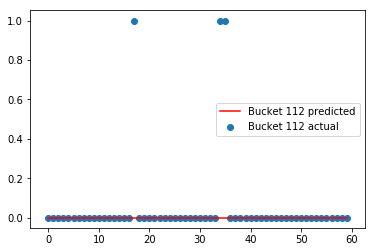

In [190]:
import warnings
warnings.filterwarnings('ignore')
labels = []
for i in range(109,113):
    plt.plot(range(60),yhat[11].T[i]*100, c = 'r')
    plt.scatter(range(60),y_test[11].T[i])
    #labels.append('Bucket '+str(i))
    label = ['Bucket '+str(i)+' predicted', 'Bucket '+str(i)+' actual']
    plt.legend(label)
    plt.show()

In [363]:
y_log = np.where(y_test.T < 1 ,y_test.T ,1)

In [370]:
A = []
accuracy  = np.array([])
for thresh in np.arange(0,1,0.005):
    T = []

    yhat_log = np.where(yhat.T > thresh , 1 , 0)
    for i in range(200):
        y_pred = yhat_log[i]
        y_true = y_log[i]
        T.append(accuracy_score(y_true, y_pred))
    accuracy = np.hstack((accuracy,np.array(T)))
    A.append(np.mean(T))
#plt.plot(range(12),T)
#plt.show()

KeyboardInterrupt: 

In [371]:
np.max(yhat), np.max(y_test)

(0.0, 9.0)

In [365]:
L = []
for i in range(29):
    L.append(np.mean(acc[i]))

print(L,L.index(max(L)))

[0.5660919540229885, 0.5798850574712644, 0.4798850574712644, 0.5390804597701149, 0.5522988505747126, 0.6390804597701149, 0.578735632183908, 0.582183908045977, 0.5660919540229884, 0.47758620689655185, 0.5327586206896552, 0.5879310344827585, 0.5931034482758621, 0.6028735632183908, 0.5683908045977012, 0.5689655172413792, 0.4701149425287357, 0.5373563218390804, 0.5936781609195403, 0.5919540229885059, 0.6120689655172413, 0.5540229885057472, 0.5706896551724138, 0.48218390804597705, 0.5172413793103448, 0.606896551724138, 0.5913793103448277, 0.6247126436781609, 0.525287356321839] 5


In [ ]:
acc = accuracy.reshape(200,200)

# Résultat Bidirectional LSTM

In [191]:
y_true = np.argmax(y_test[11], axis = 1)
y_pred = np.argmax(yhat[11], axis = 1)
accuracy_score(y_true, y_pred)

0.43333333333333335

In [249]:
from sklearn.metrics import classification_report
y_true = np.argmax(y_test[9], axis = 1)
y_pred = np.argmax(yhat[9], axis = 1)
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.70      1.00      0.82        42
           1       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          20       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          48       0.00      0.00      0.00         1
          50       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         1
          97       0.00      0.00      0.00         1
         123       0.00      0.00      0.00         1
         141       0.00      0.00      0.00         1
         150       0.00      0.00      0.00         2
         155       0.00      0.00      0.00         1
         199       0.00      0.00      0.00         1

    accuracy                           0.70        60
   macro avg       0.05      0.07      0.05        60
weighted avg       0.49   

In [46]:
n_mois = 20

In [57]:
scaler = MinMaxScaler(feature_range=(0, 2))
scaled = scaler.fit_transform(x_test[n_mois].T)
# make a prediction
yhat = model1.predict(x_test)
#x_test = x_test.reshape((x_test.shape[0],[] 60))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat[n_mois], x_test[n_mois]), axis=1)
inv_yhat = scaler.fit_transform(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:200]

In [58]:

# invert scaling for actual
#y_test1 = y_test.reshape((len(y_test), 60))
inv_y = np.concatenate((y_test[n_mois], x_test[n_mois]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:200]


# Autoregression

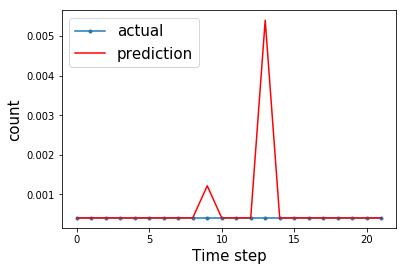

In [454]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(fixed_bucket)
# make a prediction
yhat = model_regress1.predict(x_test)
x_test = x_test.reshape((x_test.shape[0], 60))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, x_test[:, -59:]), axis=1)
inv_yhat = scaler.fit_transform(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 60))
inv_y = np.concatenate((y_test, x_test[:, -59:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
aa=[x for x in range(len(inv_y))]
plt.plot(aa,inv_y, marker='.', label="actual")
plt.plot(aa, inv_yhat, 'r', label="prediction")
plt.ylabel('count', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Lstm for every bucket 

In [ ]:
x_train.reshape()

In [ ]:
for i in range(len(x_train)):
    epochs = 80
    batch_size = 20

    

    model = Sequential() 
    model.add(LSTM(200,recurrent_activation = 'relu', activation ='sigmoid',kernel_regularizer = regularizers.l2(0.1), input_shape = (60,200), return_sequences= True))

    model.compile(loss = "mean_absolute_error", 
                  optimizer = "adam"
                     )

    model.summary()

    history = model.fit(x_train[i],y_train_log[i], epochs=epochs, batch_size=batch_size,validation_data=(x_test_log, y_test_log), verbose=1)
